# PART A #

In [1]:
#Importing necessary libraries
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [2]:
# Enable mixed precision training using the new API
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Constants
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

# Import and Understand the data #

In [4]:
#1A Import and read ‘images.npy’
data = np.load('/Users/apple/Downloads/images.npy', allow_pickle=True)


In [5]:
#1B Split the data into Features(X) & labels(Y). Unify shape of all the images

X = np.zeros((data.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 3))
masks = np.zeros((data.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1))  # Note the additional dimension

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
    
    # Check and process the image
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    elif img.shape[-1] > 3:
        img = img[:, :, :3]
    
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index, y1:y2, x1:x2, 0] = 1  # Adjust this line to fill the mask


In [6]:
#1C Split the data into train and test (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.3, random_state=42)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


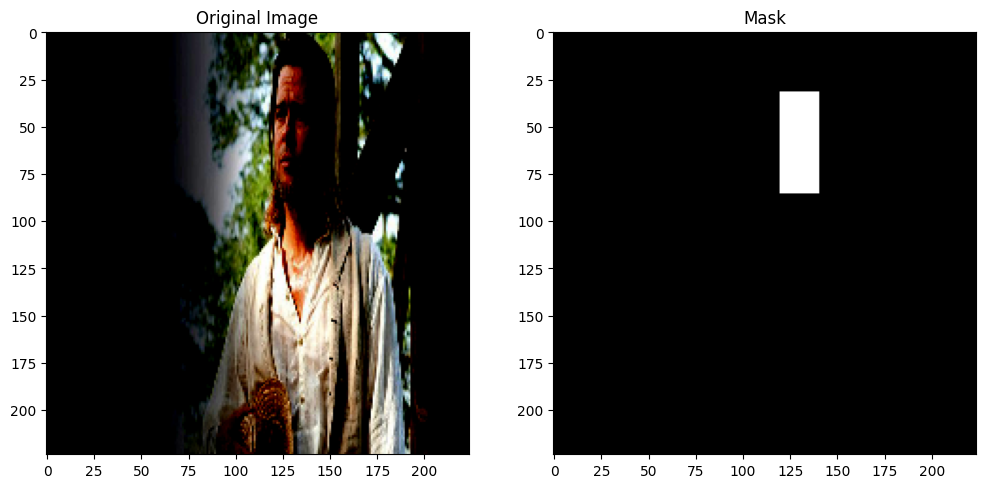

In [7]:
#1D Select random image from the train data and display original image and masked image
idx = random.randint(0, len(X_train) - 1)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[idx])
plt.title('Original Image')
plt.subplot(122)
plt.imshow(y_train[idx], cmap='gray')
plt.title('Mask')
plt.show()

In [8]:
# Convert data to tf.data.Dataset for optimized pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [9]:
# Optimize the data pipeline
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


# Model building #

In [10]:
#2A Design a face mask detection model
def create_model(trainable=False):
    base_model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = trainable

    # Extract features at different levels
    f1 = base_model.get_layer('conv_pw_1_relu').output
    f2 = base_model.get_layer('conv_pw_3_relu').output
    f3 = base_model.get_layer('conv_pw_5_relu').output
    f4 = base_model.get_layer('conv_pw_11_relu').output
    f5 = base_model.get_layer('conv_pw_13_relu').output

    # Upsampling and concatenation
    u1 = UpSampling2D(size=(2, 2))(f5)
    u1 = Concatenate()([u1, f4])
    u2 = UpSampling2D(size=(2, 2))(u1)
    u2 = Concatenate()([u2, f3])
    u3 = UpSampling2D(size=(2, 2))(u2)
    u3 = Concatenate()([u3, f2])
    u4 = UpSampling2D(size=(2, 2))(u3)
    u4 = Concatenate()([u4, f1])
    
    # Final upsampling to reach the desired output size
    u5 = UpSampling2D(size=(2, 2))(u4)
    
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u5)
    
    return Model(inputs=base_model.input, outputs=output)


In [12]:
# Create the model instance
model = create_model(trainable=False)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,230,849 (12.32 MB)

 Trainable params: 1,985 (7.75 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [13]:
#2B Design your own Dice Coefficient and Loss function
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice, axis=0)


def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1 - dice_coefficient(y_true, y_pred))


In [14]:
#2C Create and compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=bce_dice_loss,  
              metrics=[dice_coefficient, 'accuracy'])

In [15]:
# Set up callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=10, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
]

In [16]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, 
                    epochs=30, callbacks=callbacks)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 201s 23s/step - accuracy: 0.4068 - dice_coefficient: 0.1643 - loss: 2.0455 - val_accuracy: 0.5694 - val_dice_coefficient: 0.1359 - val_loss: 1.7585 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 173s 19s/step - accuracy: 0.5937 - dice_coefficient: 0.1313 - loss: 1.7152 - val_accuracy: 0.7208 - val_dice_coefficient: 0.1064 - val_loss: 1.5868 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 162s 18s/step - accuracy: 0.7458 - dice_coefficient: 0.0939 - loss: 1.5559 - val_accuracy: 0.7894 - val_dice_coefficient: 0.0889 - val_loss: 1.5385 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 170s 20s/step - accuracy: 0.7957 - dice_coefficient: 0.0827 - loss: 1.5339 - val_accuracy: 0.8122 - val_dice_coefficient: 0.0855 - val_loss: 1.5165 - learning_rate: 1.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 167s 19s/step - accuracy: 0.8191 - dice_coefficient: 0.0861 - loss: 1.4817 - val_accuracy: 0.8165 - val_dice_coeffic

In [17]:
#2D Evaluate and share insights on performance of the model
# Evaluate the model on the test data
test_loss, test_dice, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 11s/step - accuracy: 0.8759 - dice_coefficient: 0.3582 - loss: 0.9394
Test Loss: 0.9500022530555725
Test Dice Coefficient: 0.35516357421875
Test Accuracy: 0.8733403086662292


In [18]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

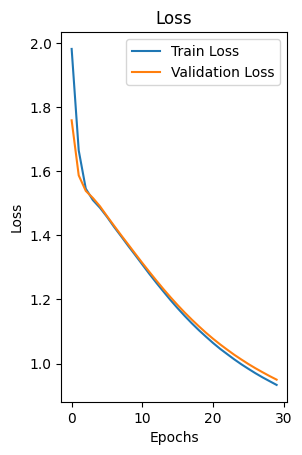

In [19]:
# Plot loss
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

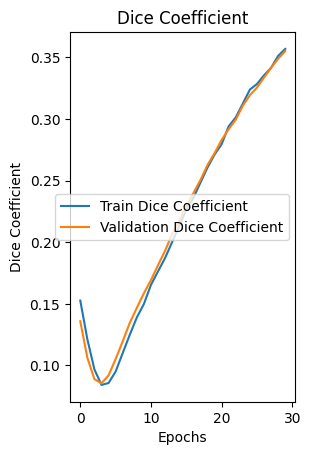

In [20]:
# Plot Dice coefficient
plt.subplot(122)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()

INSIGHTS:

1. Loss Plot:
Training Loss: The training loss is steadily decreasing, indicating that the model is learning from the data

Validation Loss: The validation loss follows a similar decreasing trend, which suggests that the model is not overfitting and is generalizing well to unseen data

2. Dice Coefficient Plot:

Training Dice Coefficient: The training Dice coefficient is gradually increasing, which shows that the model is improving in terms of predicting the overlap between the predicted and true masks

Validation Dice Coefficient: The validation Dice coefficient is closely tracking the training Dice coefficient, again indicating good generalization


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


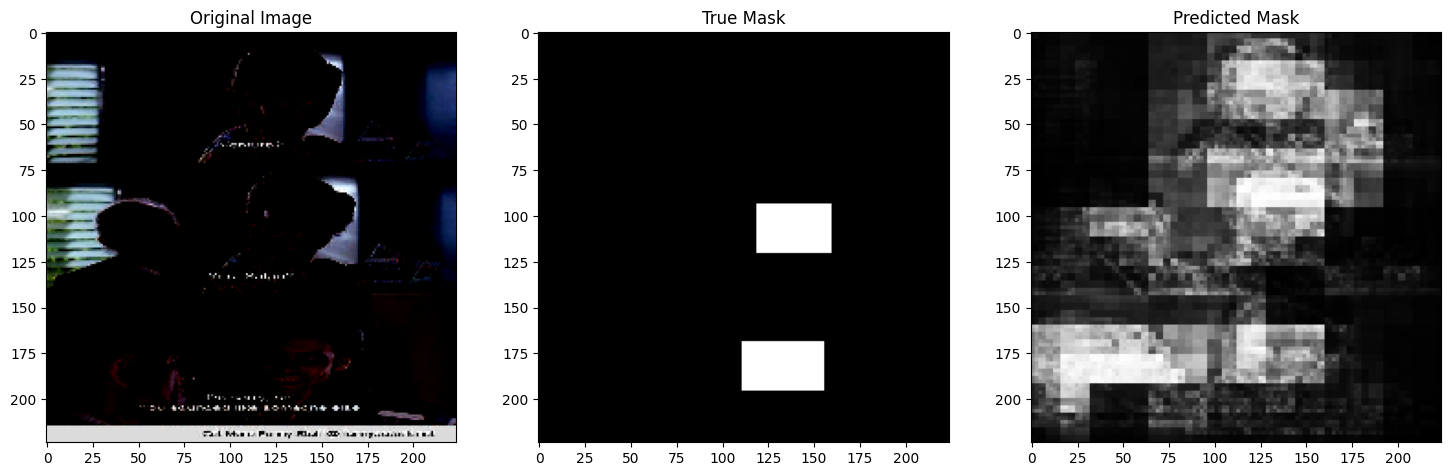

In [21]:
#3 Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]
test_image = X_test[3]
true_mask = y_test[3]

# Add a batch dimension and predict the mask
predicted_mask = model.predict(tf.expand_dims(test_image, axis=0))

# Remove the batch dimension for visualization
predicted_mask = tf.squeeze(predicted_mask, axis=0)

# Plot the original image, true mask, and predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(test_image)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(tf.squeeze(true_mask), cmap='gray')
plt.title('True Mask')

plt.subplot(133)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()


# PART B #

In [22]:
#Importing necessary libraries
import cv2
import os
import pandas as pd
from tqdm import tqdm

In [23]:
#1 Read/import images from folder 'training_images' 

image_folder = '/Users/apple/Downloads/training_images'
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]


In [24]:
# Load the face detection cascade classifier
face_cascade = cv2.CascadeClassifier('/Users/apple/Downloads/haarcascade_frontalface_default.xml')

In [25]:
# Initialize a list to store face metadata
face_data = []

In [26]:
#2 & 3 Loop through images, detect faces, and extract metadata 

for image_file in tqdm(image_files, desc="Processing images"):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Extract metadata for each face
    for (x, y, w, h) in faces:
        face_data.append({
            'image_file': image_file,
            'face_x': x,
            'face_y': y,
            'face_width': w,
            'face_height': h,
            'image_width': img.shape[1],
            'image_height': img.shape[0]
        })

# Create DataFrame from face_data
df = pd.DataFrame(face_data)

Processing images: 100%|████████████████████| 1091/1091 [00:36<00:00, 29.83it/s]


In [27]:
#4 Save the output DataFrame in .csv format
output_file = 'face_metadata.csv'
df.to_csv(output_file, index=False)

# PART C #

In [28]:
# Import necessary libraries
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

In [29]:
# Define a function to create and compile a VGG16 model with fine-tuning
def create_finetuned_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze the last few layers
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    
    # Add custom dense layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(2622, activation='softmax')(x)  # Adjust according to the weights' architecture
    
    model = Model(inputs=base_model.input, outputs=x)
    
    # Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
# Load VGG16 weights
def load_vgg_face_weights(model, weights_path):
    model.load_weights(weights_path, by_name=True, skip_mismatch=True)

In [31]:
# 1. Unzip and read data ('PINS.zip') into the session
with zipfile.ZipFile('/Users/apple/Downloads/PINS.zip', 'r') as zip_ref:
    zip_ref.extractall('PINS_data')


In [32]:
# 2. Create metadata of the image
def create_metadata(image_path):
    try:
        img = Image.open(image_path)
        return {
            'filename': os.path.basename(image_path),
            'width': img.width,
            'height': img.height,
            'format': img.format,
            'mode': img.mode,
            'person': os.path.basename(os.path.dirname(image_path))
        }
    except (IOError, SyntaxError) as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [33]:
# 3. Create metadata for all images
metadata = []
for root, dirs, files in os.walk('PINS_data'):
    for file in tqdm(files, desc="Creating metadata"):
        if file.endswith(('.jpg', '.jpeg', '.png')) and not file.startswith('._'):
            image_path = os.path.join(root, file)
            meta = create_metadata(image_path)
            if meta:
                metadata.append(meta)

metadata_df = pd.DataFrame(metadata)
print(f"Total images processed: {len(metadata_df)}")

Creating metadata: 0it [00:00, ?it/s]
Creating metadata: 0it [00:00, ?it/s]
Creating metadata: 100%|█████████████████████| 65/65 [00:00<00:00, 76927.13it/s]


Total images processed: 10770


In [34]:
# 4. Generate embeddings vectors on each face in the dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def generate_embedding_vgg(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Choose the model
vgg_face_model = create_finetuned_vgg16()
weights_path = '/Users/apple/Downloads/vgg_face_weights.h5'
load_vgg_face_weights(vgg_face_model, weights_path)

# Generate embeddings
embeddings = []
valid_metadata = []
for index, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Generating embeddings"):
    possible_paths = [
        os.path.join('PINS_data', 'PINS', row['person'], row['filename']),
        os.path.join('PINS_data', row['person'], row['filename']),
        os.path.join('PINS_data', 'pins_' + row['person'], row['filename'])
    ]
    
    for image_path in possible_paths:
        if os.path.exists(image_path):
            try:
                embedding = generate_embedding_vgg(image_path, vgg_face_model)
                embeddings.append(embedding)
                valid_metadata.append(row)
                break
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
    else:
        print(f"Could not find image for {row['person']}/{row['filename']}")
        
embeddings_array = np.array(embeddings)
metadata_df = pd.DataFrame(valid_metadata)
print(f"Generated embeddings for {len(embeddings)} images")
print(f"Embedding shape: {embeddings_array.shape}")

Generating embeddings:   0%|                          | 0/10770 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating embeddings:   0%|                  | 1/10770 [00:00<59:38,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Generating embeddings:   0%|                  | 2/10770 [00:00<45:44,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:   0%|                  | 3/10770 [00:00<45:52,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                  | 4/10770 [00:01<45:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating embeddings:   0%|                  | 5/10770 [00:01<43:38,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                  | 6/10770 [00:01<42:58,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   0%|                  | 7/10770 [00:01<42:50,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   0%|                  | 8/10770 [00:01<43:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   0%|                  | 9/10770 [00:02<42:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:   0%|                 | 10/10770 [00:02<43:27,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 11/10770 [00:02<43:15,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 12/10770 [00:02<42:52,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   0%|                 | 13/10770 [00:03<42:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 14/10770 [00:03<42:25,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 15/10770 [00:03<42:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 16/10770 [00:03<42:13,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 17/10770 [00:04<42:07,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 18/10770 [00:04<42:17,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   0%|                 | 19/10770 [00:04<42:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 20/10770 [00:04<42:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   0%|                 | 21/10770 [00:05<42:04,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 22/10770 [00:05<42:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 23/10770 [00:05<42:08,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 24/10770 [00:05<42:03,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 25/10770 [00:05<41:58,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 26/10770 [00:06<41:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 27/10770 [00:06<41:57,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 28/10770 [00:06<41:54,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 29/10770 [00:06<42:02,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 30/10770 [00:07<41:55,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 31/10770 [00:07<42:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   0%|                 | 32/10770 [00:07<42:01,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Generating embeddings:   0%|                 | 33/10770 [00:07<41:33,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 34/10770 [00:08<41:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 35/10770 [00:08<41:34,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 36/10770 [00:08<41:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   0%|                 | 37/10770 [00:08<41:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 38/10770 [00:09<41:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 39/10770 [00:09<41:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   0%|                 | 40/10770 [00:09<41:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   0%|                 | 41/10770 [00:09<41:38,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 42/10770 [00:09<41:31,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   0%|                 | 43/10770 [00:10<41:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   0%|                 | 44/10770 [00:10<41:30,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   0%|                 | 45/10770 [00:10<41:34,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating embeddings:   0%|                 | 46/10770 [00:10<41:17,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 47/10770 [00:11<41:20,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   0%|                 | 48/10770 [00:11<41:16,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   0%|                 | 49/10770 [00:11<41:14,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   0%|                 | 50/10770 [00:11<41:29,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   0%|                 | 51/10770 [00:12<41:23,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   0%|                 | 52/10770 [00:12<41:28,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   0%|                 | 53/10770 [00:12<41:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   1%|                 | 54/10770 [00:12<41:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|                 | 55/10770 [00:12<41:32,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|                 | 56/10770 [00:13<41:28,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|                 | 57/10770 [00:13<41:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 58/10770 [00:13<41:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 59/10770 [00:13<41:43,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   1%|                 | 60/10770 [00:14<41:24,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   1%|                 | 61/10770 [00:14<41:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|                 | 62/10770 [00:14<41:26,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 63/10770 [00:14<41:35,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 64/10770 [00:15<41:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|                 | 65/10770 [00:15<41:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|                 | 66/10770 [00:15<41:46,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|                 | 67/10770 [00:15<41:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|                 | 68/10770 [00:16<41:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|                 | 69/10770 [00:16<41:30,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 70/10770 [00:16<41:42,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|                 | 71/10770 [00:16<41:34,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 72/10770 [00:16<41:38,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|                 | 73/10770 [00:17<42:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|                 | 74/10770 [00:17<41:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 75/10770 [00:17<41:57,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|                 | 76/10770 [00:17<41:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|                 | 77/10770 [00:18<41:45,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|                 | 78/10770 [00:18<41:52,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|                 | 79/10770 [00:18<41:47,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏                | 80/10770 [00:18<41:29,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏                | 81/10770 [00:19<41:27,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏                | 82/10770 [00:19<41:25,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   1%|▏                | 83/10770 [00:19<41:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏                | 84/10770 [00:19<41:15,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏                | 85/10770 [00:19<41:10,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏                | 86/10770 [00:20<41:13,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏                | 87/10770 [00:20<41:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   1%|▏                | 88/10770 [00:20<41:23,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   1%|▏                | 89/10770 [00:20<41:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏                | 90/10770 [00:21<41:33,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   1%|▏                | 91/10770 [00:21<41:14,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏                | 92/10770 [00:21<41:24,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏                | 93/10770 [00:21<41:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   1%|▏                | 94/10770 [00:22<41:40,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏                | 95/10770 [00:22<41:42,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏                | 96/10770 [00:22<41:45,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏                | 97/10770 [00:22<41:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏                | 98/10770 [00:22<41:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏                | 99/10770 [00:23<41:25,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 100/10770 [00:23<41:35,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 101/10770 [00:23<41:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 102/10770 [00:23<41:31,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 103/10770 [00:24<41:22,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 104/10770 [00:24<41:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 105/10770 [00:24<41:26,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 106/10770 [00:24<41:37,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 107/10770 [00:25<41:36,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 108/10770 [00:25<41:23,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 109/10770 [00:25<41:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 110/10770 [00:25<41:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 111/10770 [00:26<41:19,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 112/10770 [00:26<41:27,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 113/10770 [00:26<41:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 114/10770 [00:26<41:20,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 115/10770 [00:26<41:30,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 116/10770 [00:27<41:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 117/10770 [00:27<41:24,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 118/10770 [00:27<41:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 119/10770 [00:27<41:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 120/10770 [00:28<41:14,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 121/10770 [00:28<41:01,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 122/10770 [00:28<41:08,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:   1%|▏               | 123/10770 [00:28<45:28,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   1%|▏               | 124/10770 [00:29<44:52,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 125/10770 [00:29<43:22,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 126/10770 [00:29<42:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 127/10770 [00:29<42:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 128/10770 [00:30<42:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 129/10770 [00:30<41:53,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 130/10770 [00:30<41:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 131/10770 [00:30<41:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 132/10770 [00:31<41:35,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 133/10770 [00:31<41:30,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 134/10770 [00:31<41:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 135/10770 [00:31<41:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 136/10770 [00:31<41:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 137/10770 [00:32<41:19,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   1%|▏               | 138/10770 [00:32<41:32,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 139/10770 [00:32<41:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   1%|▏               | 140/10770 [00:32<41:32,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 141/10770 [00:33<41:35,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 142/10770 [00:33<41:23,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   1%|▏               | 143/10770 [00:33<41:33,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 144/10770 [00:33<41:15,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 145/10770 [00:34<41:17,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   1%|▏               | 146/10770 [00:34<41:32,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 147/10770 [00:34<41:19,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   1%|▏               | 148/10770 [00:34<41:11,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 149/10770 [00:34<41:20,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 150/10770 [00:35<41:09,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 151/10770 [00:35<41:10,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   1%|▏               | 152/10770 [00:35<41:18,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 153/10770 [00:35<41:22,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   1%|▏               | 154/10770 [00:36<41:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 155/10770 [00:36<41:44,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   1%|▏               | 156/10770 [00:36<41:32,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 157/10770 [00:36<41:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   1%|▏               | 158/10770 [00:37<41:26,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   1%|▏               | 159/10770 [00:37<41:21,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   1%|▏               | 160/10770 [00:37<41:22,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   1%|▏               | 161/10770 [00:37<41:37,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▏               | 162/10770 [00:38<41:31,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   2%|▏               | 163/10770 [00:38<42:09,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▏               | 164/10770 [00:38<41:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▏               | 165/10770 [00:38<41:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▏               | 166/10770 [00:38<41:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▏               | 167/10770 [00:39<41:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▏               | 168/10770 [00:39<41:10,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 169/10770 [00:39<41:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 170/10770 [00:39<41:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 171/10770 [00:40<41:25,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   2%|▎               | 172/10770 [00:40<41:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 173/10770 [00:40<41:09,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 174/10770 [00:40<41:21,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 175/10770 [00:41<41:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 176/10770 [00:41<41:14,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 177/10770 [00:41<41:17,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 178/10770 [00:41<41:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 179/10770 [00:42<41:25,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 180/10770 [00:42<41:12,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 181/10770 [00:42<41:21,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 182/10770 [00:42<41:31,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating embeddings:   2%|▎               | 183/10770 [00:42<41:04,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 184/10770 [00:43<41:11,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 185/10770 [00:43<41:16,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 186/10770 [00:43<41:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 187/10770 [00:43<41:08,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 188/10770 [00:44<41:11,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   2%|▎               | 189/10770 [00:44<41:24,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 190/10770 [00:44<41:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 191/10770 [00:44<41:09,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 192/10770 [00:45<41:20,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 193/10770 [00:45<41:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 194/10770 [00:45<41:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 195/10770 [00:45<41:01,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   2%|▎               | 196/10770 [00:45<40:56,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 197/10770 [00:46<41:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 198/10770 [00:46<41:10,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 199/10770 [00:46<41:14,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 200/10770 [00:46<41:23,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 201/10770 [00:47<41:17,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 202/10770 [00:47<41:11,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 203/10770 [00:47<41:05,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 204/10770 [00:47<41:19,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 205/10770 [00:48<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   2%|▎               | 206/10770 [00:48<41:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 207/10770 [00:48<41:26,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 208/10770 [00:48<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 209/10770 [00:49<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 210/10770 [00:49<41:21,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 211/10770 [00:49<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 212/10770 [00:49<41:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 213/10770 [00:49<41:14,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 214/10770 [00:50<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 215/10770 [00:50<41:17,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 216/10770 [00:50<41:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 217/10770 [00:50<41:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   2%|▎               | 218/10770 [00:51<40:47,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 219/10770 [00:51<40:53,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 220/10770 [00:51<41:11,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 221/10770 [00:51<41:07,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating embeddings:   2%|▎               | 222/10770 [00:52<40:58,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 223/10770 [00:52<41:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 224/10770 [00:52<41:07,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 225/10770 [00:52<41:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 226/10770 [00:53<41:22,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 227/10770 [00:53<41:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 228/10770 [00:53<41:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 229/10770 [00:53<41:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 230/10770 [00:53<41:13,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 231/10770 [00:54<41:13,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 232/10770 [00:54<41:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▎               | 233/10770 [00:54<41:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 234/10770 [00:54<41:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 235/10770 [00:55<41:09,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 236/10770 [00:55<41:00,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 237/10770 [00:55<40:56,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 238/10770 [00:55<40:57,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 239/10770 [00:56<40:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 240/10770 [00:56<41:08,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 241/10770 [00:56<41:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   2%|▎               | 242/10770 [00:56<41:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 243/10770 [00:56<41:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 244/10770 [00:57<41:16,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 245/10770 [00:57<41:15,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 246/10770 [00:57<41:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▎               | 247/10770 [00:57<41:04,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 248/10770 [00:58<41:07,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▎               | 249/10770 [00:58<41:39,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 250/10770 [00:58<41:31,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▎               | 251/10770 [00:58<41:16,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   2%|▎               | 252/10770 [00:59<41:11,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   2%|▍               | 253/10770 [00:59<41:17,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▍               | 254/10770 [00:59<41:14,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▍               | 255/10770 [00:59<41:10,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▍               | 256/10770 [01:00<41:09,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:   2%|▍               | 257/10770 [01:00<42:28,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Generating embeddings:   2%|▍               | 258/10770 [01:00<46:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:   2%|▍               | 259/10770 [01:00<48:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Generating embeddings:   2%|▍               | 260/10770 [01:01<53:05,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Generating embeddings:   2%|▍               | 261/10770 [01:01<58:21,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:   2%|▎             | 262/10770 [01:02<1:01:17,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   2%|▍               | 263/10770 [01:02<55:44,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   2%|▍               | 264/10770 [01:02<51:22,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▍               | 265/10770 [01:02<48:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   2%|▍               | 266/10770 [01:03<46:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Generating embeddings:   2%|▍               | 267/10770 [01:03<49:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:   2%|▍               | 268/10770 [01:03<51:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   2%|▍               | 269/10770 [01:03<48:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▍               | 270/10770 [01:04<45:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 271/10770 [01:04<44:21,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 272/10770 [01:04<43:39,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▍               | 273/10770 [01:04<42:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 274/10770 [01:05<42:19,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   3%|▍               | 275/10770 [01:05<41:48,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 276/10770 [01:05<41:30,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 277/10770 [01:05<41:24,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 278/10770 [01:06<41:11,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 279/10770 [01:06<41:14,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   3%|▍               | 280/10770 [01:06<41:00,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▍               | 281/10770 [01:06<41:14,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 282/10770 [01:06<40:56,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 283/10770 [01:07<40:57,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▍               | 284/10770 [01:07<41:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 285/10770 [01:07<41:13,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 286/10770 [01:07<41:22,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 287/10770 [01:08<41:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 288/10770 [01:08<41:09,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 289/10770 [01:08<41:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▍               | 290/10770 [01:08<41:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 291/10770 [01:09<41:18,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 292/10770 [01:09<41:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▍               | 293/10770 [01:09<41:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 294/10770 [01:09<41:11,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 295/10770 [01:10<41:05,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 296/10770 [01:10<41:12,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 297/10770 [01:10<41:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 298/10770 [01:10<40:57,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 299/10770 [01:10<40:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 300/10770 [01:11<40:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 301/10770 [01:11<41:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 302/10770 [01:11<40:58,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▍               | 303/10770 [01:11<41:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 304/10770 [01:12<41:19,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 305/10770 [01:12<41:16,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 306/10770 [01:12<41:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   3%|▍               | 307/10770 [01:12<40:59,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 308/10770 [01:13<40:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 309/10770 [01:13<41:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 310/10770 [01:13<41:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 311/10770 [01:13<41:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 312/10770 [01:14<40:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▍               | 313/10770 [01:14<41:04,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▍               | 314/10770 [01:14<40:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:   3%|▍               | 315/10770 [01:14<41:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 316/10770 [01:15<41:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   3%|▍               | 317/10770 [01:15<41:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 318/10770 [01:15<41:03,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 319/10770 [01:15<40:54,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▍               | 320/10770 [01:15<40:55,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 321/10770 [01:16<40:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▍               | 322/10770 [01:16<41:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 323/10770 [01:16<40:58,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▍               | 324/10770 [01:16<41:01,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 325/10770 [01:17<41:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▍               | 326/10770 [01:17<40:53,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 327/10770 [01:17<40:51,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▍               | 328/10770 [01:17<41:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▍               | 329/10770 [01:18<41:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 330/10770 [01:18<41:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   3%|▍               | 331/10770 [01:18<41:42,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▍               | 332/10770 [01:18<41:19,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 333/10770 [01:19<41:07,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▍               | 334/10770 [01:19<40:50,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 335/10770 [01:19<40:51,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▍               | 336/10770 [01:19<40:47,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 337/10770 [01:19<40:49,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 338/10770 [01:20<40:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 339/10770 [01:20<40:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 340/10770 [01:20<40:53,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 341/10770 [01:20<40:56,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▌               | 342/10770 [01:21<40:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   3%|▌               | 343/10770 [01:21<40:34,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▌               | 344/10770 [01:21<40:44,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 345/10770 [01:21<40:43,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 346/10770 [01:22<40:56,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 347/10770 [01:22<40:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▌               | 348/10770 [01:22<40:59,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   3%|▌               | 349/10770 [01:22<41:04,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▌               | 350/10770 [01:23<41:12,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▌               | 351/10770 [01:23<40:51,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 352/10770 [01:23<40:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 353/10770 [01:23<40:52,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   3%|▌               | 354/10770 [01:23<40:45,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▌               | 355/10770 [01:24<40:56,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   3%|▌               | 356/10770 [01:24<40:55,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 357/10770 [01:24<40:57,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 358/10770 [01:24<40:56,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 359/10770 [01:25<40:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▌               | 360/10770 [01:25<40:58,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 361/10770 [01:25<40:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 362/10770 [01:25<40:50,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 363/10770 [01:26<40:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 364/10770 [01:26<40:48,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 365/10770 [01:26<40:46,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 366/10770 [01:26<40:49,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 367/10770 [01:27<40:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 368/10770 [01:27<40:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   3%|▌               | 369/10770 [01:27<40:38,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   3%|▌               | 370/10770 [01:27<40:53,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 371/10770 [01:27<40:42,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   3%|▌               | 372/10770 [01:28<40:41,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   3%|▌               | 373/10770 [01:28<40:49,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   3%|▌               | 374/10770 [01:28<40:26,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 375/10770 [01:28<40:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   3%|▌               | 376/10770 [01:29<40:43,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▌               | 377/10770 [01:29<40:35,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 378/10770 [01:29<40:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▌               | 379/10770 [01:29<40:44,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   4%|▌               | 380/10770 [01:30<40:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▌               | 381/10770 [01:30<40:40,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:   4%|▌               | 382/10770 [01:30<42:22,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▌               | 383/10770 [01:30<41:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 384/10770 [01:31<41:31,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:   4%|▌               | 385/10770 [01:31<42:56,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   4%|▌               | 386/10770 [01:31<42:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▌               | 387/10770 [01:31<41:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 388/10770 [01:32<41:30,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▌               | 389/10770 [01:32<41:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   4%|▌               | 390/10770 [01:32<40:55,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▌               | 391/10770 [01:32<40:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 392/10770 [01:32<40:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 393/10770 [01:33<40:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 394/10770 [01:33<40:54,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▌               | 395/10770 [01:33<40:46,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 396/10770 [01:33<40:51,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 397/10770 [01:34<40:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▌               | 398/10770 [01:34<40:56,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▌               | 399/10770 [01:34<40:44,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   4%|▌               | 400/10770 [01:34<40:37,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 401/10770 [01:35<40:41,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   4%|▌               | 402/10770 [01:35<41:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 403/10770 [01:35<41:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▌               | 404/10770 [01:35<41:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   4%|▌               | 405/10770 [01:36<41:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▌               | 406/10770 [01:36<41:01,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:   4%|▌               | 407/10770 [01:36<41:25,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 408/10770 [01:36<41:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 409/10770 [01:36<41:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▌               | 410/10770 [01:37<41:05,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 411/10770 [01:37<40:59,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 412/10770 [01:37<40:52,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▌               | 413/10770 [01:37<40:51,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 414/10770 [01:38<40:47,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▌               | 415/10770 [01:38<40:51,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▌               | 416/10770 [01:38<40:49,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▌               | 417/10770 [01:38<40:36,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▌               | 418/10770 [01:39<40:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▌               | 419/10770 [01:39<40:43,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   4%|▌               | 420/10770 [01:39<41:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 421/10770 [01:39<40:51,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 422/10770 [01:40<40:57,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 423/10770 [01:40<40:38,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 424/10770 [01:40<40:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   4%|▋               | 425/10770 [01:40<40:33,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 426/10770 [01:41<40:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 427/10770 [01:41<40:23,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 428/10770 [01:41<40:26,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 429/10770 [01:41<40:28,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 430/10770 [01:41<40:35,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 431/10770 [01:42<40:27,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   4%|▋               | 432/10770 [01:42<40:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 433/10770 [01:42<40:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 434/10770 [01:42<40:41,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 435/10770 [01:43<40:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 436/10770 [01:43<40:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   4%|▋               | 437/10770 [01:43<40:50,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 438/10770 [01:43<40:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 439/10770 [01:44<40:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 440/10770 [01:44<40:30,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   4%|▋               | 441/10770 [01:44<40:44,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 442/10770 [01:44<40:38,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 443/10770 [01:45<40:38,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 444/10770 [01:45<40:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 445/10770 [01:45<40:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 446/10770 [01:45<40:32,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 447/10770 [01:45<40:36,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▋               | 448/10770 [01:46<40:28,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 449/10770 [01:46<40:38,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   4%|▋               | 450/10770 [01:46<40:43,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 451/10770 [01:46<40:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   4%|▋               | 452/10770 [01:47<40:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▋               | 453/10770 [01:47<40:50,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▋               | 454/10770 [01:47<40:36,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 455/10770 [01:47<40:29,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 456/10770 [01:48<40:32,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   4%|▋               | 457/10770 [01:48<40:46,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 458/10770 [01:48<40:46,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 459/10770 [01:48<40:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Generating embeddings:   4%|▋               | 460/10770 [01:49<48:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating embeddings:   4%|▋               | 461/10770 [01:49<43:57,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:   4%|▋               | 462/10770 [01:49<43:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:   4%|▋               | 463/10770 [01:49<43:53,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▋               | 464/10770 [01:50<42:29,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 465/10770 [01:50<41:40,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 466/10770 [01:50<41:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 467/10770 [01:50<41:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▋               | 468/10770 [01:51<41:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 469/10770 [01:51<41:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   4%|▋               | 470/10770 [01:51<40:49,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 471/10770 [01:51<40:47,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 472/10770 [01:52<40:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   4%|▋               | 473/10770 [01:52<40:43,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 474/10770 [01:52<40:41,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 475/10770 [01:52<40:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   4%|▋               | 476/10770 [01:52<40:38,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   4%|▋               | 477/10770 [01:53<40:24,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   4%|▋               | 478/10770 [01:53<40:40,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 479/10770 [01:53<40:32,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 480/10770 [01:53<41:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   4%|▋               | 481/10770 [01:54<41:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   4%|▋               | 482/10770 [01:54<40:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   4%|▋               | 483/10770 [01:54<40:43,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   4%|▋               | 484/10770 [01:54<40:34,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▋               | 485/10770 [01:55<40:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 486/10770 [01:55<40:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▋               | 487/10770 [01:55<40:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 488/10770 [01:55<40:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:   5%|▋               | 489/10770 [01:56<41:13,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:   5%|▋               | 490/10770 [01:56<41:40,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 491/10770 [01:56<41:22,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating embeddings:   5%|▋               | 492/10770 [01:56<40:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▋               | 493/10770 [01:57<40:48,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▋               | 494/10770 [01:57<40:41,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▋               | 495/10770 [01:57<40:41,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   5%|▋               | 496/10770 [01:57<40:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▋               | 497/10770 [01:57<40:21,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   5%|▋               | 498/10770 [01:58<40:18,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 499/10770 [01:58<40:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▋               | 500/10770 [01:58<40:36,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▋               | 501/10770 [01:58<40:35,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 502/10770 [01:59<40:30,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▋               | 503/10770 [01:59<40:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▋               | 504/10770 [01:59<40:24,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 505/10770 [01:59<40:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 506/10770 [02:00<40:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 507/10770 [02:00<40:28,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 508/10770 [02:00<40:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 509/10770 [02:00<40:15,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 510/10770 [02:01<40:21,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 511/10770 [02:01<40:19,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 512/10770 [02:01<40:33,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 513/10770 [02:01<40:34,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   5%|▊               | 514/10770 [02:01<40:18,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 515/10770 [02:02<40:26,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Generating embeddings:   5%|▊               | 516/10770 [02:02<47:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:   5%|▊               | 517/10770 [02:02<50:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:   5%|▊               | 518/10770 [02:03<53:47,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Generating embeddings:   5%|▊               | 519/10770 [02:03<58:38,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Generating embeddings:   5%|▋             | 520/10770 [02:04<1:01:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 521/10770 [02:04<55:56,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   5%|▊               | 522/10770 [02:04<51:35,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 523/10770 [02:04<48:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 524/10770 [02:05<45:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:   5%|▊               | 525/10770 [02:05<48:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Generating embeddings:   5%|▊               | 526/10770 [02:05<51:22,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 527/10770 [02:05<48:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:   5%|▊               | 528/10770 [02:06<46:47,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   5%|▊               | 529/10770 [02:06<45:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   5%|▊               | 530/10770 [02:06<44:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 531/10770 [02:06<43:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 532/10770 [02:07<42:23,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 533/10770 [02:07<41:49,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 534/10770 [02:07<41:27,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:   5%|▊               | 535/10770 [02:07<42:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 536/10770 [02:08<41:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 537/10770 [02:08<41:11,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 538/10770 [02:08<40:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 539/10770 [02:08<40:51,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 540/10770 [02:09<40:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 541/10770 [02:09<40:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 542/10770 [02:09<40:47,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 543/10770 [02:09<40:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 544/10770 [02:10<40:31,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 545/10770 [02:10<40:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   5%|▊               | 546/10770 [02:10<40:36,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 547/10770 [02:10<40:32,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   5%|▊               | 548/10770 [02:11<40:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 549/10770 [02:11<40:27,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 550/10770 [02:11<40:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 551/10770 [02:11<40:10,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   5%|▊               | 552/10770 [02:11<40:21,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 553/10770 [02:12<40:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 554/10770 [02:12<40:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   5%|▊               | 555/10770 [02:12<40:34,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 556/10770 [02:12<40:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   5%|▊               | 557/10770 [02:13<40:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 558/10770 [02:13<40:28,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 559/10770 [02:13<40:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 560/10770 [02:13<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 561/10770 [02:14<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 562/10770 [02:14<40:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 563/10770 [02:14<40:14,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 564/10770 [02:14<40:18,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 565/10770 [02:15<40:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   5%|▊               | 566/10770 [02:15<40:08,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 567/10770 [02:15<40:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 568/10770 [02:15<40:07,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 569/10770 [02:15<40:15,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 570/10770 [02:16<40:05,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 571/10770 [02:16<40:19,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 572/10770 [02:16<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   5%|▊               | 573/10770 [02:16<40:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 574/10770 [02:17<40:21,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 575/10770 [02:17<40:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 576/10770 [02:17<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 577/10770 [02:17<40:17,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   5%|▊               | 578/10770 [02:18<40:10,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 579/10770 [02:18<40:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 580/10770 [02:18<40:11,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 581/10770 [02:18<40:06,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 582/10770 [02:19<40:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   5%|▊               | 583/10770 [02:19<40:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▊               | 584/10770 [02:19<40:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   5%|▊               | 585/10770 [02:19<40:16,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 586/10770 [02:20<40:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▊               | 587/10770 [02:20<40:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▊               | 588/10770 [02:20<40:27,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   5%|▉               | 589/10770 [02:20<40:08,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▉               | 590/10770 [02:20<40:09,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   5%|▉               | 591/10770 [02:21<40:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   5%|▉               | 592/10770 [02:21<40:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 593/10770 [02:21<40:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 594/10770 [02:21<40:06,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 595/10770 [02:22<40:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 596/10770 [02:22<40:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 597/10770 [02:22<40:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 598/10770 [02:22<40:16,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 599/10770 [02:23<40:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 600/10770 [02:23<40:22,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 601/10770 [02:23<40:16,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 602/10770 [02:23<40:11,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   6%|▉               | 603/10770 [02:24<41:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   6%|▉               | 604/10770 [02:24<40:49,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 605/10770 [02:24<40:31,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 606/10770 [02:24<40:28,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 607/10770 [02:25<40:25,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating embeddings:   6%|▉               | 608/10770 [02:25<39:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 609/10770 [02:25<39:54,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 610/10770 [02:25<40:02,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 611/10770 [02:25<40:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 612/10770 [02:26<40:18,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 613/10770 [02:26<40:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   6%|▉               | 614/10770 [02:26<40:21,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 615/10770 [02:26<40:07,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 616/10770 [02:27<40:17,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 617/10770 [02:27<40:16,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   6%|▉               | 618/10770 [02:27<40:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 619/10770 [02:27<40:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 620/10770 [02:28<40:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 621/10770 [02:28<40:19,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   6%|▉               | 622/10770 [02:28<40:09,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 623/10770 [02:28<40:14,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 624/10770 [02:29<40:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 625/10770 [02:29<40:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 626/10770 [02:29<40:13,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 627/10770 [02:29<40:10,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:   6%|▉               | 628/10770 [02:29<39:59,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 629/10770 [02:30<40:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 630/10770 [02:30<40:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   6%|▉               | 631/10770 [02:30<39:45,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 632/10770 [02:30<40:00,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 633/10770 [02:31<40:07,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 634/10770 [02:31<40:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 635/10770 [02:31<40:22,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 636/10770 [02:31<40:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 637/10770 [02:32<40:15,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 638/10770 [02:32<40:12,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:   6%|▉               | 639/10770 [02:32<41:21,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 640/10770 [02:32<40:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 641/10770 [02:33<40:43,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   6%|▉               | 642/10770 [02:33<42:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 643/10770 [02:33<41:32,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 644/10770 [02:33<41:05,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 645/10770 [02:34<40:38,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   6%|▉               | 646/10770 [02:34<40:48,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 647/10770 [02:34<40:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 648/10770 [02:34<40:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 649/10770 [02:35<40:16,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 650/10770 [02:35<40:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 651/10770 [02:35<40:03,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 652/10770 [02:35<40:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 653/10770 [02:35<40:05,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 654/10770 [02:36<40:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 655/10770 [02:36<39:58,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 656/10770 [02:36<39:51,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 657/10770 [02:36<39:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   6%|▉               | 658/10770 [02:37<40:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 659/10770 [02:37<40:07,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 660/10770 [02:37<40:08,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 661/10770 [02:37<40:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|▉               | 662/10770 [02:38<39:57,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 663/10770 [02:38<40:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   6%|▉               | 664/10770 [02:38<39:55,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|▉               | 665/10770 [02:38<39:52,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 666/10770 [02:39<40:03,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|▉               | 667/10770 [02:39<40:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   6%|▉               | 668/10770 [02:39<40:12,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 669/10770 [02:39<40:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 670/10770 [02:40<40:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|▉               | 671/10770 [02:40<40:11,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|▉               | 672/10770 [02:40<40:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|▉               | 673/10770 [02:40<40:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 674/10770 [02:41<40:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|█               | 675/10770 [02:41<40:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|█               | 676/10770 [02:41<40:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|█               | 677/10770 [02:41<40:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|█               | 678/10770 [02:41<40:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 679/10770 [02:42<40:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|█               | 680/10770 [02:42<40:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|█               | 681/10770 [02:42<40:09,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|█               | 682/10770 [02:42<40:19,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   6%|█               | 683/10770 [02:43<40:20,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 684/10770 [02:43<40:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:   6%|█               | 685/10770 [02:43<40:36,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   6%|█               | 686/10770 [02:43<40:36,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 687/10770 [02:44<40:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|█               | 688/10770 [02:44<40:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 689/10770 [02:44<40:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   6%|█               | 690/10770 [02:44<39:50,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   6%|█               | 691/10770 [02:45<39:55,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   6%|█               | 692/10770 [02:45<40:01,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   6%|█               | 693/10770 [02:45<39:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 694/10770 [02:45<39:58,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 695/10770 [02:46<39:53,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 696/10770 [02:46<39:54,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 697/10770 [02:46<39:56,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   6%|█               | 698/10770 [02:46<39:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 699/10770 [02:46<39:47,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   6%|█               | 700/10770 [02:47<39:42,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 701/10770 [02:47<39:48,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 702/10770 [02:47<39:59,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 703/10770 [02:47<39:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█               | 704/10770 [02:48<40:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 705/10770 [02:48<40:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█               | 706/10770 [02:48<40:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 707/10770 [02:48<40:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 708/10770 [02:49<40:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 709/10770 [02:49<39:58,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 710/10770 [02:49<39:57,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 711/10770 [02:49<39:52,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 712/10770 [02:50<39:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 713/10770 [02:50<39:47,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   7%|█               | 714/10770 [02:50<40:01,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 715/10770 [02:50<40:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 716/10770 [02:51<40:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 717/10770 [02:51<40:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 718/10770 [02:51<40:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 719/10770 [02:51<39:58,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 720/10770 [02:51<40:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 721/10770 [02:52<40:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 722/10770 [02:52<40:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 723/10770 [02:52<39:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 724/10770 [02:52<40:02,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 725/10770 [02:53<39:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 726/10770 [02:53<39:53,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 727/10770 [02:53<39:46,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 728/10770 [02:53<40:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█               | 729/10770 [02:54<40:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 730/10770 [02:54<40:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 731/10770 [02:54<39:57,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█               | 732/10770 [02:54<39:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 733/10770 [02:55<39:58,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 734/10770 [02:55<39:54,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 735/10770 [02:55<39:56,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 736/10770 [02:55<39:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 737/10770 [02:56<39:51,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█               | 738/10770 [02:56<40:17,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 739/10770 [02:56<40:09,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   7%|█               | 740/10770 [02:56<39:47,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 741/10770 [02:57<39:44,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 742/10770 [02:57<40:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 743/10770 [02:57<40:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 744/10770 [02:57<39:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 745/10770 [02:57<40:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█               | 746/10770 [02:58<40:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 747/10770 [02:58<40:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█               | 748/10770 [02:58<40:15,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 749/10770 [02:58<40:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 750/10770 [02:59<39:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█               | 751/10770 [02:59<40:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 752/10770 [02:59<40:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 753/10770 [02:59<39:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 754/10770 [03:00<39:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█               | 755/10770 [03:00<39:52,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█               | 756/10770 [03:00<39:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█               | 757/10770 [03:00<39:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█▏              | 758/10770 [03:01<39:49,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 759/10770 [03:01<39:52,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 760/10770 [03:01<39:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█▏              | 761/10770 [03:01<39:44,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 762/10770 [03:02<39:45,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 763/10770 [03:02<39:42,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 764/10770 [03:02<39:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 765/10770 [03:02<39:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   7%|█▏              | 766/10770 [03:02<39:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:   7%|█▏              | 767/10770 [03:03<40:36,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 768/10770 [03:03<40:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 769/10770 [03:03<40:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 770/10770 [03:03<39:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 771/10770 [03:04<39:48,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 772/10770 [03:04<39:43,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   7%|█▏              | 773/10770 [03:04<40:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 774/10770 [03:04<39:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█▏              | 775/10770 [03:05<40:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█▏              | 776/10770 [03:05<40:08,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   7%|█▏              | 777/10770 [03:05<40:09,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   7%|█▏              | 778/10770 [03:05<39:52,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 779/10770 [03:06<39:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 780/10770 [03:06<39:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 781/10770 [03:06<39:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█▏              | 782/10770 [03:06<39:40,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 783/10770 [03:07<39:48,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█▏              | 784/10770 [03:07<39:53,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 785/10770 [03:07<39:51,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█▏              | 786/10770 [03:07<39:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 787/10770 [03:08<39:40,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 788/10770 [03:08<39:42,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   7%|█▏              | 789/10770 [03:08<39:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   7%|█▏              | 790/10770 [03:08<39:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 791/10770 [03:08<40:00,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   7%|█▏              | 792/10770 [03:09<39:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:   7%|█▏              | 793/10770 [03:09<41:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:   7%|█▏              | 794/10770 [03:09<44:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:   7%|█▏              | 795/10770 [03:10<48:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:   7%|█▏              | 796/10770 [03:10<52:22,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Generating embeddings:   7%|█▏              | 797/10770 [03:10<57:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:   7%|█▏              | 798/10770 [03:11<56:22,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█▏              | 799/10770 [03:11<51:24,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:   7%|█▏              | 800/10770 [03:11<48:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   7%|█▏              | 801/10770 [03:11<46:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:   7%|█▏              | 802/10770 [03:12<47:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:   7%|█▏              | 803/10770 [03:12<47:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:   7%|█▏              | 804/10770 [03:12<48:18,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 805/10770 [03:13<45:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   7%|█▏              | 806/10770 [03:13<43:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   7%|█▏              | 807/10770 [03:13<42:29,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▏              | 808/10770 [03:13<41:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 809/10770 [03:14<40:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 810/10770 [03:14<40:31,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▏              | 811/10770 [03:14<40:17,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▏              | 812/10770 [03:14<39:45,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 813/10770 [03:15<39:45,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   8%|█▏              | 814/10770 [03:15<40:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 815/10770 [03:15<39:51,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 816/10770 [03:15<39:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 817/10770 [03:15<39:31,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 818/10770 [03:16<39:25,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▏              | 819/10770 [03:16<39:29,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▏              | 820/10770 [03:16<39:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▏              | 821/10770 [03:16<39:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▏              | 822/10770 [03:17<39:31,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▏              | 823/10770 [03:17<39:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 824/10770 [03:17<39:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▏              | 825/10770 [03:17<39:33,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▏              | 826/10770 [03:18<39:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 827/10770 [03:18<39:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 828/10770 [03:18<39:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 829/10770 [03:18<39:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▏              | 830/10770 [03:19<39:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 831/10770 [03:19<39:36,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 832/10770 [03:19<39:40,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 833/10770 [03:19<39:28,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▏              | 834/10770 [03:20<39:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 835/10770 [03:20<39:29,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▏              | 836/10770 [03:20<39:27,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▏              | 837/10770 [03:20<39:13,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▏              | 838/10770 [03:20<39:20,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▏              | 839/10770 [03:21<39:22,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▏              | 840/10770 [03:21<39:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▏              | 841/10770 [03:21<39:16,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▎              | 842/10770 [03:21<39:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 843/10770 [03:22<39:21,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 844/10770 [03:22<39:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 845/10770 [03:22<39:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 846/10770 [03:22<39:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▎              | 847/10770 [03:23<39:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 848/10770 [03:23<39:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▎              | 849/10770 [03:23<39:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 850/10770 [03:23<39:23,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 851/10770 [03:24<39:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 852/10770 [03:24<39:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 853/10770 [03:24<39:15,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 854/10770 [03:24<39:17,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 855/10770 [03:25<39:20,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 856/10770 [03:25<39:24,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 857/10770 [03:25<39:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▎              | 858/10770 [03:25<39:09,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 859/10770 [03:25<39:13,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   8%|█▎              | 860/10770 [03:26<39:22,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 861/10770 [03:26<39:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 862/10770 [03:26<39:19,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   8%|█▎              | 863/10770 [03:26<40:02,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:   8%|█▎              | 864/10770 [03:27<40:25,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:   8%|█▎              | 865/10770 [03:27<41:42,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:   8%|█▎              | 866/10770 [03:27<44:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:   8%|█▎              | 867/10770 [03:28<46:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:   8%|█▎              | 868/10770 [03:28<46:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:   8%|█▎              | 869/10770 [03:28<45:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:   8%|█▎              | 870/10770 [03:28<45:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:   8%|█▎              | 871/10770 [03:29<45:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:   8%|█▎              | 872/10770 [03:29<44:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▎              | 873/10770 [03:29<43:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 874/10770 [03:29<42:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 875/10770 [03:30<41:17,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▎              | 876/10770 [03:30<40:46,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 877/10770 [03:30<40:31,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 878/10770 [03:30<40:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▎              | 879/10770 [03:31<39:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:   8%|█▎              | 880/10770 [03:31<40:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 881/10770 [03:31<39:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:   8%|█▎              | 882/10770 [03:31<40:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 883/10770 [03:32<39:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 884/10770 [03:32<39:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   8%|█▎              | 885/10770 [03:32<39:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:   8%|█▎              | 886/10770 [03:32<40:11,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 887/10770 [03:33<39:57,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:   8%|█▎              | 888/10770 [03:33<44:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:   8%|█▎              | 889/10770 [03:33<45:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:   8%|█▎              | 890/10770 [03:33<45:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▎              | 891/10770 [03:34<43:30,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   8%|█▎              | 892/10770 [03:34<42:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   8%|█▎              | 893/10770 [03:34<41:19,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 894/10770 [03:34<40:34,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▎              | 895/10770 [03:35<40:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 896/10770 [03:35<39:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 897/10770 [03:35<39:49,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 898/10770 [03:35<39:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 899/10770 [03:36<39:41,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 900/10770 [03:36<39:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 901/10770 [03:36<39:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 902/10770 [03:36<39:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 903/10770 [03:37<39:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   8%|█▎              | 904/10770 [03:37<39:34,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▎              | 905/10770 [03:37<39:31,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 906/10770 [03:37<39:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 907/10770 [03:38<39:19,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   8%|█▎              | 908/10770 [03:38<39:30,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   8%|█▎              | 909/10770 [03:38<39:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   8%|█▎              | 910/10770 [03:38<39:09,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   8%|█▎              | 911/10770 [03:38<39:06,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   8%|█▎              | 912/10770 [03:39<39:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 913/10770 [03:39<39:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:   8%|█▎              | 914/10770 [03:39<40:46,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   8%|█▎              | 915/10770 [03:39<40:18,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:   9%|█▎              | 916/10770 [03:40<40:52,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▎              | 917/10770 [03:40<40:28,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▎              | 918/10770 [03:40<39:56,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▎              | 919/10770 [03:40<39:46,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   9%|█▎              | 920/10770 [03:41<39:55,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▎              | 921/10770 [03:41<40:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▎              | 922/10770 [03:41<40:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▎              | 923/10770 [03:41<39:47,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▎              | 924/10770 [03:42<39:41,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▎              | 925/10770 [03:42<39:29,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 926/10770 [03:42<39:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 927/10770 [03:42<39:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▍              | 928/10770 [03:43<39:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   9%|█▍              | 929/10770 [03:43<39:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 930/10770 [03:43<39:15,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 931/10770 [03:43<39:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 932/10770 [03:44<39:18,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 933/10770 [03:44<39:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 934/10770 [03:44<39:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 935/10770 [03:44<39:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:   9%|█▍              | 936/10770 [03:45<39:47,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 937/10770 [03:45<39:45,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 938/10770 [03:45<39:29,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 939/10770 [03:45<39:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:   9%|█▍              | 940/10770 [03:46<39:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 941/10770 [03:46<39:08,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 942/10770 [03:46<39:08,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 943/10770 [03:46<39:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 944/10770 [03:46<39:07,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   9%|█▍              | 945/10770 [03:47<39:20,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 946/10770 [03:47<39:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 947/10770 [03:47<39:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 948/10770 [03:47<39:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 949/10770 [03:48<39:03,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 950/10770 [03:48<39:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 951/10770 [03:48<39:11,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 952/10770 [03:48<39:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 953/10770 [03:49<39:19,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 954/10770 [03:49<39:26,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 955/10770 [03:49<39:20,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 956/10770 [03:49<39:14,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 957/10770 [03:50<39:12,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 958/10770 [03:50<39:07,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 959/10770 [03:50<39:09,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▍              | 960/10770 [03:50<38:59,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 961/10770 [03:51<39:02,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 962/10770 [03:51<38:54,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 963/10770 [03:51<39:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   9%|█▍              | 964/10770 [03:51<38:51,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 965/10770 [03:51<38:56,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 966/10770 [03:52<39:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   9%|█▍              | 967/10770 [03:52<39:18,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 968/10770 [03:52<39:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:   9%|█▍              | 969/10770 [03:52<38:39,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   9%|█▍              | 970/10770 [03:53<39:05,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   9%|█▍              | 971/10770 [03:53<39:19,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:   9%|█▍              | 972/10770 [03:53<39:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 973/10770 [03:53<39:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 974/10770 [03:54<39:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 975/10770 [03:54<39:19,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 976/10770 [03:54<39:07,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 977/10770 [03:54<39:08,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 978/10770 [03:55<39:09,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 979/10770 [03:55<39:48,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 980/10770 [03:55<39:30,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 981/10770 [03:55<39:09,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍              | 982/10770 [03:56<39:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 983/10770 [03:56<39:09,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 984/10770 [03:56<39:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 985/10770 [03:56<39:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 986/10770 [03:57<39:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 987/10770 [03:57<39:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 988/10770 [03:57<39:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍              | 989/10770 [03:57<38:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 990/10770 [03:57<38:59,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 991/10770 [03:58<38:46,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   9%|█▍              | 992/10770 [03:58<38:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▍              | 993/10770 [03:58<38:47,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:   9%|█▍              | 994/10770 [03:58<39:11,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍              | 995/10770 [03:59<39:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍              | 996/10770 [03:59<39:13,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:   9%|█▍              | 997/10770 [03:59<39:50,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:   9%|█▍              | 998/10770 [03:59<39:21,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍              | 999/10770 [04:00<39:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍             | 1000/10770 [04:00<39:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:   9%|█▍             | 1001/10770 [04:00<39:23,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍             | 1002/10770 [04:00<39:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍             | 1003/10770 [04:01<39:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍             | 1004/10770 [04:01<39:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍             | 1005/10770 [04:01<39:06,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍             | 1006/10770 [04:01<39:11,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:   9%|█▍             | 1007/10770 [04:02<38:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:   9%|█▍             | 1008/10770 [04:02<40:55,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:   9%|█▍             | 1009/10770 [04:02<45:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:   9%|█▍             | 1010/10770 [04:03<48:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:   9%|█▍             | 1011/10770 [04:03<52:38,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Generating embeddings:   9%|█▍             | 1012/10770 [04:03<55:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:   9%|█▍             | 1013/10770 [04:04<56:56,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍             | 1014/10770 [04:04<51:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:   9%|█▍             | 1015/10770 [04:04<48:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍             | 1016/10770 [04:04<45:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍             | 1017/10770 [04:05<43:33,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:   9%|█▍             | 1018/10770 [04:05<47:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:   9%|█▍             | 1019/10770 [04:05<48:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:   9%|█▍             | 1020/10770 [04:06<46:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:   9%|█▍             | 1021/10770 [04:06<44:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:   9%|█▍             | 1022/10770 [04:06<42:37,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:   9%|█▍             | 1023/10770 [04:06<41:41,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▍             | 1024/10770 [04:07<41:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:  10%|█▍             | 1025/10770 [04:07<40:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1026/10770 [04:07<39:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1027/10770 [04:07<39:34,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  10%|█▍             | 1028/10770 [04:07<39:10,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1029/10770 [04:08<39:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1030/10770 [04:08<39:09,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  10%|█▍             | 1031/10770 [04:08<38:45,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1032/10770 [04:08<38:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1033/10770 [04:09<39:07,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▍             | 1034/10770 [04:09<39:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1035/10770 [04:09<38:59,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1036/10770 [04:09<39:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  10%|█▍             | 1037/10770 [04:10<39:12,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1038/10770 [04:10<39:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1039/10770 [04:10<38:51,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1040/10770 [04:10<38:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1041/10770 [04:11<38:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1042/10770 [04:11<38:48,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▍             | 1043/10770 [04:11<38:59,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1044/10770 [04:11<39:04,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1045/10770 [04:12<38:55,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1046/10770 [04:12<38:56,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▍             | 1047/10770 [04:12<38:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1048/10770 [04:12<39:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1049/10770 [04:13<38:57,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1050/10770 [04:13<38:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▍             | 1051/10770 [04:13<38:53,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1052/10770 [04:13<38:50,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1053/10770 [04:14<38:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▍             | 1054/10770 [04:14<38:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1055/10770 [04:14<38:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▍             | 1056/10770 [04:14<38:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1057/10770 [04:14<38:43,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▍             | 1058/10770 [04:15<38:29,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1059/10770 [04:15<38:39,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1060/10770 [04:15<38:51,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1061/10770 [04:15<38:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▍             | 1062/10770 [04:16<38:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▍             | 1063/10770 [04:16<38:50,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1064/10770 [04:16<38:48,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▍             | 1065/10770 [04:16<38:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1066/10770 [04:17<38:47,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▍             | 1067/10770 [04:17<38:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1068/10770 [04:17<38:43,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1069/10770 [04:17<38:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▍             | 1070/10770 [04:18<38:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▍             | 1071/10770 [04:18<38:44,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  10%|█▍             | 1072/10770 [04:18<38:38,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1073/10770 [04:18<38:41,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating embeddings:  10%|█▍             | 1074/10770 [04:19<38:30,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▍             | 1075/10770 [04:19<38:49,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▍             | 1076/10770 [04:19<38:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▌             | 1077/10770 [04:19<39:17,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1078/10770 [04:20<39:06,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▌             | 1079/10770 [04:20<39:10,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▌             | 1080/10770 [04:20<39:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  10%|█▌             | 1081/10770 [04:20<38:43,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1082/10770 [04:20<38:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1083/10770 [04:21<38:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1084/10770 [04:21<38:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1085/10770 [04:21<38:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1086/10770 [04:21<38:39,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1087/10770 [04:22<38:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1088/10770 [04:22<38:35,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▌             | 1089/10770 [04:22<38:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1090/10770 [04:22<38:56,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1091/10770 [04:23<38:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1092/10770 [04:23<38:37,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1093/10770 [04:23<38:44,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1094/10770 [04:23<38:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1095/10770 [04:24<38:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▌             | 1096/10770 [04:24<38:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1097/10770 [04:24<38:43,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1098/10770 [04:24<38:31,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1099/10770 [04:25<38:37,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1100/10770 [04:25<38:28,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1101/10770 [04:25<38:30,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1102/10770 [04:25<38:25,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  10%|█▌             | 1103/10770 [04:26<38:52,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  10%|█▌             | 1104/10770 [04:26<38:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1105/10770 [04:26<38:34,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1106/10770 [04:26<38:35,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1107/10770 [04:26<38:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1108/10770 [04:27<38:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1109/10770 [04:27<38:50,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▌             | 1110/10770 [04:27<38:42,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1111/10770 [04:27<38:36,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  10%|█▌             | 1112/10770 [04:28<38:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1113/10770 [04:28<38:52,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1114/10770 [04:28<38:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1115/10770 [04:28<38:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1116/10770 [04:29<38:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1117/10770 [04:29<38:53,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  10%|█▌             | 1118/10770 [04:29<38:55,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1119/10770 [04:29<38:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  10%|█▌             | 1120/10770 [04:30<38:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1121/10770 [04:30<38:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1122/10770 [04:30<38:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1123/10770 [04:30<38:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1124/10770 [04:31<38:44,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  10%|█▌             | 1125/10770 [04:31<38:46,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  10%|█▌             | 1126/10770 [04:31<38:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1127/10770 [04:31<38:39,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  10%|█▌             | 1128/10770 [04:32<38:44,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  10%|█▌             | 1129/10770 [04:32<38:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  10%|█▌             | 1130/10770 [04:32<38:34,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▌             | 1131/10770 [04:32<39:49,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▌             | 1132/10770 [04:33<39:32,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  11%|█▌             | 1133/10770 [04:33<40:20,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▌             | 1134/10770 [04:33<40:07,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1135/10770 [04:33<40:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▌             | 1136/10770 [04:34<39:45,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  11%|█▌             | 1137/10770 [04:34<39:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▌             | 1138/10770 [04:34<39:17,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▌             | 1139/10770 [04:34<38:56,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1140/10770 [04:34<38:47,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▌             | 1141/10770 [04:35<38:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1142/10770 [04:35<38:38,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▌             | 1143/10770 [04:35<38:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1144/10770 [04:35<38:44,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▌             | 1145/10770 [04:36<38:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1146/10770 [04:36<38:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1147/10770 [04:36<38:33,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▌             | 1148/10770 [04:36<38:24,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▌             | 1149/10770 [04:37<38:17,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1150/10770 [04:37<38:27,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▌             | 1151/10770 [04:37<38:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▌             | 1152/10770 [04:37<38:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  11%|█▌             | 1153/10770 [04:38<38:59,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1154/10770 [04:38<38:56,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1155/10770 [04:38<38:41,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1156/10770 [04:38<38:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▌             | 1157/10770 [04:39<38:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▌             | 1158/10770 [04:39<38:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▌             | 1159/10770 [04:39<38:26,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▌             | 1160/10770 [04:39<38:22,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▌             | 1161/10770 [04:40<38:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:  11%|█▌             | 1162/10770 [04:40<38:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▌             | 1163/10770 [04:40<38:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  11%|█▌             | 1164/10770 [04:40<38:21,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  11%|█▌             | 1165/10770 [04:41<38:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▌             | 1166/10770 [04:41<38:24,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1167/10770 [04:41<38:24,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1168/10770 [04:41<38:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1169/10770 [04:41<38:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1170/10770 [04:42<38:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1171/10770 [04:42<38:21,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1172/10770 [04:42<38:21,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1173/10770 [04:42<38:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1174/10770 [04:43<38:35,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1175/10770 [04:43<38:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1176/10770 [04:43<38:29,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1177/10770 [04:43<38:33,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1178/10770 [04:44<38:32,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:  11%|█▋             | 1179/10770 [04:44<38:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▋             | 1180/10770 [04:44<38:36,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1181/10770 [04:44<38:26,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1182/10770 [04:45<38:27,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1183/10770 [04:45<38:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1184/10770 [04:45<38:20,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1185/10770 [04:45<38:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1186/10770 [04:46<38:12,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1187/10770 [04:46<38:13,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1188/10770 [04:46<38:16,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1189/10770 [04:46<39:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1190/10770 [04:47<39:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1191/10770 [04:47<38:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  11%|█▋             | 1192/10770 [04:47<38:34,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1193/10770 [04:47<38:36,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1194/10770 [04:47<38:29,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1195/10770 [04:48<38:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1196/10770 [04:48<38:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1197/10770 [04:48<38:25,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1198/10770 [04:48<38:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1199/10770 [04:49<38:21,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  11%|█▋             | 1200/10770 [04:49<38:14,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1201/10770 [04:49<38:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  11%|█▋             | 1202/10770 [04:49<38:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1203/10770 [04:50<38:30,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1204/10770 [04:50<38:20,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1205/10770 [04:50<38:29,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1206/10770 [04:50<38:19,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1207/10770 [04:51<38:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1208/10770 [04:51<38:29,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1209/10770 [04:51<38:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1210/10770 [04:51<38:26,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1211/10770 [04:52<38:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1212/10770 [04:52<38:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1213/10770 [04:52<38:13,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  11%|█▋             | 1214/10770 [04:52<38:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1215/10770 [04:53<38:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1216/10770 [04:53<38:16,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1217/10770 [04:53<38:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1218/10770 [04:53<38:19,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  11%|█▋             | 1219/10770 [04:54<38:11,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1220/10770 [04:54<38:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1221/10770 [04:54<38:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  11%|█▋             | 1222/10770 [04:54<38:30,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1223/10770 [04:54<38:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating embeddings:  11%|█▋             | 1224/10770 [04:55<38:03,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  11%|█▋             | 1225/10770 [04:55<38:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1226/10770 [04:55<38:13,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1227/10770 [04:55<38:14,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1228/10770 [04:56<38:13,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1229/10770 [04:56<38:21,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1230/10770 [04:56<38:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  11%|█▋             | 1231/10770 [04:56<38:11,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1232/10770 [04:57<38:13,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1233/10770 [04:57<38:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1234/10770 [04:57<38:18,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:  11%|█▋             | 1235/10770 [04:57<37:58,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  11%|█▋             | 1236/10770 [04:58<38:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  11%|█▋             | 1237/10770 [04:58<38:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  11%|█▋             | 1238/10770 [04:58<38:41,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▋             | 1239/10770 [04:58<38:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  12%|█▋             | 1240/10770 [04:59<38:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▋             | 1241/10770 [04:59<38:16,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▋             | 1242/10770 [04:59<38:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▋             | 1243/10770 [04:59<38:27,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▋             | 1244/10770 [05:00<38:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▋             | 1245/10770 [05:00<38:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▋             | 1246/10770 [05:00<38:15,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  12%|█▋             | 1247/10770 [05:00<37:56,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▋             | 1248/10770 [05:00<38:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▋             | 1249/10770 [05:01<37:55,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▋             | 1250/10770 [05:01<37:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▋             | 1251/10770 [05:01<37:57,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▋             | 1252/10770 [05:01<38:00,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  12%|█▋             | 1253/10770 [05:02<38:28,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  12%|█▋             | 1254/10770 [05:02<39:08,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▋             | 1255/10770 [05:02<38:58,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  12%|█▋             | 1256/10770 [05:02<38:56,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  12%|█▊             | 1257/10770 [05:03<39:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1258/10770 [05:03<39:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  12%|█▊             | 1259/10770 [05:03<39:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1260/10770 [05:03<38:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1261/10770 [05:04<38:32,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1262/10770 [05:04<38:19,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1263/10770 [05:04<38:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1264/10770 [05:04<38:27,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  12%|█▊             | 1265/10770 [05:05<38:31,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1266/10770 [05:05<38:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1267/10770 [05:05<38:23,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1268/10770 [05:05<38:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1269/10770 [05:06<38:20,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1270/10770 [05:06<38:22,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1271/10770 [05:06<38:22,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  12%|█▊             | 1272/10770 [05:06<38:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1273/10770 [05:07<38:02,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1274/10770 [05:07<37:51,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1275/10770 [05:07<37:53,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1276/10770 [05:07<38:08,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1277/10770 [05:08<38:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1278/10770 [05:08<37:45,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1279/10770 [05:08<37:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1280/10770 [05:08<38:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1281/10770 [05:08<38:15,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1282/10770 [05:09<37:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1283/10770 [05:09<37:57,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1284/10770 [05:09<37:57,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1285/10770 [05:09<37:51,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1286/10770 [05:10<37:54,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1287/10770 [05:10<37:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1288/10770 [05:10<37:56,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  12%|█▊             | 1289/10770 [05:10<38:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1290/10770 [05:11<39:03,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1291/10770 [05:11<38:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1292/10770 [05:11<38:31,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  12%|█▊             | 1293/10770 [05:11<38:09,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1294/10770 [05:12<38:03,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1295/10770 [05:12<38:16,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1296/10770 [05:12<38:09,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1297/10770 [05:12<38:21,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1298/10770 [05:13<38:17,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1299/10770 [05:13<38:07,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1300/10770 [05:13<38:05,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1301/10770 [05:13<38:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1302/10770 [05:14<37:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1303/10770 [05:14<37:52,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1304/10770 [05:14<37:42,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1305/10770 [05:14<37:46,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1306/10770 [05:15<37:54,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1307/10770 [05:15<37:41,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1308/10770 [05:15<37:37,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1309/10770 [05:15<37:46,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1310/10770 [05:15<37:44,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1311/10770 [05:16<37:36,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1312/10770 [05:16<37:49,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1313/10770 [05:16<37:41,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1314/10770 [05:16<37:44,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1315/10770 [05:17<37:49,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  12%|█▊             | 1316/10770 [05:17<38:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1317/10770 [05:17<38:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1318/10770 [05:17<37:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  12%|█▊             | 1319/10770 [05:18<38:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  12%|█▊             | 1320/10770 [05:18<38:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1321/10770 [05:18<38:43,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  12%|█▊             | 1322/10770 [05:18<38:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  12%|█▊             | 1323/10770 [05:19<39:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1324/10770 [05:19<38:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  12%|█▊             | 1325/10770 [05:19<39:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1326/10770 [05:19<39:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1327/10770 [05:20<38:52,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1328/10770 [05:20<38:23,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1329/10770 [05:20<38:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1330/10770 [05:20<38:13,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1331/10770 [05:21<37:58,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1332/10770 [05:21<37:55,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1333/10770 [05:21<37:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1334/10770 [05:21<37:49,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1335/10770 [05:22<37:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  12%|█▊             | 1336/10770 [05:22<37:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  12%|█▊             | 1337/10770 [05:22<37:42,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1338/10770 [05:22<37:43,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  12%|█▊             | 1339/10770 [05:23<37:46,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1340/10770 [05:23<38:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1341/10770 [05:23<38:03,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  12%|█▊             | 1342/10770 [05:23<38:07,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  12%|█▊             | 1343/10770 [05:23<37:52,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  12%|█▊             | 1344/10770 [05:24<37:47,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  12%|█▊             | 1345/10770 [05:24<37:49,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  12%|█▊             | 1346/10770 [05:24<37:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1347/10770 [05:24<37:48,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1348/10770 [05:25<37:44,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1349/10770 [05:25<37:53,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1350/10770 [05:25<37:44,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1351/10770 [05:25<37:32,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1352/10770 [05:26<37:47,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1353/10770 [05:26<37:51,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1354/10770 [05:26<38:03,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1355/10770 [05:26<38:01,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1356/10770 [05:27<37:57,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1357/10770 [05:27<37:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1358/10770 [05:27<37:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1359/10770 [05:27<37:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1360/10770 [05:28<37:56,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1361/10770 [05:28<37:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  13%|█▉             | 1362/10770 [05:28<37:54,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1363/10770 [05:28<37:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1364/10770 [05:29<37:28,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1365/10770 [05:29<37:30,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  13%|█▉             | 1366/10770 [05:29<37:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1367/10770 [05:29<37:43,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1368/10770 [05:30<37:54,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1369/10770 [05:30<37:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1370/10770 [05:30<37:45,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1371/10770 [05:30<37:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1372/10770 [05:30<37:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1373/10770 [05:31<37:51,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1374/10770 [05:31<37:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  13%|█▉             | 1375/10770 [05:31<37:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1376/10770 [05:31<37:43,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1377/10770 [05:32<37:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1378/10770 [05:32<37:40,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1379/10770 [05:32<37:41,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1380/10770 [05:32<37:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1381/10770 [05:33<37:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1382/10770 [05:33<37:51,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1383/10770 [05:33<37:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1384/10770 [05:33<37:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1385/10770 [05:34<37:51,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1386/10770 [05:34<37:58,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1387/10770 [05:34<37:52,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1388/10770 [05:34<37:55,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1389/10770 [05:35<38:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1390/10770 [05:35<38:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1391/10770 [05:35<38:04,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1392/10770 [05:35<38:00,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1393/10770 [05:36<37:58,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  13%|█▉             | 1394/10770 [05:36<37:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1395/10770 [05:36<37:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1396/10770 [05:36<37:51,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1397/10770 [05:37<37:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1398/10770 [05:37<37:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1399/10770 [05:37<37:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1400/10770 [05:37<37:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1401/10770 [05:37<37:51,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1402/10770 [05:38<37:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1403/10770 [05:38<37:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1404/10770 [05:38<37:59,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1405/10770 [05:38<37:58,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1406/10770 [05:39<37:41,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1407/10770 [05:39<37:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1408/10770 [05:39<37:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1409/10770 [05:39<37:36,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1410/10770 [05:40<37:51,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1411/10770 [05:40<37:55,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1412/10770 [05:40<37:53,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1413/10770 [05:40<37:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1414/10770 [05:41<37:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1415/10770 [05:41<37:49,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1416/10770 [05:41<37:50,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1417/10770 [05:41<37:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1418/10770 [05:42<37:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1419/10770 [05:42<37:44,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1420/10770 [05:42<37:47,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1421/10770 [05:42<37:50,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1422/10770 [05:43<37:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|█▉             | 1423/10770 [05:43<37:49,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1424/10770 [05:43<37:46,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1425/10770 [05:43<37:41,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|█▉             | 1426/10770 [05:44<38:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1427/10770 [05:44<37:58,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  13%|█▉             | 1428/10770 [05:44<38:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  13%|█▉             | 1429/10770 [05:44<37:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1430/10770 [05:45<37:41,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1431/10770 [05:45<37:29,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|█▉             | 1432/10770 [05:45<37:43,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  13%|█▉             | 1433/10770 [05:45<37:31,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|█▉             | 1434/10770 [05:45<37:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|█▉             | 1435/10770 [05:46<37:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  13%|██             | 1436/10770 [05:46<37:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  13%|██             | 1437/10770 [05:46<38:26,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  13%|██             | 1438/10770 [05:46<38:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|██             | 1439/10770 [05:47<37:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|██             | 1440/10770 [05:47<37:51,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|██             | 1441/10770 [05:47<37:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|██             | 1442/10770 [05:47<37:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|██             | 1443/10770 [05:48<37:45,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  13%|██             | 1444/10770 [05:48<38:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  13%|██             | 1445/10770 [05:48<37:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|██             | 1446/10770 [05:48<37:40,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|██             | 1447/10770 [05:49<37:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  13%|██             | 1448/10770 [05:49<37:49,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|██             | 1449/10770 [05:49<37:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|██             | 1450/10770 [05:49<37:49,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  13%|██             | 1451/10770 [05:50<37:58,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  13%|██             | 1452/10770 [05:50<37:48,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  13%|██             | 1453/10770 [05:50<37:54,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1454/10770 [05:50<37:55,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  14%|██             | 1455/10770 [05:51<37:36,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  14%|██             | 1456/10770 [05:51<37:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1457/10770 [05:51<37:38,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1458/10770 [05:51<37:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  14%|██             | 1459/10770 [05:52<37:34,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██             | 1460/10770 [05:52<37:47,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██             | 1461/10770 [05:52<37:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██             | 1462/10770 [05:52<37:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1463/10770 [05:53<37:46,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██             | 1464/10770 [05:53<37:41,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██             | 1465/10770 [05:53<37:33,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  14%|██             | 1466/10770 [05:53<37:12,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██             | 1467/10770 [05:54<37:23,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  14%|██             | 1468/10770 [05:54<37:15,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1469/10770 [05:54<37:28,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1470/10770 [05:54<37:34,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1471/10770 [05:54<37:42,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1472/10770 [05:55<37:37,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1473/10770 [05:55<37:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██             | 1474/10770 [05:55<37:32,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██             | 1475/10770 [05:55<37:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1476/10770 [05:56<37:34,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  14%|██             | 1477/10770 [05:56<37:17,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1478/10770 [05:56<37:20,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1479/10770 [05:56<37:35,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██             | 1480/10770 [05:57<37:32,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1481/10770 [05:57<37:36,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  14%|██             | 1482/10770 [05:57<37:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  14%|██             | 1483/10770 [05:57<38:25,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1484/10770 [05:58<38:12,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1485/10770 [05:58<37:59,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1486/10770 [05:58<37:49,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██             | 1487/10770 [05:58<37:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1488/10770 [05:59<37:40,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1489/10770 [05:59<37:47,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██             | 1490/10770 [05:59<37:36,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██             | 1491/10770 [05:59<37:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██             | 1492/10770 [06:00<37:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  14%|██             | 1493/10770 [06:00<38:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  14%|██             | 1494/10770 [06:00<39:57,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  14%|██             | 1495/10770 [06:00<43:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  14%|██             | 1496/10770 [06:01<47:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Generating embeddings:  14%|██             | 1497/10770 [06:01<53:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


Generating embeddings:  14%|██             | 1498/10770 [06:02<58:45,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


Generating embeddings:  14%|██             | 1499/10770 [06:02<59:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  14%|██             | 1500/10770 [06:02<54:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██             | 1501/10770 [06:03<49:56,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  14%|██             | 1502/10770 [06:03<46:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Generating embeddings:  14%|██             | 1503/10770 [06:03<48:08,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Generating embeddings:  14%|██             | 1504/10770 [06:04<52:21,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██             | 1505/10770 [06:04<48:27,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██             | 1506/10770 [06:04<44:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  14%|██             | 1507/10770 [06:04<43:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  14%|██             | 1508/10770 [06:05<42:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  14%|██             | 1509/10770 [06:05<40:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1510/10770 [06:05<40:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██             | 1511/10770 [06:05<39:18,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██             | 1512/10770 [06:06<38:56,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██             | 1513/10770 [06:06<38:25,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  14%|██             | 1514/10770 [06:06<38:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  14%|██             | 1515/10770 [06:06<39:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██             | 1516/10770 [06:07<39:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  14%|██             | 1517/10770 [06:07<39:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  14%|██             | 1518/10770 [06:07<39:31,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  14%|██             | 1519/10770 [06:07<39:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  14%|██             | 1520/10770 [06:08<39:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  14%|██             | 1521/10770 [06:08<39:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██             | 1522/10770 [06:08<38:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  14%|██             | 1523/10770 [06:08<38:39,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██             | 1524/10770 [06:09<38:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  14%|██             | 1525/10770 [06:09<38:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██▏            | 1526/10770 [06:09<38:14,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██▏            | 1527/10770 [06:09<38:13,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  14%|██▏            | 1528/10770 [06:10<38:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  14%|██▏            | 1529/10770 [06:10<39:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  14%|██▏            | 1530/10770 [06:10<41:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██▏            | 1531/10770 [06:10<40:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  14%|██▏            | 1532/10770 [06:11<39:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██▏            | 1533/10770 [06:11<39:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██▏            | 1534/10770 [06:11<38:56,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██▏            | 1535/10770 [06:11<38:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  14%|██▏            | 1536/10770 [06:12<37:54,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██▏            | 1537/10770 [06:12<37:49,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██▏            | 1538/10770 [06:12<37:35,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  14%|██▏            | 1539/10770 [06:12<37:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██▏            | 1540/10770 [06:13<37:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██▏            | 1541/10770 [06:13<37:36,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  14%|██▏            | 1542/10770 [06:13<37:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██▏            | 1543/10770 [06:13<37:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██▏            | 1544/10770 [06:14<37:44,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██▏            | 1545/10770 [06:14<37:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██▏            | 1546/10770 [06:14<37:38,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  14%|██▏            | 1547/10770 [06:14<37:36,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  14%|██▏            | 1548/10770 [06:15<37:27,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  14%|██▏            | 1549/10770 [06:15<37:14,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  14%|██▏            | 1550/10770 [06:15<37:19,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  14%|██▏            | 1551/10770 [06:15<37:31,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██▏            | 1552/10770 [06:16<37:37,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██▏            | 1553/10770 [06:16<37:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  14%|██▏            | 1554/10770 [06:16<37:34,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating embeddings:  14%|██▏            | 1555/10770 [06:16<37:13,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  14%|██▏            | 1556/10770 [06:17<37:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  14%|██▏            | 1557/10770 [06:17<37:39,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  14%|██▏            | 1558/10770 [06:17<40:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  14%|██▏            | 1559/10770 [06:17<41:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  14%|██▏            | 1560/10770 [06:18<42:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  14%|██▏            | 1561/10770 [06:18<42:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▏            | 1562/10770 [06:18<42:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  15%|██▏            | 1563/10770 [06:19<42:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  15%|██▏            | 1564/10770 [06:19<42:03,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  15%|██▏            | 1565/10770 [06:19<40:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  15%|██▏            | 1566/10770 [06:19<40:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  15%|██▏            | 1567/10770 [06:20<39:37,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  15%|██▏            | 1568/10770 [06:20<41:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  15%|██▏            | 1569/10770 [06:20<43:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  15%|██▏            | 1570/10770 [06:20<43:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  15%|██▏            | 1571/10770 [06:21<43:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  15%|██▏            | 1572/10770 [06:21<42:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  15%|██▏            | 1573/10770 [06:21<42:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  15%|██▏            | 1574/10770 [06:22<41:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▏            | 1575/10770 [06:22<41:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  15%|██▏            | 1576/10770 [06:22<41:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▏            | 1577/10770 [06:22<41:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  15%|██▏            | 1578/10770 [06:23<41:34,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  15%|██▏            | 1579/10770 [06:23<41:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  15%|██▏            | 1580/10770 [06:23<42:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


Generating embeddings:  15%|██▏            | 1581/10770 [06:24<48:03,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  15%|██▏            | 1582/10770 [06:24<50:08,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  15%|██▏            | 1583/10770 [06:24<47:34,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  15%|██▏            | 1584/10770 [06:25<47:28,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  15%|██▏            | 1585/10770 [06:25<48:07,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  15%|██▏            | 1586/10770 [06:25<47:39,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  15%|██▏            | 1587/10770 [06:25<47:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▏            | 1588/10770 [06:26<46:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  15%|██▏            | 1589/10770 [06:26<44:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  15%|██▏            | 1590/10770 [06:26<43:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  15%|██▏            | 1591/10770 [06:27<44:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  15%|██▏            | 1592/10770 [06:27<43:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  15%|██▏            | 1593/10770 [06:27<42:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  15%|██▏            | 1594/10770 [06:27<42:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  15%|██▏            | 1595/10770 [06:28<42:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  15%|██▏            | 1596/10770 [06:28<42:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  15%|██▏            | 1597/10770 [06:28<42:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  15%|██▏            | 1598/10770 [06:29<41:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  15%|██▏            | 1599/10770 [06:29<41:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  15%|██▏            | 1600/10770 [06:29<42:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  15%|██▏            | 1601/10770 [06:29<41:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  15%|██▏            | 1602/10770 [06:30<42:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  15%|██▏            | 1603/10770 [06:30<41:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  15%|██▏            | 1604/10770 [06:30<41:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  15%|██▏            | 1605/10770 [06:30<43:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  15%|██▏            | 1606/10770 [06:31<42:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  15%|██▏            | 1607/10770 [06:31<43:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▏            | 1608/10770 [06:31<41:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▏            | 1609/10770 [06:32<40:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  15%|██▏            | 1610/10770 [06:32<40:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  15%|██▏            | 1611/10770 [06:32<39:41,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  15%|██▏            | 1612/10770 [06:32<39:17,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  15%|██▏            | 1613/10770 [06:33<39:24,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▏            | 1614/10770 [06:33<39:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  15%|██▏            | 1615/10770 [06:33<38:53,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  15%|██▎            | 1616/10770 [06:33<38:39,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  15%|██▎            | 1617/10770 [06:34<39:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▎            | 1618/10770 [06:34<39:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  15%|██▎            | 1619/10770 [06:34<39:24,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  15%|██▎            | 1620/10770 [06:34<38:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  15%|██▎            | 1621/10770 [06:35<38:39,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  15%|██▎            | 1622/10770 [06:35<39:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating embeddings:  15%|██▎            | 1623/10770 [06:35<41:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  15%|██▎            | 1624/10770 [06:35<43:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  15%|██▎            | 1625/10770 [06:36<45:57,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  15%|██▎            | 1626/10770 [06:36<48:03,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:  15%|██▎            | 1627/10770 [06:37<49:29,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


Generating embeddings:  15%|██▎            | 1628/10770 [06:37<54:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Generating embeddings:  15%|██▎            | 1629/10770 [06:37<54:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Generating embeddings:  15%|██▎            | 1630/10770 [06:38<57:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  15%|██▎            | 1631/10770 [06:38<56:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  15%|██▎            | 1632/10770 [06:38<51:14,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▎            | 1633/10770 [06:39<47:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  15%|██▎            | 1634/10770 [06:39<44:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  15%|██▎            | 1635/10770 [06:39<46:22,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  15%|██▎            | 1636/10770 [06:39<46:16,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  15%|██▎            | 1637/10770 [06:40<49:40,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating embeddings:  15%|██▎            | 1638/10770 [06:40<49:02,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  15%|██▎            | 1639/10770 [06:40<48:19,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  15%|██▎            | 1640/10770 [06:41<47:16,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  15%|██▎            | 1641/10770 [06:41<46:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  15%|██▎            | 1642/10770 [06:41<44:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  15%|██▎            | 1643/10770 [06:42<44:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  15%|██▎            | 1644/10770 [06:42<44:23,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  15%|██▎            | 1645/10770 [06:42<43:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▎            | 1646/10770 [06:42<43:41,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▎            | 1647/10770 [06:43<43:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  15%|██▎            | 1648/10770 [06:43<42:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  15%|██▎            | 1649/10770 [06:43<41:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▎            | 1650/10770 [06:44<41:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  15%|██▎            | 1651/10770 [06:44<41:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  15%|██▎            | 1652/10770 [06:44<41:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  15%|██▎            | 1653/10770 [06:44<41:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▎            | 1654/10770 [06:45<41:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▎            | 1655/10770 [06:45<41:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  15%|██▎            | 1656/10770 [06:45<41:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  15%|██▎            | 1657/10770 [06:45<41:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  15%|██▎            | 1658/10770 [06:46<41:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  15%|██▎            | 1659/10770 [06:46<41:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  15%|██▎            | 1660/10770 [06:46<41:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  15%|██▎            | 1661/10770 [06:47<41:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▎            | 1662/10770 [06:47<41:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  15%|██▎            | 1663/10770 [06:47<40:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  15%|██▎            | 1664/10770 [06:47<40:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  15%|██▎            | 1665/10770 [06:48<40:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  15%|██▎            | 1666/10770 [06:48<40:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  15%|██▎            | 1667/10770 [06:48<41:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  15%|██▎            | 1668/10770 [06:48<42:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  15%|██▎            | 1669/10770 [06:49<41:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▎            | 1670/10770 [06:49<40:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▎            | 1671/10770 [06:49<39:27,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  16%|██▎            | 1672/10770 [06:49<39:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▎            | 1673/10770 [06:50<38:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  16%|██▎            | 1674/10770 [06:50<38:22,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  16%|██▎            | 1675/10770 [06:50<38:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1676/10770 [06:50<38:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  16%|██▎            | 1677/10770 [06:51<38:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  16%|██▎            | 1678/10770 [06:51<38:13,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1679/10770 [06:51<38:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1680/10770 [06:51<37:50,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▎            | 1681/10770 [06:52<37:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▎            | 1682/10770 [06:52<37:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▎            | 1683/10770 [06:52<37:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  16%|██▎            | 1684/10770 [06:52<36:51,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1685/10770 [06:53<37:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1686/10770 [06:53<37:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▎            | 1687/10770 [06:53<37:02,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1688/10770 [06:53<37:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▎            | 1689/10770 [06:54<37:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▎            | 1690/10770 [06:54<37:20,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1691/10770 [06:54<37:23,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▎            | 1692/10770 [06:54<37:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▎            | 1693/10770 [06:55<37:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▎            | 1694/10770 [06:55<36:56,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1695/10770 [06:55<36:58,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▎            | 1696/10770 [06:55<36:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▎            | 1697/10770 [06:56<36:51,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▎            | 1698/10770 [06:56<36:45,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  16%|██▎            | 1699/10770 [06:56<37:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▎            | 1700/10770 [06:56<36:54,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▎            | 1701/10770 [06:57<36:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▎            | 1702/10770 [06:57<36:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▎            | 1703/10770 [06:57<37:06,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▎            | 1704/10770 [06:57<36:58,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  16%|██▎            | 1705/10770 [06:58<37:53,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1706/10770 [06:58<37:25,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1707/10770 [06:58<37:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1708/10770 [06:58<37:08,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1709/10770 [06:59<37:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1710/10770 [06:59<36:53,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1711/10770 [06:59<36:52,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1712/10770 [06:59<36:42,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▍            | 1713/10770 [07:00<36:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1714/10770 [07:00<36:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▍            | 1715/10770 [07:00<36:56,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▍            | 1716/10770 [07:00<36:57,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1717/10770 [07:01<37:02,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  16%|██▍            | 1718/10770 [07:01<37:13,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1719/10770 [07:01<37:10,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1720/10770 [07:01<37:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1721/10770 [07:01<36:47,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1722/10770 [07:02<36:44,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  16%|██▍            | 1723/10770 [07:02<40:28,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  16%|██▍            | 1724/10770 [07:02<39:18,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▍            | 1725/10770 [07:03<38:40,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1726/10770 [07:03<38:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  16%|██▍            | 1727/10770 [07:03<38:35,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1728/10770 [07:03<37:51,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  16%|██▍            | 1729/10770 [07:04<37:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  16%|██▍            | 1730/10770 [07:04<37:48,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▍            | 1731/10770 [07:04<37:29,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1732/10770 [07:04<37:13,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1733/10770 [07:05<37:44,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1734/10770 [07:05<37:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1735/10770 [07:05<37:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  16%|██▍            | 1736/10770 [07:05<37:10,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1737/10770 [07:06<37:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1738/10770 [07:06<37:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1739/10770 [07:06<36:46,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1740/10770 [07:06<36:40,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1741/10770 [07:07<37:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1742/10770 [07:07<37:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  16%|██▍            | 1743/10770 [07:07<38:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▍            | 1744/10770 [07:07<38:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1745/10770 [07:08<37:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  16%|██▍            | 1746/10770 [07:08<37:38,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1747/10770 [07:08<37:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1748/10770 [07:08<37:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1749/10770 [07:09<37:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  16%|██▍            | 1750/10770 [07:09<37:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  16%|██▍            | 1751/10770 [07:09<39:36,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  16%|██▍            | 1752/10770 [07:09<42:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Generating embeddings:  16%|██▍            | 1753/10770 [07:10<47:19,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  16%|██▍            | 1754/10770 [07:10<48:44,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  16%|██▍            | 1755/10770 [07:11<51:07,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  16%|██▍            | 1756/10770 [07:11<50:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1757/10770 [07:11<46:22,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1758/10770 [07:11<43:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1759/10770 [07:12<41:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  16%|██▍            | 1760/10770 [07:12<43:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  16%|██▍            | 1761/10770 [07:12<43:29,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  16%|██▍            | 1762/10770 [07:12<44:19,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  16%|██▍            | 1763/10770 [07:13<41:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  16%|██▍            | 1764/10770 [07:13<40:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1765/10770 [07:13<39:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  16%|██▍            | 1766/10770 [07:13<38:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1767/10770 [07:14<37:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  16%|██▍            | 1768/10770 [07:14<37:18,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1769/10770 [07:14<37:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  16%|██▍            | 1770/10770 [07:14<36:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  16%|██▍            | 1771/10770 [07:15<36:40,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▍            | 1772/10770 [07:15<36:46,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  16%|██▍            | 1773/10770 [07:15<36:47,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Generating embeddings:  16%|██▍            | 1774/10770 [07:16<43:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Generating embeddings:  16%|██▍            | 1775/10770 [07:16<39:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  16%|██▍            | 1776/10770 [07:16<40:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  16%|██▍            | 1777/10770 [07:16<39:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▍            | 1778/10770 [07:17<38:25,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▍            | 1779/10770 [07:17<38:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1780/10770 [07:17<37:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1781/10770 [07:17<37:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▍            | 1782/10770 [07:18<36:56,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1783/10770 [07:18<36:50,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▍            | 1784/10770 [07:18<36:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1785/10770 [07:18<36:36,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▍            | 1786/10770 [07:18<36:26,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▍            | 1787/10770 [07:19<36:36,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  17%|██▍            | 1788/10770 [07:19<36:55,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  17%|██▍            | 1789/10770 [07:19<36:39,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▍            | 1790/10770 [07:19<36:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  17%|██▍            | 1791/10770 [07:20<36:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  17%|██▍            | 1792/10770 [07:20<36:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1793/10770 [07:20<36:41,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▍            | 1794/10770 [07:20<36:34,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1795/10770 [07:21<36:35,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1796/10770 [07:21<36:37,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1797/10770 [07:21<36:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1798/10770 [07:21<36:26,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1799/10770 [07:22<36:28,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1800/10770 [07:22<36:28,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1801/10770 [07:22<36:29,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1802/10770 [07:22<36:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1803/10770 [07:23<36:18,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  17%|██▌            | 1804/10770 [07:23<36:14,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1805/10770 [07:23<36:13,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1806/10770 [07:23<36:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  17%|██▌            | 1807/10770 [07:24<36:26,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▌            | 1808/10770 [07:24<36:37,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1809/10770 [07:24<36:28,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1810/10770 [07:24<36:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1811/10770 [07:25<36:20,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1812/10770 [07:25<36:10,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  17%|██▌            | 1813/10770 [07:25<36:28,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1814/10770 [07:25<36:23,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1815/10770 [07:26<36:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1816/10770 [07:26<36:17,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  17%|██▌            | 1817/10770 [07:26<37:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▌            | 1818/10770 [07:26<37:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1819/10770 [07:27<37:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  17%|██▌            | 1820/10770 [07:27<37:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1821/10770 [07:27<36:54,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1822/10770 [07:27<36:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  17%|██▌            | 1823/10770 [07:28<36:36,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1824/10770 [07:28<36:27,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1825/10770 [07:28<36:22,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▌            | 1826/10770 [07:28<36:31,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1827/10770 [07:29<36:21,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1828/10770 [07:29<36:14,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  17%|██▌            | 1829/10770 [07:29<36:05,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  17%|██▌            | 1830/10770 [07:29<36:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1831/10770 [07:29<36:04,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1832/10770 [07:30<36:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating embeddings:  17%|██▌            | 1833/10770 [07:30<35:53,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  17%|██▌            | 1834/10770 [07:30<36:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  17%|██▌            | 1835/10770 [07:30<36:14,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1836/10770 [07:31<36:16,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1837/10770 [07:31<36:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1838/10770 [07:31<36:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1839/10770 [07:31<36:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1840/10770 [07:32<36:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1841/10770 [07:32<36:14,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1842/10770 [07:32<36:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1843/10770 [07:32<36:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1844/10770 [07:33<36:00,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1845/10770 [07:33<36:04,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1846/10770 [07:33<36:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  17%|██▌            | 1847/10770 [07:33<36:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1848/10770 [07:34<36:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  17%|██▌            | 1849/10770 [07:34<36:37,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1850/10770 [07:34<36:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  17%|██▌            | 1851/10770 [07:34<36:32,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1852/10770 [07:35<36:39,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1853/10770 [07:35<36:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  17%|██▌            | 1854/10770 [07:35<36:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  17%|██▌            | 1855/10770 [07:35<36:26,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1856/10770 [07:36<36:22,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1857/10770 [07:36<36:16,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  17%|██▌            | 1858/10770 [07:36<37:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1859/10770 [07:36<36:52,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1860/10770 [07:37<36:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  17%|██▌            | 1861/10770 [07:37<36:29,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1862/10770 [07:37<36:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  17%|██▌            | 1863/10770 [07:37<36:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1864/10770 [07:38<36:25,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1865/10770 [07:38<36:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1866/10770 [07:38<36:10,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▌            | 1867/10770 [07:38<36:23,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1868/10770 [07:39<36:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1869/10770 [07:39<36:16,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  17%|██▌            | 1870/10770 [07:39<36:28,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1871/10770 [07:39<37:41,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1872/10770 [07:40<37:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  17%|██▌            | 1873/10770 [07:40<38:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1874/10770 [07:40<37:41,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  17%|██▌            | 1875/10770 [07:40<37:26,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1876/10770 [07:41<37:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1877/10770 [07:41<36:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  17%|██▌            | 1878/10770 [07:41<36:39,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  17%|██▌            | 1879/10770 [07:41<36:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  17%|██▌            | 1880/10770 [07:42<36:50,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  17%|██▌            | 1881/10770 [07:42<36:37,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  17%|██▌            | 1882/10770 [07:42<36:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  17%|██▌            | 1883/10770 [07:42<36:35,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  17%|██▌            | 1884/10770 [07:43<36:18,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1885/10770 [07:43<36:11,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1886/10770 [07:43<36:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1887/10770 [07:43<36:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1888/10770 [07:44<36:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1889/10770 [07:44<36:11,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1890/10770 [07:44<36:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1891/10770 [07:44<36:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1892/10770 [07:44<36:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1893/10770 [07:45<36:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1894/10770 [07:45<36:20,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1895/10770 [07:45<36:33,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1896/10770 [07:45<36:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1897/10770 [07:46<36:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▋            | 1898/10770 [07:46<37:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1899/10770 [07:46<37:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1900/10770 [07:46<36:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1901/10770 [07:47<36:37,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  18%|██▋            | 1902/10770 [07:47<36:12,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1903/10770 [07:47<36:21,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1904/10770 [07:47<36:21,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1905/10770 [07:48<36:20,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1906/10770 [07:48<36:25,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  18%|██▋            | 1907/10770 [07:48<36:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1908/10770 [07:48<36:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1909/10770 [07:49<36:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1910/10770 [07:49<36:10,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1911/10770 [07:49<36:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1912/10770 [07:49<35:57,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  18%|██▋            | 1913/10770 [07:50<35:52,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1914/10770 [07:50<35:53,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  18%|██▋            | 1915/10770 [07:50<36:09,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  18%|██▋            | 1916/10770 [07:50<36:26,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1917/10770 [07:51<36:27,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1918/10770 [07:51<36:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  18%|██▋            | 1919/10770 [07:51<36:19,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▋            | 1920/10770 [07:51<36:27,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  18%|██▋            | 1921/10770 [07:52<36:12,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1922/10770 [07:52<36:21,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1923/10770 [07:52<36:19,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  18%|██▋            | 1924/10770 [07:52<36:55,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  18%|██▋            | 1925/10770 [07:53<37:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1926/10770 [07:53<36:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1927/10770 [07:53<36:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▋            | 1928/10770 [07:53<36:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▋            | 1929/10770 [07:54<36:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▋            | 1930/10770 [07:54<36:51,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1931/10770 [07:54<36:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1932/10770 [07:54<36:30,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1933/10770 [07:55<36:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  18%|██▋            | 1934/10770 [07:55<36:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1935/10770 [07:55<36:00,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  18%|██▋            | 1936/10770 [07:55<36:40,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1937/10770 [07:56<36:31,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1938/10770 [07:56<36:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1939/10770 [07:56<36:24,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1940/10770 [07:56<36:23,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1941/10770 [07:57<36:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1942/10770 [07:57<36:12,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1943/10770 [07:57<36:09,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1944/10770 [07:57<36:10,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▋            | 1945/10770 [07:58<36:19,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▋            | 1946/10770 [07:58<36:23,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▋            | 1947/10770 [07:58<36:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1948/10770 [07:58<36:16,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1949/10770 [07:59<36:12,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1950/10770 [07:59<36:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1951/10770 [07:59<35:57,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1952/10770 [07:59<36:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▋            | 1953/10770 [08:00<35:55,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  18%|██▋            | 1954/10770 [08:00<35:48,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▋            | 1955/10770 [08:00<35:43,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  18%|██▋            | 1956/10770 [08:00<36:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  18%|██▋            | 1957/10770 [08:01<35:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1958/10770 [08:01<35:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▋            | 1959/10770 [08:01<36:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▋            | 1960/10770 [08:01<36:10,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▋            | 1961/10770 [08:02<36:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  18%|██▋            | 1962/10770 [08:02<36:33,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  18%|██▋            | 1963/10770 [08:02<40:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  18%|██▋            | 1964/10770 [08:02<45:17,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  18%|██▋            | 1965/10770 [08:03<48:19,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Generating embeddings:  18%|██▋            | 1966/10770 [08:03<52:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  18%|██▋            | 1967/10770 [08:04<54:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▋            | 1968/10770 [08:04<50:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  18%|██▋            | 1969/10770 [08:04<46:27,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  18%|██▋            | 1970/10770 [08:04<43:37,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  18%|██▋            | 1971/10770 [08:05<41:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating embeddings:  18%|██▋            | 1972/10770 [08:05<44:35,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  18%|██▋            | 1973/10770 [08:05<46:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Generating embeddings:  18%|██▋            | 1974/10770 [08:06<42:45,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  18%|██▊            | 1975/10770 [08:06<40:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▊            | 1976/10770 [08:06<39:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▊            | 1977/10770 [08:06<38:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▊            | 1978/10770 [08:07<37:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▊            | 1979/10770 [08:07<37:16,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  18%|██▊            | 1980/10770 [08:07<36:46,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  18%|██▊            | 1981/10770 [08:07<36:44,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  18%|██▊            | 1982/10770 [08:08<36:38,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▊            | 1983/10770 [08:08<36:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▊            | 1984/10770 [08:08<36:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▊            | 1985/10770 [08:08<36:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  18%|██▊            | 1986/10770 [08:09<36:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  18%|██▊            | 1987/10770 [08:09<36:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▊            | 1988/10770 [08:09<36:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  18%|██▊            | 1989/10770 [08:09<36:16,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  18%|██▊            | 1990/10770 [08:10<36:17,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▊            | 1991/10770 [08:10<36:14,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  18%|██▊            | 1992/10770 [08:10<36:09,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  19%|██▊            | 1993/10770 [08:10<36:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 1994/10770 [08:11<36:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▊            | 1995/10770 [08:11<36:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  19%|██▊            | 1996/10770 [08:11<36:23,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▊            | 1997/10770 [08:11<36:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  19%|██▊            | 1998/10770 [08:12<36:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 1999/10770 [08:12<35:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2000/10770 [08:12<35:52,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2001/10770 [08:12<35:56,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2002/10770 [08:13<36:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2003/10770 [08:13<36:01,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▊            | 2004/10770 [08:13<36:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  19%|██▊            | 2005/10770 [08:13<36:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2006/10770 [08:14<36:52,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2007/10770 [08:14<36:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2008/10770 [08:14<36:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  19%|██▊            | 2009/10770 [08:14<36:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▊            | 2010/10770 [08:15<36:29,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2011/10770 [08:15<36:11,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2012/10770 [08:15<36:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  19%|██▊            | 2013/10770 [08:15<36:14,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2014/10770 [08:16<36:17,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▊            | 2015/10770 [08:16<36:23,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  19%|██▊            | 2016/10770 [08:16<36:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  19%|██▊            | 2017/10770 [08:16<36:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2018/10770 [08:17<36:17,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2019/10770 [08:17<36:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2020/10770 [08:17<36:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2021/10770 [08:17<36:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  19%|██▊            | 2022/10770 [08:18<35:51,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2023/10770 [08:18<35:46,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  19%|██▊            | 2024/10770 [08:18<35:40,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▊            | 2025/10770 [08:18<35:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2026/10770 [08:19<35:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2027/10770 [08:19<35:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2028/10770 [08:19<35:53,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2029/10770 [08:19<36:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2030/10770 [08:20<35:44,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2031/10770 [08:20<35:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2032/10770 [08:20<35:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2033/10770 [08:20<35:55,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  19%|██▊            | 2034/10770 [08:21<36:09,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  19%|██▊            | 2035/10770 [08:21<37:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  19%|██▊            | 2036/10770 [08:21<36:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2037/10770 [08:21<36:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2038/10770 [08:22<36:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2039/10770 [08:22<36:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2040/10770 [08:22<35:59,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  19%|██▊            | 2041/10770 [08:22<35:40,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2042/10770 [08:22<35:42,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  19%|██▊            | 2043/10770 [08:23<36:33,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2044/10770 [08:23<36:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2045/10770 [08:23<36:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  19%|██▊            | 2046/10770 [08:23<35:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2047/10770 [08:24<35:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▊            | 2048/10770 [08:24<36:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  19%|██▊            | 2049/10770 [08:24<36:13,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2050/10770 [08:24<36:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  19%|██▊            | 2051/10770 [08:25<36:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▊            | 2052/10770 [08:25<36:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2053/10770 [08:25<35:45,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2054/10770 [08:25<35:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2055/10770 [08:26<35:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▊            | 2056/10770 [08:26<36:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▊            | 2057/10770 [08:26<35:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  19%|██▊            | 2058/10770 [08:26<36:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▊            | 2059/10770 [08:27<36:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▊            | 2060/10770 [08:27<35:57,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▊            | 2061/10770 [08:27<35:45,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  19%|██▊            | 2062/10770 [08:27<36:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2063/10770 [08:28<35:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▊            | 2064/10770 [08:28<35:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▉            | 2065/10770 [08:28<35:40,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▉            | 2066/10770 [08:28<35:47,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▉            | 2067/10770 [08:29<35:50,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▉            | 2068/10770 [08:29<35:54,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▉            | 2069/10770 [08:29<35:46,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▉            | 2070/10770 [08:29<35:56,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▉            | 2071/10770 [08:30<36:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▉            | 2072/10770 [08:30<36:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  19%|██▉            | 2073/10770 [08:30<36:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▉            | 2074/10770 [08:30<36:11,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▉            | 2075/10770 [08:31<36:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  19%|██▉            | 2076/10770 [08:31<36:17,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▉            | 2077/10770 [08:31<36:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  19%|██▉            | 2078/10770 [08:31<36:48,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  19%|██▉            | 2079/10770 [08:32<36:23,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  19%|██▉            | 2080/10770 [08:32<36:20,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  19%|██▉            | 2081/10770 [08:32<37:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  19%|██▉            | 2082/10770 [08:32<37:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  19%|██▉            | 2083/10770 [08:33<37:56,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▉            | 2084/10770 [08:33<37:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  19%|██▉            | 2085/10770 [08:33<36:41,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▉            | 2086/10770 [08:33<36:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▉            | 2087/10770 [08:34<36:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▉            | 2088/10770 [08:34<35:53,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▉            | 2089/10770 [08:34<35:42,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  19%|██▉            | 2090/10770 [08:34<35:51,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▉            | 2091/10770 [08:35<35:43,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▉            | 2092/10770 [08:35<35:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▉            | 2093/10770 [08:35<35:44,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  19%|██▉            | 2094/10770 [08:35<35:38,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  19%|██▉            | 2095/10770 [08:36<35:43,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  19%|██▉            | 2096/10770 [08:36<35:38,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▉            | 2097/10770 [08:36<35:33,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  19%|██▉            | 2098/10770 [08:36<35:51,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▉            | 2099/10770 [08:37<35:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  19%|██▉            | 2100/10770 [08:37<35:36,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  20%|██▉            | 2101/10770 [08:37<35:25,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2102/10770 [08:37<35:26,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2103/10770 [08:38<35:25,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2104/10770 [08:38<35:47,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|██▉            | 2105/10770 [08:38<35:36,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2106/10770 [08:38<35:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|██▉            | 2107/10770 [08:39<35:35,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2108/10770 [08:39<35:40,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|██▉            | 2109/10770 [08:39<35:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2110/10770 [08:39<35:38,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2111/10770 [08:40<35:34,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|██▉            | 2112/10770 [08:40<35:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  20%|██▉            | 2113/10770 [08:40<35:50,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2114/10770 [08:40<35:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|██▉            | 2115/10770 [08:41<35:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  20%|██▉            | 2116/10770 [08:41<36:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|██▉            | 2117/10770 [08:41<36:27,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|██▉            | 2118/10770 [08:41<36:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2119/10770 [08:42<35:56,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|██▉            | 2120/10770 [08:42<35:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|██▉            | 2121/10770 [08:42<35:52,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2122/10770 [08:42<36:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|██▉            | 2123/10770 [08:43<35:49,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2124/10770 [08:43<35:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  20%|██▉            | 2125/10770 [08:43<35:29,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  20%|██▉            | 2126/10770 [08:43<35:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|██▉            | 2127/10770 [08:44<35:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|██▉            | 2128/10770 [08:44<35:41,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2129/10770 [08:44<35:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2130/10770 [08:44<35:49,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2131/10770 [08:45<35:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2132/10770 [08:45<35:59,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|██▉            | 2133/10770 [08:45<35:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2134/10770 [08:45<35:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|██▉            | 2135/10770 [08:46<35:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|██▉            | 2136/10770 [08:46<35:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|██▉            | 2137/10770 [08:46<35:27,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  20%|██▉            | 2138/10770 [08:46<35:40,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|██▉            | 2139/10770 [08:47<35:35,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2140/10770 [08:47<35:46,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|██▉            | 2141/10770 [08:47<35:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|██▉            | 2142/10770 [08:47<35:48,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  20%|██▉            | 2143/10770 [08:48<35:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|██▉            | 2144/10770 [08:48<35:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2145/10770 [08:48<35:59,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|██▉            | 2146/10770 [08:48<36:10,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  20%|██▉            | 2147/10770 [08:49<37:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  20%|██▉            | 2148/10770 [08:49<38:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  20%|██▉            | 2149/10770 [08:49<39:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  20%|██▉            | 2150/10770 [08:49<39:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  20%|██▉            | 2151/10770 [08:50<40:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Generating embeddings:  20%|██▉            | 2152/10770 [08:50<38:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|██▉            | 2153/10770 [08:50<38:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2154/10770 [08:51<37:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|███            | 2155/10770 [08:51<36:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2156/10770 [08:51<36:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|███            | 2157/10770 [08:51<36:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2158/10770 [08:52<36:18,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2159/10770 [08:52<35:55,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  20%|███            | 2160/10770 [08:52<35:39,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2161/10770 [08:52<35:30,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  20%|███            | 2162/10770 [08:53<35:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2163/10770 [08:53<35:15,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|███            | 2164/10770 [08:53<35:16,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2165/10770 [08:53<35:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  20%|███            | 2166/10770 [08:53<35:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2167/10770 [08:54<35:35,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|███            | 2168/10770 [08:54<35:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|███            | 2169/10770 [08:54<35:47,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2170/10770 [08:54<35:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2171/10770 [08:55<35:51,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|███            | 2172/10770 [08:55<35:45,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2173/10770 [08:55<35:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  20%|███            | 2174/10770 [08:55<35:24,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2175/10770 [08:56<35:16,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2176/10770 [08:56<35:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|███            | 2177/10770 [08:56<35:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2178/10770 [08:56<35:24,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2179/10770 [08:57<35:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2180/10770 [08:57<35:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  20%|███            | 2181/10770 [08:57<35:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|███            | 2182/10770 [08:57<35:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2183/10770 [08:58<35:22,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2184/10770 [08:58<35:32,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|███            | 2185/10770 [08:58<35:33,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|███            | 2186/10770 [08:58<35:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  20%|███            | 2187/10770 [08:59<36:17,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|███            | 2188/10770 [08:59<36:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2189/10770 [08:59<36:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  20%|███            | 2190/10770 [08:59<36:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  20%|███            | 2191/10770 [09:00<35:51,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  20%|███            | 2192/10770 [09:00<35:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2193/10770 [09:00<35:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|███            | 2194/10770 [09:00<35:13,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2195/10770 [09:01<35:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|███            | 2196/10770 [09:01<35:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|███            | 2197/10770 [09:01<35:01,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  20%|███            | 2198/10770 [09:01<35:14,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  20%|███            | 2199/10770 [09:02<35:19,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  20%|███            | 2200/10770 [09:02<35:25,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2201/10770 [09:02<35:20,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  20%|███            | 2202/10770 [09:02<35:38,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  20%|███            | 2203/10770 [09:03<35:26,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|███            | 2204/10770 [09:03<35:20,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  20%|███            | 2205/10770 [09:03<35:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  20%|███            | 2206/10770 [09:03<35:25,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  20%|███            | 2207/10770 [09:04<35:30,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███            | 2208/10770 [09:04<35:32,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███            | 2209/10770 [09:04<35:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2210/10770 [09:04<35:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2211/10770 [09:05<35:18,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███            | 2212/10770 [09:05<35:23,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2213/10770 [09:05<35:15,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  21%|███            | 2214/10770 [09:05<35:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  21%|███            | 2215/10770 [09:06<36:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███            | 2216/10770 [09:06<36:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███            | 2217/10770 [09:06<36:01,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███            | 2218/10770 [09:06<36:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███            | 2219/10770 [09:07<36:17,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2220/10770 [09:07<36:00,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███            | 2221/10770 [09:07<35:48,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  21%|███            | 2222/10770 [09:07<36:16,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  21%|███            | 2223/10770 [09:08<37:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███            | 2224/10770 [09:08<37:01,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███            | 2225/10770 [09:08<37:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███            | 2226/10770 [09:09<36:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███            | 2227/10770 [09:09<36:24,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███            | 2228/10770 [09:09<36:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███            | 2229/10770 [09:09<36:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███            | 2230/10770 [09:10<36:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███            | 2231/10770 [09:10<36:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███            | 2232/10770 [09:10<36:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███            | 2233/10770 [09:10<36:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███            | 2234/10770 [09:11<36:14,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███            | 2235/10770 [09:11<36:16,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  21%|███            | 2236/10770 [09:11<37:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  21%|███            | 2237/10770 [09:11<38:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2238/10770 [09:12<37:18,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███            | 2239/10770 [09:12<36:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███            | 2240/10770 [09:12<36:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███            | 2241/10770 [09:12<35:53,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  21%|███            | 2242/10770 [09:13<36:14,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  21%|███            | 2243/10770 [09:13<36:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  21%|███▏           | 2244/10770 [09:13<36:52,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  21%|███▏           | 2245/10770 [09:13<37:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  21%|███▏           | 2246/10770 [09:14<37:55,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  21%|███▏           | 2247/10770 [09:14<38:17,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  21%|███▏           | 2248/10770 [09:14<38:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  21%|███▏           | 2249/10770 [09:15<40:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  21%|███▏           | 2250/10770 [09:15<40:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  21%|███▏           | 2251/10770 [09:15<40:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  21%|███▏           | 2252/10770 [09:15<40:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  21%|███▏           | 2253/10770 [09:16<39:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  21%|███▏           | 2254/10770 [09:16<39:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  21%|███▏           | 2255/10770 [09:16<40:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  21%|███▏           | 2256/10770 [09:17<40:59,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  21%|███▏           | 2257/10770 [09:17<39:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2258/10770 [09:17<38:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2259/10770 [09:17<37:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  21%|███▏           | 2260/10770 [09:18<38:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███▏           | 2261/10770 [09:18<37:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  21%|███▏           | 2262/10770 [09:18<36:49,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  21%|███▏           | 2263/10770 [09:18<37:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███▏           | 2264/10770 [09:19<36:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███▏           | 2265/10770 [09:19<36:28,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███▏           | 2266/10770 [09:19<36:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2267/10770 [09:19<35:55,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2268/10770 [09:20<35:36,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███▏           | 2269/10770 [09:20<35:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███▏           | 2270/10770 [09:20<35:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2271/10770 [09:20<35:23,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  21%|███▏           | 2272/10770 [09:21<35:40,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  21%|███▏           | 2273/10770 [09:21<35:18,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███▏           | 2274/10770 [09:21<35:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███▏           | 2275/10770 [09:21<35:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2276/10770 [09:22<35:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███▏           | 2277/10770 [09:22<35:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2278/10770 [09:22<35:28,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███▏           | 2279/10770 [09:22<35:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███▏           | 2280/10770 [09:23<35:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2281/10770 [09:23<34:56,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2282/10770 [09:23<34:48,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███▏           | 2283/10770 [09:23<35:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  21%|███▏           | 2284/10770 [09:24<35:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███▏           | 2285/10770 [09:24<35:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███▏           | 2286/10770 [09:24<35:13,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███▏           | 2287/10770 [09:24<35:25,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2288/10770 [09:25<35:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███▏           | 2289/10770 [09:25<35:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2290/10770 [09:25<35:18,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  21%|███▏           | 2291/10770 [09:25<35:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2292/10770 [09:26<35:04,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2293/10770 [09:26<34:55,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███▏           | 2294/10770 [09:26<35:46,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  21%|███▏           | 2295/10770 [09:26<35:29,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███▏           | 2296/10770 [09:27<35:32,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2297/10770 [09:27<35:10,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2298/10770 [09:27<35:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  21%|███▏           | 2299/10770 [09:27<34:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███▏           | 2300/10770 [09:28<34:52,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███▏           | 2301/10770 [09:28<34:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2302/10770 [09:28<35:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  21%|███▏           | 2303/10770 [09:28<35:19,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  21%|███▏           | 2304/10770 [09:29<35:17,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2305/10770 [09:29<35:10,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  21%|███▏           | 2306/10770 [09:29<34:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  21%|███▏           | 2307/10770 [09:29<35:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  21%|███▏           | 2308/10770 [09:30<35:23,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  21%|███▏           | 2309/10770 [09:30<35:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2310/10770 [09:30<35:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2311/10770 [09:30<34:53,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  21%|███▏           | 2312/10770 [09:31<35:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  21%|███▏           | 2313/10770 [09:31<34:54,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  21%|███▏           | 2314/10770 [09:31<35:02,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  21%|███▏           | 2315/10770 [09:31<34:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▏           | 2316/10770 [09:32<34:44,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▏           | 2317/10770 [09:32<34:41,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▏           | 2318/10770 [09:32<34:39,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▏           | 2319/10770 [09:32<34:35,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▏           | 2320/10770 [09:33<34:51,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▏           | 2321/10770 [09:33<35:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▏           | 2322/10770 [09:33<35:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▏           | 2323/10770 [09:33<34:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▏           | 2324/10770 [09:34<35:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▏           | 2325/10770 [09:34<34:56,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▏           | 2326/10770 [09:34<35:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▏           | 2327/10770 [09:34<35:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▏           | 2328/10770 [09:35<35:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▏           | 2329/10770 [09:35<35:53,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  22%|███▏           | 2330/10770 [09:35<35:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▏           | 2331/10770 [09:35<35:11,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▏           | 2332/10770 [09:36<35:05,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▏           | 2333/10770 [09:36<34:50,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  22%|███▎           | 2334/10770 [09:36<35:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▎           | 2335/10770 [09:36<34:52,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2336/10770 [09:37<35:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2337/10770 [09:37<35:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▎           | 2338/10770 [09:37<34:57,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  22%|███▎           | 2339/10770 [09:37<35:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2340/10770 [09:38<34:58,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  22%|███▎           | 2341/10770 [09:38<35:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2342/10770 [09:38<35:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2343/10770 [09:38<35:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2344/10770 [09:39<35:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2345/10770 [09:39<35:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2346/10770 [09:39<34:59,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2347/10770 [09:39<34:56,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  22%|███▎           | 2348/10770 [09:40<35:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2349/10770 [09:40<34:59,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2350/10770 [09:40<35:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2351/10770 [09:40<35:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2352/10770 [09:41<35:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2353/10770 [09:41<35:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  22%|███▎           | 2354/10770 [09:41<35:09,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2355/10770 [09:41<34:54,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2356/10770 [09:42<35:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2357/10770 [09:42<35:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2358/10770 [09:42<35:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2359/10770 [09:42<34:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2360/10770 [09:43<35:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  22%|███▎           | 2361/10770 [09:43<35:43,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2362/10770 [09:43<35:32,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2363/10770 [09:43<35:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2364/10770 [09:44<35:16,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2365/10770 [09:44<35:01,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2366/10770 [09:44<34:49,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2367/10770 [09:44<34:47,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  22%|███▎           | 2368/10770 [09:45<35:03,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2369/10770 [09:45<34:54,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2370/10770 [09:45<34:47,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2371/10770 [09:45<34:36,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2372/10770 [09:46<34:51,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2373/10770 [09:46<34:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2374/10770 [09:46<34:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2375/10770 [09:46<34:56,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2376/10770 [09:47<34:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2377/10770 [09:47<34:55,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2378/10770 [09:47<35:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2379/10770 [09:47<35:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2380/10770 [09:48<35:05,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2381/10770 [09:48<35:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  22%|███▎           | 2382/10770 [09:48<34:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2383/10770 [09:48<34:42,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2384/10770 [09:49<34:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2385/10770 [09:49<34:42,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  22%|███▎           | 2386/10770 [09:49<34:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2387/10770 [09:49<35:04,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2388/10770 [09:50<34:52,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2389/10770 [09:50<34:55,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2390/10770 [09:50<35:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2391/10770 [09:50<35:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2392/10770 [09:51<34:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2393/10770 [09:51<34:43,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▎           | 2394/10770 [09:51<34:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  22%|███▎           | 2395/10770 [09:51<35:27,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  22%|███▎           | 2396/10770 [09:52<35:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating embeddings:  22%|███▎           | 2397/10770 [09:52<34:41,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2398/10770 [09:52<34:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2399/10770 [09:52<34:43,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  22%|███▎           | 2400/10770 [09:53<34:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  22%|███▎           | 2401/10770 [09:53<34:44,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2402/10770 [09:53<34:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2403/10770 [09:53<34:31,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2404/10770 [09:54<34:45,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  22%|███▎           | 2405/10770 [09:54<34:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  22%|███▎           | 2406/10770 [09:54<34:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2407/10770 [09:54<34:32,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2408/10770 [09:55<34:36,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2409/10770 [09:55<34:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2410/10770 [09:55<34:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2411/10770 [09:55<34:48,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2412/10770 [09:56<34:51,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2413/10770 [09:56<34:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2414/10770 [09:56<34:39,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2415/10770 [09:56<34:37,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  22%|███▎           | 2416/10770 [09:57<35:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  22%|███▎           | 2417/10770 [09:57<34:47,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  22%|███▎           | 2418/10770 [09:57<34:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2419/10770 [09:57<34:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  22%|███▎           | 2420/10770 [09:58<34:50,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2421/10770 [09:58<34:55,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  22%|███▎           | 2422/10770 [09:58<35:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  22%|███▎           | 2423/10770 [09:58<34:51,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  23%|███▍           | 2424/10770 [09:59<35:02,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2425/10770 [09:59<34:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2426/10770 [09:59<34:48,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  23%|███▍           | 2427/10770 [09:59<35:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2428/10770 [10:00<35:03,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  23%|███▍           | 2429/10770 [10:00<36:02,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2430/10770 [10:00<35:33,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2431/10770 [10:00<35:15,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2432/10770 [10:01<35:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2433/10770 [10:01<34:44,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2434/10770 [10:01<34:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2435/10770 [10:01<34:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2436/10770 [10:02<34:31,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  23%|███▍           | 2437/10770 [10:02<36:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  23%|███▍           | 2438/10770 [10:02<40:15,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  23%|███▍           | 2439/10770 [10:03<43:36,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  23%|███▍           | 2440/10770 [10:03<46:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  23%|███▍           | 2441/10770 [10:03<47:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  23%|███▍           | 2442/10770 [10:04<50:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  23%|███▍           | 2443/10770 [10:04<46:41,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2444/10770 [10:04<43:06,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  23%|███▍           | 2445/10770 [10:05<40:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2446/10770 [10:05<39:14,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  23%|███▍           | 2447/10770 [10:05<42:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Generating embeddings:  23%|███▍           | 2448/10770 [10:05<43:34,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  23%|███▍           | 2449/10770 [10:06<41:42,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2450/10770 [10:06<39:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2451/10770 [10:06<37:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2452/10770 [10:06<36:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  23%|███▍           | 2453/10770 [10:07<36:21,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  23%|███▍           | 2454/10770 [10:07<36:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2455/10770 [10:07<35:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2456/10770 [10:07<35:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  23%|███▍           | 2457/10770 [10:08<34:40,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2458/10770 [10:08<34:27,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2459/10770 [10:08<34:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2460/10770 [10:08<34:08,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2461/10770 [10:09<34:06,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2462/10770 [10:09<34:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2463/10770 [10:09<33:59,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2464/10770 [10:09<34:05,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2465/10770 [10:10<34:10,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2466/10770 [10:10<34:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2467/10770 [10:10<34:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2468/10770 [10:10<34:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2469/10770 [10:11<34:36,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2470/10770 [10:11<34:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▍           | 2471/10770 [10:11<34:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▍           | 2472/10770 [10:11<34:31,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2473/10770 [10:12<34:29,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2474/10770 [10:12<34:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2475/10770 [10:12<34:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2476/10770 [10:12<34:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2477/10770 [10:13<34:18,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2478/10770 [10:13<34:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2479/10770 [10:13<34:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2480/10770 [10:13<34:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2481/10770 [10:14<34:00,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2482/10770 [10:14<34:09,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2483/10770 [10:14<34:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  23%|███▍           | 2484/10770 [10:14<34:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▍           | 2485/10770 [10:15<34:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2486/10770 [10:15<34:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2487/10770 [10:15<34:24,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2488/10770 [10:15<34:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  23%|███▍           | 2489/10770 [10:16<35:11,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2490/10770 [10:16<35:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  23%|███▍           | 2491/10770 [10:16<34:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2492/10770 [10:16<34:42,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2493/10770 [10:17<34:25,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2494/10770 [10:17<34:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2495/10770 [10:17<34:11,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2496/10770 [10:17<34:10,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2497/10770 [10:18<34:13,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▍           | 2498/10770 [10:18<34:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2499/10770 [10:18<34:09,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▍           | 2500/10770 [10:18<34:17,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  23%|███▍           | 2501/10770 [10:19<34:27,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▍           | 2502/10770 [10:19<34:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▍           | 2503/10770 [10:19<34:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▍           | 2504/10770 [10:19<34:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2505/10770 [10:20<33:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  23%|███▍           | 2506/10770 [10:20<34:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2507/10770 [10:20<33:58,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  23%|███▍           | 2508/10770 [10:20<34:19,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2509/10770 [10:21<34:14,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▍           | 2510/10770 [10:21<34:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▍           | 2511/10770 [10:21<34:04,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  23%|███▍           | 2512/10770 [10:21<33:53,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▌           | 2513/10770 [10:22<33:49,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  23%|███▌           | 2514/10770 [10:22<33:55,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▌           | 2515/10770 [10:22<33:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▌           | 2516/10770 [10:22<33:55,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  23%|███▌           | 2517/10770 [10:23<34:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  23%|███▌           | 2518/10770 [10:23<34:41,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  23%|███▌           | 2519/10770 [10:23<35:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  23%|███▌           | 2520/10770 [10:23<34:52,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  23%|███▌           | 2521/10770 [10:24<34:55,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▌           | 2522/10770 [10:24<34:32,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  23%|███▌           | 2523/10770 [10:24<34:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  23%|███▌           | 2524/10770 [10:24<35:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  23%|███▌           | 2525/10770 [10:25<35:27,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▌           | 2526/10770 [10:25<35:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  23%|███▌           | 2527/10770 [10:25<34:45,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▌           | 2528/10770 [10:25<34:27,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  23%|███▌           | 2529/10770 [10:26<34:28,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  23%|███▌           | 2530/10770 [10:26<34:20,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▌           | 2531/10770 [10:26<34:18,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2532/10770 [10:26<34:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▌           | 2533/10770 [10:27<34:21,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  24%|███▌           | 2534/10770 [10:27<34:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2535/10770 [10:27<34:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▌           | 2536/10770 [10:27<34:19,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  24%|███▌           | 2537/10770 [10:28<34:19,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▌           | 2538/10770 [10:28<34:25,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2539/10770 [10:28<34:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2540/10770 [10:28<34:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▌           | 2541/10770 [10:29<34:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  24%|███▌           | 2542/10770 [10:29<34:04,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2543/10770 [10:29<33:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2544/10770 [10:29<33:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  24%|███▌           | 2545/10770 [10:30<33:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2546/10770 [10:30<33:53,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  24%|███▌           | 2547/10770 [10:30<33:37,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2548/10770 [10:30<33:37,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▌           | 2549/10770 [10:31<33:54,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  24%|███▌           | 2550/10770 [10:31<33:50,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2551/10770 [10:31<33:52,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2552/10770 [10:31<33:47,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▌           | 2553/10770 [10:32<34:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2554/10770 [10:32<34:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  24%|███▌           | 2555/10770 [10:32<35:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  24%|███▌           | 2556/10770 [10:32<35:49,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  24%|███▌           | 2557/10770 [10:33<36:27,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating embeddings:  24%|███▌           | 2558/10770 [10:33<35:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2559/10770 [10:33<35:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2560/10770 [10:33<35:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▌           | 2561/10770 [10:34<34:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2562/10770 [10:34<34:43,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  24%|███▌           | 2563/10770 [10:34<34:22,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2564/10770 [10:34<34:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▌           | 2565/10770 [10:35<34:19,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  24%|███▌           | 2566/10770 [10:35<34:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  24%|███▌           | 2567/10770 [10:35<33:54,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2568/10770 [10:35<33:54,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▌           | 2569/10770 [10:36<34:08,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2570/10770 [10:36<34:12,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▌           | 2571/10770 [10:36<34:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  24%|███▌           | 2572/10770 [10:36<34:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2573/10770 [10:37<34:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2574/10770 [10:37<34:14,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2575/10770 [10:37<34:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▌           | 2576/10770 [10:37<33:55,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▌           | 2577/10770 [10:38<34:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2578/10770 [10:38<34:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2579/10770 [10:38<33:57,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2580/10770 [10:38<33:54,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▌           | 2581/10770 [10:39<34:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▌           | 2582/10770 [10:39<33:56,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▌           | 2583/10770 [10:39<33:48,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▌           | 2584/10770 [10:39<34:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  24%|███▌           | 2585/10770 [10:40<35:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  24%|███▌           | 2586/10770 [10:40<36:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  24%|███▌           | 2587/10770 [10:40<35:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  24%|███▌           | 2588/10770 [10:41<35:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  24%|███▌           | 2589/10770 [10:41<38:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  24%|███▌           | 2590/10770 [10:41<39:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  24%|███▌           | 2591/10770 [10:41<38:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  24%|███▌           | 2592/10770 [10:42<38:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  24%|███▌           | 2593/10770 [10:42<39:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  24%|███▌           | 2594/10770 [10:42<38:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  24%|███▌           | 2595/10770 [10:43<38:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▌           | 2596/10770 [10:43<37:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  24%|███▌           | 2597/10770 [10:43<37:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  24%|███▌           | 2598/10770 [10:43<36:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  24%|███▌           | 2599/10770 [10:44<36:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▌           | 2600/10770 [10:44<36:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  24%|███▌           | 2601/10770 [10:44<36:15,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▌           | 2602/10770 [10:44<35:45,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▋           | 2603/10770 [10:45<35:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▋           | 2604/10770 [10:45<35:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  24%|███▋           | 2605/10770 [10:45<35:46,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▋           | 2606/10770 [10:45<35:30,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  24%|███▋           | 2607/10770 [10:46<35:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▋           | 2608/10770 [10:46<35:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▋           | 2609/10770 [10:46<35:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▋           | 2610/10770 [10:46<35:30,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2611/10770 [10:47<35:15,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2612/10770 [10:47<34:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▋           | 2613/10770 [10:47<35:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  24%|███▋           | 2614/10770 [10:48<35:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  24%|███▋           | 2615/10770 [10:48<35:23,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▋           | 2616/10770 [10:48<35:11,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▋           | 2617/10770 [10:48<34:56,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▋           | 2618/10770 [10:49<34:49,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▋           | 2619/10770 [10:49<34:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▋           | 2620/10770 [10:49<34:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▋           | 2621/10770 [10:49<34:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  24%|███▋           | 2622/10770 [10:50<34:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▋           | 2623/10770 [10:50<34:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  24%|███▋           | 2624/10770 [10:50<35:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  24%|███▋           | 2625/10770 [10:50<35:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2626/10770 [10:51<34:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2627/10770 [10:51<34:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  24%|███▋           | 2628/10770 [10:51<34:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  24%|███▋           | 2629/10770 [10:51<34:46,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2630/10770 [10:52<34:44,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  24%|███▋           | 2631/10770 [10:52<34:38,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2632/10770 [10:52<34:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2633/10770 [10:52<34:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  24%|███▋           | 2634/10770 [10:53<34:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  24%|███▋           | 2635/10770 [10:53<34:25,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  24%|███▋           | 2636/10770 [10:53<34:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  24%|███▋           | 2637/10770 [10:53<34:30,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  24%|███▋           | 2638/10770 [10:54<34:23,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2639/10770 [10:54<34:16,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2640/10770 [10:54<34:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▋           | 2641/10770 [10:54<34:32,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  25%|███▋           | 2642/10770 [10:55<34:19,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2643/10770 [10:55<34:19,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  25%|███▋           | 2644/10770 [10:55<34:36,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2645/10770 [10:55<34:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2646/10770 [10:56<34:23,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2647/10770 [10:56<34:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2648/10770 [10:56<34:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▋           | 2649/10770 [10:56<34:18,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2650/10770 [10:57<34:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2651/10770 [10:57<33:53,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2652/10770 [10:57<33:44,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▋           | 2653/10770 [10:57<33:46,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2654/10770 [10:58<33:45,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2655/10770 [10:58<33:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2656/10770 [10:58<33:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2657/10770 [10:58<33:24,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  25%|███▋           | 2658/10770 [10:59<34:14,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2659/10770 [10:59<34:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2660/10770 [10:59<33:49,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2661/10770 [10:59<33:38,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▋           | 2662/10770 [11:00<33:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2663/10770 [11:00<33:23,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2664/10770 [11:00<33:27,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2665/10770 [11:00<33:18,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2666/10770 [11:01<33:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▋           | 2667/10770 [11:01<33:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2668/10770 [11:01<33:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  25%|███▋           | 2669/10770 [11:01<33:33,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2670/10770 [11:02<33:33,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2671/10770 [11:02<33:26,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  25%|███▋           | 2672/10770 [11:02<33:34,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2673/10770 [11:02<33:28,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▋           | 2674/10770 [11:03<33:25,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▋           | 2675/10770 [11:03<33:37,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2676/10770 [11:03<33:34,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▋           | 2677/10770 [11:03<33:31,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▋           | 2678/10770 [11:04<33:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  25%|███▋           | 2679/10770 [11:04<33:55,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  25%|███▋           | 2680/10770 [11:04<33:39,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2681/10770 [11:04<33:48,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▋           | 2682/10770 [11:05<33:28,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▋           | 2683/10770 [11:05<33:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  25%|███▋           | 2684/10770 [11:05<33:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2685/10770 [11:05<33:38,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2686/10770 [11:06<33:41,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▋           | 2687/10770 [11:06<33:40,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2688/10770 [11:06<33:30,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▋           | 2689/10770 [11:06<33:22,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▋           | 2690/10770 [11:07<33:36,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  25%|███▋           | 2691/10770 [11:07<34:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▋           | 2692/10770 [11:07<34:24,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2693/10770 [11:07<34:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▊           | 2694/10770 [11:08<33:39,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2695/10770 [11:08<33:27,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▊           | 2696/10770 [11:08<33:33,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▊           | 2697/10770 [11:08<33:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▊           | 2698/10770 [11:09<33:35,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2699/10770 [11:09<33:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2700/10770 [11:09<33:29,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2701/10770 [11:09<33:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2702/10770 [11:10<33:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2703/10770 [11:10<33:26,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2704/10770 [11:10<33:40,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▊           | 2705/10770 [11:10<33:35,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2706/10770 [11:11<33:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2707/10770 [11:11<33:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▊           | 2708/10770 [11:11<33:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  25%|███▊           | 2709/10770 [11:11<33:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  25%|███▊           | 2710/10770 [11:12<34:16,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▊           | 2711/10770 [11:12<34:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2712/10770 [11:12<33:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▊           | 2713/10770 [11:12<33:32,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▊           | 2714/10770 [11:13<33:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2715/10770 [11:13<33:38,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  25%|███▊           | 2716/10770 [11:13<33:55,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  25%|███▊           | 2717/10770 [11:13<34:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  25%|███▊           | 2718/10770 [11:14<35:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  25%|███▊           | 2719/10770 [11:14<34:14,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  25%|███▊           | 2720/10770 [11:14<33:49,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  25%|███▊           | 2721/10770 [11:14<33:54,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2722/10770 [11:15<33:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  25%|███▊           | 2723/10770 [11:15<34:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▊           | 2724/10770 [11:15<34:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2725/10770 [11:15<34:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▊           | 2726/10770 [11:16<33:38,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  25%|███▊           | 2727/10770 [11:16<33:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2728/10770 [11:16<33:37,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  25%|███▊           | 2729/10770 [11:16<33:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2730/10770 [11:17<33:43,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2731/10770 [11:17<33:31,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▊           | 2732/10770 [11:17<33:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2733/10770 [11:17<33:22,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  25%|███▊           | 2734/10770 [11:18<33:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  25%|███▊           | 2735/10770 [11:18<33:39,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▊           | 2736/10770 [11:18<33:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  25%|███▊           | 2737/10770 [11:18<33:28,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2738/10770 [11:19<33:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  25%|███▊           | 2739/10770 [11:19<33:25,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  25%|███▊           | 2740/10770 [11:19<33:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  25%|███▊           | 2741/10770 [11:19<33:15,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  25%|███▊           | 2742/10770 [11:20<33:41,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2743/10770 [11:20<33:24,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  25%|███▊           | 2744/10770 [11:20<33:17,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  25%|███▊           | 2745/10770 [11:20<33:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  25%|███▊           | 2746/10770 [11:21<33:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2747/10770 [11:21<33:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  26%|███▊           | 2748/10770 [11:21<33:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  26%|███▊           | 2749/10770 [11:21<33:32,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  26%|███▊           | 2750/10770 [11:22<33:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  26%|███▊           | 2751/10770 [11:22<33:19,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  26%|███▊           | 2752/10770 [11:22<33:29,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2753/10770 [11:22<33:30,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  26%|███▊           | 2754/10770 [11:23<33:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  26%|███▊           | 2755/10770 [11:23<34:49,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▊           | 2756/10770 [11:23<35:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▊           | 2757/10770 [11:24<35:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  26%|███▊           | 2758/10770 [11:24<35:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▊           | 2759/10770 [11:24<35:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▊           | 2760/10770 [11:24<35:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2761/10770 [11:25<34:47,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▊           | 2762/10770 [11:25<34:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2763/10770 [11:25<34:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2764/10770 [11:25<34:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  26%|███▊           | 2765/10770 [11:26<34:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▊           | 2766/10770 [11:26<34:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  26%|███▊           | 2767/10770 [11:26<34:16,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▊           | 2768/10770 [11:26<34:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▊           | 2769/10770 [11:27<34:29,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▊           | 2770/10770 [11:27<34:55,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▊           | 2771/10770 [11:27<34:52,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▊           | 2772/10770 [11:27<35:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▊           | 2773/10770 [11:28<35:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  26%|███▊           | 2774/10770 [11:28<34:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▊           | 2775/10770 [11:28<34:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▊           | 2776/10770 [11:28<34:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  26%|███▊           | 2777/10770 [11:29<34:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▊           | 2778/10770 [11:29<34:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  26%|███▊           | 2779/10770 [11:29<35:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▊           | 2780/10770 [11:30<35:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▊           | 2781/10770 [11:30<35:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  26%|███▊           | 2782/10770 [11:30<35:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▉           | 2783/10770 [11:30<35:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2784/10770 [11:31<35:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2785/10770 [11:31<35:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2786/10770 [11:31<35:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  26%|███▉           | 2787/10770 [11:31<35:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  26%|███▉           | 2788/10770 [11:32<36:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  26%|███▉           | 2789/10770 [11:32<36:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2790/10770 [11:32<36:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  26%|███▉           | 2791/10770 [11:33<35:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▉           | 2792/10770 [11:33<35:18,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▉           | 2793/10770 [11:33<35:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2794/10770 [11:33<35:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  26%|███▉           | 2795/10770 [11:34<35:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▉           | 2796/10770 [11:34<35:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2797/10770 [11:34<35:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▉           | 2798/10770 [11:34<35:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2799/10770 [11:35<36:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2800/10770 [11:35<36:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  26%|███▉           | 2801/10770 [11:35<36:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  26%|███▉           | 2802/10770 [11:36<36:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▉           | 2803/10770 [11:36<36:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  26%|███▉           | 2804/10770 [11:36<36:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2805/10770 [11:36<36:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▉           | 2806/10770 [11:37<36:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2807/10770 [11:37<36:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▉           | 2808/10770 [11:37<36:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  26%|███▉           | 2809/10770 [11:37<35:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2810/10770 [11:38<35:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2811/10770 [11:38<35:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▉           | 2812/10770 [11:38<35:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▉           | 2813/10770 [11:38<35:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  26%|███▉           | 2814/10770 [11:39<35:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2815/10770 [11:39<35:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  26%|███▉           | 2816/10770 [11:39<35:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2817/10770 [11:40<35:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2818/10770 [11:40<35:33,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  26%|███▉           | 2819/10770 [11:40<36:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2820/10770 [11:40<36:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2821/10770 [11:41<35:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2822/10770 [11:41<35:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  26%|███▉           | 2823/10770 [11:41<36:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▉           | 2824/10770 [11:41<35:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  26%|███▉           | 2825/10770 [11:42<35:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  26%|███▉           | 2826/10770 [11:42<35:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2827/10770 [11:42<35:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  26%|███▉           | 2828/10770 [11:43<35:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2829/10770 [11:43<35:59,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  26%|███▉           | 2830/10770 [11:43<35:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▉           | 2831/10770 [11:43<35:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2832/10770 [11:44<35:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▉           | 2833/10770 [11:44<34:58,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▉           | 2834/10770 [11:44<34:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  26%|███▉           | 2835/10770 [11:44<35:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2836/10770 [11:45<36:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  26%|███▉           | 2837/10770 [11:45<35:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▉           | 2838/10770 [11:45<35:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  26%|███▉           | 2839/10770 [11:46<35:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  26%|███▉           | 2840/10770 [11:46<35:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▉           | 2841/10770 [11:46<35:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  26%|███▉           | 2842/10770 [11:46<35:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2843/10770 [11:47<35:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  26%|███▉           | 2844/10770 [11:47<35:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  26%|███▉           | 2845/10770 [11:47<36:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2846/10770 [11:47<36:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  26%|███▉           | 2847/10770 [11:48<36:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  26%|███▉           | 2848/10770 [11:48<36:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  26%|███▉           | 2849/10770 [11:48<36:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  26%|███▉           | 2850/10770 [11:49<36:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  26%|███▉           | 2851/10770 [11:49<37:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  26%|███▉           | 2852/10770 [11:49<37:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  26%|███▉           | 2853/10770 [11:49<36:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  26%|███▉           | 2854/10770 [11:50<36:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  27%|███▉           | 2855/10770 [11:50<35:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|███▉           | 2856/10770 [11:50<35:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  27%|███▉           | 2857/10770 [11:50<35:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  27%|███▉           | 2858/10770 [11:51<35:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  27%|███▉           | 2859/10770 [11:51<35:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  27%|███▉           | 2860/10770 [11:51<35:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|███▉           | 2861/10770 [11:51<35:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|███▉           | 2862/10770 [11:52<35:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  27%|███▉           | 2863/10770 [11:52<35:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|███▉           | 2864/10770 [11:52<35:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|███▉           | 2865/10770 [11:53<35:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  27%|███▉           | 2866/10770 [11:53<35:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  27%|███▉           | 2867/10770 [11:53<35:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  27%|███▉           | 2868/10770 [11:53<35:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|███▉           | 2869/10770 [11:54<35:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  27%|███▉           | 2870/10770 [11:54<35:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  27%|███▉           | 2871/10770 [11:54<34:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2872/10770 [11:54<35:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  27%|████           | 2873/10770 [11:55<35:13,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  27%|████           | 2874/10770 [11:55<35:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  27%|████           | 2875/10770 [11:55<34:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  27%|████           | 2876/10770 [11:56<34:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  27%|████           | 2877/10770 [11:56<34:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  27%|████           | 2878/10770 [11:56<35:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  27%|████           | 2879/10770 [11:56<35:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2880/10770 [11:57<35:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  27%|████           | 2881/10770 [11:57<35:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  27%|████           | 2882/10770 [11:57<36:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  27%|████           | 2883/10770 [11:57<36:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2884/10770 [11:58<35:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2885/10770 [11:58<35:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  27%|████           | 2886/10770 [11:58<35:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  27%|████           | 2887/10770 [11:59<35:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  27%|████           | 2888/10770 [11:59<35:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  27%|████           | 2889/10770 [11:59<35:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  27%|████           | 2890/10770 [11:59<36:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  27%|████           | 2891/10770 [12:00<35:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  27%|████           | 2892/10770 [12:00<35:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  27%|████           | 2893/10770 [12:00<35:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2894/10770 [12:00<35:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  27%|████           | 2895/10770 [12:01<35:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  27%|████           | 2896/10770 [12:01<34:31,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  27%|████           | 2897/10770 [12:01<34:13,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  27%|████           | 2898/10770 [12:01<34:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2899/10770 [12:02<35:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Generating embeddings:  27%|████           | 2900/10770 [12:02<39:57,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Generating embeddings:  27%|████           | 2901/10770 [12:02<42:31,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


Generating embeddings:  27%|████           | 2902/10770 [12:03<47:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Generating embeddings:  27%|████           | 2903/10770 [12:03<48:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Generating embeddings:  27%|████           | 2904/10770 [12:04<53:39,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|████           | 2905/10770 [12:04<50:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  27%|████           | 2906/10770 [12:04<46:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  27%|████           | 2907/10770 [12:05<43:15,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  27%|████           | 2908/10770 [12:05<40:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


Generating embeddings:  27%|████           | 2909/10770 [12:05<43:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  27%|████           | 2910/10770 [12:06<45:26,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  27%|████           | 2911/10770 [12:06<42:44,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2912/10770 [12:06<40:30,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  27%|████           | 2913/10770 [12:07<39:40,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2914/10770 [12:07<38:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  27%|████           | 2915/10770 [12:07<37:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  27%|████           | 2916/10770 [12:07<36:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  27%|████           | 2917/10770 [12:08<36:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2918/10770 [12:08<36:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2919/10770 [12:08<35:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  27%|████           | 2920/10770 [12:08<35:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  27%|████           | 2921/10770 [12:09<35:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  27%|████           | 2922/10770 [12:09<35:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|████           | 2923/10770 [12:09<35:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2924/10770 [12:10<35:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2925/10770 [12:10<35:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  27%|████           | 2926/10770 [12:10<35:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2927/10770 [12:10<35:31,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2928/10770 [12:11<35:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2929/10770 [12:11<35:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2930/10770 [12:11<35:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2931/10770 [12:11<35:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|████           | 2932/10770 [12:12<35:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  27%|████           | 2933/10770 [12:12<35:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2934/10770 [12:12<35:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  27%|████           | 2935/10770 [12:13<35:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  27%|████           | 2936/10770 [12:13<34:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  27%|████           | 2937/10770 [12:13<34:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  27%|████           | 2938/10770 [12:13<34:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  27%|████           | 2939/10770 [12:14<34:56,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2940/10770 [12:14<34:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  27%|████           | 2941/10770 [12:14<35:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  27%|████           | 2942/10770 [12:14<36:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2943/10770 [12:15<35:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  27%|████           | 2944/10770 [12:15<35:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  27%|████           | 2945/10770 [12:15<35:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2946/10770 [12:15<35:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  27%|████           | 2947/10770 [12:16<35:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  27%|████           | 2948/10770 [12:16<36:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  27%|████           | 2949/10770 [12:16<36:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  27%|████           | 2950/10770 [12:17<36:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  27%|████           | 2951/10770 [12:17<35:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  27%|████           | 2952/10770 [12:17<35:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  27%|████           | 2953/10770 [12:17<35:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  27%|████           | 2954/10770 [12:18<35:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  27%|████           | 2955/10770 [12:18<35:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  27%|████           | 2956/10770 [12:18<35:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  27%|████           | 2957/10770 [12:18<34:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  27%|████           | 2958/10770 [12:19<34:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  27%|████           | 2959/10770 [12:19<34:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  27%|████           | 2960/10770 [12:19<34:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  27%|████           | 2961/10770 [12:20<34:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2962/10770 [12:20<35:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  28%|████▏          | 2963/10770 [12:20<35:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2964/10770 [12:20<35:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 2965/10770 [12:21<35:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  28%|████▏          | 2966/10770 [12:21<35:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 2967/10770 [12:21<35:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 2968/10770 [12:21<35:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▏          | 2969/10770 [12:22<35:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 2970/10770 [12:22<35:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  28%|████▏          | 2971/10770 [12:22<35:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  28%|████▏          | 2972/10770 [12:23<35:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▏          | 2973/10770 [12:23<35:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 2974/10770 [12:23<35:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▏          | 2975/10770 [12:23<35:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  28%|████▏          | 2976/10770 [12:24<35:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 2977/10770 [12:24<35:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  28%|████▏          | 2978/10770 [12:24<35:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  28%|████▏          | 2979/10770 [12:24<34:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▏          | 2980/10770 [12:25<34:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 2981/10770 [12:25<34:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 2982/10770 [12:25<35:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2983/10770 [12:26<35:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 2984/10770 [12:26<35:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 2985/10770 [12:26<35:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 2986/10770 [12:26<35:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  28%|████▏          | 2987/10770 [12:27<35:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  28%|████▏          | 2988/10770 [12:27<35:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2989/10770 [12:27<35:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 2990/10770 [12:27<35:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  28%|████▏          | 2991/10770 [12:28<34:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2992/10770 [12:28<34:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 2993/10770 [12:28<34:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 2994/10770 [12:29<34:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 2995/10770 [12:29<35:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 2996/10770 [12:29<35:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 2997/10770 [12:29<34:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▏          | 2998/10770 [12:30<34:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  28%|████▏          | 2999/10770 [12:30<34:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  28%|████▏          | 3000/10770 [12:30<34:16,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  28%|████▏          | 3001/10770 [12:30<34:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  28%|████▏          | 3002/10770 [12:31<35:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3003/10770 [12:31<35:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 3004/10770 [12:31<35:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3005/10770 [12:32<35:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 3006/10770 [12:32<35:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  28%|████▏          | 3007/10770 [12:32<36:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▏          | 3008/10770 [12:32<35:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  28%|████▏          | 3009/10770 [12:33<35:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  28%|████▏          | 3010/10770 [12:33<36:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  28%|████▏          | 3011/10770 [12:33<36:46,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 3012/10770 [12:33<36:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 3013/10770 [12:34<35:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3014/10770 [12:34<35:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3015/10770 [12:34<35:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 3016/10770 [12:35<35:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3017/10770 [12:35<34:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 3018/10770 [12:35<34:40,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  28%|████▏          | 3019/10770 [12:35<34:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  28%|████▏          | 3020/10770 [12:36<34:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3021/10770 [12:36<34:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  28%|████▏          | 3022/10770 [12:36<34:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  28%|████▏          | 3023/10770 [12:36<34:32,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  28%|████▏          | 3024/10770 [12:37<35:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  28%|████▏          | 3025/10770 [12:37<35:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  28%|████▏          | 3026/10770 [12:37<35:32,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  28%|████▏          | 3027/10770 [12:38<36:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▏          | 3028/10770 [12:38<36:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  28%|████▏          | 3029/10770 [12:38<35:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  28%|████▏          | 3030/10770 [12:38<35:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  28%|████▏          | 3031/10770 [12:39<35:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  28%|████▏          | 3032/10770 [12:39<36:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3033/10770 [12:39<35:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 3034/10770 [12:39<35:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  28%|████▏          | 3035/10770 [12:40<35:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3036/10770 [12:40<34:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  28%|████▏          | 3037/10770 [12:40<34:51,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3038/10770 [12:41<34:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  28%|████▏          | 3039/10770 [12:41<34:15,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 3040/10770 [12:41<34:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3041/10770 [12:41<34:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3042/10770 [12:42<34:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  28%|████▏          | 3043/10770 [12:42<34:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▏          | 3044/10770 [12:42<34:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3045/10770 [12:42<34:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▏          | 3046/10770 [12:43<34:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▏          | 3047/10770 [12:43<33:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  28%|████▏          | 3048/10770 [12:43<34:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  28%|████▏          | 3049/10770 [12:43<34:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  28%|████▏          | 3050/10770 [12:44<34:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▏          | 3051/10770 [12:44<34:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  28%|████▎          | 3052/10770 [12:44<34:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▎          | 3053/10770 [12:45<34:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  28%|████▎          | 3054/10770 [12:45<35:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▎          | 3055/10770 [12:45<34:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▎          | 3056/10770 [12:45<34:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  28%|████▎          | 3057/10770 [12:46<34:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  28%|████▎          | 3058/10770 [12:46<34:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  28%|████▎          | 3059/10770 [12:46<34:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  28%|████▎          | 3060/10770 [12:46<34:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▎          | 3061/10770 [12:47<34:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  28%|████▎          | 3062/10770 [12:47<35:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  28%|████▎          | 3063/10770 [12:47<35:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  28%|████▎          | 3064/10770 [12:48<35:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  28%|████▎          | 3065/10770 [12:48<35:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  28%|████▎          | 3066/10770 [12:48<35:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  28%|████▎          | 3067/10770 [12:48<35:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  28%|████▎          | 3068/10770 [12:49<34:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  28%|████▎          | 3069/10770 [12:49<34:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3070/10770 [12:49<34:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3071/10770 [12:49<34:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3072/10770 [12:50<34:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  29%|████▎          | 3073/10770 [12:50<34:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  29%|████▎          | 3074/10770 [12:50<34:28,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  29%|████▎          | 3075/10770 [12:51<34:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3076/10770 [12:51<34:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3077/10770 [12:51<34:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3078/10770 [12:51<34:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3079/10770 [12:52<34:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▎          | 3080/10770 [12:52<35:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3081/10770 [12:52<34:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  29%|████▎          | 3082/10770 [12:52<35:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  29%|████▎          | 3083/10770 [12:53<35:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  29%|████▎          | 3084/10770 [12:53<35:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  29%|████▎          | 3085/10770 [12:53<34:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  29%|████▎          | 3086/10770 [12:54<34:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▎          | 3087/10770 [12:54<33:59,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▎          | 3088/10770 [12:54<34:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  29%|████▎          | 3089/10770 [12:54<34:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  29%|████▎          | 3090/10770 [12:55<34:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  29%|████▎          | 3091/10770 [12:55<33:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  29%|████▎          | 3092/10770 [12:55<34:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3093/10770 [12:55<34:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3094/10770 [12:56<34:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3095/10770 [12:56<34:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  29%|████▎          | 3096/10770 [12:56<35:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3097/10770 [12:57<35:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  29%|████▎          | 3098/10770 [12:57<34:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▎          | 3099/10770 [12:57<34:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▎          | 3100/10770 [12:57<34:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3101/10770 [12:58<34:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3102/10770 [12:58<34:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3103/10770 [12:58<34:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  29%|████▎          | 3104/10770 [12:58<34:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3105/10770 [12:59<34:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▎          | 3106/10770 [12:59<34:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  29%|████▎          | 3107/10770 [12:59<34:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  29%|████▎          | 3108/10770 [13:00<35:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  29%|████▎          | 3109/10770 [13:00<34:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  29%|████▎          | 3110/10770 [13:00<34:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  29%|████▎          | 3111/10770 [13:00<33:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  29%|████▎          | 3112/10770 [13:01<34:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3113/10770 [13:01<34:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3114/10770 [13:01<34:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▎          | 3115/10770 [13:01<34:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  29%|████▎          | 3116/10770 [13:02<33:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  29%|████▎          | 3117/10770 [13:02<34:33,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating embeddings:  29%|████▎          | 3118/10770 [13:02<41:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3119/10770 [13:03<38:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  29%|████▎          | 3120/10770 [13:03<38:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  29%|████▎          | 3121/10770 [13:03<37:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3122/10770 [13:03<36:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3123/10770 [13:04<35:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▎          | 3124/10770 [13:04<35:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▎          | 3125/10770 [13:04<34:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3126/10770 [13:05<34:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3127/10770 [13:05<34:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  29%|████▎          | 3128/10770 [13:05<35:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  29%|████▎          | 3129/10770 [13:05<34:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  29%|████▎          | 3130/10770 [13:06<34:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  29%|████▎          | 3131/10770 [13:06<34:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  29%|████▎          | 3132/10770 [13:06<34:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3133/10770 [13:06<34:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▎          | 3134/10770 [13:07<34:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▎          | 3135/10770 [13:07<34:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  29%|████▎          | 3136/10770 [13:07<34:23,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▎          | 3137/10770 [13:08<34:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▎          | 3138/10770 [13:08<34:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  29%|████▎          | 3139/10770 [13:08<34:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  29%|████▎          | 3140/10770 [13:08<34:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  29%|████▎          | 3141/10770 [13:09<35:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating embeddings:  29%|████▍          | 3142/10770 [13:09<37:11,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  29%|████▍          | 3143/10770 [13:09<40:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Generating embeddings:  29%|████▍          | 3144/10770 [13:10<43:53,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Generating embeddings:  29%|████▍          | 3145/10770 [13:10<45:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


Generating embeddings:  29%|████▍          | 3146/10770 [13:11<48:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  29%|████▍          | 3147/10770 [13:11<49:41,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  29%|████▍          | 3148/10770 [13:11<45:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▍          | 3149/10770 [13:12<42:02,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  29%|████▍          | 3150/10770 [13:12<39:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  29%|████▍          | 3151/10770 [13:12<40:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Generating embeddings:  29%|████▍          | 3152/10770 [13:12<41:07,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  29%|████▍          | 3153/10770 [13:13<41:34,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▍          | 3154/10770 [13:13<39:47,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  29%|████▍          | 3155/10770 [13:13<37:52,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▍          | 3156/10770 [13:14<36:56,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  29%|████▍          | 3157/10770 [13:14<36:47,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  29%|████▍          | 3158/10770 [13:14<36:58,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  29%|████▍          | 3159/10770 [13:14<36:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  29%|████▍          | 3160/10770 [13:15<36:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▍          | 3161/10770 [13:15<35:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▍          | 3162/10770 [13:15<35:23,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  29%|████▍          | 3163/10770 [13:16<35:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  29%|████▍          | 3164/10770 [13:16<34:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  29%|████▍          | 3165/10770 [13:16<34:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  29%|████▍          | 3166/10770 [13:16<34:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  29%|████▍          | 3167/10770 [13:17<34:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  29%|████▍          | 3168/10770 [13:17<34:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  29%|████▍          | 3169/10770 [13:17<34:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  29%|████▍          | 3170/10770 [13:17<34:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  29%|████▍          | 3171/10770 [13:18<34:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  29%|████▍          | 3172/10770 [13:18<33:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  29%|████▍          | 3173/10770 [13:18<34:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▍          | 3174/10770 [13:19<34:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  29%|████▍          | 3175/10770 [13:19<34:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  29%|████▍          | 3176/10770 [13:19<34:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  29%|████▍          | 3177/10770 [13:19<34:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  30%|████▍          | 3178/10770 [13:20<34:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  30%|████▍          | 3179/10770 [13:20<34:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▍          | 3180/10770 [13:20<34:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3181/10770 [13:20<34:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  30%|████▍          | 3182/10770 [13:21<35:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  30%|████▍          | 3183/10770 [13:21<35:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▍          | 3184/10770 [13:21<34:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▍          | 3185/10770 [13:22<34:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▍          | 3186/10770 [13:22<34:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▍          | 3187/10770 [13:22<34:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▍          | 3188/10770 [13:22<34:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  30%|████▍          | 3189/10770 [13:23<35:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▍          | 3190/10770 [13:23<35:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▍          | 3191/10770 [13:23<34:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▍          | 3192/10770 [13:24<34:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  30%|████▍          | 3193/10770 [13:24<33:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3194/10770 [13:24<34:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▍          | 3195/10770 [13:24<34:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  30%|████▍          | 3196/10770 [13:25<33:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▍          | 3197/10770 [13:25<33:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  30%|████▍          | 3198/10770 [13:25<34:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  30%|████▍          | 3199/10770 [13:25<33:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  30%|████▍          | 3200/10770 [13:26<34:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  30%|████▍          | 3201/10770 [13:26<34:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  30%|████▍          | 3202/10770 [13:26<35:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  30%|████▍          | 3203/10770 [13:27<35:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  30%|████▍          | 3204/10770 [13:27<34:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  30%|████▍          | 3205/10770 [13:27<34:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▍          | 3206/10770 [13:27<34:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▍          | 3207/10770 [13:28<34:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▍          | 3208/10770 [13:28<34:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3209/10770 [13:28<34:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▍          | 3210/10770 [13:28<34:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  30%|████▍          | 3211/10770 [13:29<34:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  30%|████▍          | 3212/10770 [13:29<34:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  30%|████▍          | 3213/10770 [13:29<33:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  30%|████▍          | 3214/10770 [13:29<33:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3215/10770 [13:30<33:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▍          | 3216/10770 [13:30<34:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▍          | 3217/10770 [13:30<33:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▍          | 3218/10770 [13:31<33:54,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  30%|████▍          | 3219/10770 [13:31<33:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▍          | 3220/10770 [13:31<33:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  30%|████▍          | 3221/10770 [13:31<34:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  30%|████▍          | 3222/10770 [13:32<34:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  30%|████▍          | 3223/10770 [13:32<34:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  30%|████▍          | 3224/10770 [13:32<34:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  30%|████▍          | 3225/10770 [13:32<34:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▍          | 3226/10770 [13:33<34:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3227/10770 [13:33<34:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▍          | 3228/10770 [13:33<34:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  30%|████▍          | 3229/10770 [13:34<34:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▍          | 3230/10770 [13:34<34:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  30%|████▌          | 3231/10770 [13:34<34:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  30%|████▌          | 3232/10770 [13:34<34:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  30%|████▌          | 3233/10770 [13:35<34:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  30%|████▌          | 3234/10770 [13:35<33:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3235/10770 [13:35<33:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▌          | 3236/10770 [13:35<34:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▌          | 3237/10770 [13:36<34:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3238/10770 [13:36<34:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  30%|████▌          | 3239/10770 [13:36<33:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  30%|████▌          | 3240/10770 [13:37<34:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▌          | 3241/10770 [13:37<34:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  30%|████▌          | 3242/10770 [13:37<34:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▌          | 3243/10770 [13:37<34:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3244/10770 [13:38<34:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▌          | 3245/10770 [13:38<34:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  30%|████▌          | 3246/10770 [13:38<39:15,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Generating embeddings:  30%|████▌          | 3247/10770 [13:39<34:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  30%|████▌          | 3248/10770 [13:39<39:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  30%|████▌          | 3249/10770 [13:39<36:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  30%|████▌          | 3250/10770 [13:39<36:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  30%|████▌          | 3251/10770 [13:40<36:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3252/10770 [13:40<36:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  30%|████▌          | 3253/10770 [13:40<36:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  30%|████▌          | 3254/10770 [13:41<34:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3255/10770 [13:41<34:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  30%|████▌          | 3256/10770 [13:41<34:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▌          | 3257/10770 [13:41<35:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▌          | 3258/10770 [13:42<34:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▌          | 3259/10770 [13:42<34:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  30%|████▌          | 3260/10770 [13:42<34:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▌          | 3261/10770 [13:43<34:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  30%|████▌          | 3262/10770 [13:43<34:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  30%|████▌          | 3263/10770 [13:43<34:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▌          | 3264/10770 [13:43<34:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  30%|████▌          | 3265/10770 [13:44<33:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▌          | 3266/10770 [13:44<33:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  30%|████▌          | 3267/10770 [13:44<33:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▌          | 3268/10770 [13:44<33:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  30%|████▌          | 3269/10770 [13:45<33:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▌          | 3270/10770 [13:45<34:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  30%|████▌          | 3271/10770 [13:45<34:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▌          | 3272/10770 [13:46<34:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  30%|████▌          | 3273/10770 [13:46<34:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▌          | 3274/10770 [13:46<34:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  30%|████▌          | 3275/10770 [13:46<33:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3276/10770 [13:47<33:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  30%|████▌          | 3277/10770 [13:47<34:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  30%|████▌          | 3278/10770 [13:47<34:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  30%|████▌          | 3279/10770 [13:47<33:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  30%|████▌          | 3280/10770 [13:48<33:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  30%|████▌          | 3281/10770 [13:48<34:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  30%|████▌          | 3282/10770 [13:48<34:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  30%|████▌          | 3283/10770 [13:49<34:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  30%|████▌          | 3284/10770 [13:49<34:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3285/10770 [13:49<34:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3286/10770 [13:49<34:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▌          | 3287/10770 [13:50<33:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▌          | 3288/10770 [13:50<33:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▌          | 3289/10770 [13:50<33:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▌          | 3290/10770 [13:50<33:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  31%|████▌          | 3291/10770 [13:51<33:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▌          | 3292/10770 [13:51<33:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  31%|████▌          | 3293/10770 [13:51<33:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3294/10770 [13:51<33:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▌          | 3295/10770 [13:52<33:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  31%|████▌          | 3296/10770 [13:52<33:12,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▌          | 3297/10770 [13:52<33:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  31%|████▌          | 3298/10770 [13:53<33:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  31%|████▌          | 3299/10770 [13:53<33:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▌          | 3300/10770 [13:53<33:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▌          | 3301/10770 [13:53<34:07,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▌          | 3302/10770 [13:54<33:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  31%|████▌          | 3303/10770 [13:54<33:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▌          | 3304/10770 [13:54<34:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3305/10770 [13:54<33:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▌          | 3306/10770 [13:55<33:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▌          | 3307/10770 [13:55<34:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▌          | 3308/10770 [13:55<33:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▌          | 3309/10770 [13:56<33:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3310/10770 [13:56<33:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▌          | 3311/10770 [13:56<33:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  31%|████▌          | 3312/10770 [13:56<34:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▌          | 3313/10770 [13:57<34:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  31%|████▌          | 3314/10770 [13:57<34:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▌          | 3315/10770 [13:57<34:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▌          | 3316/10770 [13:58<34:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▌          | 3317/10770 [13:58<33:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▌          | 3318/10770 [13:58<33:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  31%|████▌          | 3319/10770 [13:58<34:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▌          | 3320/10770 [13:59<34:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▋          | 3321/10770 [13:59<33:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3322/10770 [13:59<33:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  31%|████▋          | 3323/10770 [13:59<34:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  31%|████▋          | 3324/10770 [14:00<35:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▋          | 3325/10770 [14:00<34:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  31%|████▋          | 3326/10770 [14:00<35:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:  31%|████▋          | 3327/10770 [14:01<37:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3328/10770 [14:01<36:28,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  31%|████▋          | 3329/10770 [14:01<38:12,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  31%|████▋          | 3330/10770 [14:02<37:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  31%|████▋          | 3331/10770 [14:02<37:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Generating embeddings:  31%|████▋          | 3332/10770 [14:02<40:32,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


Generating embeddings:  31%|████▋          | 3333/10770 [14:03<43:26,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Generating embeddings:  31%|████▋          | 3334/10770 [14:03<46:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Generating embeddings:  31%|████▋          | 3335/10770 [14:03<48:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  31%|████▋          | 3336/10770 [14:04<49:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  31%|████▋          | 3337/10770 [14:04<45:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3338/10770 [14:04<42:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▋          | 3339/10770 [14:05<39:45,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Generating embeddings:  31%|████▋          | 3340/10770 [14:05<40:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  31%|████▋          | 3341/10770 [14:05<39:40,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  31%|████▋          | 3342/10770 [14:06<41:08,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  31%|████▋          | 3343/10770 [14:06<38:39,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▋          | 3344/10770 [14:06<36:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▋          | 3345/10770 [14:07<36:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3346/10770 [14:07<35:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3347/10770 [14:07<34:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▋          | 3348/10770 [14:07<34:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  31%|████▋          | 3349/10770 [14:08<33:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▋          | 3350/10770 [14:08<34:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▋          | 3351/10770 [14:08<33:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  31%|████▋          | 3352/10770 [14:08<33:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  31%|████▋          | 3353/10770 [14:09<34:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3354/10770 [14:09<34:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▋          | 3355/10770 [14:09<34:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▋          | 3356/10770 [14:10<33:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3357/10770 [14:10<33:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▋          | 3358/10770 [14:10<33:57,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  31%|████▋          | 3359/10770 [14:10<34:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▋          | 3360/10770 [14:11<33:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  31%|████▋          | 3361/10770 [14:11<33:22,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  31%|████▋          | 3362/10770 [14:11<33:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  31%|████▋          | 3363/10770 [14:12<33:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▋          | 3364/10770 [14:12<33:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3365/10770 [14:12<33:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3366/10770 [14:12<33:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▋          | 3367/10770 [14:13<33:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  31%|████▋          | 3368/10770 [14:13<33:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  31%|████▋          | 3369/10770 [14:13<34:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▋          | 3370/10770 [14:13<34:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  31%|████▋          | 3371/10770 [14:14<33:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▋          | 3372/10770 [14:14<33:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▋          | 3373/10770 [14:14<33:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  31%|████▋          | 3374/10770 [14:15<33:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  31%|████▋          | 3375/10770 [14:15<33:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3376/10770 [14:15<33:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3377/10770 [14:15<33:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  31%|████▋          | 3378/10770 [14:16<33:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  31%|████▋          | 3379/10770 [14:16<33:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  31%|████▋          | 3380/10770 [14:16<33:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  31%|████▋          | 3381/10770 [14:16<33:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  31%|████▋          | 3382/10770 [14:17<32:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  31%|████▋          | 3383/10770 [14:17<33:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  31%|████▋          | 3384/10770 [14:17<33:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▋          | 3385/10770 [14:18<33:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  31%|████▋          | 3386/10770 [14:18<33:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  31%|████▋          | 3387/10770 [14:18<33:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  31%|████▋          | 3388/10770 [14:18<33:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  31%|████▋          | 3389/10770 [14:19<33:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:  31%|████▋          | 3390/10770 [14:19<36:08,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  31%|████▋          | 3391/10770 [14:19<35:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  31%|████▋          | 3392/10770 [14:19<34:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3393/10770 [14:20<34:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▋          | 3394/10770 [14:20<34:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▋          | 3395/10770 [14:20<34:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  32%|████▋          | 3396/10770 [14:21<34:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▋          | 3397/10770 [14:21<33:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3398/10770 [14:21<33:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3399/10770 [14:21<33:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3400/10770 [14:22<33:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  32%|████▋          | 3401/10770 [14:22<32:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  32%|████▋          | 3402/10770 [14:22<33:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▋          | 3403/10770 [14:22<33:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3404/10770 [14:23<33:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▋          | 3405/10770 [14:23<33:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▋          | 3406/10770 [14:23<33:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▋          | 3407/10770 [14:24<33:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▋          | 3408/10770 [14:24<33:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  32%|████▋          | 3409/10770 [14:24<33:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▋          | 3410/10770 [14:24<33:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3411/10770 [14:25<33:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3412/10770 [14:25<33:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3413/10770 [14:25<33:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▊          | 3414/10770 [14:25<33:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3415/10770 [14:26<33:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3416/10770 [14:26<33:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  32%|████▊          | 3417/10770 [14:26<33:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  32%|████▊          | 3418/10770 [14:27<33:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  32%|████▊          | 3419/10770 [14:27<33:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  32%|████▊          | 3420/10770 [14:27<33:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3421/10770 [14:27<33:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  32%|████▊          | 3422/10770 [14:28<32:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  32%|████▊          | 3423/10770 [14:28<32:25,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▊          | 3424/10770 [14:28<32:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  32%|████▊          | 3425/10770 [14:28<32:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3426/10770 [14:29<33:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  32%|████▊          | 3427/10770 [14:29<32:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3428/10770 [14:29<33:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  32%|████▊          | 3429/10770 [14:30<33:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  32%|████▊          | 3430/10770 [14:30<32:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  32%|████▊          | 3431/10770 [14:30<33:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  32%|████▊          | 3432/10770 [14:30<33:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  32%|████▊          | 3433/10770 [14:31<32:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  32%|████▊          | 3434/10770 [14:31<32:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  32%|████▊          | 3435/10770 [14:31<33:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3436/10770 [14:31<33:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▊          | 3437/10770 [14:32<33:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  32%|████▊          | 3438/10770 [14:32<33:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  32%|████▊          | 3439/10770 [14:32<34:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  32%|████▊          | 3440/10770 [14:33<34:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  32%|████▊          | 3441/10770 [14:33<35:09,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3442/10770 [14:33<34:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  32%|████▊          | 3443/10770 [14:33<33:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  32%|████▊          | 3444/10770 [14:34<33:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  32%|████▊          | 3445/10770 [14:34<33:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3446/10770 [14:34<33:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3447/10770 [14:34<33:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3448/10770 [14:35<33:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3449/10770 [14:35<33:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3450/10770 [14:35<33:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  32%|████▊          | 3451/10770 [14:36<32:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  32%|████▊          | 3452/10770 [14:36<33:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  32%|████▊          | 3453/10770 [14:36<33:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  32%|████▊          | 3454/10770 [14:36<33:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  32%|████▊          | 3455/10770 [14:37<33:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3456/10770 [14:37<33:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▊          | 3457/10770 [14:37<33:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▊          | 3458/10770 [14:37<33:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3459/10770 [14:38<33:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3460/10770 [14:38<33:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  32%|████▊          | 3461/10770 [14:38<33:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3462/10770 [14:39<33:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▊          | 3463/10770 [14:39<33:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  32%|████▊          | 3464/10770 [14:39<32:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3465/10770 [14:39<32:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3466/10770 [14:40<32:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  32%|████▊          | 3467/10770 [14:40<33:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3468/10770 [14:40<33:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▊          | 3469/10770 [14:40<33:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3470/10770 [14:41<33:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  32%|████▊          | 3471/10770 [14:41<33:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3472/10770 [14:41<32:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3473/10770 [14:42<32:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3474/10770 [14:42<33:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  32%|████▊          | 3475/10770 [14:42<33:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  32%|████▊          | 3476/10770 [14:42<33:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  32%|████▊          | 3477/10770 [14:43<32:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  32%|████▊          | 3478/10770 [14:43<33:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  32%|████▊          | 3479/10770 [14:43<33:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  32%|████▊          | 3480/10770 [14:43<33:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  32%|████▊          | 3481/10770 [14:44<32:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  32%|████▊          | 3482/10770 [14:44<33:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  32%|████▊          | 3483/10770 [14:44<33:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  32%|████▊          | 3484/10770 [14:45<33:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  32%|████▊          | 3485/10770 [14:45<32:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  32%|████▊          | 3486/10770 [14:45<32:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  32%|████▊          | 3487/10770 [14:45<33:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3488/10770 [14:46<33:05,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  32%|████▊          | 3489/10770 [14:46<32:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  32%|████▊          | 3490/10770 [14:46<32:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3491/10770 [14:46<32:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  32%|████▊          | 3492/10770 [14:47<33:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  32%|████▊          | 3493/10770 [14:47<32:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  32%|████▊          | 3494/10770 [14:47<33:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  32%|████▊          | 3495/10770 [14:48<33:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3496/10770 [14:48<33:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  32%|████▊          | 3497/10770 [14:48<33:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  32%|████▊          | 3498/10770 [14:48<33:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  32%|████▊          | 3499/10770 [14:49<34:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  32%|████▊          | 3500/10770 [14:49<33:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|████▉          | 3501/10770 [14:49<33:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  33%|████▉          | 3502/10770 [14:50<33:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3503/10770 [14:50<33:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|████▉          | 3504/10770 [14:50<33:17,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  33%|████▉          | 3505/10770 [14:50<32:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  33%|████▉          | 3506/10770 [14:51<32:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  33%|████▉          | 3507/10770 [14:51<32:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  33%|████▉          | 3508/10770 [14:51<32:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|████▉          | 3509/10770 [14:51<32:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3510/10770 [14:52<32:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|████▉          | 3511/10770 [14:52<32:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  33%|████▉          | 3512/10770 [14:52<32:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3513/10770 [14:52<32:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3514/10770 [14:53<32:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  33%|████▉          | 3515/10770 [14:53<33:12,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  33%|████▉          | 3516/10770 [14:53<33:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3517/10770 [14:54<33:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  33%|████▉          | 3518/10770 [14:54<33:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  33%|████▉          | 3519/10770 [14:54<33:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3520/10770 [14:54<33:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  33%|████▉          | 3521/10770 [14:55<33:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3522/10770 [14:55<32:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  33%|████▉          | 3523/10770 [14:55<33:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  33%|████▉          | 3524/10770 [14:56<32:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  33%|████▉          | 3525/10770 [14:56<33:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  33%|████▉          | 3526/10770 [14:56<32:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3527/10770 [14:56<32:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  33%|████▉          | 3528/10770 [14:57<33:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings:  33%|████▉          | 3529/10770 [14:57<37:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating embeddings:  33%|████▉          | 3530/10770 [14:57<40:13,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Generating embeddings:  33%|████▉          | 3531/10770 [14:58<43:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Generating embeddings:  33%|████▉          | 3532/10770 [14:58<45:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Generating embeddings:  33%|████▉          | 3533/10770 [14:59<48:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  33%|████▉          | 3534/10770 [14:59<47:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3535/10770 [14:59<42:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  33%|████▉          | 3536/10770 [15:00<39:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|████▉          | 3537/10770 [15:00<36:43,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


Generating embeddings:  33%|████▉          | 3538/10770 [15:00<42:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Generating embeddings:  33%|████▉          | 3539/10770 [15:01<48:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  33%|████▉          | 3540/10770 [15:01<42:49,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|████▉          | 3541/10770 [15:01<39:26,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  33%|████▉          | 3542/10770 [15:02<36:44,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  33%|████▉          | 3543/10770 [15:02<35:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3544/10770 [15:02<34:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  33%|████▉          | 3545/10770 [15:02<34:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  33%|████▉          | 3546/10770 [15:03<33:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  33%|████▉          | 3547/10770 [15:03<34:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  33%|████▉          | 3548/10770 [15:03<34:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  33%|████▉          | 3549/10770 [15:04<34:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  33%|████▉          | 3550/10770 [15:04<33:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  33%|████▉          | 3551/10770 [15:04<33:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  33%|████▉          | 3552/10770 [15:04<33:00,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  33%|████▉          | 3553/10770 [15:05<33:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3554/10770 [15:05<33:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  33%|████▉          | 3555/10770 [15:05<33:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  33%|████▉          | 3556/10770 [15:05<33:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3557/10770 [15:06<32:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:  33%|████▉          | 3558/10770 [15:06<35:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  33%|████▉          | 3559/10770 [15:06<38:52,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  33%|████▉          | 3560/10770 [15:07<38:04,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  33%|████▉          | 3561/10770 [15:07<36:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  33%|████▉          | 3562/10770 [15:07<35:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  33%|████▉          | 3563/10770 [15:08<34:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3564/10770 [15:08<33:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  33%|████▉          | 3565/10770 [15:08<33:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  33%|████▉          | 3566/10770 [15:08<32:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|████▉          | 3567/10770 [15:09<32:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  33%|████▉          | 3568/10770 [15:09<32:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|████▉          | 3569/10770 [15:09<31:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  33%|████▉          | 3570/10770 [15:09<31:31,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  33%|████▉          | 3571/10770 [15:10<31:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  33%|████▉          | 3572/10770 [15:10<31:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  33%|████▉          | 3573/10770 [15:10<32:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  33%|████▉          | 3574/10770 [15:10<32:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  33%|████▉          | 3575/10770 [15:11<31:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  33%|████▉          | 3576/10770 [15:11<31:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|████▉          | 3577/10770 [15:11<31:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|████▉          | 3578/10770 [15:12<31:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  33%|████▉          | 3579/10770 [15:12<31:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  33%|████▉          | 3580/10770 [15:12<31:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  33%|████▉          | 3581/10770 [15:12<30:54,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  33%|████▉          | 3582/10770 [15:13<30:54,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  33%|████▉          | 3583/10770 [15:13<31:41,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|████▉          | 3584/10770 [15:13<31:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|████▉          | 3585/10770 [15:13<31:31,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  33%|████▉          | 3586/10770 [15:14<31:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  33%|████▉          | 3587/10770 [15:14<31:38,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  33%|████▉          | 3588/10770 [15:14<32:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  33%|████▉          | 3589/10770 [15:15<34:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  33%|█████          | 3590/10770 [15:15<34:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  33%|█████          | 3591/10770 [15:15<36:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|█████          | 3592/10770 [15:15<35:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  33%|█████          | 3593/10770 [15:16<34:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  33%|█████          | 3594/10770 [15:16<33:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  33%|█████          | 3595/10770 [15:16<33:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  33%|█████          | 3596/10770 [15:16<32:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  33%|█████          | 3597/10770 [15:17<32:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  33%|█████          | 3598/10770 [15:17<32:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  33%|█████          | 3599/10770 [15:17<31:38,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  33%|█████          | 3600/10770 [15:18<31:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  33%|█████          | 3601/10770 [15:18<31:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  33%|█████          | 3602/10770 [15:18<31:20,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  33%|█████          | 3603/10770 [15:18<31:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  33%|█████          | 3604/10770 [15:19<32:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  33%|█████          | 3605/10770 [15:19<31:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  33%|█████          | 3606/10770 [15:19<31:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  33%|█████          | 3607/10770 [15:19<31:23,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  34%|█████          | 3608/10770 [15:20<31:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████          | 3609/10770 [15:20<31:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  34%|█████          | 3610/10770 [15:20<31:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████          | 3611/10770 [15:20<31:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  34%|█████          | 3612/10770 [15:21<31:09,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████          | 3613/10770 [15:21<30:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  34%|█████          | 3614/10770 [15:21<31:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Generating embeddings:  34%|█████          | 3615/10770 [15:22<36:29,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  34%|█████          | 3616/10770 [15:22<36:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  34%|█████          | 3617/10770 [15:22<35:29,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  34%|█████          | 3618/10770 [15:23<36:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████          | 3619/10770 [15:23<35:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Generating embeddings:  34%|█████          | 3620/10770 [15:23<40:16,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  34%|█████          | 3621/10770 [15:24<40:31,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  34%|█████          | 3622/10770 [15:24<39:51,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  34%|█████          | 3623/10770 [15:24<37:28,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3624/10770 [15:24<35:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████          | 3625/10770 [15:25<34:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3626/10770 [15:25<33:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3627/10770 [15:25<32:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  34%|█████          | 3628/10770 [15:26<33:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  34%|█████          | 3629/10770 [15:26<33:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  34%|█████          | 3630/10770 [15:26<33:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  34%|█████          | 3631/10770 [15:26<32:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  34%|█████          | 3632/10770 [15:27<35:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  34%|█████          | 3633/10770 [15:27<35:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  34%|█████          | 3634/10770 [15:27<37:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  34%|█████          | 3635/10770 [15:28<36:50,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████          | 3636/10770 [15:28<36:12,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  34%|█████          | 3637/10770 [15:28<36:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  34%|█████          | 3638/10770 [15:29<37:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  34%|█████          | 3639/10770 [15:29<36:27,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  34%|█████          | 3640/10770 [15:29<35:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  34%|█████          | 3641/10770 [15:29<35:32,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████          | 3642/10770 [15:30<34:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  34%|█████          | 3643/10770 [15:30<33:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  34%|█████          | 3644/10770 [15:30<33:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  34%|█████          | 3645/10770 [15:31<33:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3646/10770 [15:31<33:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████          | 3647/10770 [15:31<32:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████          | 3648/10770 [15:31<31:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████          | 3649/10770 [15:32<31:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  34%|█████          | 3650/10770 [15:32<32:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  34%|█████          | 3651/10770 [15:32<33:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  34%|█████          | 3652/10770 [15:32<33:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  34%|█████          | 3653/10770 [15:33<32:49,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  34%|█████          | 3654/10770 [15:33<33:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings:  34%|█████          | 3655/10770 [15:33<35:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  34%|█████          | 3656/10770 [15:34<34:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  34%|█████          | 3657/10770 [15:34<33:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  34%|█████          | 3658/10770 [15:34<33:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  34%|█████          | 3659/10770 [15:34<33:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  34%|█████          | 3660/10770 [15:35<32:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  34%|█████          | 3661/10770 [15:35<31:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  34%|█████          | 3662/10770 [15:35<31:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  34%|█████          | 3663/10770 [15:35<31:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████          | 3664/10770 [15:36<31:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████          | 3665/10770 [15:36<30:55,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████          | 3666/10770 [15:36<30:46,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  34%|█████          | 3667/10770 [15:37<31:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████          | 3668/10770 [15:37<30:46,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3669/10770 [15:37<30:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  34%|█████          | 3670/10770 [15:37<30:29,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  34%|█████          | 3671/10770 [15:38<30:25,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Generating embeddings:  34%|█████          | 3672/10770 [15:38<33:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  34%|█████          | 3673/10770 [15:38<32:45,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings:  34%|█████          | 3674/10770 [15:38<34:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████          | 3675/10770 [15:39<33:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  34%|█████          | 3676/10770 [15:39<33:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████          | 3677/10770 [15:39<32:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  34%|█████          | 3678/10770 [15:40<31:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████          | 3679/10770 [15:40<31:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████▏         | 3680/10770 [15:40<31:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  34%|█████▏         | 3681/10770 [15:40<31:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████▏         | 3682/10770 [15:41<31:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  34%|█████▏         | 3683/10770 [15:41<31:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  34%|█████▏         | 3684/10770 [15:41<31:21,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  34%|█████▏         | 3685/10770 [15:41<31:25,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  34%|█████▏         | 3686/10770 [15:42<30:44,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  34%|█████▏         | 3687/10770 [15:42<30:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  34%|█████▏         | 3688/10770 [15:42<30:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  34%|█████▏         | 3689/10770 [15:42<30:48,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████▏         | 3690/10770 [15:43<30:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  34%|█████▏         | 3691/10770 [15:43<30:22,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████▏         | 3692/10770 [15:43<30:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  34%|█████▏         | 3693/10770 [15:43<30:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  34%|█████▏         | 3694/10770 [15:44<30:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████▏         | 3695/10770 [15:44<30:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████▏         | 3696/10770 [15:44<30:14,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████▏         | 3697/10770 [15:44<30:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████▏         | 3698/10770 [15:45<30:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████▏         | 3699/10770 [15:45<30:22,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  34%|█████▏         | 3700/10770 [15:45<30:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████▏         | 3701/10770 [15:46<30:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████▏         | 3702/10770 [15:46<30:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  34%|█████▏         | 3703/10770 [15:46<30:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████▏         | 3704/10770 [15:46<30:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  34%|█████▏         | 3705/10770 [15:47<31:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  34%|█████▏         | 3706/10770 [15:47<31:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  34%|█████▏         | 3707/10770 [15:47<30:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  34%|█████▏         | 3708/10770 [15:47<30:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████▏         | 3709/10770 [15:48<30:36,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  34%|█████▏         | 3710/10770 [15:48<30:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  34%|█████▏         | 3711/10770 [15:48<30:32,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████▏         | 3712/10770 [15:48<30:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  34%|█████▏         | 3713/10770 [15:49<30:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  34%|█████▏         | 3714/10770 [15:49<30:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  34%|█████▏         | 3715/10770 [15:49<30:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▏         | 3716/10770 [15:49<29:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3717/10770 [15:50<30:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▏         | 3718/10770 [15:50<30:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▏         | 3719/10770 [15:50<30:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3720/10770 [15:50<30:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3721/10770 [15:51<30:12,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▏         | 3722/10770 [15:51<30:17,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▏         | 3723/10770 [15:51<30:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3724/10770 [15:51<30:13,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▏         | 3725/10770 [15:52<30:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3726/10770 [15:52<30:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3727/10770 [15:52<30:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3728/10770 [15:52<30:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3729/10770 [15:53<30:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3730/10770 [15:53<30:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3731/10770 [15:53<30:10,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3732/10770 [15:54<30:20,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▏         | 3733/10770 [15:54<30:21,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3734/10770 [15:54<30:14,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▏         | 3735/10770 [15:54<30:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  35%|█████▏         | 3736/10770 [15:55<31:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3737/10770 [15:55<31:16,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  35%|█████▏         | 3738/10770 [15:55<31:16,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3739/10770 [15:55<31:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  35%|█████▏         | 3740/10770 [15:56<31:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3741/10770 [15:56<30:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  35%|█████▏         | 3742/10770 [15:56<31:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3743/10770 [15:56<30:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3744/10770 [15:57<30:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3745/10770 [15:57<30:30,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  35%|█████▏         | 3746/10770 [15:57<30:10,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3747/10770 [15:57<30:10,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▏         | 3748/10770 [15:58<30:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3749/10770 [15:58<30:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▏         | 3750/10770 [15:58<30:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▏         | 3751/10770 [15:58<29:53,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▏         | 3752/10770 [15:59<30:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3753/10770 [15:59<30:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3754/10770 [15:59<30:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▏         | 3755/10770 [16:00<29:56,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▏         | 3756/10770 [16:00<29:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▏         | 3757/10770 [16:00<30:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▏         | 3758/10770 [16:00<29:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  35%|█████▏         | 3759/10770 [16:01<30:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▏         | 3760/10770 [16:01<29:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▏         | 3761/10770 [16:01<29:53,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▏         | 3762/10770 [16:01<29:39,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  35%|█████▏         | 3763/10770 [16:02<29:38,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  35%|█████▏         | 3764/10770 [16:02<30:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Generating embeddings:  35%|█████▏         | 3765/10770 [16:02<33:56,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Generating embeddings:  35%|█████▏         | 3766/10770 [16:03<37:52,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


Generating embeddings:  35%|█████▏         | 3767/10770 [16:03<42:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Generating embeddings:  35%|█████▏         | 3768/10770 [16:03<43:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Generating embeddings:  35%|█████▏         | 3769/10770 [16:04<44:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3770/10770 [16:04<40:16,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3771/10770 [16:04<37:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▎         | 3772/10770 [16:05<35:18,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  35%|█████▎         | 3773/10770 [16:05<37:14,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  35%|█████▎         | 3774/10770 [16:05<37:05,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3775/10770 [16:06<36:55,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3776/10770 [16:06<34:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3777/10770 [16:06<33:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  35%|█████▎         | 3778/10770 [16:06<32:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▎         | 3779/10770 [16:07<31:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▎         | 3780/10770 [16:07<31:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▎         | 3781/10770 [16:07<30:51,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3782/10770 [16:07<30:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3783/10770 [16:08<30:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  35%|█████▎         | 3784/10770 [16:08<30:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3785/10770 [16:08<30:20,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▎         | 3786/10770 [16:08<30:11,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  35%|█████▎         | 3787/10770 [16:09<29:52,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  35%|█████▎         | 3788/10770 [16:09<29:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  35%|█████▎         | 3789/10770 [16:09<29:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3790/10770 [16:09<29:37,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▎         | 3791/10770 [16:10<29:45,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  35%|█████▎         | 3792/10770 [16:10<30:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▎         | 3793/10770 [16:10<30:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3794/10770 [16:10<29:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  35%|█████▎         | 3795/10770 [16:11<30:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  35%|█████▎         | 3796/10770 [16:11<31:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  35%|█████▎         | 3797/10770 [16:11<31:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  35%|█████▎         | 3798/10770 [16:12<32:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Generating embeddings:  35%|█████▎         | 3799/10770 [16:12<35:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▎         | 3800/10770 [16:12<34:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  35%|█████▎         | 3801/10770 [16:13<32:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▎         | 3802/10770 [16:13<31:51,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3803/10770 [16:13<31:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  35%|█████▎         | 3804/10770 [16:13<30:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  35%|█████▎         | 3805/10770 [16:14<30:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3806/10770 [16:14<30:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3807/10770 [16:14<30:05,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▎         | 3808/10770 [16:14<29:52,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3809/10770 [16:15<29:43,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3810/10770 [16:15<29:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3811/10770 [16:15<29:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  35%|█████▎         | 3812/10770 [16:15<29:18,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  35%|█████▎         | 3813/10770 [16:16<29:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▎         | 3814/10770 [16:16<29:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  35%|█████▎         | 3815/10770 [16:16<29:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  35%|█████▎         | 3816/10770 [16:16<29:39,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▎         | 3817/10770 [16:17<29:27,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  35%|█████▎         | 3818/10770 [16:17<29:17,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  35%|█████▎         | 3819/10770 [16:17<29:16,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  35%|█████▎         | 3820/10770 [16:17<29:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  35%|█████▎         | 3821/10770 [16:18<29:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▎         | 3822/10770 [16:18<29:35,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  35%|█████▎         | 3823/10770 [16:18<29:35,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  36%|█████▎         | 3824/10770 [16:18<29:29,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3825/10770 [16:19<29:32,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▎         | 3826/10770 [16:19<29:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3827/10770 [16:19<29:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  36%|█████▎         | 3828/10770 [16:19<30:42,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▎         | 3829/10770 [16:20<30:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▎         | 3830/10770 [16:20<30:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▎         | 3831/10770 [16:20<29:54,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▎         | 3832/10770 [16:20<29:45,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▎         | 3833/10770 [16:21<29:51,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▎         | 3834/10770 [16:21<29:46,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▎         | 3835/10770 [16:21<29:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▎         | 3836/10770 [16:21<29:31,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  36%|█████▎         | 3837/10770 [16:22<29:54,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▎         | 3838/10770 [16:22<29:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  36%|█████▎         | 3839/10770 [16:22<29:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3840/10770 [16:22<29:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▎         | 3841/10770 [16:23<29:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3842/10770 [16:23<29:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▎         | 3843/10770 [16:23<29:46,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3844/10770 [16:24<29:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▎         | 3845/10770 [16:24<29:42,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▎         | 3846/10770 [16:24<29:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  36%|█████▎         | 3847/10770 [16:24<29:21,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▎         | 3848/10770 [16:25<29:19,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▎         | 3849/10770 [16:25<29:15,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▎         | 3850/10770 [16:25<29:06,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  36%|█████▎         | 3851/10770 [16:25<29:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  36%|█████▎         | 3852/10770 [16:26<29:18,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  36%|█████▎         | 3853/10770 [16:26<29:12,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▎         | 3854/10770 [16:26<29:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▎         | 3855/10770 [16:26<29:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  36%|█████▎         | 3856/10770 [16:27<28:57,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  36%|█████▎         | 3857/10770 [16:27<29:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▎         | 3858/10770 [16:27<29:25,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  36%|█████▎         | 3859/10770 [16:27<30:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3860/10770 [16:28<30:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▍         | 3861/10770 [16:28<29:45,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3862/10770 [16:28<29:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  36%|█████▍         | 3863/10770 [16:28<29:31,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3864/10770 [16:29<29:24,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  36%|█████▍         | 3865/10770 [16:29<29:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  36%|█████▍         | 3866/10770 [16:29<29:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3867/10770 [16:29<29:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▍         | 3868/10770 [16:30<29:38,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3869/10770 [16:30<29:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▍         | 3870/10770 [16:30<29:23,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3871/10770 [16:30<29:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3872/10770 [16:31<29:34,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3873/10770 [16:31<29:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3874/10770 [16:31<29:27,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3875/10770 [16:31<29:25,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3876/10770 [16:32<29:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3877/10770 [16:32<29:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3878/10770 [16:32<30:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3879/10770 [16:33<30:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  36%|█████▍         | 3880/10770 [16:33<31:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3881/10770 [16:33<30:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  36%|█████▍         | 3882/10770 [16:33<30:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  36%|█████▍         | 3883/10770 [16:34<30:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3884/10770 [16:34<30:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3885/10770 [16:34<29:47,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3886/10770 [16:34<29:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  36%|█████▍         | 3887/10770 [16:35<29:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  36%|█████▍         | 3888/10770 [16:35<29:26,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  36%|█████▍         | 3889/10770 [16:35<30:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3890/10770 [16:35<30:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3891/10770 [16:36<29:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▍         | 3892/10770 [16:36<29:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3893/10770 [16:36<29:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3894/10770 [16:36<29:34,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3895/10770 [16:37<29:40,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3896/10770 [16:37<29:27,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  36%|█████▍         | 3897/10770 [16:37<29:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▍         | 3898/10770 [16:37<29:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3899/10770 [16:38<29:28,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3900/10770 [16:38<29:28,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▍         | 3901/10770 [16:38<29:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3902/10770 [16:38<29:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▍         | 3903/10770 [16:39<29:14,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3904/10770 [16:39<29:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3905/10770 [16:39<29:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3906/10770 [16:40<29:25,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  36%|█████▍         | 3907/10770 [16:40<29:30,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  36%|█████▍         | 3908/10770 [16:40<29:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  36%|█████▍         | 3909/10770 [16:40<29:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3910/10770 [16:41<29:16,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▍         | 3911/10770 [16:41<29:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  36%|█████▍         | 3912/10770 [16:41<29:32,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3913/10770 [16:41<29:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  36%|█████▍         | 3914/10770 [16:42<29:04,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▍         | 3915/10770 [16:42<28:55,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3916/10770 [16:42<28:57,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3917/10770 [16:42<29:09,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  36%|█████▍         | 3918/10770 [16:43<29:18,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  36%|█████▍         | 3919/10770 [16:43<29:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  36%|█████▍         | 3920/10770 [16:43<29:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  36%|█████▍         | 3921/10770 [16:43<29:28,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3922/10770 [16:44<29:21,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3923/10770 [16:44<29:16,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  36%|█████▍         | 3924/10770 [16:44<29:20,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  36%|█████▍         | 3925/10770 [16:44<29:30,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  36%|█████▍         | 3926/10770 [16:45<29:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  36%|█████▍         | 3927/10770 [16:45<29:11,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  36%|█████▍         | 3928/10770 [16:45<28:55,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  36%|█████▍         | 3929/10770 [16:45<29:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  36%|█████▍         | 3930/10770 [16:46<29:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  36%|█████▍         | 3931/10770 [16:46<29:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▍         | 3932/10770 [16:46<29:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▍         | 3933/10770 [16:46<29:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▍         | 3934/10770 [16:47<29:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  37%|█████▍         | 3935/10770 [16:47<29:27,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▍         | 3936/10770 [16:47<29:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  37%|█████▍         | 3937/10770 [16:47<29:29,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▍         | 3938/10770 [16:48<29:23,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  37%|█████▍         | 3939/10770 [16:48<29:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  37%|█████▍         | 3940/10770 [16:48<29:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  37%|█████▍         | 3941/10770 [16:48<29:04,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▍         | 3942/10770 [16:49<29:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▍         | 3943/10770 [16:49<28:53,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▍         | 3944/10770 [16:49<28:52,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  37%|█████▍         | 3945/10770 [16:50<29:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▍         | 3946/10770 [16:50<29:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▍         | 3947/10770 [16:50<29:04,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  37%|█████▍         | 3948/10770 [16:50<29:16,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3949/10770 [16:51<29:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 3950/10770 [16:51<28:56,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3951/10770 [16:51<28:55,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  37%|█████▌         | 3952/10770 [16:51<29:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 3953/10770 [16:52<29:23,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  37%|█████▌         | 3954/10770 [16:52<29:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3955/10770 [16:52<29:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  37%|█████▌         | 3956/10770 [16:52<28:58,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3957/10770 [16:53<29:08,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3958/10770 [16:53<29:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3959/10770 [16:53<29:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3960/10770 [16:53<29:17,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  37%|█████▌         | 3961/10770 [16:54<29:16,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3962/10770 [16:54<29:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  37%|█████▌         | 3963/10770 [16:54<28:54,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 3964/10770 [16:54<28:56,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  37%|█████▌         | 3965/10770 [16:55<28:41,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  37%|█████▌         | 3966/10770 [16:55<28:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  37%|█████▌         | 3967/10770 [16:55<28:48,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3968/10770 [16:55<28:42,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  37%|█████▌         | 3969/10770 [16:56<28:37,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 3970/10770 [16:56<28:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3971/10770 [16:56<28:59,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3972/10770 [16:56<28:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 3973/10770 [16:57<28:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  37%|█████▌         | 3974/10770 [16:57<29:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  37%|█████▌         | 3975/10770 [16:57<32:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  37%|█████▌         | 3976/10770 [16:58<35:46,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating embeddings:  37%|█████▌         | 3977/10770 [16:58<38:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Generating embeddings:  37%|█████▌         | 3978/10770 [16:59<41:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  37%|█████▌         | 3979/10770 [16:59<40:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  37%|█████▌         | 3980/10770 [16:59<37:16,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  37%|█████▌         | 3981/10770 [16:59<34:37,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3982/10770 [17:00<33:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Generating embeddings:  37%|█████▌         | 3983/10770 [17:00<36:35,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Generating embeddings:  37%|█████▌         | 3984/10770 [17:00<40:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  37%|█████▌         | 3985/10770 [17:01<41:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3986/10770 [17:01<38:10,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  37%|█████▌         | 3987/10770 [17:01<35:11,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  37%|█████▌         | 3988/10770 [17:02<33:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3989/10770 [17:02<32:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  37%|█████▌         | 3990/10770 [17:02<31:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 3991/10770 [17:02<31:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 3992/10770 [17:03<30:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  37%|█████▌         | 3993/10770 [17:03<30:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3994/10770 [17:03<29:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  37%|█████▌         | 3995/10770 [17:03<29:37,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  37%|█████▌         | 3996/10770 [17:04<30:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 3997/10770 [17:04<29:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 3998/10770 [17:04<29:29,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  37%|█████▌         | 3999/10770 [17:04<29:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  37%|█████▌         | 4000/10770 [17:05<29:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  37%|█████▌         | 4001/10770 [17:05<29:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 4002/10770 [17:05<28:56,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4003/10770 [17:06<28:42,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  37%|█████▌         | 4004/10770 [17:06<29:39,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  37%|█████▌         | 4005/10770 [17:06<30:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  37%|█████▌         | 4006/10770 [17:06<30:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 4007/10770 [17:07<29:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 4008/10770 [17:07<29:14,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  37%|█████▌         | 4009/10770 [17:07<28:56,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  37%|█████▌         | 4010/10770 [17:07<28:44,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  37%|█████▌         | 4011/10770 [17:08<28:38,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 4012/10770 [17:08<28:27,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4013/10770 [17:08<28:26,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  37%|█████▌         | 4014/10770 [17:08<29:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4015/10770 [17:09<29:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  37%|█████▌         | 4016/10770 [17:09<29:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4017/10770 [17:09<29:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  37%|█████▌         | 4018/10770 [17:09<30:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 4019/10770 [17:10<30:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  37%|█████▌         | 4020/10770 [17:10<29:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 4021/10770 [17:10<29:17,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 4022/10770 [17:10<28:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4023/10770 [17:11<28:46,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 4024/10770 [17:11<28:38,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  37%|█████▌         | 4025/10770 [17:11<28:44,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 4026/10770 [17:11<28:45,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  37%|█████▌         | 4027/10770 [17:12<28:31,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4028/10770 [17:12<28:32,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4029/10770 [17:12<28:29,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  37%|█████▌         | 4030/10770 [17:13<28:33,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4031/10770 [17:13<28:36,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 4032/10770 [17:13<28:39,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  37%|█████▌         | 4033/10770 [17:13<28:22,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  37%|█████▌         | 4034/10770 [17:14<28:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  37%|█████▌         | 4035/10770 [17:14<28:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  37%|█████▌         | 4036/10770 [17:14<28:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  37%|█████▌         | 4037/10770 [17:14<28:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  37%|█████▌         | 4038/10770 [17:15<28:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4039/10770 [17:15<28:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4040/10770 [17:15<28:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4041/10770 [17:15<28:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  38%|█████▋         | 4042/10770 [17:16<28:46,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4043/10770 [17:16<28:53,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▋         | 4044/10770 [17:16<28:35,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▋         | 4045/10770 [17:16<28:25,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▋         | 4046/10770 [17:17<28:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  38%|█████▋         | 4047/10770 [17:17<29:19,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4048/10770 [17:17<29:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4049/10770 [17:17<28:59,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4050/10770 [17:18<28:45,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4051/10770 [17:18<28:41,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  38%|█████▋         | 4052/10770 [17:18<28:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▋         | 4053/10770 [17:18<28:36,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4054/10770 [17:19<28:34,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  38%|█████▋         | 4055/10770 [17:19<28:43,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4056/10770 [17:19<28:39,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4057/10770 [17:19<28:30,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  38%|█████▋         | 4058/10770 [17:20<28:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4059/10770 [17:20<28:43,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4060/10770 [17:20<28:33,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  38%|█████▋         | 4061/10770 [17:20<28:39,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4062/10770 [17:21<28:55,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4063/10770 [17:21<28:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4064/10770 [17:21<28:40,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  38%|█████▋         | 4065/10770 [17:21<28:44,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▋         | 4066/10770 [17:22<28:32,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4067/10770 [17:22<28:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4068/10770 [17:22<28:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4069/10770 [17:22<28:31,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  38%|█████▋         | 4070/10770 [17:23<28:43,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4071/10770 [17:23<28:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4072/10770 [17:23<28:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▋         | 4073/10770 [17:24<28:32,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▋         | 4074/10770 [17:24<28:34,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4075/10770 [17:24<28:35,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▋         | 4076/10770 [17:24<28:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4077/10770 [17:25<28:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  38%|█████▋         | 4078/10770 [17:25<29:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4079/10770 [17:25<29:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  38%|█████▋         | 4080/10770 [17:25<29:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4081/10770 [17:26<28:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4082/10770 [17:26<28:36,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4083/10770 [17:26<28:37,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▋         | 4084/10770 [17:26<28:19,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4085/10770 [17:27<28:17,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4086/10770 [17:27<28:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  38%|█████▋         | 4087/10770 [17:27<29:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4088/10770 [17:27<29:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  38%|█████▋         | 4089/10770 [17:28<29:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  38%|█████▋         | 4090/10770 [17:28<30:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  38%|█████▋         | 4091/10770 [17:28<29:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4092/10770 [17:28<29:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  38%|█████▋         | 4093/10770 [17:29<29:16,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4094/10770 [17:29<28:57,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4095/10770 [17:29<28:48,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4096/10770 [17:30<28:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  38%|█████▋         | 4097/10770 [17:30<28:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4098/10770 [17:30<28:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4099/10770 [17:30<28:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4100/10770 [17:31<28:23,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4101/10770 [17:31<28:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4102/10770 [17:31<28:29,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▋         | 4103/10770 [17:31<28:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  38%|█████▋         | 4104/10770 [17:32<28:34,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4105/10770 [17:32<28:30,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4106/10770 [17:32<28:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  38%|█████▋         | 4107/10770 [17:32<28:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▋         | 4108/10770 [17:33<28:22,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  38%|█████▋         | 4109/10770 [17:33<28:28,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  38%|█████▋         | 4110/10770 [17:33<29:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4111/10770 [17:33<29:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4112/10770 [17:34<28:55,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4113/10770 [17:34<28:46,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4114/10770 [17:34<28:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4115/10770 [17:34<28:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4116/10770 [17:35<28:23,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▋         | 4117/10770 [17:35<28:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4118/10770 [17:35<28:08,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▋         | 4119/10770 [17:35<28:11,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4120/10770 [17:36<28:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4121/10770 [17:36<28:18,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▋         | 4122/10770 [17:36<28:09,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▋         | 4123/10770 [17:36<28:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4124/10770 [17:37<28:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Generating embeddings:  38%|█████▋         | 4125/10770 [17:37<27:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  38%|█████▋         | 4126/10770 [17:37<27:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▋         | 4127/10770 [17:37<27:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▋         | 4128/10770 [17:38<27:54,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▊         | 4129/10770 [17:38<27:51,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  38%|█████▊         | 4130/10770 [17:38<27:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▊         | 4131/10770 [17:38<27:58,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  38%|█████▊         | 4132/10770 [17:39<28:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▊         | 4133/10770 [17:39<28:21,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  38%|█████▊         | 4134/10770 [17:39<28:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▊         | 4135/10770 [17:39<28:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▊         | 4136/10770 [17:40<28:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▊         | 4137/10770 [17:40<27:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  38%|█████▊         | 4138/10770 [17:40<28:07,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  38%|█████▊         | 4139/10770 [17:40<28:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▊         | 4140/10770 [17:41<28:05,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  38%|█████▊         | 4141/10770 [17:41<28:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  38%|█████▊         | 4142/10770 [17:41<28:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  38%|█████▊         | 4143/10770 [17:42<29:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  38%|█████▊         | 4144/10770 [17:42<29:23,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  38%|█████▊         | 4145/10770 [17:42<28:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  38%|█████▊         | 4146/10770 [17:42<28:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4147/10770 [17:43<28:34,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  39%|█████▊         | 4148/10770 [17:43<28:36,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4149/10770 [17:43<28:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4150/10770 [17:43<28:17,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  39%|█████▊         | 4151/10770 [17:44<28:24,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4152/10770 [17:44<28:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4153/10770 [17:44<28:35,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4154/10770 [17:44<28:18,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  39%|█████▊         | 4155/10770 [17:45<28:28,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  39%|█████▊         | 4156/10770 [17:45<28:23,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  39%|█████▊         | 4157/10770 [17:45<28:34,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4158/10770 [17:45<28:31,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  39%|█████▊         | 4159/10770 [17:46<28:26,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4160/10770 [17:46<28:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4161/10770 [17:46<28:06,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  39%|█████▊         | 4162/10770 [17:46<28:14,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▊         | 4163/10770 [17:47<28:16,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4164/10770 [17:47<28:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4165/10770 [17:47<28:17,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  39%|█████▊         | 4166/10770 [17:47<28:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▊         | 4167/10770 [17:48<28:25,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4168/10770 [17:48<28:23,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4169/10770 [17:48<28:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4170/10770 [17:48<28:12,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4171/10770 [17:49<28:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4172/10770 [17:49<28:11,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4173/10770 [17:49<28:07,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  39%|█████▊         | 4174/10770 [17:50<28:06,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4175/10770 [17:50<28:12,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  39%|█████▊         | 4176/10770 [17:50<32:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4177/10770 [17:50<31:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4178/10770 [17:51<30:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4179/10770 [17:51<29:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  39%|█████▊         | 4180/10770 [17:51<30:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4181/10770 [17:51<29:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  39%|█████▊         | 4182/10770 [17:52<28:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4183/10770 [17:52<28:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▊         | 4184/10770 [17:52<28:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  39%|█████▊         | 4185/10770 [17:53<28:31,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▊         | 4186/10770 [17:53<28:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4187/10770 [17:53<28:21,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4188/10770 [17:53<28:07,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4189/10770 [17:54<27:59,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▊         | 4190/10770 [17:54<28:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  39%|█████▊         | 4191/10770 [17:54<28:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4192/10770 [17:54<28:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4193/10770 [17:55<28:08,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4194/10770 [17:55<28:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4195/10770 [17:55<28:06,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  39%|█████▊         | 4196/10770 [17:55<28:18,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4197/10770 [17:56<28:13,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4198/10770 [17:56<28:03,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4199/10770 [17:56<28:09,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  39%|█████▊         | 4200/10770 [17:56<28:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▊         | 4201/10770 [17:57<28:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4202/10770 [17:57<28:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4203/10770 [17:57<27:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  39%|█████▊         | 4204/10770 [17:57<27:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4205/10770 [17:58<27:44,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4206/10770 [17:58<27:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4207/10770 [17:58<27:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4208/10770 [17:58<27:49,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  39%|█████▊         | 4209/10770 [17:59<27:54,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4210/10770 [17:59<27:56,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  39%|█████▊         | 4211/10770 [17:59<28:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▊         | 4212/10770 [17:59<28:06,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4213/10770 [18:00<27:58,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4214/10770 [18:00<28:03,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▊         | 4215/10770 [18:00<27:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▊         | 4216/10770 [18:00<28:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  39%|█████▊         | 4217/10770 [18:01<28:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▊         | 4218/10770 [18:01<28:18,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  39%|█████▉         | 4219/10770 [18:01<29:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▉         | 4220/10770 [18:02<28:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  39%|█████▉         | 4221/10770 [18:02<29:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Generating embeddings:  39%|█████▉         | 4222/10770 [18:02<31:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  39%|█████▉         | 4223/10770 [18:03<34:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Generating embeddings:  39%|█████▉         | 4224/10770 [18:03<37:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Generating embeddings:  39%|█████▉         | 4225/10770 [18:03<40:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  39%|█████▉         | 4226/10770 [18:04<41:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  39%|█████▉         | 4227/10770 [18:04<37:34,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▉         | 4228/10770 [18:04<34:59,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▉         | 4229/10770 [18:05<32:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  39%|█████▉         | 4230/10770 [18:05<31:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  39%|█████▉         | 4231/10770 [18:05<33:47,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings:  39%|█████▉         | 4232/10770 [18:05<34:58,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  39%|█████▉         | 4233/10770 [18:06<32:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  39%|█████▉         | 4234/10770 [18:06<31:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  39%|█████▉         | 4235/10770 [18:06<30:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  39%|█████▉         | 4236/10770 [18:07<29:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▉         | 4237/10770 [18:07<29:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  39%|█████▉         | 4238/10770 [18:07<29:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▉         | 4239/10770 [18:07<28:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▉         | 4240/10770 [18:08<28:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  39%|█████▉         | 4241/10770 [18:08<28:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  39%|█████▉         | 4242/10770 [18:08<28:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  39%|█████▉         | 4243/10770 [18:08<28:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  39%|█████▉         | 4244/10770 [18:09<28:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▉         | 4245/10770 [18:09<28:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  39%|█████▉         | 4246/10770 [18:09<28:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▉         | 4247/10770 [18:09<28:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  39%|█████▉         | 4248/10770 [18:10<28:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  39%|█████▉         | 4249/10770 [18:10<27:58,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  39%|█████▉         | 4250/10770 [18:10<28:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  39%|█████▉         | 4251/10770 [18:10<28:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  39%|█████▉         | 4252/10770 [18:11<28:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  39%|█████▉         | 4253/10770 [18:11<28:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  39%|█████▉         | 4254/10770 [18:11<28:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|█████▉         | 4255/10770 [18:11<28:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  40%|█████▉         | 4256/10770 [18:12<28:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|█████▉         | 4257/10770 [18:12<28:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4258/10770 [18:12<28:10,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|█████▉         | 4259/10770 [18:13<28:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4260/10770 [18:13<27:59,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4261/10770 [18:13<27:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  40%|█████▉         | 4262/10770 [18:13<27:40,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|█████▉         | 4263/10770 [18:14<27:36,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  40%|█████▉         | 4264/10770 [18:14<27:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4265/10770 [18:14<27:28,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|█████▉         | 4266/10770 [18:14<27:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  40%|█████▉         | 4267/10770 [18:15<27:40,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  40%|█████▉         | 4268/10770 [18:15<27:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4269/10770 [18:15<27:25,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  40%|█████▉         | 4270/10770 [18:15<27:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4271/10770 [18:16<27:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  40%|█████▉         | 4272/10770 [18:16<27:54,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4273/10770 [18:16<27:45,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4274/10770 [18:16<27:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|█████▉         | 4275/10770 [18:17<27:41,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  40%|█████▉         | 4276/10770 [18:17<27:27,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|█████▉         | 4277/10770 [18:17<27:30,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|█████▉         | 4278/10770 [18:17<27:46,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4279/10770 [18:18<27:40,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|█████▉         | 4280/10770 [18:18<27:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4281/10770 [18:18<27:37,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|█████▉         | 4282/10770 [18:18<27:47,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|█████▉         | 4283/10770 [18:19<27:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  40%|█████▉         | 4284/10770 [18:19<27:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|█████▉         | 4285/10770 [18:19<27:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|█████▉         | 4286/10770 [18:19<27:37,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  40%|█████▉         | 4287/10770 [18:20<27:49,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|█████▉         | 4288/10770 [18:20<28:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|█████▉         | 4289/10770 [18:20<27:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|█████▉         | 4290/10770 [18:20<27:48,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  40%|█████▉         | 4291/10770 [18:21<28:13,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|█████▉         | 4292/10770 [18:21<28:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|█████▉         | 4293/10770 [18:21<28:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|█████▉         | 4294/10770 [18:21<28:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|█████▉         | 4295/10770 [18:22<27:55,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  40%|█████▉         | 4296/10770 [18:22<28:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  40%|█████▉         | 4297/10770 [18:22<28:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|█████▉         | 4298/10770 [18:23<28:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4299/10770 [18:23<28:05,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  40%|█████▉         | 4300/10770 [18:23<28:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  40%|█████▉         | 4301/10770 [18:23<28:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  40%|█████▉         | 4302/10770 [18:24<28:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|█████▉         | 4303/10770 [18:24<27:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|█████▉         | 4304/10770 [18:24<27:57,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|█████▉         | 4305/10770 [18:24<27:58,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|█████▉         | 4306/10770 [18:25<27:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|█████▉         | 4307/10770 [18:25<27:40,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4308/10770 [18:25<27:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|██████         | 4309/10770 [18:25<27:43,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  40%|██████         | 4310/10770 [18:26<27:48,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  40%|██████         | 4311/10770 [18:26<27:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|██████         | 4312/10770 [18:26<27:36,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  40%|██████         | 4313/10770 [18:26<27:44,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4314/10770 [18:27<27:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  40%|██████         | 4315/10770 [18:27<27:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|██████         | 4316/10770 [18:27<27:28,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|██████         | 4317/10770 [18:27<27:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  40%|██████         | 4318/10770 [18:28<27:15,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  40%|██████         | 4319/10770 [18:28<27:33,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4320/10770 [18:28<27:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  40%|██████         | 4321/10770 [18:28<27:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|██████         | 4322/10770 [18:29<27:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4323/10770 [18:29<27:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|██████         | 4324/10770 [18:29<27:59,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  40%|██████         | 4325/10770 [18:30<27:55,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|██████         | 4326/10770 [18:30<27:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  40%|██████         | 4327/10770 [18:30<27:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|██████         | 4328/10770 [18:30<28:02,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  40%|██████         | 4329/10770 [18:31<28:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|██████         | 4330/10770 [18:31<28:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  40%|██████         | 4331/10770 [18:31<27:52,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|██████         | 4332/10770 [18:31<27:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  40%|██████         | 4333/10770 [18:32<27:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|██████         | 4334/10770 [18:32<27:31,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  40%|██████         | 4335/10770 [18:32<28:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  40%|██████         | 4336/10770 [18:32<28:09,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|██████         | 4337/10770 [18:33<28:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|██████         | 4338/10770 [18:33<28:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  40%|██████         | 4339/10770 [18:33<28:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  40%|██████         | 4340/10770 [18:33<28:23,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|██████         | 4341/10770 [18:34<28:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|██████         | 4342/10770 [18:34<27:51,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  40%|██████         | 4343/10770 [18:34<28:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4344/10770 [18:35<28:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|██████         | 4345/10770 [18:35<28:01,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|██████         | 4346/10770 [18:35<27:42,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|██████         | 4347/10770 [18:35<27:36,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  40%|██████         | 4348/10770 [18:36<27:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|██████         | 4349/10770 [18:36<27:50,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  40%|██████         | 4350/10770 [18:36<27:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|██████         | 4351/10770 [18:36<27:33,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|██████         | 4352/10770 [18:37<27:41,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  40%|██████         | 4353/10770 [18:37<27:38,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  40%|██████         | 4354/10770 [18:37<27:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  40%|██████         | 4355/10770 [18:37<27:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  40%|██████         | 4356/10770 [18:38<27:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  40%|██████         | 4357/10770 [18:38<27:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  40%|██████         | 4358/10770 [18:38<27:43,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  40%|██████         | 4359/10770 [18:38<27:25,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  40%|██████         | 4360/10770 [18:39<27:20,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  40%|██████         | 4361/10770 [18:39<27:35,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4362/10770 [18:39<27:30,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  41%|██████         | 4363/10770 [18:39<27:29,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  41%|██████         | 4364/10770 [18:40<27:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████         | 4365/10770 [18:40<27:18,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  41%|██████         | 4366/10770 [18:40<27:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████         | 4367/10770 [18:40<27:51,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  41%|██████         | 4368/10770 [18:41<27:31,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  41%|██████         | 4369/10770 [18:41<27:37,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  41%|██████         | 4370/10770 [18:41<28:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████         | 4371/10770 [18:42<28:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████         | 4372/10770 [18:42<28:10,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████         | 4373/10770 [18:42<28:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  41%|██████         | 4374/10770 [18:42<28:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  41%|██████         | 4375/10770 [18:43<28:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████         | 4376/10770 [18:43<28:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4377/10770 [18:43<27:54,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  41%|██████         | 4378/10770 [18:43<27:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4379/10770 [18:44<27:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4380/10770 [18:44<27:33,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  41%|██████         | 4381/10770 [18:44<27:18,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  41%|██████         | 4382/10770 [18:44<27:07,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  41%|██████         | 4383/10770 [18:45<27:21,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████         | 4384/10770 [18:45<27:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████         | 4385/10770 [18:45<27:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4386/10770 [18:45<27:22,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████         | 4387/10770 [18:46<27:28,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  41%|██████         | 4388/10770 [18:46<27:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████         | 4389/10770 [18:46<27:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  41%|██████         | 4390/10770 [18:46<27:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████         | 4391/10770 [18:47<27:42,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  41%|██████         | 4392/10770 [18:47<27:18,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  41%|██████         | 4393/10770 [18:47<27:15,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████         | 4394/10770 [18:47<27:11,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  41%|██████         | 4395/10770 [18:48<27:26,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  41%|██████         | 4396/10770 [18:48<27:30,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  41%|██████         | 4397/10770 [18:48<27:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4398/10770 [18:48<27:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4399/10770 [18:49<27:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  41%|██████▏        | 4400/10770 [18:49<27:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  41%|██████▏        | 4401/10770 [18:49<27:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  41%|██████▏        | 4402/10770 [18:50<27:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  41%|██████▏        | 4403/10770 [18:50<27:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4404/10770 [18:50<27:16,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  41%|██████▏        | 4405/10770 [18:50<27:10,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████▏        | 4406/10770 [18:51<27:30,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4407/10770 [18:51<27:24,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4408/10770 [18:51<27:13,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  41%|██████▏        | 4409/10770 [18:51<27:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  41%|██████▏        | 4410/10770 [18:52<27:00,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  41%|██████▏        | 4411/10770 [18:52<27:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  41%|██████▏        | 4412/10770 [18:52<27:38,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  41%|██████▏        | 4413/10770 [18:52<27:37,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4414/10770 [18:53<27:32,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  41%|██████▏        | 4415/10770 [18:53<27:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  41%|██████▏        | 4416/10770 [18:53<27:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  41%|██████▏        | 4417/10770 [18:53<27:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  41%|██████▏        | 4418/10770 [18:54<26:50,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4419/10770 [18:54<26:48,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4420/10770 [18:54<26:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  41%|██████▏        | 4421/10770 [18:54<27:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  41%|██████▏        | 4422/10770 [18:55<27:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  41%|██████▏        | 4423/10770 [18:55<28:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4424/10770 [18:55<27:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  41%|██████▏        | 4425/10770 [18:55<27:37,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  41%|██████▏        | 4426/10770 [18:56<27:22,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  41%|██████▏        | 4427/10770 [18:56<27:10,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  41%|██████▏        | 4428/10770 [18:56<27:19,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  41%|██████▏        | 4429/10770 [18:56<27:29,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  41%|██████▏        | 4430/10770 [18:57<27:14,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  41%|██████▏        | 4431/10770 [18:57<27:38,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  41%|██████▏        | 4432/10770 [18:57<31:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:  41%|██████▏        | 4433/10770 [18:58<33:46,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  41%|██████▏        | 4434/10770 [18:58<33:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Generating embeddings:  41%|██████▏        | 4435/10770 [18:58<34:30,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  41%|██████▏        | 4436/10770 [18:59<33:20,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  41%|██████▏        | 4437/10770 [18:59<31:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  41%|██████▏        | 4438/10770 [18:59<31:11,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  41%|██████▏        | 4439/10770 [19:00<30:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  41%|██████▏        | 4440/10770 [19:00<29:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████▏        | 4441/10770 [19:00<29:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  41%|██████▏        | 4442/10770 [19:00<29:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  41%|██████▏        | 4443/10770 [19:01<28:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  41%|██████▏        | 4444/10770 [19:01<28:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  41%|██████▏        | 4445/10770 [19:01<28:42,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  41%|██████▏        | 4446/10770 [19:01<28:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  41%|██████▏        | 4447/10770 [19:02<28:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4448/10770 [19:02<28:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  41%|██████▏        | 4449/10770 [19:02<28:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  41%|██████▏        | 4450/10770 [19:03<29:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  41%|██████▏        | 4451/10770 [19:03<29:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4452/10770 [19:03<28:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  41%|██████▏        | 4453/10770 [19:03<28:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  41%|██████▏        | 4454/10770 [19:04<28:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  41%|██████▏        | 4455/10770 [19:04<28:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████▏        | 4456/10770 [19:04<28:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4457/10770 [19:04<27:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  41%|██████▏        | 4458/10770 [19:05<27:39,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4459/10770 [19:05<27:27,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████▏        | 4460/10770 [19:05<27:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████▏        | 4461/10770 [19:05<27:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4462/10770 [19:06<27:46,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  41%|██████▏        | 4463/10770 [19:06<27:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  41%|██████▏        | 4464/10770 [19:06<28:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████▏        | 4465/10770 [19:07<27:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  41%|██████▏        | 4466/10770 [19:07<27:44,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4467/10770 [19:07<27:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  41%|██████▏        | 4468/10770 [19:07<27:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  41%|██████▏        | 4469/10770 [19:08<27:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▏        | 4470/10770 [19:08<27:43,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▏        | 4471/10770 [19:08<27:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  42%|██████▏        | 4472/10770 [19:08<27:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  42%|██████▏        | 4473/10770 [19:09<27:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  42%|██████▏        | 4474/10770 [19:09<27:23,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▏        | 4475/10770 [19:09<27:26,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  42%|██████▏        | 4476/10770 [19:09<28:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  42%|██████▏        | 4477/10770 [19:10<28:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  42%|██████▏        | 4478/10770 [19:10<29:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Generating embeddings:  42%|██████▏        | 4479/10770 [19:10<32:54,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Generating embeddings:  42%|██████▏        | 4480/10770 [19:11<37:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


Generating embeddings:  42%|██████▏        | 4481/10770 [19:12<50:36,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Generating embeddings:  42%|██████▏        | 4482/10770 [19:12<55:19,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Generating embeddings:  42%|██████▏        | 4483/10770 [19:13<52:04,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  42%|██████▏        | 4484/10770 [19:13<46:19,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▏        | 4485/10770 [19:13<41:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  42%|██████▏        | 4486/10770 [19:14<48:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  42%|██████▏        | 4487/10770 [19:14<45:03,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  42%|██████▎        | 4488/10770 [19:15<39:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  42%|██████▎        | 4489/10770 [19:15<36:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  42%|██████▎        | 4490/10770 [19:15<34:33,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  42%|██████▎        | 4491/10770 [19:15<32:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  42%|██████▎        | 4492/10770 [19:16<31:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  42%|██████▎        | 4493/10770 [19:16<31:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  42%|██████▎        | 4494/10770 [19:16<30:55,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  42%|██████▎        | 4495/10770 [19:16<29:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  42%|██████▎        | 4496/10770 [19:17<29:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  42%|██████▎        | 4497/10770 [19:17<29:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  42%|██████▎        | 4498/10770 [19:17<32:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  42%|██████▎        | 4499/10770 [19:18<33:23,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  42%|██████▎        | 4500/10770 [19:18<32:36,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  42%|██████▎        | 4501/10770 [19:18<31:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  42%|██████▎        | 4502/10770 [19:19<33:54,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Generating embeddings:  42%|██████▎        | 4503/10770 [19:19<37:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Generating embeddings:  42%|██████▎        | 4504/10770 [19:20<38:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  42%|██████▎        | 4505/10770 [19:20<36:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  42%|██████▎        | 4506/10770 [19:20<35:19,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  42%|██████▎        | 4507/10770 [19:21<36:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Generating embeddings:  42%|██████▎        | 4508/10770 [19:21<36:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  42%|██████▎        | 4509/10770 [19:21<35:45,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  42%|██████▎        | 4510/10770 [19:22<35:18,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  42%|██████▎        | 4511/10770 [19:22<33:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4512/10770 [19:22<31:53,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  42%|██████▎        | 4513/10770 [19:22<31:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  42%|██████▎        | 4514/10770 [19:23<30:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  42%|██████▎        | 4515/10770 [19:23<30:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  42%|██████▎        | 4516/10770 [19:23<29:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  42%|██████▎        | 4517/10770 [19:23<29:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  42%|██████▎        | 4518/10770 [19:24<30:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  42%|██████▎        | 4519/10770 [19:24<29:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  42%|██████▎        | 4520/10770 [19:24<29:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  42%|██████▎        | 4521/10770 [19:25<29:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  42%|██████▎        | 4522/10770 [19:25<29:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4523/10770 [19:25<28:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  42%|██████▎        | 4524/10770 [19:25<28:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  42%|██████▎        | 4525/10770 [19:26<28:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  42%|██████▎        | 4526/10770 [19:26<28:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  42%|██████▎        | 4527/10770 [19:26<28:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4528/10770 [19:27<28:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  42%|██████▎        | 4529/10770 [19:27<28:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  42%|██████▎        | 4530/10770 [19:27<28:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  42%|██████▎        | 4531/10770 [19:27<31:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4532/10770 [19:28<30:34,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  42%|██████▎        | 4533/10770 [19:28<29:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4534/10770 [19:28<29:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4535/10770 [19:29<29:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  42%|██████▎        | 4536/10770 [19:29<28:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4537/10770 [19:29<28:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  42%|██████▎        | 4538/10770 [19:29<28:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4539/10770 [19:30<28:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4540/10770 [19:30<28:28,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4541/10770 [19:30<28:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4542/10770 [19:30<28:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4543/10770 [19:31<27:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4544/10770 [19:31<27:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4545/10770 [19:31<27:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  42%|██████▎        | 4546/10770 [19:32<27:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  42%|██████▎        | 4547/10770 [19:32<27:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  42%|██████▎        | 4548/10770 [19:32<27:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  42%|██████▎        | 4549/10770 [19:32<28:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  42%|██████▎        | 4550/10770 [19:33<27:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  42%|██████▎        | 4551/10770 [19:33<28:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  42%|██████▎        | 4552/10770 [19:33<28:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  42%|██████▎        | 4553/10770 [19:33<28:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4554/10770 [19:34<28:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  42%|██████▎        | 4555/10770 [19:34<28:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  42%|██████▎        | 4556/10770 [19:34<28:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4557/10770 [19:35<28:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  42%|██████▎        | 4558/10770 [19:35<28:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4559/10770 [19:35<28:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  42%|██████▎        | 4560/10770 [19:35<28:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Generating embeddings:  42%|██████▎        | 4561/10770 [19:36<31:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  42%|██████▎        | 4562/10770 [19:36<30:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Generating embeddings:  42%|██████▎        | 4563/10770 [19:36<32:16,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  42%|██████▎        | 4564/10770 [19:37<31:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  42%|██████▎        | 4565/10770 [19:37<30:25,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4566/10770 [19:37<29:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4567/10770 [19:37<29:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  42%|██████▎        | 4568/10770 [19:38<28:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  42%|██████▎        | 4569/10770 [19:38<28:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  42%|██████▎        | 4570/10770 [19:38<28:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4571/10770 [19:39<28:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  42%|██████▎        | 4572/10770 [19:39<28:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  42%|██████▎        | 4573/10770 [19:39<28:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  42%|██████▎        | 4574/10770 [19:39<28:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  42%|██████▎        | 4575/10770 [19:40<27:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4576/10770 [19:40<27:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  42%|██████▎        | 4577/10770 [19:40<27:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  43%|██████▍        | 4578/10770 [19:40<28:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  43%|██████▍        | 4579/10770 [19:41<28:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  43%|██████▍        | 4580/10770 [19:41<29:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  43%|██████▍        | 4581/10770 [19:41<28:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  43%|██████▍        | 4582/10770 [19:42<28:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  43%|██████▍        | 4583/10770 [19:42<28:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  43%|██████▍        | 4584/10770 [19:42<28:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  43%|██████▍        | 4585/10770 [19:42<28:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  43%|██████▍        | 4586/10770 [19:43<28:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4587/10770 [19:43<28:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  43%|██████▍        | 4588/10770 [19:43<28:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  43%|██████▍        | 4589/10770 [19:43<28:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  43%|██████▍        | 4590/10770 [19:44<28:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  43%|██████▍        | 4591/10770 [19:44<28:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  43%|██████▍        | 4592/10770 [19:44<28:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  43%|██████▍        | 4593/10770 [19:45<31:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  43%|██████▍        | 4594/10770 [19:45<32:29,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  43%|██████▍        | 4595/10770 [19:45<32:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating embeddings:  43%|██████▍        | 4596/10770 [19:46<33:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  43%|██████▍        | 4597/10770 [19:46<33:27,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  43%|██████▍        | 4598/10770 [19:46<33:30,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  43%|██████▍        | 4599/10770 [19:47<32:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  43%|██████▍        | 4600/10770 [19:47<31:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  43%|██████▍        | 4601/10770 [19:47<31:06,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  43%|██████▍        | 4602/10770 [19:47<30:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  43%|██████▍        | 4603/10770 [19:48<29:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4604/10770 [19:48<28:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  43%|██████▍        | 4605/10770 [19:48<28:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▍        | 4606/10770 [19:49<28:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▍        | 4607/10770 [19:49<27:51,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▍        | 4608/10770 [19:49<27:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4609/10770 [19:49<27:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  43%|██████▍        | 4610/10770 [19:50<27:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  43%|██████▍        | 4611/10770 [19:50<27:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▍        | 4612/10770 [19:50<27:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  43%|██████▍        | 4613/10770 [19:50<27:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  43%|██████▍        | 4614/10770 [19:51<29:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  43%|██████▍        | 4615/10770 [19:51<31:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  43%|██████▍        | 4616/10770 [19:51<31:16,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  43%|██████▍        | 4617/10770 [19:52<30:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▍        | 4618/10770 [19:52<29:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  43%|██████▍        | 4619/10770 [19:52<30:29,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  43%|██████▍        | 4620/10770 [19:53<30:53,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▍        | 4621/10770 [19:53<29:57,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  43%|██████▍        | 4622/10770 [19:53<29:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  43%|██████▍        | 4623/10770 [19:53<29:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  43%|██████▍        | 4624/10770 [19:54<29:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  43%|██████▍        | 4625/10770 [19:54<30:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  43%|██████▍        | 4626/10770 [19:54<30:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  43%|██████▍        | 4627/10770 [19:55<29:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  43%|██████▍        | 4628/10770 [19:55<30:23,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4629/10770 [19:55<29:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  43%|██████▍        | 4630/10770 [19:55<29:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  43%|██████▍        | 4631/10770 [19:56<28:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  43%|██████▍        | 4632/10770 [19:56<28:47,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  43%|██████▍        | 4633/10770 [19:56<29:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  43%|██████▍        | 4634/10770 [19:57<28:55,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▍        | 4635/10770 [19:57<28:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  43%|██████▍        | 4636/10770 [19:57<28:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  43%|██████▍        | 4637/10770 [19:57<28:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  43%|██████▍        | 4638/10770 [19:58<28:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  43%|██████▍        | 4639/10770 [19:58<31:09,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


Generating embeddings:  43%|██████▍        | 4640/10770 [19:58<34:37,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  43%|██████▍        | 4641/10770 [19:59<36:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  43%|██████▍        | 4642/10770 [19:59<34:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  43%|██████▍        | 4643/10770 [19:59<33:52,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4644/10770 [20:00<32:14,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  43%|██████▍        | 4645/10770 [20:00<30:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  43%|██████▍        | 4646/10770 [20:00<29:52,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  43%|██████▍        | 4647/10770 [20:01<28:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  43%|██████▍        | 4648/10770 [20:01<28:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▍        | 4649/10770 [20:01<28:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  43%|██████▍        | 4650/10770 [20:01<27:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4651/10770 [20:02<27:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  43%|██████▍        | 4652/10770 [20:02<29:54,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Generating embeddings:  43%|██████▍        | 4653/10770 [20:02<33:42,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Generating embeddings:  43%|██████▍        | 4654/10770 [20:03<36:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


Generating embeddings:  43%|██████▍        | 4655/10770 [20:03<40:33,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Generating embeddings:  43%|██████▍        | 4656/10770 [20:04<41:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  43%|██████▍        | 4657/10770 [20:04<40:53,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  43%|██████▍        | 4658/10770 [20:04<37:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  43%|██████▍        | 4659/10770 [20:05<35:16,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating embeddings:  43%|██████▍        | 4660/10770 [20:05<36:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  43%|██████▍        | 4661/10770 [20:05<36:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  43%|██████▍        | 4662/10770 [20:06<35:51,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating embeddings:  43%|██████▍        | 4663/10770 [20:06<34:47,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4664/10770 [20:06<33:09,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  43%|██████▍        | 4665/10770 [20:07<31:22,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  43%|██████▍        | 4666/10770 [20:07<32:53,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  43%|██████▌        | 4667/10770 [20:07<31:24,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  43%|██████▌        | 4668/10770 [20:08<32:58,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  43%|██████▌        | 4669/10770 [20:08<31:30,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  43%|██████▌        | 4670/10770 [20:08<30:23,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▌        | 4671/10770 [20:08<29:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  43%|██████▌        | 4672/10770 [20:09<28:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  43%|██████▌        | 4673/10770 [20:09<28:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  43%|██████▌        | 4674/10770 [20:09<28:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  43%|██████▌        | 4675/10770 [20:10<27:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  43%|██████▌        | 4676/10770 [20:10<27:46,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▌        | 4677/10770 [20:10<27:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  43%|██████▌        | 4678/10770 [20:10<27:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  43%|██████▌        | 4679/10770 [20:11<27:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  43%|██████▌        | 4680/10770 [20:11<27:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  43%|██████▌        | 4681/10770 [20:11<27:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  43%|██████▌        | 4682/10770 [20:11<27:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  43%|██████▌        | 4683/10770 [20:12<27:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  43%|██████▌        | 4684/10770 [20:12<27:46,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4685/10770 [20:12<27:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4686/10770 [20:13<27:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▌        | 4687/10770 [20:13<27:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  44%|██████▌        | 4688/10770 [20:13<28:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  44%|██████▌        | 4689/10770 [20:13<28:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  44%|██████▌        | 4690/10770 [20:14<28:17,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  44%|██████▌        | 4691/10770 [20:14<29:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4692/10770 [20:14<29:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▌        | 4693/10770 [20:15<28:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▌        | 4694/10770 [20:15<27:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4695/10770 [20:15<27:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4696/10770 [20:15<27:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▌        | 4697/10770 [20:16<27:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4698/10770 [20:16<27:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4699/10770 [20:16<27:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  44%|██████▌        | 4700/10770 [20:16<27:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4701/10770 [20:17<27:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4702/10770 [20:17<27:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4703/10770 [20:17<27:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4704/10770 [20:18<27:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4705/10770 [20:18<27:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  44%|██████▌        | 4706/10770 [20:18<27:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  44%|██████▌        | 4707/10770 [20:18<27:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▌        | 4708/10770 [20:19<27:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4709/10770 [20:19<27:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4710/10770 [20:19<27:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4711/10770 [20:19<27:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  44%|██████▌        | 4712/10770 [20:20<27:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  44%|██████▌        | 4713/10770 [20:20<29:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  44%|██████▌        | 4714/10770 [20:20<29:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  44%|██████▌        | 4715/10770 [20:21<28:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4716/10770 [20:21<28:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4717/10770 [20:21<27:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  44%|██████▌        | 4718/10770 [20:21<27:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4719/10770 [20:22<27:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  44%|██████▌        | 4720/10770 [20:22<27:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▌        | 4721/10770 [20:22<27:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  44%|██████▌        | 4722/10770 [20:22<27:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  44%|██████▌        | 4723/10770 [20:23<28:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4724/10770 [20:23<28:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  44%|██████▌        | 4725/10770 [20:23<27:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▌        | 4726/10770 [20:24<27:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▌        | 4727/10770 [20:24<27:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  44%|██████▌        | 4728/10770 [20:24<27:14,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  44%|██████▌        | 4729/10770 [20:24<27:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  44%|██████▌        | 4730/10770 [20:25<27:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4731/10770 [20:25<27:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▌        | 4732/10770 [20:25<27:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  44%|██████▌        | 4733/10770 [20:25<27:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4734/10770 [20:26<27:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  44%|██████▌        | 4735/10770 [20:26<27:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▌        | 4736/10770 [20:26<27:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4737/10770 [20:27<27:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  44%|██████▌        | 4738/10770 [20:27<27:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  44%|██████▌        | 4739/10770 [20:27<28:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▌        | 4740/10770 [20:27<28:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4741/10770 [20:28<27:51,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4742/10770 [20:28<27:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4743/10770 [20:28<27:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4744/10770 [20:28<27:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4745/10770 [20:29<27:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  44%|██████▌        | 4746/10770 [20:29<27:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▌        | 4747/10770 [20:29<27:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▌        | 4748/10770 [20:30<27:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▌        | 4749/10770 [20:30<27:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▌        | 4750/10770 [20:30<26:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4751/10770 [20:30<26:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▌        | 4752/10770 [20:31<26:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▌        | 4753/10770 [20:31<26:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4754/10770 [20:31<26:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▌        | 4755/10770 [20:31<26:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▌        | 4756/10770 [20:32<26:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▋        | 4757/10770 [20:32<26:42,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  44%|██████▋        | 4758/10770 [20:32<27:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▋        | 4759/10770 [20:33<27:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  44%|██████▋        | 4760/10770 [20:33<28:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▋        | 4761/10770 [20:33<27:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▋        | 4762/10770 [20:33<28:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▋        | 4763/10770 [20:34<27:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▋        | 4764/10770 [20:34<27:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▋        | 4765/10770 [20:34<27:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▋        | 4766/10770 [20:34<27:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  44%|██████▋        | 4767/10770 [20:35<27:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  44%|██████▋        | 4768/10770 [20:35<27:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▋        | 4769/10770 [20:35<27:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▋        | 4770/10770 [20:36<26:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▋        | 4771/10770 [20:36<26:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  44%|██████▋        | 4772/10770 [20:36<26:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▋        | 4773/10770 [20:36<26:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4774/10770 [20:37<26:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4775/10770 [20:37<26:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  44%|██████▋        | 4776/10770 [20:37<26:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▋        | 4777/10770 [20:37<26:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4778/10770 [20:38<26:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  44%|██████▋        | 4779/10770 [20:38<26:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4780/10770 [20:38<26:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4781/10770 [20:38<26:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  44%|██████▋        | 4782/10770 [20:39<26:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▋        | 4783/10770 [20:39<26:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  44%|██████▋        | 4784/10770 [20:39<27:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  44%|██████▋        | 4785/10770 [20:40<27:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4786/10770 [20:40<27:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  44%|██████▋        | 4787/10770 [20:40<26:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  44%|██████▋        | 4788/10770 [20:40<26:46,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▋        | 4789/10770 [20:41<26:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  44%|██████▋        | 4790/10770 [20:41<26:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  44%|██████▋        | 4791/10770 [20:41<26:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  44%|██████▋        | 4792/10770 [20:41<26:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  45%|██████▋        | 4793/10770 [20:42<27:08,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4794/10770 [20:42<26:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▋        | 4795/10770 [20:42<26:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▋        | 4796/10770 [20:43<26:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4797/10770 [20:43<26:46,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4798/10770 [20:43<26:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▋        | 4799/10770 [20:43<26:32,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4800/10770 [20:44<26:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  45%|██████▋        | 4801/10770 [20:44<26:27,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▋        | 4802/10770 [20:44<26:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▋        | 4803/10770 [20:44<26:23,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  45%|██████▋        | 4804/10770 [20:45<26:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▋        | 4805/10770 [20:45<26:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4806/10770 [20:45<26:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▋        | 4807/10770 [20:45<26:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4808/10770 [20:46<26:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4809/10770 [20:46<26:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▋        | 4810/10770 [20:46<26:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  45%|██████▋        | 4811/10770 [20:47<26:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▋        | 4812/10770 [20:47<26:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4813/10770 [20:47<26:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4814/10770 [20:47<26:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4815/10770 [20:48<26:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▋        | 4816/10770 [20:48<26:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▋        | 4817/10770 [20:48<26:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  45%|██████▋        | 4818/10770 [20:48<26:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▋        | 4819/10770 [20:49<27:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  45%|██████▋        | 4820/10770 [20:49<27:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4821/10770 [20:49<26:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Generating embeddings:  45%|██████▋        | 4822/10770 [20:50<29:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  45%|██████▋        | 4823/10770 [20:50<28:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▋        | 4824/10770 [20:50<28:21,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  45%|██████▋        | 4825/10770 [20:50<28:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4826/10770 [20:51<27:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  45%|██████▋        | 4827/10770 [20:51<27:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  45%|██████▋        | 4828/10770 [20:51<27:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  45%|██████▋        | 4829/10770 [20:52<28:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4830/10770 [20:52<27:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▋        | 4831/10770 [20:52<27:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  45%|██████▋        | 4832/10770 [20:52<27:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  45%|██████▋        | 4833/10770 [20:53<27:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▋        | 4834/10770 [20:53<27:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4835/10770 [20:53<26:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4836/10770 [20:53<26:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4837/10770 [20:54<26:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▋        | 4838/10770 [20:54<26:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  45%|██████▋        | 4839/10770 [20:54<26:36,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  45%|██████▋        | 4840/10770 [20:55<26:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4841/10770 [20:55<26:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▋        | 4842/10770 [20:55<26:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4843/10770 [20:55<26:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▋        | 4844/10770 [20:56<26:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▋        | 4845/10770 [20:56<26:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▋        | 4846/10770 [20:56<26:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4847/10770 [20:56<26:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4848/10770 [20:57<26:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4849/10770 [20:57<26:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4850/10770 [20:57<26:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▊        | 4851/10770 [20:58<26:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4852/10770 [20:58<26:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4853/10770 [20:58<26:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▊        | 4854/10770 [20:58<26:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▊        | 4855/10770 [20:59<26:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  45%|██████▊        | 4856/10770 [20:59<26:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4857/10770 [20:59<26:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▊        | 4858/10770 [20:59<26:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▊        | 4859/10770 [21:00<26:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4860/10770 [21:00<26:16,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  45%|██████▊        | 4861/10770 [21:00<26:37,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  45%|██████▊        | 4862/10770 [21:00<26:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4863/10770 [21:01<26:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4864/10770 [21:01<26:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▊        | 4865/10770 [21:01<26:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  45%|██████▊        | 4866/10770 [21:02<26:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  45%|██████▊        | 4867/10770 [21:02<26:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4868/10770 [21:02<26:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4869/10770 [21:02<26:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  45%|██████▊        | 4870/10770 [21:03<26:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  45%|██████▊        | 4871/10770 [21:03<29:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  45%|██████▊        | 4872/10770 [21:03<29:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  45%|██████▊        | 4873/10770 [21:04<28:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4874/10770 [21:04<28:03,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  45%|██████▊        | 4875/10770 [21:04<28:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4876/10770 [21:04<28:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▊        | 4877/10770 [21:05<27:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4878/10770 [21:05<27:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▊        | 4879/10770 [21:05<26:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4880/10770 [21:05<26:37,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4881/10770 [21:06<26:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  45%|██████▊        | 4882/10770 [21:06<26:26,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4883/10770 [21:06<26:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4884/10770 [21:07<26:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  45%|██████▊        | 4885/10770 [21:07<26:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  45%|██████▊        | 4886/10770 [21:07<26:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4887/10770 [21:07<26:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  45%|██████▊        | 4888/10770 [21:08<26:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4889/10770 [21:08<26:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  45%|██████▊        | 4890/10770 [21:08<26:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4891/10770 [21:08<26:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  45%|██████▊        | 4892/10770 [21:09<26:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  45%|██████▊        | 4893/10770 [21:09<26:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  45%|██████▊        | 4894/10770 [21:09<26:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  45%|██████▊        | 4895/10770 [21:10<26:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  45%|██████▊        | 4896/10770 [21:10<26:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4897/10770 [21:10<26:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  45%|██████▊        | 4898/10770 [21:10<26:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  45%|██████▊        | 4899/10770 [21:11<26:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  45%|██████▊        | 4900/10770 [21:11<27:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  46%|██████▊        | 4901/10770 [21:11<27:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  46%|██████▊        | 4902/10770 [21:11<26:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  46%|██████▊        | 4903/10770 [21:12<26:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  46%|██████▊        | 4904/10770 [21:12<26:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  46%|██████▊        | 4905/10770 [21:12<26:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  46%|██████▊        | 4906/10770 [21:13<26:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  46%|██████▊        | 4907/10770 [21:13<26:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▊        | 4908/10770 [21:13<26:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  46%|██████▊        | 4909/10770 [21:13<27:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  46%|██████▊        | 4910/10770 [21:14<28:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  46%|██████▊        | 4911/10770 [21:14<28:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  46%|██████▊        | 4912/10770 [21:14<28:09,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▊        | 4913/10770 [21:15<27:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  46%|██████▊        | 4914/10770 [21:15<27:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  46%|██████▊        | 4915/10770 [21:15<28:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  46%|██████▊        | 4916/10770 [21:15<28:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  46%|██████▊        | 4917/10770 [21:16<27:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  46%|██████▊        | 4918/10770 [21:16<30:12,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  46%|██████▊        | 4919/10770 [21:16<31:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  46%|██████▊        | 4920/10770 [21:17<31:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▊        | 4921/10770 [21:17<30:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  46%|██████▊        | 4922/10770 [21:17<29:35,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  46%|██████▊        | 4923/10770 [21:18<29:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  46%|██████▊        | 4924/10770 [21:18<28:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▊        | 4925/10770 [21:18<27:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  46%|██████▊        | 4926/10770 [21:18<27:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  46%|██████▊        | 4927/10770 [21:19<26:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Generating embeddings:  46%|██████▊        | 4928/10770 [21:19<29:26,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  46%|██████▊        | 4929/10770 [21:19<29:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  46%|██████▊        | 4930/10770 [21:20<28:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  46%|██████▊        | 4931/10770 [21:20<27:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  46%|██████▊        | 4932/10770 [21:20<27:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  46%|██████▊        | 4933/10770 [21:20<28:59,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  46%|██████▊        | 4934/10770 [21:21<29:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  46%|██████▊        | 4935/10770 [21:21<29:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  46%|██████▊        | 4936/10770 [21:21<29:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 4937/10770 [21:22<28:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  46%|██████▉        | 4938/10770 [21:22<29:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Generating embeddings:  46%|██████▉        | 4939/10770 [21:22<33:13,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  46%|██████▉        | 4940/10770 [21:23<31:07,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▉        | 4941/10770 [21:23<29:48,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Generating embeddings:  46%|██████▉        | 4942/10770 [21:23<30:39,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  46%|██████▉        | 4943/10770 [21:24<31:39,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  46%|██████▉        | 4944/10770 [21:24<32:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  46%|██████▉        | 4945/10770 [21:24<30:41,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  46%|██████▉        | 4946/10770 [21:25<29:36,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  46%|██████▉        | 4947/10770 [21:25<29:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  46%|██████▉        | 4948/10770 [21:25<29:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  46%|██████▉        | 4949/10770 [21:25<28:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▉        | 4950/10770 [21:26<27:59,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  46%|██████▉        | 4951/10770 [21:26<29:06,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  46%|██████▉        | 4952/10770 [21:26<29:52,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  46%|██████▉        | 4953/10770 [21:27<29:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  46%|██████▉        | 4954/10770 [21:27<28:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


Generating embeddings:  46%|██████▉        | 4955/10770 [21:27<33:01,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  46%|██████▉        | 4956/10770 [21:28<31:54,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 4957/10770 [21:28<30:22,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  46%|██████▉        | 4958/10770 [21:28<29:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  46%|██████▉        | 4959/10770 [21:29<28:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  46%|██████▉        | 4960/10770 [21:29<28:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  46%|██████▉        | 4961/10770 [21:29<27:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  46%|██████▉        | 4962/10770 [21:29<27:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  46%|██████▉        | 4963/10770 [21:30<26:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  46%|██████▉        | 4964/10770 [21:30<27:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Generating embeddings:  46%|██████▉        | 4965/10770 [21:30<30:05,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 4966/10770 [21:31<29:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  46%|██████▉        | 4967/10770 [21:31<28:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  46%|██████▉        | 4968/10770 [21:31<28:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Generating embeddings:  46%|██████▉        | 4969/10770 [21:32<29:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  46%|██████▉        | 4970/10770 [21:32<29:47,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  46%|██████▉        | 4971/10770 [21:32<28:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  46%|██████▉        | 4972/10770 [21:32<27:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  46%|██████▉        | 4973/10770 [21:33<27:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  46%|██████▉        | 4974/10770 [21:33<26:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  46%|██████▉        | 4975/10770 [21:33<27:29,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  46%|██████▉        | 4976/10770 [21:34<29:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  46%|██████▉        | 4977/10770 [21:34<28:56,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  46%|██████▉        | 4978/10770 [21:34<30:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  46%|██████▉        | 4979/10770 [21:34<29:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  46%|██████▉        | 4980/10770 [21:35<28:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  46%|██████▉        | 4981/10770 [21:35<28:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  46%|██████▉        | 4982/10770 [21:35<28:07,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  46%|██████▉        | 4983/10770 [21:36<29:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  46%|██████▉        | 4984/10770 [21:36<30:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Generating embeddings:  46%|██████▉        | 4985/10770 [21:36<33:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  46%|██████▉        | 4986/10770 [21:37<33:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Generating embeddings:  46%|██████▉        | 4987/10770 [21:37<37:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Generating embeddings:  46%|██████▉        | 4988/10770 [21:38<39:26,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  46%|██████▉        | 4989/10770 [21:38<39:24,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  46%|██████▉        | 4990/10770 [21:38<35:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▉        | 4991/10770 [21:39<32:38,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  46%|██████▉        | 4992/10770 [21:39<31:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  46%|██████▉        | 4993/10770 [21:39<31:57,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  46%|██████▉        | 4994/10770 [21:40<31:48,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  46%|██████▉        | 4995/10770 [21:40<31:59,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  46%|██████▉        | 4996/10770 [21:40<30:10,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 4997/10770 [21:40<29:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Generating embeddings:  46%|██████▉        | 4998/10770 [21:41<32:07,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 4999/10770 [21:41<30:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  46%|██████▉        | 5000/10770 [21:41<29:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Generating embeddings:  46%|██████▉        | 5001/10770 [21:42<30:31,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  46%|██████▉        | 5002/10770 [21:42<31:35,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  46%|██████▉        | 5003/10770 [21:42<30:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  46%|██████▉        | 5004/10770 [21:43<29:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  46%|██████▉        | 5005/10770 [21:43<28:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  46%|██████▉        | 5006/10770 [21:43<28:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  46%|██████▉        | 5007/10770 [21:44<28:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  46%|██████▉        | 5008/10770 [21:44<27:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  47%|██████▉        | 5009/10770 [21:44<26:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  47%|██████▉        | 5010/10770 [21:44<26:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  47%|██████▉        | 5011/10770 [21:45<27:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  47%|██████▉        | 5012/10770 [21:45<31:23,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  47%|██████▉        | 5013/10770 [21:45<30:17,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  47%|██████▉        | 5014/10770 [21:46<29:05,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  47%|██████▉        | 5015/10770 [21:46<28:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  47%|██████▉        | 5016/10770 [21:46<27:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  47%|██████▉        | 5017/10770 [21:47<27:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  47%|██████▉        | 5018/10770 [21:47<27:37,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  47%|██████▉        | 5019/10770 [21:47<27:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  47%|██████▉        | 5020/10770 [21:47<27:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  47%|██████▉        | 5021/10770 [21:48<27:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  47%|██████▉        | 5022/10770 [21:48<26:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  47%|██████▉        | 5023/10770 [21:48<26:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  47%|██████▉        | 5024/10770 [21:49<28:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  47%|██████▉        | 5025/10770 [21:49<28:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  47%|███████        | 5026/10770 [21:49<28:32,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  47%|███████        | 5027/10770 [21:49<28:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  47%|███████        | 5028/10770 [21:50<28:31,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  47%|███████        | 5029/10770 [21:50<28:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  47%|███████        | 5030/10770 [21:50<28:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  47%|███████        | 5031/10770 [21:51<27:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  47%|███████        | 5032/10770 [21:51<28:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  47%|███████        | 5033/10770 [21:51<27:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  47%|███████        | 5034/10770 [21:52<30:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  47%|███████        | 5035/10770 [21:52<30:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  47%|███████        | 5036/10770 [21:52<29:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  47%|███████        | 5037/10770 [21:52<28:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  47%|███████        | 5038/10770 [21:53<27:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  47%|███████        | 5039/10770 [21:53<27:38,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  47%|███████        | 5040/10770 [21:53<28:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  47%|███████        | 5041/10770 [21:54<27:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  47%|███████        | 5042/10770 [21:54<27:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  47%|███████        | 5043/10770 [21:54<27:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  47%|███████        | 5044/10770 [21:54<27:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  47%|███████        | 5045/10770 [21:55<27:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  47%|███████        | 5046/10770 [21:55<27:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  47%|███████        | 5047/10770 [21:55<26:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  47%|███████        | 5048/10770 [21:56<26:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  47%|███████        | 5049/10770 [21:56<27:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  47%|███████        | 5050/10770 [21:56<27:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  47%|███████        | 5051/10770 [21:56<27:30,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  47%|███████        | 5052/10770 [21:57<31:57,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  47%|███████        | 5053/10770 [21:57<31:39,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  47%|███████        | 5054/10770 [21:58<30:18,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  47%|███████        | 5055/10770 [21:58<29:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  47%|███████        | 5056/10770 [21:58<28:34,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  47%|███████        | 5057/10770 [21:58<27:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  47%|███████        | 5058/10770 [21:59<27:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  47%|███████        | 5059/10770 [21:59<26:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  47%|███████        | 5060/10770 [21:59<26:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  47%|███████        | 5061/10770 [21:59<26:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  47%|███████        | 5062/10770 [22:00<26:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  47%|███████        | 5063/10770 [22:00<26:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  47%|███████        | 5064/10770 [22:00<26:09,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  47%|███████        | 5065/10770 [22:01<26:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  47%|███████        | 5066/10770 [22:01<25:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  47%|███████        | 5067/10770 [22:01<26:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  47%|███████        | 5068/10770 [22:01<27:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  47%|███████        | 5069/10770 [22:02<29:50,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  47%|███████        | 5070/10770 [22:02<30:05,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Generating embeddings:  47%|███████        | 5071/10770 [22:03<32:36,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  47%|███████        | 5072/10770 [22:03<33:49,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Generating embeddings:  47%|███████        | 5073/10770 [22:03<32:56,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


Generating embeddings:  47%|███████        | 5074/10770 [22:04<36:35,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Generating embeddings:  47%|███████        | 5075/10770 [22:04<37:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Generating embeddings:  47%|███████        | 5076/10770 [22:05<39:01,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Generating embeddings:  47%|███████        | 5077/10770 [22:05<38:49,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  47%|███████        | 5078/10770 [22:05<36:52,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Generating embeddings:  47%|███████        | 5079/10770 [22:06<35:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  47%|███████        | 5080/10770 [22:06<35:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Generating embeddings:  47%|███████        | 5081/10770 [22:06<35:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  47%|███████        | 5082/10770 [22:07<33:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Generating embeddings:  47%|███████        | 5083/10770 [22:07<34:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  47%|███████        | 5084/10770 [22:07<35:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  47%|███████        | 5085/10770 [22:08<34:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Generating embeddings:  47%|███████        | 5086/10770 [22:08<34:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  47%|███████        | 5087/10770 [22:09<34:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  47%|███████        | 5088/10770 [22:09<33:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Generating embeddings:  47%|███████        | 5089/10770 [22:09<33:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  47%|███████        | 5090/10770 [22:10<33:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  47%|███████        | 5091/10770 [22:10<35:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  47%|███████        | 5092/10770 [22:10<34:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  47%|███████        | 5093/10770 [22:11<33:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Generating embeddings:  47%|███████        | 5094/10770 [22:11<36:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  47%|███████        | 5095/10770 [22:11<33:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  47%|███████        | 5096/10770 [22:12<31:36,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  47%|███████        | 5097/10770 [22:12<31:23,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  47%|███████        | 5098/10770 [22:12<30:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


Generating embeddings:  47%|███████        | 5099/10770 [22:13<33:11,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  47%|███████        | 5100/10770 [22:13<32:30,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Generating embeddings:  47%|███████        | 5101/10770 [22:13<34:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  47%|███████        | 5102/10770 [22:14<31:54,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  47%|███████        | 5103/10770 [22:14<30:32,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  47%|███████        | 5104/10770 [22:14<29:27,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  47%|███████        | 5105/10770 [22:15<29:31,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  47%|███████        | 5106/10770 [22:15<29:07,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  47%|███████        | 5107/10770 [22:15<28:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  47%|███████        | 5108/10770 [22:16<28:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  47%|███████        | 5109/10770 [22:16<29:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  47%|███████        | 5110/10770 [22:16<29:45,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  47%|███████        | 5111/10770 [22:16<29:12,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  47%|███████        | 5112/10770 [22:17<31:26,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  47%|███████        | 5113/10770 [22:17<29:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  47%|███████        | 5114/10770 [22:17<28:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  47%|███████        | 5115/10770 [22:18<27:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5116/10770 [22:18<26:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  48%|███████▏       | 5117/10770 [22:18<26:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  48%|███████▏       | 5118/10770 [22:19<26:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  48%|███████▏       | 5119/10770 [22:19<27:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Generating embeddings:  48%|███████▏       | 5120/10770 [22:19<29:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▏       | 5121/10770 [22:19<28:47,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  48%|███████▏       | 5122/10770 [22:20<27:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  48%|███████▏       | 5123/10770 [22:20<27:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  48%|███████▏       | 5124/10770 [22:20<27:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  48%|███████▏       | 5125/10770 [22:21<27:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  48%|███████▏       | 5126/10770 [22:21<26:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  48%|███████▏       | 5127/10770 [22:21<26:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  48%|███████▏       | 5128/10770 [22:22<28:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  48%|███████▏       | 5129/10770 [22:22<28:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Generating embeddings:  48%|███████▏       | 5130/10770 [22:22<31:39,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Generating embeddings:  48%|███████▏       | 5131/10770 [22:23<34:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5132/10770 [22:23<31:40,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  48%|███████▏       | 5133/10770 [22:23<29:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  48%|███████▏       | 5134/10770 [22:23<29:03,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5135/10770 [22:24<27:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  48%|███████▏       | 5136/10770 [22:24<27:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5137/10770 [22:24<26:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  48%|███████▏       | 5138/10770 [22:25<26:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5139/10770 [22:25<25:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  48%|███████▏       | 5140/10770 [22:25<25:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  48%|███████▏       | 5141/10770 [22:25<25:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5142/10770 [22:26<25:52,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5143/10770 [22:26<25:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5144/10770 [22:26<25:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5145/10770 [22:27<25:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5146/10770 [22:27<25:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5147/10770 [22:27<25:30,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  48%|███████▏       | 5148/10770 [22:27<25:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5149/10770 [22:28<25:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  48%|███████▏       | 5150/10770 [22:28<26:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  48%|███████▏       | 5151/10770 [22:28<26:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5152/10770 [22:28<26:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5153/10770 [22:29<25:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5154/10770 [22:29<25:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  48%|███████▏       | 5155/10770 [22:29<25:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  48%|███████▏       | 5156/10770 [22:30<25:36,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  48%|███████▏       | 5157/10770 [22:30<25:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5158/10770 [22:30<25:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5159/10770 [22:30<25:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  48%|███████▏       | 5160/10770 [22:31<25:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  48%|███████▏       | 5161/10770 [22:31<24:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5162/10770 [22:31<24:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5163/10770 [22:31<24:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  48%|███████▏       | 5164/10770 [22:32<24:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5165/10770 [22:32<24:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  48%|███████▏       | 5166/10770 [22:32<25:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  48%|███████▏       | 5167/10770 [22:32<25:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  48%|███████▏       | 5168/10770 [22:33<25:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  48%|███████▏       | 5169/10770 [22:33<25:37,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5170/10770 [22:33<25:39,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  48%|███████▏       | 5171/10770 [22:34<25:56,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▏       | 5172/10770 [22:34<25:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  48%|███████▏       | 5173/10770 [22:34<26:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5174/10770 [22:34<25:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings:  48%|███████▏       | 5175/10770 [22:35<27:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5176/10770 [22:35<26:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  48%|███████▏       | 5177/10770 [22:35<27:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  48%|███████▏       | 5178/10770 [22:36<26:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5179/10770 [22:36<26:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5180/10770 [22:36<25:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  48%|███████▏       | 5181/10770 [22:36<25:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5182/10770 [22:37<25:21,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5183/10770 [22:37<25:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5184/10770 [22:37<25:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5185/10770 [22:37<24:54,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  48%|███████▏       | 5186/10770 [22:38<24:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▏       | 5187/10770 [22:38<25:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5188/10770 [22:38<25:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5189/10770 [22:39<24:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  48%|███████▏       | 5190/10770 [22:39<25:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▏       | 5191/10770 [22:39<25:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  48%|███████▏       | 5192/10770 [22:39<25:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▏       | 5193/10770 [22:40<25:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  48%|███████▏       | 5194/10770 [22:40<25:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  48%|███████▏       | 5195/10770 [22:40<26:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▏       | 5196/10770 [22:40<26:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  48%|███████▏       | 5197/10770 [22:41<25:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5198/10770 [22:41<25:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  48%|███████▏       | 5199/10770 [22:41<26:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  48%|███████▏       | 5200/10770 [22:42<26:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5201/10770 [22:42<25:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  48%|███████▏       | 5202/10770 [22:42<25:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  48%|███████▏       | 5203/10770 [22:42<26:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  48%|███████▏       | 5204/10770 [22:43<25:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  48%|███████▏       | 5205/10770 [22:43<25:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  48%|███████▎       | 5206/10770 [22:43<25:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▎       | 5207/10770 [22:44<25:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  48%|███████▎       | 5208/10770 [22:44<25:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▎       | 5209/10770 [22:44<25:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  48%|███████▎       | 5210/10770 [22:44<25:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  48%|███████▎       | 5211/10770 [22:45<25:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  48%|███████▎       | 5212/10770 [22:45<27:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▎       | 5213/10770 [22:45<27:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▎       | 5214/10770 [22:46<26:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▎       | 5215/10770 [22:46<26:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  48%|███████▎       | 5216/10770 [22:46<25:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  48%|███████▎       | 5217/10770 [22:46<25:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  48%|███████▎       | 5218/10770 [22:47<25:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  48%|███████▎       | 5219/10770 [22:47<25:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▎       | 5220/10770 [22:47<25:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▎       | 5221/10770 [22:47<25:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  48%|███████▎       | 5222/10770 [22:48<25:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  48%|███████▎       | 5223/10770 [22:48<24:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  49%|███████▎       | 5224/10770 [22:48<25:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  49%|███████▎       | 5225/10770 [22:49<24:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▎       | 5226/10770 [22:49<24:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  49%|███████▎       | 5227/10770 [22:49<25:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  49%|███████▎       | 5228/10770 [22:49<25:05,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  49%|███████▎       | 5229/10770 [22:50<25:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  49%|███████▎       | 5230/10770 [22:50<25:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  49%|███████▎       | 5231/10770 [22:50<25:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  49%|███████▎       | 5232/10770 [22:50<26:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  49%|███████▎       | 5233/10770 [22:51<26:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  49%|███████▎       | 5234/10770 [22:51<26:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  49%|███████▎       | 5235/10770 [22:51<25:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  49%|███████▎       | 5236/10770 [22:52<26:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Generating embeddings:  49%|███████▎       | 5237/10770 [22:52<28:30,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  49%|███████▎       | 5238/10770 [22:52<29:20,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  49%|███████▎       | 5239/10770 [22:53<28:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  49%|███████▎       | 5240/10770 [22:53<27:46,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▎       | 5241/10770 [22:53<27:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  49%|███████▎       | 5242/10770 [22:53<27:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  49%|███████▎       | 5243/10770 [22:54<26:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  49%|███████▎       | 5244/10770 [22:54<27:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  49%|███████▎       | 5245/10770 [22:54<27:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  49%|███████▎       | 5246/10770 [22:55<28:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  49%|███████▎       | 5247/10770 [22:55<28:59,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  49%|███████▎       | 5248/10770 [22:55<28:54,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  49%|███████▎       | 5249/10770 [22:56<28:11,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  49%|███████▎       | 5250/10770 [22:56<27:30,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  49%|███████▎       | 5251/10770 [22:56<27:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  49%|███████▎       | 5252/10770 [22:56<26:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▎       | 5253/10770 [22:57<26:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


Generating embeddings:  49%|███████▎       | 5254/10770 [22:57<31:36,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  49%|███████▎       | 5255/10770 [22:57<29:41,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  49%|███████▎       | 5256/10770 [22:58<28:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  49%|███████▎       | 5257/10770 [22:58<27:52,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  49%|███████▎       | 5258/10770 [22:58<27:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  49%|███████▎       | 5259/10770 [22:59<27:57,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  49%|███████▎       | 5260/10770 [22:59<27:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Generating embeddings:  49%|███████▎       | 5261/10770 [22:59<28:40,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  49%|███████▎       | 5262/10770 [23:00<28:54,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  49%|███████▎       | 5263/10770 [23:00<28:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  49%|███████▎       | 5264/10770 [23:00<28:22,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Generating embeddings:  49%|███████▎       | 5265/10770 [23:01<29:41,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  49%|███████▎       | 5266/10770 [23:01<29:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  49%|███████▎       | 5267/10770 [23:01<28:41,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  49%|███████▎       | 5268/10770 [23:01<27:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  49%|███████▎       | 5269/10770 [23:02<27:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  49%|███████▎       | 5270/10770 [23:02<29:59,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  49%|███████▎       | 5271/10770 [23:02<29:05,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▎       | 5272/10770 [23:03<27:59,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  49%|███████▎       | 5273/10770 [23:03<26:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  49%|███████▎       | 5274/10770 [23:03<26:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  49%|███████▎       | 5275/10770 [23:04<26:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  49%|███████▎       | 5276/10770 [23:04<25:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  49%|███████▎       | 5277/10770 [23:04<25:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  49%|███████▎       | 5278/10770 [23:04<25:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  49%|███████▎       | 5279/10770 [23:05<24:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  49%|███████▎       | 5280/10770 [23:05<24:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  49%|███████▎       | 5281/10770 [23:05<24:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  49%|███████▎       | 5282/10770 [23:05<24:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  49%|███████▎       | 5283/10770 [23:06<24:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  49%|███████▎       | 5284/10770 [23:06<25:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  49%|███████▎       | 5285/10770 [23:06<25:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  49%|███████▎       | 5286/10770 [23:07<25:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  49%|███████▎       | 5287/10770 [23:07<25:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  49%|███████▎       | 5288/10770 [23:07<25:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  49%|███████▎       | 5289/10770 [23:07<26:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  49%|███████▎       | 5290/10770 [23:08<26:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  49%|███████▎       | 5291/10770 [23:08<26:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  49%|███████▎       | 5292/10770 [23:08<26:21,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  49%|███████▎       | 5293/10770 [23:09<26:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▎       | 5294/10770 [23:09<26:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  49%|███████▎       | 5295/10770 [23:09<28:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Generating embeddings:  49%|███████▍       | 5296/10770 [23:10<30:26,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


Generating embeddings:  49%|███████▍       | 5297/10770 [23:10<35:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Generating embeddings:  49%|███████▍       | 5298/10770 [23:11<37:34,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Generating embeddings:  49%|███████▍       | 5299/10770 [23:11<41:04,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  49%|███████▍       | 5300/10770 [23:11<36:13,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  49%|███████▍       | 5301/10770 [23:12<32:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▍       | 5302/10770 [23:12<30:49,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  49%|███████▍       | 5303/10770 [23:12<31:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Generating embeddings:  49%|███████▍       | 5304/10770 [23:13<34:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  49%|███████▍       | 5305/10770 [23:13<32:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  49%|███████▍       | 5306/10770 [23:13<30:44,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  49%|███████▍       | 5307/10770 [23:14<28:58,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  49%|███████▍       | 5308/10770 [23:14<27:49,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  49%|███████▍       | 5309/10770 [23:14<27:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  49%|███████▍       | 5310/10770 [23:14<26:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  49%|███████▍       | 5311/10770 [23:15<26:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  49%|███████▍       | 5312/10770 [23:15<26:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▍       | 5313/10770 [23:15<25:54,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  49%|███████▍       | 5314/10770 [23:16<29:06,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  49%|███████▍       | 5315/10770 [23:16<30:16,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  49%|███████▍       | 5316/10770 [23:16<30:13,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▍       | 5317/10770 [23:17<28:46,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  49%|███████▍       | 5318/10770 [23:17<27:44,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  49%|███████▍       | 5319/10770 [23:17<26:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  49%|███████▍       | 5320/10770 [23:18<27:22,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  49%|███████▍       | 5321/10770 [23:18<27:31,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  49%|███████▍       | 5322/10770 [23:18<26:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  49%|███████▍       | 5323/10770 [23:18<26:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  49%|███████▍       | 5324/10770 [23:19<26:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  49%|███████▍       | 5325/10770 [23:19<26:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▍       | 5326/10770 [23:19<26:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  49%|███████▍       | 5327/10770 [23:20<26:36,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▍       | 5328/10770 [23:20<26:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  49%|███████▍       | 5329/10770 [23:20<25:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  49%|███████▍       | 5330/10770 [23:20<25:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  49%|███████▍       | 5331/10770 [23:21<24:43,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▍       | 5332/10770 [23:21<24:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  50%|███████▍       | 5333/10770 [23:21<26:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▍       | 5334/10770 [23:22<25:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▍       | 5335/10770 [23:22<25:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  50%|███████▍       | 5336/10770 [23:22<24:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  50%|███████▍       | 5337/10770 [23:22<24:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  50%|███████▍       | 5338/10770 [23:23<24:07,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▍       | 5339/10770 [23:23<24:13,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5340/10770 [23:23<24:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▍       | 5341/10770 [23:23<24:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▍       | 5342/10770 [23:24<24:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▍       | 5343/10770 [23:24<24:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5344/10770 [23:24<24:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▍       | 5345/10770 [23:24<23:48,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▍       | 5346/10770 [23:25<23:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  50%|███████▍       | 5347/10770 [23:25<23:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  50%|███████▍       | 5348/10770 [23:25<23:39,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5349/10770 [23:26<23:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5350/10770 [23:26<23:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▍       | 5351/10770 [23:26<23:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▍       | 5352/10770 [23:26<23:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▍       | 5353/10770 [23:27<23:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▍       | 5354/10770 [23:27<24:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5355/10770 [23:27<24:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▍       | 5356/10770 [23:27<24:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  50%|███████▍       | 5357/10770 [23:28<24:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▍       | 5358/10770 [23:28<24:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  50%|███████▍       | 5359/10770 [23:28<23:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5360/10770 [23:28<23:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▍       | 5361/10770 [23:29<23:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▍       | 5362/10770 [23:29<23:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▍       | 5363/10770 [23:29<24:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5364/10770 [23:30<24:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5365/10770 [23:30<24:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▍       | 5366/10770 [23:30<24:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5367/10770 [23:30<23:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  50%|███████▍       | 5368/10770 [23:31<23:51,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  50%|███████▍       | 5369/10770 [23:31<24:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▍       | 5370/10770 [23:31<24:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  50%|███████▍       | 5371/10770 [23:31<24:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  50%|███████▍       | 5372/10770 [23:32<24:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▍       | 5373/10770 [23:32<24:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  50%|███████▍       | 5374/10770 [23:32<23:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  50%|███████▍       | 5375/10770 [23:32<23:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5376/10770 [23:33<23:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▍       | 5377/10770 [23:33<23:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▍       | 5378/10770 [23:33<23:55,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  50%|███████▍       | 5379/10770 [23:34<23:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▍       | 5380/10770 [23:34<23:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  50%|███████▍       | 5381/10770 [23:34<23:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▍       | 5382/10770 [23:34<23:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  50%|███████▍       | 5383/10770 [23:35<23:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▍       | 5384/10770 [23:35<23:38,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5385/10770 [23:35<23:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5386/10770 [23:35<23:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▌       | 5387/10770 [23:36<23:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5388/10770 [23:36<23:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▌       | 5389/10770 [23:36<24:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  50%|███████▌       | 5390/10770 [23:36<23:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▌       | 5391/10770 [23:37<23:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  50%|███████▌       | 5392/10770 [23:37<23:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▌       | 5393/10770 [23:37<23:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  50%|███████▌       | 5394/10770 [23:37<23:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  50%|███████▌       | 5395/10770 [23:38<23:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▌       | 5396/10770 [23:38<23:32,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  50%|███████▌       | 5397/10770 [23:38<23:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▌       | 5398/10770 [23:39<23:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  50%|███████▌       | 5399/10770 [23:39<23:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5400/10770 [23:39<23:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  50%|███████▌       | 5401/10770 [23:39<24:31,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  50%|███████▌       | 5402/10770 [23:40<24:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  50%|███████▌       | 5403/10770 [23:40<24:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  50%|███████▌       | 5404/10770 [23:40<24:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▌       | 5405/10770 [23:40<24:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▌       | 5406/10770 [23:41<24:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5407/10770 [23:41<23:58,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▌       | 5408/10770 [23:41<23:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5409/10770 [23:42<23:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  50%|███████▌       | 5410/10770 [23:42<23:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5411/10770 [23:42<23:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5412/10770 [23:42<23:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  50%|███████▌       | 5413/10770 [23:43<23:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▌       | 5414/10770 [23:43<23:34,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  50%|███████▌       | 5415/10770 [23:43<23:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  50%|███████▌       | 5416/10770 [23:43<23:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5417/10770 [23:44<23:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5418/10770 [23:44<23:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  50%|███████▌       | 5419/10770 [23:44<23:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▌       | 5420/10770 [23:44<23:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  50%|███████▌       | 5421/10770 [23:45<24:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  50%|███████▌       | 5422/10770 [23:45<24:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▌       | 5423/10770 [23:45<23:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  50%|███████▌       | 5424/10770 [23:46<23:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  50%|███████▌       | 5425/10770 [23:46<23:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  50%|███████▌       | 5426/10770 [23:46<23:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Generating embeddings:  50%|███████▌       | 5427/10770 [23:46<25:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5428/10770 [23:47<25:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:  50%|███████▌       | 5429/10770 [23:47<26:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5430/10770 [23:47<25:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  50%|███████▌       | 5431/10770 [23:48<25:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  50%|███████▌       | 5432/10770 [23:48<24:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  50%|███████▌       | 5433/10770 [23:48<24:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5434/10770 [23:48<24:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▌       | 5435/10770 [23:49<23:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  50%|███████▌       | 5436/10770 [23:49<23:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  50%|███████▌       | 5437/10770 [23:49<23:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  50%|███████▌       | 5438/10770 [23:49<23:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  51%|███████▌       | 5439/10770 [23:50<23:25,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▌       | 5440/10770 [23:50<23:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▌       | 5441/10770 [23:50<23:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▌       | 5442/10770 [23:50<23:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  51%|███████▌       | 5443/10770 [23:51<23:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  51%|███████▌       | 5444/10770 [23:51<23:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▌       | 5445/10770 [23:51<23:20,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▌       | 5446/10770 [23:51<23:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▌       | 5447/10770 [23:52<23:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  51%|███████▌       | 5448/10770 [23:52<23:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▌       | 5449/10770 [23:52<23:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▌       | 5450/10770 [23:53<23:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▌       | 5451/10770 [23:53<23:23,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▌       | 5452/10770 [23:53<23:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▌       | 5453/10770 [23:53<23:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  51%|███████▌       | 5454/10770 [23:54<22:58,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  51%|███████▌       | 5455/10770 [23:54<23:06,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  51%|███████▌       | 5456/10770 [23:54<23:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▌       | 5457/10770 [23:54<23:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▌       | 5458/10770 [23:55<23:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▌       | 5459/10770 [23:55<23:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  51%|███████▌       | 5460/10770 [23:55<23:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▌       | 5461/10770 [23:55<23:33,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  51%|███████▌       | 5462/10770 [23:56<23:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▌       | 5463/10770 [23:56<23:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▌       | 5464/10770 [23:56<23:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▌       | 5465/10770 [23:57<23:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  51%|███████▌       | 5466/10770 [23:57<23:16,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▌       | 5467/10770 [23:57<23:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▌       | 5468/10770 [23:57<23:08,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▌       | 5469/10770 [23:58<23:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  51%|███████▌       | 5470/10770 [23:58<23:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  51%|███████▌       | 5471/10770 [23:58<24:03,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  51%|███████▌       | 5472/10770 [23:58<24:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▌       | 5473/10770 [23:59<23:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▌       | 5474/10770 [23:59<23:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5475/10770 [23:59<23:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  51%|███████▋       | 5476/10770 [23:59<23:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  51%|███████▋       | 5477/10770 [24:00<23:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5478/10770 [24:00<23:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  51%|███████▋       | 5479/10770 [24:00<23:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5480/10770 [24:01<23:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▋       | 5481/10770 [24:01<23:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▋       | 5482/10770 [24:01<23:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  51%|███████▋       | 5483/10770 [24:01<23:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5484/10770 [24:02<23:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  51%|███████▋       | 5485/10770 [24:02<24:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  51%|███████▋       | 5486/10770 [24:02<26:44,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


Generating embeddings:  51%|███████▋       | 5487/10770 [24:03<28:50,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Generating embeddings:  51%|███████▋       | 5488/10770 [24:03<31:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


Generating embeddings:  51%|███████▋       | 5489/10770 [24:04<36:07,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Generating embeddings:  51%|███████▋       | 5490/10770 [24:04<35:06,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5491/10770 [24:04<31:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  51%|███████▋       | 5492/10770 [24:05<29:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  51%|███████▋       | 5493/10770 [24:05<27:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  51%|███████▋       | 5494/10770 [24:05<28:47,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  51%|███████▋       | 5495/10770 [24:06<30:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating embeddings:  51%|███████▋       | 5496/10770 [24:06<27:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  51%|███████▋       | 5497/10770 [24:06<26:17,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5498/10770 [24:06<25:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5499/10770 [24:07<24:48,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  51%|███████▋       | 5500/10770 [24:07<24:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▋       | 5501/10770 [24:07<23:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▋       | 5502/10770 [24:07<23:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▋       | 5503/10770 [24:08<23:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5504/10770 [24:08<23:10,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5505/10770 [24:08<23:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  51%|███████▋       | 5506/10770 [24:08<23:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  51%|███████▋       | 5507/10770 [24:09<24:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  51%|███████▋       | 5508/10770 [24:09<23:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▋       | 5509/10770 [24:09<23:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▋       | 5510/10770 [24:09<23:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5511/10770 [24:10<23:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5512/10770 [24:10<23:34,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5513/10770 [24:10<23:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  51%|███████▋       | 5514/10770 [24:11<23:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▋       | 5515/10770 [24:11<23:15,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5516/10770 [24:11<23:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5517/10770 [24:11<23:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  51%|███████▋       | 5518/10770 [24:12<23:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  51%|███████▋       | 5519/10770 [24:12<23:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5520/10770 [24:12<23:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  51%|███████▋       | 5521/10770 [24:12<23:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5522/10770 [24:13<23:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▋       | 5523/10770 [24:13<23:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  51%|███████▋       | 5524/10770 [24:13<23:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  51%|███████▋       | 5525/10770 [24:13<23:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5526/10770 [24:14<23:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  51%|███████▋       | 5527/10770 [24:14<23:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5528/10770 [24:14<23:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  51%|███████▋       | 5529/10770 [24:15<23:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  51%|███████▋       | 5530/10770 [24:15<23:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  51%|███████▋       | 5531/10770 [24:15<23:14,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  51%|███████▋       | 5532/10770 [24:15<23:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▋       | 5533/10770 [24:16<23:06,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  51%|███████▋       | 5534/10770 [24:16<23:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  51%|███████▋       | 5535/10770 [24:16<23:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  51%|███████▋       | 5536/10770 [24:16<22:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▋       | 5537/10770 [24:17<23:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  51%|███████▋       | 5538/10770 [24:17<22:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  51%|███████▋       | 5539/10770 [24:17<22:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  51%|███████▋       | 5540/10770 [24:17<22:55,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5541/10770 [24:18<23:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  51%|███████▋       | 5542/10770 [24:18<23:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  51%|███████▋       | 5543/10770 [24:18<23:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  51%|███████▋       | 5544/10770 [24:19<23:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  51%|███████▋       | 5545/10770 [24:19<23:05,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  51%|███████▋       | 5546/10770 [24:19<23:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▋       | 5547/10770 [24:19<23:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▋       | 5548/10770 [24:20<23:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▋       | 5549/10770 [24:20<23:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▋       | 5550/10770 [24:20<23:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  52%|███████▋       | 5551/10770 [24:20<23:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▋       | 5552/10770 [24:21<23:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▋       | 5553/10770 [24:21<23:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▋       | 5554/10770 [24:21<23:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▋       | 5555/10770 [24:21<23:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  52%|███████▋       | 5556/10770 [24:22<22:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  52%|███████▋       | 5557/10770 [24:22<23:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  52%|███████▋       | 5558/10770 [24:22<23:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  52%|███████▋       | 5559/10770 [24:23<22:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▋       | 5560/10770 [24:23<22:46,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  52%|███████▋       | 5561/10770 [24:23<22:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▋       | 5562/10770 [24:23<22:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▋       | 5563/10770 [24:24<22:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▋       | 5564/10770 [24:24<22:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  52%|███████▊       | 5565/10770 [24:24<22:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5566/10770 [24:24<22:49,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5567/10770 [24:25<22:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5568/10770 [24:25<23:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  52%|███████▊       | 5569/10770 [24:25<23:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5570/10770 [24:25<23:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▊       | 5571/10770 [24:26<22:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5572/10770 [24:26<22:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5573/10770 [24:26<23:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  52%|███████▊       | 5574/10770 [24:27<23:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5575/10770 [24:27<22:59,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5576/10770 [24:27<23:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5577/10770 [24:27<22:59,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5578/10770 [24:28<23:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▊       | 5579/10770 [24:28<22:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5580/10770 [24:28<22:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5581/10770 [24:28<22:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  52%|███████▊       | 5582/10770 [24:29<23:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5583/10770 [24:29<23:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5584/10770 [24:29<23:10,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  52%|███████▊       | 5585/10770 [24:29<22:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5586/10770 [24:30<22:52,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  52%|███████▊       | 5587/10770 [24:30<22:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  52%|███████▊       | 5588/10770 [24:30<22:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5589/10770 [24:30<22:31,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  52%|███████▊       | 5590/10770 [24:31<22:27,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5591/10770 [24:31<22:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  52%|███████▊       | 5592/10770 [24:31<22:16,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5593/10770 [24:31<22:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  52%|███████▊       | 5594/10770 [24:32<22:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5595/10770 [24:32<23:42,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  52%|███████▊       | 5596/10770 [24:32<23:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  52%|███████▊       | 5597/10770 [24:33<23:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  52%|███████▊       | 5598/10770 [24:33<23:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  52%|███████▊       | 5599/10770 [24:33<23:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5600/10770 [24:33<22:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5601/10770 [24:34<22:55,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5602/10770 [24:34<22:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  52%|███████▊       | 5603/10770 [24:34<23:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  52%|███████▊       | 5604/10770 [24:35<23:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5605/10770 [24:35<23:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5606/10770 [24:35<23:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5607/10770 [24:35<23:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5608/10770 [24:36<23:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  52%|███████▊       | 5609/10770 [24:36<23:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5610/10770 [24:36<23:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  52%|███████▊       | 5611/10770 [24:36<23:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▊       | 5612/10770 [24:37<23:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  52%|███████▊       | 5613/10770 [24:37<23:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▊       | 5614/10770 [24:37<22:51,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  52%|███████▊       | 5615/10770 [24:37<22:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  52%|███████▊       | 5616/10770 [24:38<22:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5617/10770 [24:38<22:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5618/10770 [24:38<22:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▊       | 5619/10770 [24:39<22:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  52%|███████▊       | 5620/10770 [24:39<22:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5621/10770 [24:39<22:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5622/10770 [24:39<22:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5623/10770 [24:40<22:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5624/10770 [24:40<22:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5625/10770 [24:40<22:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5626/10770 [24:40<22:42,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  52%|███████▊       | 5627/10770 [24:41<22:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  52%|███████▊       | 5628/10770 [24:41<23:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  52%|███████▊       | 5629/10770 [24:41<23:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▊       | 5630/10770 [24:41<23:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  52%|███████▊       | 5631/10770 [24:42<22:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  52%|███████▊       | 5632/10770 [24:42<22:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5633/10770 [24:42<22:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5634/10770 [24:43<22:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  52%|███████▊       | 5635/10770 [24:43<22:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▊       | 5636/10770 [24:43<22:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  52%|███████▊       | 5637/10770 [24:43<22:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  52%|███████▊       | 5638/10770 [24:44<22:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5639/10770 [24:44<22:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  52%|███████▊       | 5640/10770 [24:44<22:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5641/10770 [24:44<22:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5642/10770 [24:45<22:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  52%|███████▊       | 5643/10770 [24:45<22:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  52%|███████▊       | 5644/10770 [24:45<24:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▊       | 5645/10770 [24:45<23:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  52%|███████▊       | 5646/10770 [24:46<23:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  52%|███████▊       | 5647/10770 [24:46<23:24,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  52%|███████▊       | 5648/10770 [24:46<23:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  52%|███████▊       | 5649/10770 [24:47<22:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5650/10770 [24:47<22:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  52%|███████▊       | 5651/10770 [24:47<22:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  52%|███████▊       | 5652/10770 [24:47<23:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  52%|███████▊       | 5653/10770 [24:48<23:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  52%|███████▊       | 5654/10770 [24:48<23:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5655/10770 [24:48<22:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5656/10770 [24:48<22:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5657/10770 [24:49<22:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|███████▉       | 5658/10770 [24:49<22:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5659/10770 [24:49<22:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5660/10770 [24:49<22:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5661/10770 [24:50<22:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5662/10770 [24:50<22:40,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5663/10770 [24:50<22:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5664/10770 [24:51<22:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5665/10770 [24:51<22:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5666/10770 [24:51<22:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  53%|███████▉       | 5667/10770 [24:51<22:36,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5668/10770 [24:52<22:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5669/10770 [24:52<22:25,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5670/10770 [24:52<22:29,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5671/10770 [24:52<22:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5672/10770 [24:53<22:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5673/10770 [24:53<22:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5674/10770 [24:53<22:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5675/10770 [24:53<22:25,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5676/10770 [24:54<22:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5677/10770 [24:54<22:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5678/10770 [24:54<22:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5679/10770 [24:55<22:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5680/10770 [24:55<22:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  53%|███████▉       | 5681/10770 [24:55<22:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5682/10770 [24:55<22:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  53%|███████▉       | 5683/10770 [24:56<22:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5684/10770 [24:56<22:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5685/10770 [24:56<22:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  53%|███████▉       | 5686/10770 [24:56<22:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5687/10770 [24:57<22:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5688/10770 [24:57<22:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5689/10770 [24:57<22:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5690/10770 [24:57<22:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5691/10770 [24:58<22:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  53%|███████▉       | 5692/10770 [24:58<22:22,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5693/10770 [24:58<22:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|███████▉       | 5694/10770 [24:58<22:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5695/10770 [24:59<22:37,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5696/10770 [24:59<22:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5697/10770 [24:59<22:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5698/10770 [25:00<22:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5699/10770 [25:00<22:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5700/10770 [25:00<22:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|███████▉       | 5701/10770 [25:00<22:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  53%|███████▉       | 5702/10770 [25:01<23:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5703/10770 [25:01<23:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5704/10770 [25:01<22:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5705/10770 [25:01<22:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|███████▉       | 5706/10770 [25:02<22:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5707/10770 [25:02<22:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  53%|███████▉       | 5708/10770 [25:02<22:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  53%|███████▉       | 5709/10770 [25:03<22:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5710/10770 [25:03<22:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  53%|███████▉       | 5711/10770 [25:03<22:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  53%|███████▉       | 5712/10770 [25:03<22:14,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  53%|███████▉       | 5713/10770 [25:04<22:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating embeddings:  53%|███████▉       | 5714/10770 [25:04<21:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5715/10770 [25:04<22:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  53%|███████▉       | 5716/10770 [25:04<22:02,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  53%|███████▉       | 5717/10770 [25:05<21:56,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5718/10770 [25:05<21:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5719/10770 [25:05<21:54,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5720/10770 [25:05<22:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5721/10770 [25:06<22:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5722/10770 [25:06<22:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5723/10770 [25:06<22:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5724/10770 [25:06<22:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5725/10770 [25:07<22:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  53%|███████▉       | 5726/10770 [25:07<22:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  53%|███████▉       | 5727/10770 [25:07<22:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5728/10770 [25:08<22:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|███████▉       | 5729/10770 [25:08<22:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5730/10770 [25:08<22:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  53%|███████▉       | 5731/10770 [25:08<22:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5732/10770 [25:09<22:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  53%|███████▉       | 5733/10770 [25:09<22:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|███████▉       | 5734/10770 [25:09<22:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5735/10770 [25:09<22:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|███████▉       | 5736/10770 [25:10<22:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  53%|███████▉       | 5737/10770 [25:10<22:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5738/10770 [25:10<22:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|███████▉       | 5739/10770 [25:10<22:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  53%|███████▉       | 5740/10770 [25:11<22:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  53%|███████▉       | 5741/10770 [25:11<22:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  53%|███████▉       | 5742/10770 [25:11<22:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  53%|███████▉       | 5743/10770 [25:12<22:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|████████       | 5744/10770 [25:12<22:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|████████       | 5745/10770 [25:12<22:14,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  53%|████████       | 5746/10770 [25:12<22:05,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  53%|████████       | 5747/10770 [25:13<22:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  53%|████████       | 5748/10770 [25:13<22:07,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  53%|████████       | 5749/10770 [25:13<22:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  53%|████████       | 5750/10770 [25:13<22:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|████████       | 5751/10770 [25:14<22:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  53%|████████       | 5752/10770 [25:14<22:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|████████       | 5753/10770 [25:14<22:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  53%|████████       | 5754/10770 [25:14<22:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|████████       | 5755/10770 [25:15<22:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  53%|████████       | 5756/10770 [25:15<22:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  53%|████████       | 5757/10770 [25:15<22:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  53%|████████       | 5758/10770 [25:16<22:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|████████       | 5759/10770 [25:16<22:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  53%|████████       | 5760/10770 [25:16<22:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  53%|████████       | 5761/10770 [25:16<22:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████       | 5762/10770 [25:17<22:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████       | 5763/10770 [25:17<22:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5764/10770 [25:17<22:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5765/10770 [25:17<22:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5766/10770 [25:18<22:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5767/10770 [25:18<22:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5768/10770 [25:18<22:07,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  54%|████████       | 5769/10770 [25:18<22:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  54%|████████       | 5770/10770 [25:19<22:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5771/10770 [25:19<22:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5772/10770 [25:19<22:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5773/10770 [25:20<22:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Generating embeddings:  54%|████████       | 5774/10770 [25:20<26:37,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  54%|████████       | 5775/10770 [25:20<24:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5776/10770 [25:21<24:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5777/10770 [25:21<23:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5778/10770 [25:21<23:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  54%|████████       | 5779/10770 [25:21<22:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5780/10770 [25:22<22:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████       | 5781/10770 [25:22<22:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5782/10770 [25:22<22:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  54%|████████       | 5783/10770 [25:22<22:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  54%|████████       | 5784/10770 [25:23<22:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████       | 5785/10770 [25:23<22:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████       | 5786/10770 [25:23<22:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████       | 5787/10770 [25:23<22:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████       | 5788/10770 [25:24<22:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████       | 5789/10770 [25:24<22:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5790/10770 [25:24<22:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████       | 5791/10770 [25:25<21:58,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████       | 5792/10770 [25:25<22:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  54%|████████       | 5793/10770 [25:25<22:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  54%|████████       | 5794/10770 [25:25<22:21,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5795/10770 [25:26<22:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  54%|████████       | 5796/10770 [25:26<21:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████       | 5797/10770 [25:26<21:53,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████       | 5798/10770 [25:26<22:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  54%|████████       | 5799/10770 [25:27<21:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████       | 5800/10770 [25:27<21:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████       | 5801/10770 [25:27<21:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████       | 5802/10770 [25:27<22:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5803/10770 [25:28<22:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  54%|████████       | 5804/10770 [25:28<22:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  54%|████████       | 5805/10770 [25:28<23:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  54%|████████       | 5806/10770 [25:29<22:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  54%|████████       | 5807/10770 [25:29<22:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  54%|████████       | 5808/10770 [25:29<22:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5809/10770 [25:29<22:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5810/10770 [25:30<22:22,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  54%|████████       | 5811/10770 [25:30<22:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5812/10770 [25:30<22:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5813/10770 [25:30<22:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5814/10770 [25:31<22:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████       | 5815/10770 [25:31<21:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████       | 5816/10770 [25:31<22:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5817/10770 [25:32<22:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  54%|████████       | 5818/10770 [25:32<21:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  54%|████████       | 5819/10770 [25:32<21:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5820/10770 [25:32<21:49,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  54%|████████       | 5821/10770 [25:33<21:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  54%|████████       | 5822/10770 [25:33<21:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5823/10770 [25:33<21:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████       | 5824/10770 [25:33<21:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5825/10770 [25:34<21:52,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5826/10770 [25:34<21:56,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  54%|████████       | 5827/10770 [25:34<21:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████       | 5828/10770 [25:34<21:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5829/10770 [25:35<21:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████       | 5830/10770 [25:35<22:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████       | 5831/10770 [25:35<21:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  54%|████████       | 5832/10770 [25:36<21:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████       | 5833/10770 [25:36<22:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████▏      | 5834/10770 [25:36<22:07,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  54%|████████▏      | 5835/10770 [25:36<21:49,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  54%|████████▏      | 5836/10770 [25:37<21:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████▏      | 5837/10770 [25:37<21:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████▏      | 5838/10770 [25:37<22:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  54%|████████▏      | 5839/10770 [25:37<21:47,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████▏      | 5840/10770 [25:38<21:47,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  54%|████████▏      | 5841/10770 [25:38<22:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████▏      | 5842/10770 [25:38<22:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  54%|████████▏      | 5843/10770 [25:38<22:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████▏      | 5844/10770 [25:39<21:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  54%|████████▏      | 5845/10770 [25:39<21:51,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████▏      | 5846/10770 [25:39<21:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████▏      | 5847/10770 [25:40<21:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████▏      | 5848/10770 [25:40<21:44,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  54%|████████▏      | 5849/10770 [25:40<21:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  54%|████████▏      | 5850/10770 [25:40<21:31,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████▏      | 5851/10770 [25:41<21:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  54%|████████▏      | 5852/10770 [25:41<21:47,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  54%|████████▏      | 5853/10770 [25:41<21:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  54%|████████▏      | 5854/10770 [25:41<21:36,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████▏      | 5855/10770 [25:42<21:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████▏      | 5856/10770 [25:42<22:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  54%|████████▏      | 5857/10770 [25:42<22:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  54%|████████▏      | 5858/10770 [25:42<22:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  54%|████████▏      | 5859/10770 [25:43<22:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████▏      | 5860/10770 [25:43<22:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  54%|████████▏      | 5861/10770 [25:43<22:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████▏      | 5862/10770 [25:44<22:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  54%|████████▏      | 5863/10770 [25:44<21:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  54%|████████▏      | 5864/10770 [25:44<21:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  54%|████████▏      | 5865/10770 [25:44<21:56,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  54%|████████▏      | 5866/10770 [25:45<21:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  54%|████████▏      | 5867/10770 [25:45<21:44,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  54%|████████▏      | 5868/10770 [25:45<21:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  54%|████████▏      | 5869/10770 [25:45<21:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  55%|████████▏      | 5870/10770 [25:46<21:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▏      | 5871/10770 [25:46<21:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5872/10770 [25:46<21:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  55%|████████▏      | 5873/10770 [25:46<21:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  55%|████████▏      | 5874/10770 [25:47<21:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  55%|████████▏      | 5875/10770 [25:47<21:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5876/10770 [25:47<22:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▏      | 5877/10770 [25:48<21:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5878/10770 [25:48<21:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  55%|████████▏      | 5879/10770 [25:48<21:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▏      | 5880/10770 [25:48<21:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▏      | 5881/10770 [25:49<21:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5882/10770 [25:49<21:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  55%|████████▏      | 5883/10770 [25:49<21:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating embeddings:  55%|████████▏      | 5884/10770 [25:50<27:40,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Generating embeddings:  55%|████████▏      | 5885/10770 [25:50<24:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  55%|████████▏      | 5886/10770 [25:50<24:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating embeddings:  55%|████████▏      | 5887/10770 [25:50<23:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▏      | 5888/10770 [25:51<22:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  55%|████████▏      | 5889/10770 [25:51<22:30,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  55%|████████▏      | 5890/10770 [25:51<22:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▏      | 5891/10770 [25:52<21:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  55%|████████▏      | 5892/10770 [25:52<22:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5893/10770 [25:52<21:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▏      | 5894/10770 [25:52<21:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▏      | 5895/10770 [25:53<21:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▏      | 5896/10770 [25:53<21:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▏      | 5897/10770 [25:53<21:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  55%|████████▏      | 5898/10770 [25:53<21:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▏      | 5899/10770 [25:54<21:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5900/10770 [25:54<21:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▏      | 5901/10770 [25:54<21:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5902/10770 [25:54<21:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5903/10770 [25:55<21:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  55%|████████▏      | 5904/10770 [25:55<21:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  55%|████████▏      | 5905/10770 [25:55<21:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▏      | 5906/10770 [25:56<21:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  55%|████████▏      | 5907/10770 [25:56<22:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5908/10770 [25:56<22:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  55%|████████▏      | 5909/10770 [25:56<21:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5910/10770 [25:57<21:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5911/10770 [25:57<21:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  55%|████████▏      | 5912/10770 [25:57<21:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▏      | 5913/10770 [25:57<21:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▏      | 5914/10770 [25:58<21:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  55%|████████▏      | 5915/10770 [25:58<21:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  55%|████████▏      | 5916/10770 [25:58<21:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▏      | 5917/10770 [25:58<21:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  55%|████████▏      | 5918/10770 [25:59<21:28,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▏      | 5919/10770 [25:59<21:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5920/10770 [25:59<21:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5921/10770 [26:00<21:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5922/10770 [26:00<21:59,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▏      | 5923/10770 [26:00<22:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5924/10770 [26:00<22:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  55%|████████▎      | 5925/10770 [26:01<21:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  55%|████████▎      | 5926/10770 [26:01<21:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  55%|████████▎      | 5927/10770 [26:01<21:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▎      | 5928/10770 [26:01<21:37,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▎      | 5929/10770 [26:02<21:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Generating embeddings:  55%|████████▎      | 5930/10770 [26:02<24:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  55%|████████▎      | 5931/10770 [26:02<24:59,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Generating embeddings:  55%|████████▎      | 5932/10770 [26:03<27:40,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


Generating embeddings:  55%|████████▎      | 5933/10770 [26:03<29:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


Generating embeddings:  55%|████████▎      | 5934/10770 [26:04<31:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▎      | 5935/10770 [26:04<28:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  55%|████████▎      | 5936/10770 [26:04<26:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▎      | 5937/10770 [26:05<25:07,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  55%|████████▎      | 5938/10770 [26:05<24:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  55%|████████▎      | 5939/10770 [26:05<27:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:  55%|████████▎      | 5940/10770 [26:06<27:26,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  55%|████████▎      | 5941/10770 [26:06<25:28,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▎      | 5942/10770 [26:06<24:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5943/10770 [26:06<23:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5944/10770 [26:07<23:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  55%|████████▎      | 5945/10770 [26:07<22:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▎      | 5946/10770 [26:07<22:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▎      | 5947/10770 [26:07<21:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  55%|████████▎      | 5948/10770 [26:08<22:31,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  55%|████████▎      | 5949/10770 [26:08<22:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  55%|████████▎      | 5950/10770 [26:08<21:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▎      | 5951/10770 [26:09<21:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▎      | 5952/10770 [26:09<21:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▎      | 5953/10770 [26:09<21:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▎      | 5954/10770 [26:09<21:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5955/10770 [26:10<21:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▎      | 5956/10770 [26:10<21:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  55%|████████▎      | 5957/10770 [26:10<21:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  55%|████████▎      | 5958/10770 [26:10<21:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  55%|████████▎      | 5959/10770 [26:11<21:14,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  55%|████████▎      | 5960/10770 [26:11<21:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5961/10770 [26:11<21:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  55%|████████▎      | 5962/10770 [26:11<21:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  55%|████████▎      | 5963/10770 [26:12<20:52,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  55%|████████▎      | 5964/10770 [26:12<21:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  55%|████████▎      | 5965/10770 [26:12<21:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  55%|████████▎      | 5966/10770 [26:13<21:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  55%|████████▎      | 5967/10770 [26:13<21:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▎      | 5968/10770 [26:13<21:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  55%|████████▎      | 5969/10770 [26:13<21:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  55%|████████▎      | 5970/10770 [26:14<21:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  55%|████████▎      | 5971/10770 [26:14<21:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  55%|████████▎      | 5972/10770 [26:14<21:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  55%|████████▎      | 5973/10770 [26:14<21:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  55%|████████▎      | 5974/10770 [26:15<21:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  55%|████████▎      | 5975/10770 [26:15<21:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  55%|████████▎      | 5976/10770 [26:15<21:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  55%|████████▎      | 5977/10770 [26:15<21:15,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▎      | 5978/10770 [26:16<21:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▎      | 5979/10770 [26:16<21:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▎      | 5980/10770 [26:16<21:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▎      | 5981/10770 [26:17<21:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▎      | 5982/10770 [26:17<21:17,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  56%|████████▎      | 5983/10770 [26:17<21:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  56%|████████▎      | 5984/10770 [26:17<21:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▎      | 5985/10770 [26:18<21:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▎      | 5986/10770 [26:18<21:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  56%|████████▎      | 5987/10770 [26:18<21:02,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  56%|████████▎      | 5988/10770 [26:18<21:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  56%|████████▎      | 5989/10770 [26:19<22:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▎      | 5990/10770 [26:19<21:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▎      | 5991/10770 [26:19<21:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  56%|████████▎      | 5992/10770 [26:20<21:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  56%|████████▎      | 5993/10770 [26:20<20:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▎      | 5994/10770 [26:20<21:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▎      | 5995/10770 [26:20<20:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▎      | 5996/10770 [26:21<20:54,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▎      | 5997/10770 [26:21<20:52,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▎      | 5998/10770 [26:21<21:00,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▎      | 5999/10770 [26:21<20:57,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  56%|████████▎      | 6000/10770 [26:22<20:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▎      | 6001/10770 [26:22<21:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  56%|████████▎      | 6002/10770 [26:22<21:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▎      | 6003/10770 [26:22<21:04,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▎      | 6004/10770 [26:23<21:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▎      | 6005/10770 [26:23<21:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  56%|████████▎      | 6006/10770 [26:23<21:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▎      | 6007/10770 [26:23<21:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▎      | 6008/10770 [26:24<21:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  56%|████████▎      | 6009/10770 [26:24<21:09,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  56%|████████▎      | 6010/10770 [26:24<21:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▎      | 6011/10770 [26:25<21:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  56%|████████▎      | 6012/10770 [26:25<21:04,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  56%|████████▎      | 6013/10770 [26:25<21:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating embeddings:  56%|████████▍      | 6014/10770 [26:25<20:49,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▍      | 6015/10770 [26:26<20:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▍      | 6016/10770 [26:26<20:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6017/10770 [26:26<20:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  56%|████████▍      | 6018/10770 [26:26<20:36,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▍      | 6019/10770 [26:27<20:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▍      | 6020/10770 [26:27<20:45,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6021/10770 [26:27<20:50,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Generating embeddings:  56%|████████▍      | 6022/10770 [26:27<20:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▍      | 6023/10770 [26:28<20:50,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▍      | 6024/10770 [26:28<21:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  56%|████████▍      | 6025/10770 [26:28<20:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  56%|████████▍      | 6026/10770 [26:29<21:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▍      | 6027/10770 [26:29<21:14,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6028/10770 [26:29<21:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6029/10770 [26:29<20:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  56%|████████▍      | 6030/10770 [26:30<21:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▍      | 6031/10770 [26:30<21:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6032/10770 [26:30<21:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6033/10770 [26:30<21:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  56%|████████▍      | 6034/10770 [26:31<20:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6035/10770 [26:31<20:49,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6036/10770 [26:31<20:46,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6037/10770 [26:31<20:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  56%|████████▍      | 6038/10770 [26:32<21:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  56%|████████▍      | 6039/10770 [26:32<20:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  56%|████████▍      | 6040/10770 [26:32<21:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  56%|████████▍      | 6041/10770 [26:33<21:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  56%|████████▍      | 6042/10770 [26:33<22:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6043/10770 [26:33<21:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  56%|████████▍      | 6044/10770 [26:33<21:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  56%|████████▍      | 6045/10770 [26:34<21:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  56%|████████▍      | 6046/10770 [26:34<22:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▍      | 6047/10770 [26:34<22:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6048/10770 [26:34<21:40,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  56%|████████▍      | 6049/10770 [26:35<21:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▍      | 6050/10770 [26:35<21:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6051/10770 [26:35<21:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6052/10770 [26:36<21:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6053/10770 [26:36<20:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▍      | 6054/10770 [26:36<20:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  56%|████████▍      | 6055/10770 [26:36<21:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  56%|████████▍      | 6056/10770 [26:37<20:55,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  56%|████████▍      | 6057/10770 [26:37<20:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6058/10770 [26:37<20:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  56%|████████▍      | 6059/10770 [26:37<20:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▍      | 6060/10770 [26:38<20:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  56%|████████▍      | 6061/10770 [26:38<21:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▍      | 6062/10770 [26:38<20:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  56%|████████▍      | 6063/10770 [26:38<20:46,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6064/10770 [26:39<20:47,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  56%|████████▍      | 6065/10770 [26:39<21:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6066/10770 [26:39<20:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6067/10770 [26:40<20:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  56%|████████▍      | 6068/10770 [26:40<20:51,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  56%|████████▍      | 6069/10770 [26:40<20:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6070/10770 [26:40<20:47,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  56%|████████▍      | 6071/10770 [26:41<20:51,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6072/10770 [26:41<20:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6073/10770 [26:41<20:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  56%|████████▍      | 6074/10770 [26:41<20:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  56%|████████▍      | 6075/10770 [26:42<20:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  56%|████████▍      | 6076/10770 [26:42<20:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  56%|████████▍      | 6077/10770 [26:42<20:47,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  56%|████████▍      | 6078/10770 [26:42<20:59,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  56%|████████▍      | 6079/10770 [26:43<21:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6080/10770 [26:43<21:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  56%|████████▍      | 6081/10770 [26:43<20:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  56%|████████▍      | 6082/10770 [26:44<20:47,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  56%|████████▍      | 6083/10770 [26:44<20:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  56%|████████▍      | 6084/10770 [26:44<20:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  56%|████████▍      | 6085/10770 [26:44<20:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▍      | 6086/10770 [26:45<20:35,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  57%|████████▍      | 6087/10770 [26:45<20:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  57%|████████▍      | 6088/10770 [26:45<20:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  57%|████████▍      | 6089/10770 [26:45<21:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  57%|████████▍      | 6090/10770 [26:46<21:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▍      | 6091/10770 [26:46<21:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  57%|████████▍      | 6092/10770 [26:46<21:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  57%|████████▍      | 6093/10770 [26:47<21:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  57%|████████▍      | 6094/10770 [26:47<20:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▍      | 6095/10770 [26:47<20:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▍      | 6096/10770 [26:47<21:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  57%|████████▍      | 6097/10770 [26:48<20:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  57%|████████▍      | 6098/10770 [26:48<21:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  57%|████████▍      | 6099/10770 [26:48<21:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▍      | 6100/10770 [26:48<21:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▍      | 6101/10770 [26:49<21:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▍      | 6102/10770 [26:49<21:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6103/10770 [26:49<20:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  57%|████████▌      | 6104/10770 [26:49<21:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  57%|████████▌      | 6105/10770 [26:50<20:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  57%|████████▌      | 6106/10770 [26:50<20:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▌      | 6107/10770 [26:50<20:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  57%|████████▌      | 6108/10770 [26:51<20:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6109/10770 [26:51<20:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  57%|████████▌      | 6110/10770 [26:51<20:35,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6111/10770 [26:51<20:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6112/10770 [26:52<20:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6113/10770 [26:52<20:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  57%|████████▌      | 6114/10770 [26:52<20:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6115/10770 [26:52<20:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6116/10770 [26:53<20:32,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  57%|████████▌      | 6117/10770 [26:53<20:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6118/10770 [26:53<20:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  57%|████████▌      | 6119/10770 [26:53<20:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▌      | 6120/10770 [26:54<20:40,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6121/10770 [26:54<20:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6122/10770 [26:54<20:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  57%|████████▌      | 6123/10770 [26:55<20:50,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6124/10770 [26:55<21:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  57%|████████▌      | 6125/10770 [26:55<20:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▌      | 6126/10770 [26:55<20:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6127/10770 [26:56<20:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6128/10770 [26:56<20:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  57%|████████▌      | 6129/10770 [26:56<20:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  57%|████████▌      | 6130/10770 [26:56<20:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▌      | 6131/10770 [26:57<20:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6132/10770 [26:57<20:37,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  57%|████████▌      | 6133/10770 [26:57<20:26,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  57%|████████▌      | 6134/10770 [26:57<20:12,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  57%|████████▌      | 6135/10770 [26:58<20:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6136/10770 [26:58<20:19,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6137/10770 [26:58<20:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  57%|████████▌      | 6138/10770 [26:59<20:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6139/10770 [26:59<20:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6140/10770 [26:59<20:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  57%|████████▌      | 6141/10770 [26:59<20:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6142/10770 [27:00<20:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  57%|████████▌      | 6143/10770 [27:00<21:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  57%|████████▌      | 6144/10770 [27:00<21:27,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  57%|████████▌      | 6145/10770 [27:00<21:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  57%|████████▌      | 6146/10770 [27:01<20:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6147/10770 [27:01<20:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6148/10770 [27:01<20:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6149/10770 [27:02<20:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  57%|████████▌      | 6150/10770 [27:02<20:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  57%|████████▌      | 6151/10770 [27:02<20:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▌      | 6152/10770 [27:02<20:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  57%|████████▌      | 6153/10770 [27:03<20:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  57%|████████▌      | 6154/10770 [27:03<21:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  57%|████████▌      | 6155/10770 [27:03<21:15,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  57%|████████▌      | 6156/10770 [27:03<20:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  57%|████████▌      | 6157/10770 [27:04<21:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  57%|████████▌      | 6158/10770 [27:04<21:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  57%|████████▌      | 6159/10770 [27:04<21:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  57%|████████▌      | 6160/10770 [27:05<20:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  57%|████████▌      | 6161/10770 [27:05<20:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6162/10770 [27:05<20:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6163/10770 [27:05<20:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  57%|████████▌      | 6164/10770 [27:06<20:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  57%|████████▌      | 6165/10770 [27:06<21:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:  57%|████████▌      | 6166/10770 [27:06<22:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  57%|████████▌      | 6167/10770 [27:07<24:18,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Generating embeddings:  57%|████████▌      | 6168/10770 [27:07<26:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


Generating embeddings:  57%|████████▌      | 6169/10770 [27:07<28:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Generating embeddings:  57%|████████▌      | 6170/10770 [27:08<29:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  57%|████████▌      | 6171/10770 [27:08<28:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6172/10770 [27:08<25:56,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  57%|████████▌      | 6173/10770 [27:09<24:16,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  57%|████████▌      | 6174/10770 [27:09<23:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Generating embeddings:  57%|████████▌      | 6175/10770 [27:09<24:47,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  57%|████████▌      | 6176/10770 [27:10<25:35,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6177/10770 [27:10<24:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  57%|████████▌      | 6178/10770 [27:10<22:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▌      | 6179/10770 [27:11<22:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6180/10770 [27:11<21:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  57%|████████▌      | 6181/10770 [27:11<21:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  57%|████████▌      | 6182/10770 [27:11<21:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6183/10770 [27:12<21:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  57%|████████▌      | 6184/10770 [27:12<20:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  57%|████████▌      | 6185/10770 [27:12<20:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  57%|████████▌      | 6186/10770 [27:12<20:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  57%|████████▌      | 6187/10770 [27:13<21:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  57%|████████▌      | 6188/10770 [27:13<21:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  57%|████████▌      | 6189/10770 [27:13<20:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  57%|████████▌      | 6190/10770 [27:14<20:48,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  57%|████████▌      | 6191/10770 [27:14<20:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  57%|████████▌      | 6192/10770 [27:14<20:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  58%|████████▋      | 6193/10770 [27:14<20:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6194/10770 [27:15<20:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  58%|████████▋      | 6195/10770 [27:15<20:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  58%|████████▋      | 6196/10770 [27:15<20:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▋      | 6197/10770 [27:15<20:42,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  58%|████████▋      | 6198/10770 [27:16<20:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  58%|████████▋      | 6199/10770 [27:16<20:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▋      | 6200/10770 [27:16<20:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6201/10770 [27:17<20:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6202/10770 [27:17<20:12,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  58%|████████▋      | 6203/10770 [27:17<20:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6204/10770 [27:17<20:28,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6205/10770 [27:18<20:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▋      | 6206/10770 [27:18<20:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  58%|████████▋      | 6207/10770 [27:18<20:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6208/10770 [27:18<20:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  58%|████████▋      | 6209/10770 [27:19<20:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▋      | 6210/10770 [27:19<20:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6211/10770 [27:19<20:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6212/10770 [27:19<20:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6213/10770 [27:20<20:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  58%|████████▋      | 6214/10770 [27:20<20:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  58%|████████▋      | 6215/10770 [27:20<20:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▋      | 6216/10770 [27:21<20:19,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6217/10770 [27:21<20:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6218/10770 [27:21<20:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6219/10770 [27:21<20:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  58%|████████▋      | 6220/10770 [27:22<20:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6221/10770 [27:22<20:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  58%|████████▋      | 6222/10770 [27:22<20:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6223/10770 [27:22<20:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  58%|████████▋      | 6224/10770 [27:23<20:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6225/10770 [27:23<20:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▋      | 6226/10770 [27:23<20:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6227/10770 [27:24<20:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6228/10770 [27:24<20:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  58%|████████▋      | 6229/10770 [27:24<21:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  58%|████████▋      | 6230/10770 [27:24<22:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6231/10770 [27:25<21:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  58%|████████▋      | 6232/10770 [27:25<21:11,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  58%|████████▋      | 6233/10770 [27:25<21:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Generating embeddings:  58%|████████▋      | 6234/10770 [27:26<22:30,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▋      | 6235/10770 [27:26<21:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6236/10770 [27:26<21:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6237/10770 [27:26<21:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6238/10770 [27:27<20:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  58%|████████▋      | 6239/10770 [27:27<20:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  58%|████████▋      | 6240/10770 [27:27<20:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6241/10770 [27:27<20:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  58%|████████▋      | 6242/10770 [27:28<20:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6243/10770 [27:28<20:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6244/10770 [27:28<20:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  58%|████████▋      | 6245/10770 [27:29<20:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▋      | 6246/10770 [27:29<20:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6247/10770 [27:29<20:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  58%|████████▋      | 6248/10770 [27:29<20:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6249/10770 [27:30<20:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  58%|████████▋      | 6250/10770 [27:30<20:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  58%|████████▋      | 6251/10770 [27:30<19:56,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  58%|████████▋      | 6252/10770 [27:30<19:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  58%|████████▋      | 6253/10770 [27:31<19:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6254/10770 [27:31<20:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▋      | 6255/10770 [27:31<19:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6256/10770 [27:31<20:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6257/10770 [27:32<19:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  58%|████████▋      | 6258/10770 [27:32<19:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▋      | 6259/10770 [27:32<19:51,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▋      | 6260/10770 [27:33<20:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6261/10770 [27:33<20:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  58%|████████▋      | 6262/10770 [27:33<19:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  58%|████████▋      | 6263/10770 [27:33<19:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  58%|████████▋      | 6264/10770 [27:34<19:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▋      | 6265/10770 [27:34<19:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▋      | 6266/10770 [27:34<19:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▋      | 6267/10770 [27:34<19:51,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6268/10770 [27:35<19:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  58%|████████▋      | 6269/10770 [27:35<19:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  58%|████████▋      | 6270/10770 [27:35<20:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6271/10770 [27:35<20:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▋      | 6272/10770 [27:36<20:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6273/10770 [27:36<20:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  58%|████████▋      | 6274/10770 [27:36<20:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  58%|████████▋      | 6275/10770 [27:37<20:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6276/10770 [27:37<20:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▋      | 6277/10770 [27:37<21:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  58%|████████▋      | 6278/10770 [27:37<20:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  58%|████████▋      | 6279/10770 [27:38<20:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  58%|████████▋      | 6280/10770 [27:38<20:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▋      | 6281/10770 [27:38<20:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  58%|████████▋      | 6282/10770 [27:38<20:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▊      | 6283/10770 [27:39<20:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  58%|████████▊      | 6284/10770 [27:39<20:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▊      | 6285/10770 [27:39<19:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  58%|████████▊      | 6286/10770 [27:40<20:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▊      | 6287/10770 [27:40<20:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▊      | 6288/10770 [27:40<20:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  58%|████████▊      | 6289/10770 [27:40<20:15,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▊      | 6290/10770 [27:41<20:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  58%|████████▊      | 6291/10770 [27:41<20:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▊      | 6292/10770 [27:41<20:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  58%|████████▊      | 6293/10770 [27:41<20:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  58%|████████▊      | 6294/10770 [27:42<20:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  58%|████████▊      | 6295/10770 [27:42<20:15,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  58%|████████▊      | 6296/10770 [27:42<20:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  58%|████████▊      | 6297/10770 [27:43<20:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  58%|████████▊      | 6298/10770 [27:43<20:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  58%|████████▊      | 6299/10770 [27:43<20:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  58%|████████▊      | 6300/10770 [27:43<20:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▊      | 6301/10770 [27:44<20:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  59%|████████▊      | 6302/10770 [27:44<20:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6303/10770 [27:44<20:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  59%|████████▊      | 6304/10770 [27:44<20:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  59%|████████▊      | 6305/10770 [27:45<20:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▊      | 6306/10770 [27:45<20:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  59%|████████▊      | 6307/10770 [27:45<19:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▊      | 6308/10770 [27:45<19:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▊      | 6309/10770 [27:46<20:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▊      | 6310/10770 [27:46<20:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▊      | 6311/10770 [27:46<20:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  59%|████████▊      | 6312/10770 [27:47<20:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6313/10770 [27:47<20:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6314/10770 [27:47<20:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▊      | 6315/10770 [27:47<20:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▊      | 6316/10770 [27:48<19:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  59%|████████▊      | 6317/10770 [27:48<19:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▊      | 6318/10770 [27:48<20:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  59%|████████▊      | 6319/10770 [27:48<20:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  59%|████████▊      | 6320/10770 [27:49<20:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  59%|████████▊      | 6321/10770 [27:49<19:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  59%|████████▊      | 6322/10770 [27:49<19:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▊      | 6323/10770 [27:50<19:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  59%|████████▊      | 6324/10770 [27:50<19:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▊      | 6325/10770 [27:50<19:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▊      | 6326/10770 [27:50<19:43,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▊      | 6327/10770 [27:51<19:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▊      | 6328/10770 [27:51<19:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▊      | 6329/10770 [27:51<19:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  59%|████████▊      | 6330/10770 [27:51<19:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  59%|████████▊      | 6331/10770 [27:52<19:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  59%|████████▊      | 6332/10770 [27:52<19:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▊      | 6333/10770 [27:52<19:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6334/10770 [27:52<19:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▊      | 6335/10770 [27:53<19:54,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6336/10770 [27:53<19:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  59%|████████▊      | 6337/10770 [27:53<20:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  59%|████████▊      | 6338/10770 [27:54<20:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▊      | 6339/10770 [27:54<20:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  59%|████████▊      | 6340/10770 [27:54<20:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  59%|████████▊      | 6341/10770 [27:54<20:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  59%|████████▊      | 6342/10770 [27:55<19:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6343/10770 [27:55<19:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  59%|████████▊      | 6344/10770 [27:55<19:50,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▊      | 6345/10770 [27:55<19:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6346/10770 [27:56<19:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▊      | 6347/10770 [27:56<19:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▊      | 6348/10770 [27:56<19:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  59%|████████▊      | 6349/10770 [27:57<19:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▊      | 6350/10770 [27:57<19:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  59%|████████▊      | 6351/10770 [27:57<19:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  59%|████████▊      | 6352/10770 [27:57<19:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  59%|████████▊      | 6353/10770 [27:58<19:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▊      | 6354/10770 [27:58<19:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6355/10770 [27:58<19:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▊      | 6356/10770 [27:58<19:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▊      | 6357/10770 [27:59<19:28,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  59%|████████▊      | 6358/10770 [27:59<19:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  59%|████████▊      | 6359/10770 [27:59<20:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  59%|████████▊      | 6360/10770 [27:59<19:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▊      | 6361/10770 [28:00<19:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  59%|████████▊      | 6362/10770 [28:00<20:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  59%|████████▊      | 6363/10770 [28:00<20:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  59%|████████▊      | 6364/10770 [28:01<19:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  59%|████████▊      | 6365/10770 [28:01<19:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  59%|████████▊      | 6366/10770 [28:01<19:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  59%|████████▊      | 6367/10770 [28:01<20:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▊      | 6368/10770 [28:02<19:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  59%|████████▊      | 6369/10770 [28:02<21:28,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  59%|████████▊      | 6370/10770 [28:02<23:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


Generating embeddings:  59%|████████▊      | 6371/10770 [28:03<25:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Generating embeddings:  59%|████████▊      | 6372/10770 [28:03<26:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  59%|████████▉      | 6373/10770 [28:04<27:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  59%|████████▉      | 6374/10770 [28:04<27:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  59%|████████▉      | 6375/10770 [28:04<25:35,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▉      | 6376/10770 [28:05<23:37,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  59%|████████▉      | 6377/10770 [28:05<22:43,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:  59%|████████▉      | 6378/10770 [28:05<24:46,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  59%|████████▉      | 6379/10770 [28:06<24:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▉      | 6380/10770 [28:06<23:26,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▉      | 6381/10770 [28:06<22:21,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  59%|████████▉      | 6382/10770 [28:06<21:29,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  59%|████████▉      | 6383/10770 [28:07<20:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  59%|████████▉      | 6384/10770 [28:07<21:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  59%|████████▉      | 6385/10770 [28:07<21:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  59%|████████▉      | 6386/10770 [28:08<20:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▉      | 6387/10770 [28:08<20:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▉      | 6388/10770 [28:08<19:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  59%|████████▉      | 6389/10770 [28:08<19:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  59%|████████▉      | 6390/10770 [28:09<19:45,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  59%|████████▉      | 6391/10770 [28:09<19:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  59%|████████▉      | 6392/10770 [28:09<19:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  59%|████████▉      | 6393/10770 [28:09<19:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▉      | 6394/10770 [28:10<19:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▉      | 6395/10770 [28:10<19:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  59%|████████▉      | 6396/10770 [28:10<19:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  59%|████████▉      | 6397/10770 [28:10<19:47,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▉      | 6398/10770 [28:11<19:39,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  59%|████████▉      | 6399/10770 [28:11<19:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  59%|████████▉      | 6400/10770 [28:11<19:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  59%|████████▉      | 6401/10770 [28:12<19:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  59%|████████▉      | 6402/10770 [28:12<19:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  59%|████████▉      | 6403/10770 [28:12<19:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  59%|████████▉      | 6404/10770 [28:12<19:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  59%|████████▉      | 6405/10770 [28:13<19:25,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  59%|████████▉      | 6406/10770 [28:13<19:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  59%|████████▉      | 6407/10770 [28:13<19:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  59%|████████▉      | 6408/10770 [28:13<19:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  60%|████████▉      | 6409/10770 [28:14<19:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  60%|████████▉      | 6410/10770 [28:14<19:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  60%|████████▉      | 6411/10770 [28:14<19:04,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6412/10770 [28:14<19:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|████████▉      | 6413/10770 [28:15<19:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6414/10770 [28:15<19:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|████████▉      | 6415/10770 [28:15<19:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  60%|████████▉      | 6416/10770 [28:16<19:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  60%|████████▉      | 6417/10770 [28:16<20:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|████████▉      | 6418/10770 [28:16<20:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  60%|████████▉      | 6419/10770 [28:16<19:49,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  60%|████████▉      | 6420/10770 [28:17<19:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|████████▉      | 6421/10770 [28:17<19:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6422/10770 [28:17<19:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  60%|████████▉      | 6423/10770 [28:17<19:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|████████▉      | 6424/10770 [28:18<19:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  60%|████████▉      | 6425/10770 [28:18<19:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|████████▉      | 6426/10770 [28:18<19:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  60%|████████▉      | 6427/10770 [28:19<19:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|████████▉      | 6428/10770 [28:19<19:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  60%|████████▉      | 6429/10770 [28:19<19:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  60%|████████▉      | 6430/10770 [28:19<19:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6431/10770 [28:20<19:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  60%|████████▉      | 6432/10770 [28:20<19:15,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  60%|████████▉      | 6433/10770 [28:20<19:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6434/10770 [28:20<19:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  60%|████████▉      | 6435/10770 [28:21<19:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6436/10770 [28:21<19:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6437/10770 [28:21<19:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  60%|████████▉      | 6438/10770 [28:21<19:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|████████▉      | 6439/10770 [28:22<19:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6440/10770 [28:22<19:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6441/10770 [28:22<19:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6442/10770 [28:23<19:49,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|████████▉      | 6443/10770 [28:23<19:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|████████▉      | 6444/10770 [28:23<19:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|████████▉      | 6445/10770 [28:23<19:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|████████▉      | 6446/10770 [28:24<19:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  60%|████████▉      | 6447/10770 [28:24<19:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|████████▉      | 6448/10770 [28:24<19:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6449/10770 [28:24<19:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  60%|████████▉      | 6450/10770 [28:25<19:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  60%|████████▉      | 6451/10770 [28:25<19:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|████████▉      | 6452/10770 [28:25<19:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  60%|████████▉      | 6453/10770 [28:26<19:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|████████▉      | 6454/10770 [28:26<19:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  60%|████████▉      | 6455/10770 [28:26<19:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|████████▉      | 6456/10770 [28:26<19:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|████████▉      | 6457/10770 [28:27<19:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|████████▉      | 6458/10770 [28:27<19:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  60%|████████▉      | 6459/10770 [28:27<19:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|████████▉      | 6460/10770 [28:27<19:11,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|████████▉      | 6461/10770 [28:28<19:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|█████████      | 6462/10770 [28:28<19:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  60%|█████████      | 6463/10770 [28:28<19:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  60%|█████████      | 6464/10770 [28:28<19:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6465/10770 [28:29<19:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6466/10770 [28:29<19:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  60%|█████████      | 6467/10770 [28:29<19:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  60%|█████████      | 6468/10770 [28:30<19:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6469/10770 [28:30<19:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  60%|█████████      | 6470/10770 [28:30<18:56,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6471/10770 [28:30<18:53,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  60%|█████████      | 6472/10770 [28:31<18:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6473/10770 [28:31<18:56,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|█████████      | 6474/10770 [28:31<19:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  60%|█████████      | 6475/10770 [28:31<19:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  60%|█████████      | 6476/10770 [28:32<19:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6477/10770 [28:32<19:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  60%|█████████      | 6478/10770 [28:32<19:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6479/10770 [28:33<19:56,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  60%|█████████      | 6480/10770 [28:33<20:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|█████████      | 6481/10770 [28:33<20:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6482/10770 [28:33<19:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|█████████      | 6483/10770 [28:34<19:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|█████████      | 6484/10770 [28:34<19:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|█████████      | 6485/10770 [28:34<19:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  60%|█████████      | 6486/10770 [28:34<19:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  60%|█████████      | 6487/10770 [28:35<19:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  60%|█████████      | 6488/10770 [28:35<18:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  60%|█████████      | 6489/10770 [28:35<19:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|█████████      | 6490/10770 [28:36<19:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6491/10770 [28:36<19:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  60%|█████████      | 6492/10770 [28:36<19:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|█████████      | 6493/10770 [28:36<18:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  60%|█████████      | 6494/10770 [28:37<19:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|█████████      | 6495/10770 [28:37<19:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  60%|█████████      | 6496/10770 [28:37<19:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6497/10770 [28:37<19:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|█████████      | 6498/10770 [28:38<19:22,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  60%|█████████      | 6499/10770 [28:38<19:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  60%|█████████      | 6500/10770 [28:38<19:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  60%|█████████      | 6501/10770 [28:39<19:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  60%|█████████      | 6502/10770 [28:39<19:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  60%|█████████      | 6503/10770 [28:39<20:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  60%|█████████      | 6504/10770 [28:39<19:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  60%|█████████      | 6505/10770 [28:40<19:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|█████████      | 6506/10770 [28:40<19:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  60%|█████████      | 6507/10770 [28:40<19:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  60%|█████████      | 6508/10770 [28:40<19:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  60%|█████████      | 6509/10770 [28:41<19:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  60%|█████████      | 6510/10770 [28:41<19:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|█████████      | 6511/10770 [28:41<18:55,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  60%|█████████      | 6512/10770 [28:41<18:46,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  60%|█████████      | 6513/10770 [28:42<18:55,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  60%|█████████      | 6514/10770 [28:42<19:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  60%|█████████      | 6515/10770 [28:42<19:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  61%|█████████      | 6516/10770 [28:43<19:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████      | 6517/10770 [28:43<19:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████      | 6518/10770 [28:43<19:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6519/10770 [28:43<19:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████      | 6520/10770 [28:44<19:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  61%|█████████      | 6521/10770 [28:44<19:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████      | 6522/10770 [28:44<19:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████      | 6523/10770 [28:45<19:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████      | 6524/10770 [28:45<19:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████      | 6525/10770 [28:45<19:17,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████      | 6526/10770 [28:45<19:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6527/10770 [28:46<19:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  61%|█████████      | 6528/10770 [28:46<19:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████      | 6529/10770 [28:46<19:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  61%|█████████      | 6530/10770 [28:46<19:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████      | 6531/10770 [28:47<19:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  61%|█████████      | 6532/10770 [28:47<18:53,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  61%|█████████      | 6533/10770 [28:47<19:04,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  61%|█████████      | 6534/10770 [28:47<18:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  61%|█████████      | 6535/10770 [28:48<19:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████      | 6536/10770 [28:48<19:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████      | 6537/10770 [28:48<19:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  61%|█████████      | 6538/10770 [28:49<18:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  61%|█████████      | 6539/10770 [28:49<19:03,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6540/10770 [28:49<19:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████      | 6541/10770 [28:49<18:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6542/10770 [28:50<18:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  61%|█████████      | 6543/10770 [28:50<18:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████      | 6544/10770 [28:50<18:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████      | 6545/10770 [28:50<18:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6546/10770 [28:51<19:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  61%|█████████      | 6547/10770 [28:51<18:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  61%|█████████      | 6548/10770 [28:51<18:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████      | 6549/10770 [28:52<18:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████      | 6550/10770 [28:52<19:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████      | 6551/10770 [28:52<19:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6552/10770 [28:52<19:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████▏     | 6553/10770 [28:53<19:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████▏     | 6554/10770 [28:53<18:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6555/10770 [28:53<18:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  61%|█████████▏     | 6556/10770 [28:53<18:51,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6557/10770 [28:54<18:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6558/10770 [28:54<18:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating embeddings:  61%|█████████▏     | 6559/10770 [28:54<18:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  61%|█████████▏     | 6560/10770 [28:54<18:28,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6561/10770 [28:55<18:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  61%|█████████▏     | 6562/10770 [28:55<18:26,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  61%|█████████▏     | 6563/10770 [28:55<18:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6564/10770 [28:56<18:29,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  61%|█████████▏     | 6565/10770 [28:56<18:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  61%|█████████▏     | 6566/10770 [28:56<19:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  61%|█████████▏     | 6567/10770 [28:56<19:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6568/10770 [28:57<19:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  61%|█████████▏     | 6569/10770 [28:57<19:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████▏     | 6570/10770 [28:57<19:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████▏     | 6571/10770 [28:57<18:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6572/10770 [28:58<18:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████▏     | 6573/10770 [28:58<19:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  61%|█████████▏     | 6574/10770 [28:58<19:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6575/10770 [28:59<19:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6576/10770 [28:59<19:20,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  61%|█████████▏     | 6577/10770 [28:59<19:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6578/10770 [28:59<19:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  61%|█████████▏     | 6579/10770 [29:00<19:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  61%|█████████▏     | 6580/10770 [29:00<19:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  61%|█████████▏     | 6581/10770 [29:00<19:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6582/10770 [29:01<19:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  61%|█████████▏     | 6583/10770 [29:01<18:58,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  61%|█████████▏     | 6584/10770 [29:01<18:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6585/10770 [29:01<18:45,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  61%|█████████▏     | 6586/10770 [29:02<18:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6587/10770 [29:02<18:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████▏     | 6588/10770 [29:02<18:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6589/10770 [29:02<18:52,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  61%|█████████▏     | 6590/10770 [29:03<18:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  61%|█████████▏     | 6591/10770 [29:03<18:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6592/10770 [29:03<18:37,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6593/10770 [29:03<18:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6594/10770 [29:04<18:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6595/10770 [29:04<18:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6596/10770 [29:04<18:23,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  61%|█████████▏     | 6597/10770 [29:05<18:30,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████▏     | 6598/10770 [29:05<18:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  61%|█████████▏     | 6599/10770 [29:05<18:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████▏     | 6600/10770 [29:05<18:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6601/10770 [29:06<18:33,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████▏     | 6602/10770 [29:06<18:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6603/10770 [29:06<18:38,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  61%|█████████▏     | 6604/10770 [29:06<18:26,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6605/10770 [29:07<18:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  61%|█████████▏     | 6606/10770 [29:07<18:34,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  61%|█████████▏     | 6607/10770 [29:07<18:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  61%|█████████▏     | 6608/10770 [29:07<18:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  61%|█████████▏     | 6609/10770 [29:08<18:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  61%|█████████▏     | 6610/10770 [29:08<18:35,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6611/10770 [29:08<18:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  61%|█████████▏     | 6612/10770 [29:09<18:31,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  61%|█████████▏     | 6613/10770 [29:09<18:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████▏     | 6614/10770 [29:09<18:31,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6615/10770 [29:09<18:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  61%|█████████▏     | 6616/10770 [29:10<18:49,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  61%|█████████▏     | 6617/10770 [29:10<18:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6618/10770 [29:10<18:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  61%|█████████▏     | 6619/10770 [29:10<18:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  61%|█████████▏     | 6620/10770 [29:11<18:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  61%|█████████▏     | 6621/10770 [29:11<18:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  61%|█████████▏     | 6622/10770 [29:11<18:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  61%|█████████▏     | 6623/10770 [29:12<18:38,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▏     | 6624/10770 [29:12<18:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  62%|█████████▏     | 6625/10770 [29:12<18:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▏     | 6626/10770 [29:12<18:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  62%|█████████▏     | 6627/10770 [29:13<18:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  62%|█████████▏     | 6628/10770 [29:13<19:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▏     | 6629/10770 [29:13<19:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▏     | 6630/10770 [29:13<19:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  62%|█████████▏     | 6631/10770 [29:14<19:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▏     | 6632/10770 [29:14<18:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▏     | 6633/10770 [29:14<18:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▏     | 6634/10770 [29:15<18:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▏     | 6635/10770 [29:15<18:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  62%|█████████▏     | 6636/10770 [29:15<18:22,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  62%|█████████▏     | 6637/10770 [29:15<18:26,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  62%|█████████▏     | 6638/10770 [29:16<18:13,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▏     | 6639/10770 [29:16<18:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  62%|█████████▏     | 6640/10770 [29:16<18:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▏     | 6641/10770 [29:16<18:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6642/10770 [29:17<18:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6643/10770 [29:17<18:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6644/10770 [29:17<18:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▎     | 6645/10770 [29:17<18:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6646/10770 [29:18<18:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6647/10770 [29:18<18:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▎     | 6648/10770 [29:18<18:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6649/10770 [29:19<18:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▎     | 6650/10770 [29:19<18:28,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6651/10770 [29:19<18:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  62%|█████████▎     | 6652/10770 [29:19<18:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  62%|█████████▎     | 6653/10770 [29:20<18:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▎     | 6654/10770 [29:20<18:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  62%|█████████▎     | 6655/10770 [29:20<18:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6656/10770 [29:20<18:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▎     | 6657/10770 [29:21<18:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▎     | 6658/10770 [29:21<18:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6659/10770 [29:21<18:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▎     | 6660/10770 [29:22<18:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  62%|█████████▎     | 6661/10770 [29:22<18:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  62%|█████████▎     | 6662/10770 [29:22<18:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  62%|█████████▎     | 6663/10770 [29:22<18:12,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  62%|█████████▎     | 6664/10770 [29:23<18:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  62%|█████████▎     | 6665/10770 [29:23<18:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  62%|█████████▎     | 6666/10770 [29:23<18:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▎     | 6667/10770 [29:23<18:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6668/10770 [29:24<18:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6669/10770 [29:24<18:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6670/10770 [29:24<18:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  62%|█████████▎     | 6671/10770 [29:24<18:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  62%|█████████▎     | 6672/10770 [29:25<18:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6673/10770 [29:25<18:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  62%|█████████▎     | 6674/10770 [29:25<18:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6675/10770 [29:26<18:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6676/10770 [29:26<18:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  62%|█████████▎     | 6677/10770 [29:26<18:38,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  62%|█████████▎     | 6678/10770 [29:26<18:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  62%|█████████▎     | 6679/10770 [29:27<19:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Generating embeddings:  62%|█████████▎     | 6680/10770 [29:27<21:04,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Generating embeddings:  62%|█████████▎     | 6681/10770 [29:27<22:33,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


Generating embeddings:  62%|█████████▎     | 6682/10770 [29:28<24:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Generating embeddings:  62%|█████████▎     | 6683/10770 [29:28<26:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  62%|█████████▎     | 6684/10770 [29:29<26:52,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▎     | 6685/10770 [29:29<24:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6686/10770 [29:29<22:22,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6687/10770 [29:30<21:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Generating embeddings:  62%|█████████▎     | 6688/10770 [29:30<21:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  62%|█████████▎     | 6689/10770 [29:30<21:53,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  62%|█████████▎     | 6690/10770 [29:31<21:43,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6691/10770 [29:31<20:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6692/10770 [29:31<19:52,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6693/10770 [29:31<19:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6694/10770 [29:32<18:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  62%|█████████▎     | 6695/10770 [29:32<18:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▎     | 6696/10770 [29:32<18:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  62%|█████████▎     | 6697/10770 [29:32<18:29,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6698/10770 [29:33<18:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6699/10770 [29:33<18:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  62%|█████████▎     | 6700/10770 [29:33<18:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  62%|█████████▎     | 6701/10770 [29:34<18:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6702/10770 [29:34<18:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6703/10770 [29:34<18:31,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6704/10770 [29:34<18:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▎     | 6705/10770 [29:35<18:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  62%|█████████▎     | 6706/10770 [29:35<18:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6707/10770 [29:35<18:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6708/10770 [29:35<18:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6709/10770 [29:36<18:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▎     | 6710/10770 [29:36<18:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  62%|█████████▎     | 6711/10770 [29:36<18:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  62%|█████████▎     | 6712/10770 [29:36<18:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6713/10770 [29:37<17:59,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  62%|█████████▎     | 6714/10770 [29:37<18:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  62%|█████████▎     | 6715/10770 [29:37<18:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6716/10770 [29:38<18:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  62%|█████████▎     | 6717/10770 [29:38<18:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6718/10770 [29:38<18:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  62%|█████████▎     | 6719/10770 [29:38<18:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6720/10770 [29:39<18:23,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6721/10770 [29:39<18:16,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  62%|█████████▎     | 6722/10770 [29:39<18:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6723/10770 [29:39<18:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6724/10770 [29:40<18:09,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  62%|█████████▎     | 6725/10770 [29:40<18:08,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  62%|█████████▎     | 6726/10770 [29:40<18:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6727/10770 [29:41<18:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  62%|█████████▎     | 6728/10770 [29:41<17:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  62%|█████████▎     | 6729/10770 [29:41<17:54,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  62%|█████████▎     | 6730/10770 [29:41<17:58,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  62%|█████████▎     | 6731/10770 [29:42<18:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▍     | 6732/10770 [29:42<18:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  63%|█████████▍     | 6733/10770 [29:42<18:23,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  63%|█████████▍     | 6734/10770 [29:42<18:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  63%|█████████▍     | 6735/10770 [29:43<18:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  63%|█████████▍     | 6736/10770 [29:43<18:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  63%|█████████▍     | 6737/10770 [29:43<18:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6738/10770 [29:44<18:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  63%|█████████▍     | 6739/10770 [29:44<18:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▍     | 6740/10770 [29:44<18:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6741/10770 [29:44<18:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  63%|█████████▍     | 6742/10770 [29:45<18:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  63%|█████████▍     | 6743/10770 [29:45<18:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6744/10770 [29:45<18:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  63%|█████████▍     | 6745/10770 [29:45<17:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  63%|█████████▍     | 6746/10770 [29:46<18:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  63%|█████████▍     | 6747/10770 [29:46<18:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  63%|█████████▍     | 6748/10770 [29:46<18:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  63%|█████████▍     | 6749/10770 [29:46<18:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6750/10770 [29:47<17:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  63%|█████████▍     | 6751/10770 [29:47<17:57,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6752/10770 [29:47<18:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6753/10770 [29:48<17:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6754/10770 [29:48<17:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6755/10770 [29:48<17:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6756/10770 [29:48<17:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  63%|█████████▍     | 6757/10770 [29:49<17:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  63%|█████████▍     | 6758/10770 [29:49<17:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6759/10770 [29:49<17:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▍     | 6760/10770 [29:49<17:49,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  63%|█████████▍     | 6761/10770 [29:50<17:39,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▍     | 6762/10770 [29:50<17:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6763/10770 [29:50<17:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6764/10770 [29:50<17:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6765/10770 [29:51<17:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6766/10770 [29:51<17:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▍     | 6767/10770 [29:51<17:56,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▍     | 6768/10770 [29:52<18:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6769/10770 [29:52<18:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6770/10770 [29:52<18:00,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6771/10770 [29:52<17:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▍     | 6772/10770 [29:53<17:55,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  63%|█████████▍     | 6773/10770 [29:53<17:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6774/10770 [29:53<17:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6775/10770 [29:53<17:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  63%|█████████▍     | 6776/10770 [29:54<17:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6777/10770 [29:54<17:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6778/10770 [29:54<17:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6779/10770 [29:55<17:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6780/10770 [29:55<17:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6781/10770 [29:55<17:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6782/10770 [29:55<17:36,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  63%|█████████▍     | 6783/10770 [29:56<17:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6784/10770 [29:56<17:47,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  63%|█████████▍     | 6785/10770 [29:56<17:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  63%|█████████▍     | 6786/10770 [29:56<17:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6787/10770 [29:57<17:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  63%|█████████▍     | 6788/10770 [29:57<18:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6789/10770 [29:57<18:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6790/10770 [29:58<18:09,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  63%|█████████▍     | 6791/10770 [29:58<18:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  63%|█████████▍     | 6792/10770 [29:58<19:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  63%|█████████▍     | 6793/10770 [29:58<19:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6794/10770 [29:59<18:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6795/10770 [29:59<18:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  63%|█████████▍     | 6796/10770 [29:59<18:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▍     | 6797/10770 [29:59<17:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6798/10770 [30:00<17:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▍     | 6799/10770 [30:00<17:52,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6800/10770 [30:00<17:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▍     | 6801/10770 [30:01<17:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6802/10770 [30:01<17:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  63%|█████████▍     | 6803/10770 [30:01<17:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  63%|█████████▍     | 6804/10770 [30:01<17:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  63%|█████████▍     | 6805/10770 [30:02<17:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  63%|█████████▍     | 6806/10770 [30:02<18:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  63%|█████████▍     | 6807/10770 [30:02<20:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Generating embeddings:  63%|█████████▍     | 6808/10770 [30:03<22:26,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Generating embeddings:  63%|█████████▍     | 6809/10770 [30:03<23:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Generating embeddings:  63%|█████████▍     | 6810/10770 [30:04<25:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  63%|█████████▍     | 6811/10770 [30:04<24:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  63%|█████████▍     | 6812/10770 [30:04<22:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  63%|█████████▍     | 6813/10770 [30:04<21:26,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▍     | 6814/10770 [30:05<20:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Generating embeddings:  63%|█████████▍     | 6815/10770 [30:05<21:52,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  63%|█████████▍     | 6816/10770 [30:05<22:41,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  63%|█████████▍     | 6817/10770 [30:06<21:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  63%|█████████▍     | 6818/10770 [30:06<20:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  63%|█████████▍     | 6819/10770 [30:06<19:26,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  63%|█████████▍     | 6820/10770 [30:07<18:47,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  63%|█████████▌     | 6821/10770 [30:07<19:19,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  63%|█████████▌     | 6822/10770 [30:07<19:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▌     | 6823/10770 [30:07<18:53,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▌     | 6824/10770 [30:08<18:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▌     | 6825/10770 [30:08<18:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▌     | 6826/10770 [30:08<18:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  63%|█████████▌     | 6827/10770 [30:08<18:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  63%|█████████▌     | 6828/10770 [30:09<17:54,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  63%|█████████▌     | 6829/10770 [30:09<17:43,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  63%|█████████▌     | 6830/10770 [30:09<17:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▌     | 6831/10770 [30:10<17:43,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  63%|█████████▌     | 6832/10770 [30:10<17:32,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  63%|█████████▌     | 6833/10770 [30:10<17:37,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  63%|█████████▌     | 6834/10770 [30:10<17:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  63%|█████████▌     | 6835/10770 [30:11<17:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  63%|█████████▌     | 6836/10770 [30:11<17:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  63%|█████████▌     | 6837/10770 [30:11<17:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  63%|█████████▌     | 6838/10770 [30:11<17:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▌     | 6839/10770 [30:12<17:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▌     | 6840/10770 [30:12<17:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6841/10770 [30:12<17:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▌     | 6842/10770 [30:12<17:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6843/10770 [30:13<17:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  64%|█████████▌     | 6844/10770 [30:13<17:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6845/10770 [30:13<17:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  64%|█████████▌     | 6846/10770 [30:14<17:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▌     | 6847/10770 [30:14<17:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6848/10770 [30:14<17:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▌     | 6849/10770 [30:14<17:41,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▌     | 6850/10770 [30:15<17:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6851/10770 [30:15<17:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6852/10770 [30:15<17:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6853/10770 [30:15<17:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6854/10770 [30:16<17:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▌     | 6855/10770 [30:16<17:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6856/10770 [30:16<17:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6857/10770 [30:17<17:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6858/10770 [30:17<17:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6859/10770 [30:17<17:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  64%|█████████▌     | 6860/10770 [30:17<18:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  64%|█████████▌     | 6861/10770 [30:18<18:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6862/10770 [30:18<17:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  64%|█████████▌     | 6863/10770 [30:18<18:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  64%|█████████▌     | 6864/10770 [30:18<17:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6865/10770 [30:19<17:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  64%|█████████▌     | 6866/10770 [30:19<17:40,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6867/10770 [30:19<17:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6868/10770 [30:20<17:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  64%|█████████▌     | 6869/10770 [30:20<17:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▌     | 6870/10770 [30:20<17:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▌     | 6871/10770 [30:20<17:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6872/10770 [30:21<17:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6873/10770 [30:21<17:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating embeddings:  64%|█████████▌     | 6874/10770 [30:21<17:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6875/10770 [30:21<17:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6876/10770 [30:22<17:10,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▌     | 6877/10770 [30:22<17:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  64%|█████████▌     | 6878/10770 [30:22<17:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6879/10770 [30:22<17:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▌     | 6880/10770 [30:23<17:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6881/10770 [30:23<17:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6882/10770 [30:23<17:09,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  64%|█████████▌     | 6883/10770 [30:24<17:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6884/10770 [30:24<17:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6885/10770 [30:24<17:16,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6886/10770 [30:24<17:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6887/10770 [30:25<17:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6888/10770 [30:25<17:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6889/10770 [30:25<17:17,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6890/10770 [30:25<17:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  64%|█████████▌     | 6891/10770 [30:26<17:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  64%|█████████▌     | 6892/10770 [30:26<17:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▌     | 6893/10770 [30:26<17:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6894/10770 [30:26<17:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6895/10770 [30:27<17:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▌     | 6896/10770 [30:27<17:22,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6897/10770 [30:27<17:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6898/10770 [30:28<17:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  64%|█████████▌     | 6899/10770 [30:28<17:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▌     | 6900/10770 [30:28<17:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▌     | 6901/10770 [30:28<17:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  64%|█████████▌     | 6902/10770 [30:29<17:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  64%|█████████▌     | 6903/10770 [30:29<17:34,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  64%|█████████▌     | 6904/10770 [30:29<17:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▌     | 6905/10770 [30:29<17:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▌     | 6906/10770 [30:30<17:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6907/10770 [30:30<17:30,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▌     | 6908/10770 [30:30<17:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  64%|█████████▌     | 6909/10770 [30:31<17:33,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  64%|█████████▌     | 6910/10770 [30:31<17:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  64%|█████████▋     | 6911/10770 [30:31<17:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▋     | 6912/10770 [30:31<17:35,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  64%|█████████▋     | 6913/10770 [30:32<18:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  64%|█████████▋     | 6914/10770 [30:32<18:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  64%|█████████▋     | 6915/10770 [30:32<18:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  64%|█████████▋     | 6916/10770 [30:33<18:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  64%|█████████▋     | 6917/10770 [30:33<18:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  64%|█████████▋     | 6918/10770 [30:33<18:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  64%|█████████▋     | 6919/10770 [30:33<18:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▋     | 6920/10770 [30:34<17:49,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▋     | 6921/10770 [30:34<17:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  64%|█████████▋     | 6922/10770 [30:34<17:46,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▋     | 6923/10770 [30:34<17:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  64%|█████████▋     | 6924/10770 [30:35<17:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  64%|█████████▋     | 6925/10770 [30:35<17:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  64%|█████████▋     | 6926/10770 [30:35<17:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▋     | 6927/10770 [30:36<17:20,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  64%|█████████▋     | 6928/10770 [30:36<17:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▋     | 6929/10770 [30:36<17:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  64%|█████████▋     | 6930/10770 [30:36<17:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  64%|█████████▋     | 6931/10770 [30:37<17:28,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  64%|█████████▋     | 6932/10770 [30:37<17:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  64%|█████████▋     | 6933/10770 [30:37<17:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▋     | 6934/10770 [30:37<17:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  64%|█████████▋     | 6935/10770 [30:38<17:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  64%|█████████▋     | 6936/10770 [30:38<17:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▋     | 6937/10770 [30:38<17:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  64%|█████████▋     | 6938/10770 [30:39<17:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  64%|█████████▋     | 6939/10770 [30:39<17:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  64%|█████████▋     | 6940/10770 [30:39<17:04,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  64%|█████████▋     | 6941/10770 [30:39<16:55,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  64%|█████████▋     | 6942/10770 [30:40<17:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  64%|█████████▋     | 6943/10770 [30:40<17:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  64%|█████████▋     | 6944/10770 [30:40<17:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  64%|█████████▋     | 6945/10770 [30:40<17:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  64%|█████████▋     | 6946/10770 [30:41<17:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▋     | 6947/10770 [30:41<17:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▋     | 6948/10770 [30:41<17:11,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6949/10770 [30:41<17:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  65%|█████████▋     | 6950/10770 [30:42<17:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6951/10770 [30:42<16:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  65%|█████████▋     | 6952/10770 [30:42<16:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  65%|█████████▋     | 6953/10770 [30:43<17:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▋     | 6954/10770 [30:43<17:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6955/10770 [30:43<17:11,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▋     | 6956/10770 [30:43<17:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6957/10770 [30:44<16:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  65%|█████████▋     | 6958/10770 [30:44<17:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▋     | 6959/10770 [30:44<17:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▋     | 6960/10770 [30:44<16:56,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▋     | 6961/10770 [30:45<17:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▋     | 6962/10770 [30:45<17:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  65%|█████████▋     | 6963/10770 [30:45<17:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  65%|█████████▋     | 6964/10770 [30:46<17:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6965/10770 [30:46<17:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▋     | 6966/10770 [30:46<17:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  65%|█████████▋     | 6967/10770 [30:46<17:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  65%|█████████▋     | 6968/10770 [30:47<17:06,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  65%|█████████▋     | 6969/10770 [30:47<17:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  65%|█████████▋     | 6970/10770 [30:47<17:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▋     | 6971/10770 [30:47<16:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  65%|█████████▋     | 6972/10770 [30:48<16:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  65%|█████████▋     | 6973/10770 [30:48<16:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▋     | 6974/10770 [30:48<16:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6975/10770 [30:48<16:46,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▋     | 6976/10770 [30:49<16:56,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▋     | 6977/10770 [30:49<17:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  65%|█████████▋     | 6978/10770 [30:49<17:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  65%|█████████▋     | 6979/10770 [30:50<17:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▋     | 6980/10770 [30:50<17:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  65%|█████████▋     | 6981/10770 [30:50<16:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  65%|█████████▋     | 6982/10770 [30:50<16:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  65%|█████████▋     | 6983/10770 [30:51<17:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6984/10770 [30:51<17:05,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  65%|█████████▋     | 6985/10770 [30:51<17:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6986/10770 [30:51<16:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  65%|█████████▋     | 6987/10770 [30:52<16:53,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  65%|█████████▋     | 6988/10770 [30:52<17:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▋     | 6989/10770 [30:52<17:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  65%|█████████▋     | 6990/10770 [30:53<17:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▋     | 6991/10770 [30:53<17:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  65%|█████████▋     | 6992/10770 [30:53<17:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  65%|█████████▋     | 6993/10770 [30:53<16:56,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▋     | 6994/10770 [30:54<16:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6995/10770 [30:54<16:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▋     | 6996/10770 [30:54<16:44,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  65%|█████████▋     | 6997/10770 [30:54<16:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  65%|█████████▋     | 6998/10770 [30:55<16:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▋     | 6999/10770 [30:55<16:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  65%|█████████▋     | 7000/10770 [30:55<16:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▊     | 7001/10770 [30:55<16:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  65%|█████████▊     | 7002/10770 [30:56<16:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  65%|█████████▊     | 7003/10770 [30:56<16:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▊     | 7004/10770 [30:56<16:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7005/10770 [30:57<16:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  65%|█████████▊     | 7006/10770 [30:57<16:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  65%|█████████▊     | 7007/10770 [30:57<17:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  65%|█████████▊     | 7008/10770 [30:57<17:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7009/10770 [30:58<16:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  65%|█████████▊     | 7010/10770 [30:58<16:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  65%|█████████▊     | 7011/10770 [30:58<16:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  65%|█████████▊     | 7012/10770 [30:58<16:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▊     | 7013/10770 [30:59<16:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▊     | 7014/10770 [30:59<17:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  65%|█████████▊     | 7015/10770 [30:59<17:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  65%|█████████▊     | 7016/10770 [31:00<17:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▊     | 7017/10770 [31:00<17:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  65%|█████████▊     | 7018/10770 [31:00<17:01,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▊     | 7019/10770 [31:00<16:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  65%|█████████▊     | 7020/10770 [31:01<16:44,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▊     | 7021/10770 [31:01<16:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▊     | 7022/10770 [31:01<16:49,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7023/10770 [31:01<16:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▊     | 7024/10770 [31:02<16:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▊     | 7025/10770 [31:02<16:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7026/10770 [31:02<16:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▊     | 7027/10770 [31:02<16:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▊     | 7028/10770 [31:03<16:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▊     | 7029/10770 [31:03<16:54,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  65%|█████████▊     | 7030/10770 [31:03<16:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  65%|█████████▊     | 7031/10770 [31:04<17:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▊     | 7032/10770 [31:04<17:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▊     | 7033/10770 [31:04<17:09,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  65%|█████████▊     | 7034/10770 [31:04<17:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▊     | 7035/10770 [31:05<17:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▊     | 7036/10770 [31:05<17:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▊     | 7037/10770 [31:05<16:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7038/10770 [31:05<16:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  65%|█████████▊     | 7039/10770 [31:06<16:49,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  65%|█████████▊     | 7040/10770 [31:06<16:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  65%|█████████▊     | 7041/10770 [31:06<16:47,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  65%|█████████▊     | 7042/10770 [31:07<16:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  65%|█████████▊     | 7043/10770 [31:07<17:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  65%|█████████▊     | 7044/10770 [31:07<18:39,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Generating embeddings:  65%|█████████▊     | 7045/10770 [31:08<20:23,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  65%|█████████▊     | 7046/10770 [31:08<20:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Generating embeddings:  65%|█████████▊     | 7047/10770 [31:08<23:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  65%|█████████▊     | 7048/10770 [31:09<22:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  65%|█████████▊     | 7049/10770 [31:09<20:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  65%|█████████▊     | 7050/10770 [31:09<19:31,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  65%|█████████▊     | 7051/10770 [31:10<18:43,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Generating embeddings:  65%|█████████▊     | 7052/10770 [31:10<19:35,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Generating embeddings:  65%|█████████▊     | 7053/10770 [31:10<19:36,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  65%|█████████▊     | 7054/10770 [31:11<19:38,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▊     | 7055/10770 [31:11<18:34,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  66%|█████████▊     | 7056/10770 [31:11<18:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  66%|█████████▊     | 7057/10770 [31:11<17:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▊     | 7058/10770 [31:12<17:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  66%|█████████▊     | 7059/10770 [31:12<17:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  66%|█████████▊     | 7060/10770 [31:12<17:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▊     | 7061/10770 [31:12<17:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▊     | 7062/10770 [31:13<16:59,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  66%|█████████▊     | 7063/10770 [31:13<17:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  66%|█████████▊     | 7064/10770 [31:13<17:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▊     | 7065/10770 [31:14<17:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▊     | 7066/10770 [31:14<17:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▊     | 7067/10770 [31:14<16:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▊     | 7068/10770 [31:14<16:54,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  66%|█████████▊     | 7069/10770 [31:15<16:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  66%|█████████▊     | 7070/10770 [31:15<16:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  66%|█████████▊     | 7071/10770 [31:15<16:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  66%|█████████▊     | 7072/10770 [31:16<16:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▊     | 7073/10770 [31:16<16:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  66%|█████████▊     | 7074/10770 [31:16<16:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▊     | 7075/10770 [31:16<16:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  66%|█████████▊     | 7076/10770 [31:17<16:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▊     | 7077/10770 [31:17<16:33,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  66%|█████████▊     | 7078/10770 [31:17<16:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▊     | 7079/10770 [31:17<16:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▊     | 7080/10770 [31:18<16:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  66%|█████████▊     | 7081/10770 [31:18<16:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  66%|█████████▊     | 7082/10770 [31:18<16:29,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  66%|█████████▊     | 7083/10770 [31:18<16:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▊     | 7084/10770 [31:19<16:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▊     | 7085/10770 [31:19<16:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▊     | 7086/10770 [31:19<16:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  66%|█████████▊     | 7087/10770 [31:20<16:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▊     | 7088/10770 [31:20<16:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  66%|█████████▊     | 7089/10770 [31:20<16:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▊     | 7090/10770 [31:20<16:30,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7091/10770 [31:21<16:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7092/10770 [31:21<16:18,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7093/10770 [31:21<16:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7094/10770 [31:21<16:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7095/10770 [31:22<16:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7096/10770 [31:22<16:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  66%|█████████▉     | 7097/10770 [31:22<16:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7098/10770 [31:23<16:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▉     | 7099/10770 [31:23<16:39,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  66%|█████████▉     | 7100/10770 [31:23<16:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  66%|█████████▉     | 7101/10770 [31:23<16:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  66%|█████████▉     | 7102/10770 [31:24<16:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  66%|█████████▉     | 7103/10770 [31:24<16:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▉     | 7104/10770 [31:24<16:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  66%|█████████▉     | 7105/10770 [31:24<16:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▉     | 7106/10770 [31:25<16:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7107/10770 [31:25<16:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  66%|█████████▉     | 7108/10770 [31:25<16:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7109/10770 [31:25<16:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  66%|█████████▉     | 7110/10770 [31:26<16:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  66%|█████████▉     | 7111/10770 [31:26<16:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7112/10770 [31:26<16:14,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  66%|█████████▉     | 7113/10770 [31:27<16:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▉     | 7114/10770 [31:27<16:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7115/10770 [31:27<16:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7116/10770 [31:27<16:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7117/10770 [31:28<16:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  66%|█████████▉     | 7118/10770 [31:28<16:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7119/10770 [31:28<16:16,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  66%|█████████▉     | 7120/10770 [31:28<16:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7121/10770 [31:29<16:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  66%|█████████▉     | 7122/10770 [31:29<16:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating embeddings:  66%|█████████▉     | 7123/10770 [31:29<16:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7124/10770 [31:30<16:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7125/10770 [31:30<16:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7126/10770 [31:30<16:29,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  66%|█████████▉     | 7127/10770 [31:30<16:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7128/10770 [31:31<16:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7129/10770 [31:31<16:31,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  66%|█████████▉     | 7130/10770 [31:31<16:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7131/10770 [31:31<16:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7132/10770 [31:32<16:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7133/10770 [31:32<16:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  66%|█████████▉     | 7134/10770 [31:32<16:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▉     | 7135/10770 [31:32<16:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7136/10770 [31:33<16:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7137/10770 [31:33<16:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▉     | 7138/10770 [31:33<16:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7139/10770 [31:34<16:15,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  66%|█████████▉     | 7140/10770 [31:34<16:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  66%|█████████▉     | 7141/10770 [31:34<16:24,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  66%|█████████▉     | 7142/10770 [31:34<16:34,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7143/10770 [31:35<16:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7144/10770 [31:35<16:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  66%|█████████▉     | 7145/10770 [31:35<16:36,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7146/10770 [31:36<16:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7147/10770 [31:36<16:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  66%|█████████▉     | 7148/10770 [31:36<16:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7149/10770 [31:36<16:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  66%|█████████▉     | 7150/10770 [31:37<16:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7151/10770 [31:37<16:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  66%|█████████▉     | 7152/10770 [31:37<17:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7153/10770 [31:37<16:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  66%|█████████▉     | 7154/10770 [31:38<16:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  66%|█████████▉     | 7155/10770 [31:38<16:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▉     | 7156/10770 [31:38<16:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7157/10770 [31:39<16:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  66%|█████████▉     | 7158/10770 [31:39<16:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  66%|█████████▉     | 7159/10770 [31:39<16:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  66%|█████████▉     | 7160/10770 [31:39<16:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  66%|█████████▉     | 7161/10770 [31:40<16:12,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  66%|█████████▉     | 7162/10770 [31:40<16:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  67%|█████████▉     | 7163/10770 [31:40<16:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  67%|█████████▉     | 7164/10770 [31:40<17:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  67%|█████████▉     | 7165/10770 [31:41<16:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|█████████▉     | 7166/10770 [31:41<16:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  67%|█████████▉     | 7167/10770 [31:41<16:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|█████████▉     | 7168/10770 [31:42<16:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  67%|█████████▉     | 7169/10770 [31:42<16:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  67%|█████████▉     | 7170/10770 [31:42<16:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  67%|█████████▉     | 7171/10770 [31:42<16:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|█████████▉     | 7172/10770 [31:43<16:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  67%|█████████▉     | 7173/10770 [31:43<16:42,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|█████████▉     | 7174/10770 [31:43<16:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|█████████▉     | 7175/10770 [31:44<16:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  67%|█████████▉     | 7176/10770 [31:44<16:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|█████████▉     | 7177/10770 [31:44<16:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|█████████▉     | 7178/10770 [31:44<16:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  67%|█████████▉     | 7179/10770 [31:45<16:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  67%|██████████     | 7180/10770 [31:45<16:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7181/10770 [31:45<16:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7182/10770 [31:45<16:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7183/10770 [31:46<16:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  67%|██████████     | 7184/10770 [31:46<16:09,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7185/10770 [31:46<16:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  67%|██████████     | 7186/10770 [31:46<16:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7187/10770 [31:47<16:12,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  67%|██████████     | 7188/10770 [31:47<16:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|██████████     | 7189/10770 [31:47<16:10,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7190/10770 [31:48<16:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7191/10770 [31:48<16:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7192/10770 [31:48<16:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  67%|██████████     | 7193/10770 [31:48<16:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  67%|██████████     | 7194/10770 [31:49<16:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  67%|██████████     | 7195/10770 [31:49<16:15,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7196/10770 [31:49<16:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7197/10770 [31:49<15:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7198/10770 [31:50<16:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7199/10770 [31:50<16:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7200/10770 [31:50<16:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  67%|██████████     | 7201/10770 [31:51<15:54,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  67%|██████████     | 7202/10770 [31:51<16:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|██████████     | 7203/10770 [31:51<15:58,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|██████████     | 7204/10770 [31:51<15:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|██████████     | 7205/10770 [31:52<15:59,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7206/10770 [31:52<15:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  67%|██████████     | 7207/10770 [31:52<15:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  67%|██████████     | 7208/10770 [31:52<16:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  67%|██████████     | 7209/10770 [31:53<16:10,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  67%|██████████     | 7210/10770 [31:53<16:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7211/10770 [31:53<16:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|██████████     | 7212/10770 [31:54<16:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7213/10770 [31:54<16:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  67%|██████████     | 7214/10770 [31:54<16:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  67%|██████████     | 7215/10770 [31:54<16:23,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7216/10770 [31:55<16:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  67%|██████████     | 7217/10770 [31:55<16:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|██████████     | 7218/10770 [31:55<16:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7219/10770 [31:56<16:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7220/10770 [31:56<16:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  67%|██████████     | 7221/10770 [31:56<15:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  67%|██████████     | 7222/10770 [31:56<16:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  67%|██████████     | 7223/10770 [31:57<16:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7224/10770 [31:57<16:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|██████████     | 7225/10770 [31:57<16:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7226/10770 [31:57<16:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7227/10770 [31:58<16:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7228/10770 [31:58<15:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  67%|██████████     | 7229/10770 [31:58<15:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7230/10770 [31:59<16:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7231/10770 [31:59<16:01,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|██████████     | 7232/10770 [31:59<15:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7233/10770 [31:59<15:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7234/10770 [32:00<15:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|██████████     | 7235/10770 [32:00<15:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  67%|██████████     | 7236/10770 [32:00<15:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  67%|██████████     | 7237/10770 [32:00<15:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  67%|██████████     | 7238/10770 [32:01<16:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7239/10770 [32:01<16:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  67%|██████████     | 7240/10770 [32:01<16:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  67%|██████████     | 7241/10770 [32:01<16:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  67%|██████████     | 7242/10770 [32:02<16:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


Generating embeddings:  67%|██████████     | 7243/10770 [32:02<20:35,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Generating embeddings:  67%|██████████     | 7244/10770 [32:03<20:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Generating embeddings:  67%|██████████     | 7245/10770 [32:03<21:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


Generating embeddings:  67%|██████████     | 7246/10770 [32:04<23:32,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Generating embeddings:  67%|██████████     | 7247/10770 [32:04<23:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  67%|██████████     | 7248/10770 [32:04<21:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  67%|██████████     | 7249/10770 [32:05<20:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  67%|██████████     | 7250/10770 [32:05<19:45,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  67%|██████████     | 7251/10770 [32:05<20:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  67%|██████████     | 7252/10770 [32:06<20:40,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  67%|██████████     | 7253/10770 [32:06<19:34,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  67%|██████████     | 7254/10770 [32:06<18:59,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  67%|██████████     | 7255/10770 [32:06<18:18,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  67%|██████████     | 7256/10770 [32:07<17:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7257/10770 [32:07<17:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  67%|██████████     | 7258/10770 [32:07<16:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7259/10770 [32:08<16:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  67%|██████████     | 7260/10770 [32:08<16:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  67%|██████████     | 7261/10770 [32:08<16:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7262/10770 [32:08<15:59,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7263/10770 [32:09<15:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  67%|██████████     | 7264/10770 [32:09<15:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7265/10770 [32:09<15:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  67%|██████████     | 7266/10770 [32:09<15:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  67%|██████████     | 7267/10770 [32:10<15:41,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  67%|██████████     | 7268/10770 [32:10<15:44,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  67%|██████████     | 7269/10770 [32:10<15:35,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  68%|██████████▏    | 7270/10770 [32:10<15:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7271/10770 [32:11<15:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  68%|██████████▏    | 7272/10770 [32:11<15:48,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  68%|██████████▏    | 7273/10770 [32:11<15:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  68%|██████████▏    | 7274/10770 [32:12<15:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  68%|██████████▏    | 7275/10770 [32:12<15:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7276/10770 [32:12<15:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▏    | 7277/10770 [32:12<15:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  68%|██████████▏    | 7278/10770 [32:13<15:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7279/10770 [32:13<15:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7280/10770 [32:13<15:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  68%|██████████▏    | 7281/10770 [32:13<15:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  68%|██████████▏    | 7282/10770 [32:14<15:44,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7283/10770 [32:14<15:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7284/10770 [32:14<15:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▏    | 7285/10770 [32:15<15:50,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  68%|██████████▏    | 7286/10770 [32:15<15:55,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7287/10770 [32:15<15:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  68%|██████████▏    | 7288/10770 [32:15<16:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  68%|██████████▏    | 7289/10770 [32:16<16:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  68%|██████████▏    | 7290/10770 [32:16<16:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  68%|██████████▏    | 7291/10770 [32:16<16:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  68%|██████████▏    | 7292/10770 [32:17<16:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▏    | 7293/10770 [32:17<16:00,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  68%|██████████▏    | 7294/10770 [32:17<15:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7295/10770 [32:17<15:45,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  68%|██████████▏    | 7296/10770 [32:18<15:56,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▏    | 7297/10770 [32:18<15:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  68%|██████████▏    | 7298/10770 [32:18<15:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▏    | 7299/10770 [32:18<15:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7300/10770 [32:19<15:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  68%|██████████▏    | 7301/10770 [32:19<15:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  68%|██████████▏    | 7302/10770 [32:19<15:32,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  68%|██████████▏    | 7303/10770 [32:20<15:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▏    | 7304/10770 [32:20<15:48,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7305/10770 [32:20<15:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7306/10770 [32:20<15:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  68%|██████████▏    | 7307/10770 [32:21<15:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▏    | 7308/10770 [32:21<15:45,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  68%|██████████▏    | 7309/10770 [32:21<15:34,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  68%|██████████▏    | 7310/10770 [32:21<15:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  68%|██████████▏    | 7311/10770 [32:22<15:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Generating embeddings:  68%|██████████▏    | 7312/10770 [32:22<18:35,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating embeddings:  68%|██████████▏    | 7313/10770 [32:22<16:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Generating embeddings:  68%|██████████▏    | 7314/10770 [32:23<17:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7315/10770 [32:23<16:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▏    | 7316/10770 [32:23<16:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▏    | 7317/10770 [32:23<16:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  68%|██████████▏    | 7318/10770 [32:24<16:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  68%|██████████▏    | 7319/10770 [32:24<15:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  68%|██████████▏    | 7320/10770 [32:24<15:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7321/10770 [32:25<15:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  68%|██████████▏    | 7322/10770 [32:25<15:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  68%|██████████▏    | 7323/10770 [32:25<15:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▏    | 7324/10770 [32:25<15:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  68%|██████████▏    | 7325/10770 [32:26<15:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  68%|██████████▏    | 7326/10770 [32:26<15:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▏    | 7327/10770 [32:26<15:29,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  68%|██████████▏    | 7328/10770 [32:26<15:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7329/10770 [32:27<15:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  68%|██████████▏    | 7330/10770 [32:27<15:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7331/10770 [32:27<15:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7332/10770 [32:28<15:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  68%|██████████▏    | 7333/10770 [32:28<16:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7334/10770 [32:28<16:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7335/10770 [32:28<16:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  68%|██████████▏    | 7336/10770 [32:29<16:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7337/10770 [32:29<16:09,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  68%|██████████▏    | 7338/10770 [32:29<15:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7339/10770 [32:30<16:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  68%|██████████▏    | 7340/10770 [32:30<15:47,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▏    | 7341/10770 [32:30<15:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  68%|██████████▏    | 7342/10770 [32:30<15:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  68%|██████████▏    | 7343/10770 [32:31<15:44,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  68%|██████████▏    | 7344/10770 [32:31<15:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▏    | 7345/10770 [32:31<15:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  68%|██████████▏    | 7346/10770 [32:32<16:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  68%|██████████▏    | 7347/10770 [32:32<16:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  68%|██████████▏    | 7348/10770 [32:32<16:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  68%|██████████▏    | 7349/10770 [32:32<16:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  68%|██████████▏    | 7350/10770 [32:33<16:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▏    | 7351/10770 [32:33<16:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  68%|██████████▏    | 7352/10770 [32:33<16:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  68%|██████████▏    | 7353/10770 [32:34<16:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  68%|██████████▏    | 7354/10770 [32:34<16:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7355/10770 [32:34<16:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7356/10770 [32:34<16:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  68%|██████████▏    | 7357/10770 [32:35<16:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  68%|██████████▏    | 7358/10770 [32:35<15:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  68%|██████████▏    | 7359/10770 [32:35<16:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  68%|██████████▎    | 7360/10770 [32:35<15:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▎    | 7361/10770 [32:36<15:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▎    | 7362/10770 [32:36<15:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  68%|██████████▎    | 7363/10770 [32:36<15:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  68%|██████████▎    | 7364/10770 [32:37<16:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  68%|██████████▎    | 7365/10770 [32:37<16:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  68%|██████████▎    | 7366/10770 [32:37<15:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  68%|██████████▎    | 7367/10770 [32:37<15:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  68%|██████████▎    | 7368/10770 [32:38<15:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  68%|██████████▎    | 7369/10770 [32:38<15:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  68%|██████████▎    | 7370/10770 [32:38<15:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  68%|██████████▎    | 7371/10770 [32:39<15:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  68%|██████████▎    | 7372/10770 [32:39<17:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


Generating embeddings:  68%|██████████▎    | 7373/10770 [32:39<20:01,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  68%|██████████▎    | 7374/10770 [32:40<18:58,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  68%|██████████▎    | 7375/10770 [32:40<18:36,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  68%|██████████▎    | 7376/10770 [32:40<18:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  68%|██████████▎    | 7377/10770 [32:41<17:50,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Generating embeddings:  69%|██████████▎    | 7378/10770 [32:41<18:50,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  69%|██████████▎    | 7379/10770 [32:41<18:40,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  69%|██████████▎    | 7380/10770 [32:42<18:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  69%|██████████▎    | 7381/10770 [32:42<17:36,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  69%|██████████▎    | 7382/10770 [32:42<17:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  69%|██████████▎    | 7383/10770 [32:42<16:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  69%|██████████▎    | 7384/10770 [32:43<16:40,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  69%|██████████▎    | 7385/10770 [32:43<17:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  69%|██████████▎    | 7386/10770 [32:43<17:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  69%|██████████▎    | 7387/10770 [32:44<16:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  69%|██████████▎    | 7388/10770 [32:44<16:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  69%|██████████▎    | 7389/10770 [32:44<16:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  69%|██████████▎    | 7390/10770 [32:45<16:32,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  69%|██████████▎    | 7391/10770 [32:45<16:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


Generating embeddings:  69%|██████████▎    | 7392/10770 [32:45<20:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  69%|██████████▎    | 7393/10770 [32:46<19:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  69%|██████████▎    | 7394/10770 [32:46<19:08,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  69%|██████████▎    | 7395/10770 [32:46<19:34,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  69%|██████████▎    | 7396/10770 [32:47<19:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  69%|██████████▎    | 7397/10770 [32:47<18:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▎    | 7398/10770 [32:47<17:26,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  69%|██████████▎    | 7399/10770 [32:48<17:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  69%|██████████▎    | 7400/10770 [32:48<16:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  69%|██████████▎    | 7401/10770 [32:48<16:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7402/10770 [32:48<16:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  69%|██████████▎    | 7403/10770 [32:49<15:58,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  69%|██████████▎    | 7404/10770 [32:49<15:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  69%|██████████▎    | 7405/10770 [32:49<15:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  69%|██████████▎    | 7406/10770 [32:49<15:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  69%|██████████▎    | 7407/10770 [32:50<15:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7408/10770 [32:50<15:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▎    | 7409/10770 [32:50<15:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7410/10770 [32:51<15:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  69%|██████████▎    | 7411/10770 [32:51<15:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  69%|██████████▎    | 7412/10770 [32:51<15:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  69%|██████████▎    | 7413/10770 [32:51<15:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7414/10770 [32:52<15:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  69%|██████████▎    | 7415/10770 [32:52<15:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  69%|██████████▎    | 7416/10770 [32:52<15:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  69%|██████████▎    | 7417/10770 [32:53<15:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  69%|██████████▎    | 7418/10770 [32:53<15:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  69%|██████████▎    | 7419/10770 [32:53<15:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Generating embeddings:  69%|██████████▎    | 7420/10770 [32:54<17:57,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  69%|██████████▎    | 7421/10770 [32:54<17:09,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating embeddings:  69%|██████████▎    | 7422/10770 [32:54<18:12,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▎    | 7423/10770 [32:54<17:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  69%|██████████▎    | 7424/10770 [32:55<16:38,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▎    | 7425/10770 [32:55<16:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7426/10770 [32:55<16:04,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  69%|██████████▎    | 7427/10770 [32:56<15:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  69%|██████████▎    | 7428/10770 [32:56<15:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▎    | 7429/10770 [32:56<15:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7430/10770 [32:56<15:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  69%|██████████▎    | 7431/10770 [32:57<15:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7432/10770 [32:57<15:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  69%|██████████▎    | 7433/10770 [32:57<15:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  69%|██████████▎    | 7434/10770 [32:58<15:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▎    | 7435/10770 [32:58<15:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  69%|██████████▎    | 7436/10770 [32:58<15:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  69%|██████████▎    | 7437/10770 [32:58<15:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7438/10770 [32:59<15:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▎    | 7439/10770 [32:59<15:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7440/10770 [32:59<15:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Generating embeddings:  69%|██████████▎    | 7441/10770 [33:00<16:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  69%|██████████▎    | 7442/10770 [33:00<16:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7443/10770 [33:00<15:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▎    | 7444/10770 [33:00<15:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7445/10770 [33:01<15:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▎    | 7446/10770 [33:01<15:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▎    | 7447/10770 [33:01<15:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▎    | 7448/10770 [33:01<15:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  69%|██████████▎    | 7449/10770 [33:02<15:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▍    | 7450/10770 [33:02<15:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  69%|██████████▍    | 7451/10770 [33:02<15:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  69%|██████████▍    | 7452/10770 [33:03<15:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  69%|██████████▍    | 7453/10770 [33:03<15:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  69%|██████████▍    | 7454/10770 [33:03<15:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  69%|██████████▍    | 7455/10770 [33:03<15:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▍    | 7456/10770 [33:04<15:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  69%|██████████▍    | 7457/10770 [33:04<15:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  69%|██████████▍    | 7458/10770 [33:04<15:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▍    | 7459/10770 [33:05<15:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  69%|██████████▍    | 7460/10770 [33:05<15:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▍    | 7461/10770 [33:05<15:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  69%|██████████▍    | 7462/10770 [33:05<15:20,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  69%|██████████▍    | 7463/10770 [33:06<15:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  69%|██████████▍    | 7464/10770 [33:06<15:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  69%|██████████▍    | 7465/10770 [33:06<15:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  69%|██████████▍    | 7466/10770 [33:07<15:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  69%|██████████▍    | 7467/10770 [33:07<15:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  69%|██████████▍    | 7468/10770 [33:07<15:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  69%|██████████▍    | 7469/10770 [33:07<15:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  69%|██████████▍    | 7470/10770 [33:08<15:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  69%|██████████▍    | 7471/10770 [33:08<15:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  69%|██████████▍    | 7472/10770 [33:08<15:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  69%|██████████▍    | 7473/10770 [33:08<15:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  69%|██████████▍    | 7474/10770 [33:09<15:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  69%|██████████▍    | 7475/10770 [33:09<16:25,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Generating embeddings:  69%|██████████▍    | 7476/10770 [33:09<17:45,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


Generating embeddings:  69%|██████████▍    | 7477/10770 [33:10<19:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Generating embeddings:  69%|██████████▍    | 7478/10770 [33:10<20:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


Generating embeddings:  69%|██████████▍    | 7479/10770 [33:11<21:19,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  69%|██████████▍    | 7480/10770 [33:11<20:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▍    | 7481/10770 [33:11<19:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  69%|██████████▍    | 7482/10770 [33:12<17:48,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  69%|██████████▍    | 7483/10770 [33:12<17:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Generating embeddings:  69%|██████████▍    | 7484/10770 [33:12<18:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating embeddings:  69%|██████████▍    | 7485/10770 [33:13<19:12,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  70%|██████████▍    | 7486/10770 [33:13<17:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  70%|██████████▍    | 7487/10770 [33:13<17:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▍    | 7488/10770 [33:14<16:38,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▍    | 7489/10770 [33:14<16:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  70%|██████████▍    | 7490/10770 [33:14<16:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7491/10770 [33:14<15:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7492/10770 [33:15<15:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  70%|██████████▍    | 7493/10770 [33:15<15:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  70%|██████████▍    | 7494/10770 [33:15<15:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  70%|██████████▍    | 7495/10770 [33:16<15:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▍    | 7496/10770 [33:16<15:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7497/10770 [33:16<15:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7498/10770 [33:16<15:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  70%|██████████▍    | 7499/10770 [33:17<16:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  70%|██████████▍    | 7500/10770 [33:17<16:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▍    | 7501/10770 [33:17<15:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  70%|██████████▍    | 7502/10770 [33:18<15:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  70%|██████████▍    | 7503/10770 [33:18<15:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7504/10770 [33:18<15:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  70%|██████████▍    | 7505/10770 [33:18<15:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  70%|██████████▍    | 7506/10770 [33:19<15:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7507/10770 [33:19<15:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  70%|██████████▍    | 7508/10770 [33:19<15:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  70%|██████████▍    | 7509/10770 [33:20<15:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7510/10770 [33:20<15:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7511/10770 [33:20<15:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7512/10770 [33:20<15:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  70%|██████████▍    | 7513/10770 [33:21<15:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7514/10770 [33:21<15:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  70%|██████████▍    | 7515/10770 [33:21<15:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  70%|██████████▍    | 7516/10770 [33:22<15:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  70%|██████████▍    | 7517/10770 [33:22<15:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  70%|██████████▍    | 7518/10770 [33:22<15:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7519/10770 [33:22<15:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7520/10770 [33:23<15:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  70%|██████████▍    | 7521/10770 [33:23<15:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7522/10770 [33:23<15:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▍    | 7523/10770 [33:24<15:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7524/10770 [33:24<15:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7525/10770 [33:24<15:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7526/10770 [33:24<15:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▍    | 7527/10770 [33:25<15:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▍    | 7528/10770 [33:25<15:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▍    | 7529/10770 [33:25<15:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▍    | 7530/10770 [33:25<15:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  70%|██████████▍    | 7531/10770 [33:26<15:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7532/10770 [33:26<15:05,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▍    | 7533/10770 [33:26<15:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7534/10770 [33:27<15:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▍    | 7535/10770 [33:27<15:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  70%|██████████▍    | 7536/10770 [33:27<15:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▍    | 7537/10770 [33:27<15:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▍    | 7538/10770 [33:28<14:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  70%|██████████▌    | 7539/10770 [33:28<14:55,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  70%|██████████▌    | 7540/10770 [33:28<14:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▌    | 7541/10770 [33:29<15:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▌    | 7542/10770 [33:29<15:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  70%|██████████▌    | 7543/10770 [33:29<15:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  70%|██████████▌    | 7544/10770 [33:29<14:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  70%|██████████▌    | 7545/10770 [33:30<14:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7546/10770 [33:30<15:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7547/10770 [33:30<15:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▌    | 7548/10770 [33:31<15:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  70%|██████████▌    | 7549/10770 [33:31<15:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  70%|██████████▌    | 7550/10770 [33:31<15:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  70%|██████████▌    | 7551/10770 [33:31<14:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  70%|██████████▌    | 7552/10770 [33:32<14:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▌    | 7553/10770 [33:32<15:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▌    | 7554/10770 [33:32<14:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  70%|██████████▌    | 7555/10770 [33:32<14:54,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7556/10770 [33:33<14:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▌    | 7557/10770 [33:33<15:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▌    | 7558/10770 [33:33<15:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7559/10770 [33:34<15:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  70%|██████████▌    | 7560/10770 [33:34<15:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  70%|██████████▌    | 7561/10770 [33:34<15:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▌    | 7562/10770 [33:34<15:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  70%|██████████▌    | 7563/10770 [33:35<15:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7564/10770 [33:35<15:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  70%|██████████▌    | 7565/10770 [33:35<15:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7566/10770 [33:36<15:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▌    | 7567/10770 [33:36<15:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  70%|██████████▌    | 7568/10770 [33:36<14:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  70%|██████████▌    | 7569/10770 [33:36<14:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7570/10770 [33:37<15:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7571/10770 [33:37<15:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▌    | 7572/10770 [33:37<14:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▌    | 7573/10770 [33:38<14:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7574/10770 [33:38<14:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7575/10770 [33:38<14:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  70%|██████████▌    | 7576/10770 [33:38<15:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▌    | 7577/10770 [33:39<15:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  70%|██████████▌    | 7578/10770 [33:39<15:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  70%|██████████▌    | 7579/10770 [33:39<15:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▌    | 7580/10770 [33:40<15:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  70%|██████████▌    | 7581/10770 [33:40<15:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  70%|██████████▌    | 7582/10770 [33:40<15:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  70%|██████████▌    | 7583/10770 [33:40<15:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▌    | 7584/10770 [33:41<15:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  70%|██████████▌    | 7585/10770 [33:41<14:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  70%|██████████▌    | 7586/10770 [33:41<14:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  70%|██████████▌    | 7587/10770 [33:42<14:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  70%|██████████▌    | 7588/10770 [33:42<14:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7589/10770 [33:42<14:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  70%|██████████▌    | 7590/10770 [33:42<14:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  70%|██████████▌    | 7591/10770 [33:43<14:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  70%|██████████▌    | 7592/10770 [33:43<14:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  71%|██████████▌    | 7593/10770 [33:43<14:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  71%|██████████▌    | 7594/10770 [33:44<15:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  71%|██████████▌    | 7595/10770 [33:44<14:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▌    | 7596/10770 [33:44<14:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  71%|██████████▌    | 7597/10770 [33:44<15:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  71%|██████████▌    | 7598/10770 [33:45<14:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▌    | 7599/10770 [33:45<14:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▌    | 7600/10770 [33:45<14:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  71%|██████████▌    | 7601/10770 [33:45<14:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▌    | 7602/10770 [33:46<14:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▌    | 7603/10770 [33:46<14:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  71%|██████████▌    | 7604/10770 [33:46<14:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▌    | 7605/10770 [33:47<14:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  71%|██████████▌    | 7606/10770 [33:47<15:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Generating embeddings:  71%|██████████▌    | 7607/10770 [33:47<15:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  71%|██████████▌    | 7608/10770 [33:48<17:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  71%|██████████▌    | 7609/10770 [33:48<17:50,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Generating embeddings:  71%|██████████▌    | 7610/10770 [33:48<20:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


Generating embeddings:  71%|██████████▌    | 7611/10770 [33:49<21:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  71%|██████████▌    | 7612/10770 [33:49<20:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▌    | 7613/10770 [33:50<18:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▌    | 7614/10770 [33:50<17:43,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  71%|██████████▌    | 7615/10770 [33:50<16:54,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


Generating embeddings:  71%|██████████▌    | 7616/10770 [33:51<18:00,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  71%|██████████▌    | 7617/10770 [33:51<18:08,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▌    | 7618/10770 [33:51<17:07,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  71%|██████████▌    | 7619/10770 [33:51<16:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  71%|██████████▌    | 7620/10770 [33:52<15:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  71%|██████████▌    | 7621/10770 [33:52<15:17,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▌    | 7622/10770 [33:52<15:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  71%|██████████▌    | 7623/10770 [33:53<15:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▌    | 7624/10770 [33:53<15:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  71%|██████████▌    | 7625/10770 [33:53<14:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  71%|██████████▌    | 7626/10770 [33:53<14:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▌    | 7627/10770 [33:54<14:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▌    | 7628/10770 [33:54<14:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7629/10770 [33:54<14:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7630/10770 [33:55<14:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7631/10770 [33:55<14:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▋    | 7632/10770 [33:55<14:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▋    | 7633/10770 [33:55<14:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  71%|██████████▋    | 7634/10770 [33:56<14:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7635/10770 [33:56<14:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  71%|██████████▋    | 7636/10770 [33:56<14:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▋    | 7637/10770 [33:57<14:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7638/10770 [33:57<14:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  71%|██████████▋    | 7639/10770 [33:57<14:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▋    | 7640/10770 [33:57<14:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▋    | 7641/10770 [33:58<14:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  71%|██████████▋    | 7642/10770 [33:58<14:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  71%|██████████▋    | 7643/10770 [33:58<14:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7644/10770 [33:58<14:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  71%|██████████▋    | 7645/10770 [33:59<14:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7646/10770 [33:59<14:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7647/10770 [33:59<14:46,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  71%|██████████▋    | 7648/10770 [34:00<14:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7649/10770 [34:00<14:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  71%|██████████▋    | 7650/10770 [34:00<14:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▋    | 7651/10770 [34:00<14:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7652/10770 [34:01<14:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7653/10770 [34:01<14:33,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7654/10770 [34:01<14:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  71%|██████████▋    | 7655/10770 [34:02<14:30,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  71%|██████████▋    | 7656/10770 [34:02<14:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  71%|██████████▋    | 7657/10770 [34:02<14:51,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7658/10770 [34:02<14:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7659/10770 [34:03<14:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  71%|██████████▋    | 7660/10770 [34:03<14:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  71%|██████████▋    | 7661/10770 [34:03<14:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  71%|██████████▋    | 7662/10770 [34:04<14:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7663/10770 [34:04<14:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  71%|██████████▋    | 7664/10770 [34:04<14:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Generating embeddings:  71%|██████████▋    | 7665/10770 [34:04<15:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  71%|██████████▋    | 7666/10770 [34:05<15:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▋    | 7667/10770 [34:05<15:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  71%|██████████▋    | 7668/10770 [34:05<15:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▋    | 7669/10770 [34:06<14:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  71%|██████████▋    | 7670/10770 [34:06<14:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▋    | 7671/10770 [34:06<14:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7672/10770 [34:06<14:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7673/10770 [34:07<14:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  71%|██████████▋    | 7674/10770 [34:07<14:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▋    | 7675/10770 [34:07<14:26,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7676/10770 [34:08<14:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  71%|██████████▋    | 7677/10770 [34:08<14:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▋    | 7678/10770 [34:08<14:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  71%|██████████▋    | 7679/10770 [34:08<14:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  71%|██████████▋    | 7680/10770 [34:09<14:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  71%|██████████▋    | 7681/10770 [34:09<14:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7682/10770 [34:09<14:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7683/10770 [34:09<14:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7684/10770 [34:10<14:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7685/10770 [34:10<14:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▋    | 7686/10770 [34:10<14:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▋    | 7687/10770 [34:11<14:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  71%|██████████▋    | 7688/10770 [34:11<14:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  71%|██████████▋    | 7689/10770 [34:11<14:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  71%|██████████▋    | 7690/10770 [34:11<14:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  71%|██████████▋    | 7691/10770 [34:12<14:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7692/10770 [34:12<14:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  71%|██████████▋    | 7693/10770 [34:12<14:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  71%|██████████▋    | 7694/10770 [34:13<14:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  71%|██████████▋    | 7695/10770 [34:13<14:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  71%|██████████▋    | 7696/10770 [34:13<14:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  71%|██████████▋    | 7697/10770 [34:13<14:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  71%|██████████▋    | 7698/10770 [34:14<14:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  71%|██████████▋    | 7699/10770 [34:14<14:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  71%|██████████▋    | 7700/10770 [34:14<14:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▋    | 7701/10770 [34:15<14:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  72%|██████████▋    | 7702/10770 [34:15<14:24,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▋    | 7703/10770 [34:15<15:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▋    | 7704/10770 [34:15<15:00,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▋    | 7705/10770 [34:16<14:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  72%|██████████▋    | 7706/10770 [34:16<14:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▋    | 7707/10770 [34:16<14:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▋    | 7708/10770 [34:17<14:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  72%|██████████▋    | 7709/10770 [34:17<14:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  72%|██████████▋    | 7710/10770 [34:17<14:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  72%|██████████▋    | 7711/10770 [34:17<14:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  72%|██████████▋    | 7712/10770 [34:18<14:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  72%|██████████▋    | 7713/10770 [34:18<15:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  72%|██████████▋    | 7714/10770 [34:18<15:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▋    | 7715/10770 [34:19<15:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▋    | 7716/10770 [34:19<14:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  72%|██████████▋    | 7717/10770 [34:19<14:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▋    | 7718/10770 [34:20<14:42,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7719/10770 [34:20<14:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7720/10770 [34:20<14:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  72%|██████████▊    | 7721/10770 [34:20<14:35,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7722/10770 [34:21<14:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▊    | 7723/10770 [34:21<14:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  72%|██████████▊    | 7724/10770 [34:21<14:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  72%|██████████▊    | 7725/10770 [34:21<14:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7726/10770 [34:22<14:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  72%|██████████▊    | 7727/10770 [34:22<14:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7728/10770 [34:22<14:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  72%|██████████▊    | 7729/10770 [34:23<14:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▊    | 7730/10770 [34:23<14:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  72%|██████████▊    | 7731/10770 [34:23<14:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  72%|██████████▊    | 7732/10770 [34:23<14:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7733/10770 [34:24<14:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  72%|██████████▊    | 7734/10770 [34:24<14:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  72%|██████████▊    | 7735/10770 [34:24<14:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7736/10770 [34:25<14:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  72%|██████████▊    | 7737/10770 [34:25<14:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▊    | 7738/10770 [34:25<14:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  72%|██████████▊    | 7739/10770 [34:25<14:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7740/10770 [34:26<14:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7741/10770 [34:26<14:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  72%|██████████▊    | 7742/10770 [34:26<13:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  72%|██████████▊    | 7743/10770 [34:27<13:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7744/10770 [34:27<13:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7745/10770 [34:27<13:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7746/10770 [34:27<13:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7747/10770 [34:28<13:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7748/10770 [34:28<13:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▊    | 7749/10770 [34:28<13:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7750/10770 [34:28<13:57,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  72%|██████████▊    | 7751/10770 [34:29<14:04,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7752/10770 [34:29<13:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  72%|██████████▊    | 7753/10770 [34:29<13:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7754/10770 [34:30<13:41,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7755/10770 [34:30<13:36,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7756/10770 [34:30<13:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7757/10770 [34:30<13:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▊    | 7758/10770 [34:31<13:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7759/10770 [34:31<13:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7760/10770 [34:31<13:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7761/10770 [34:31<13:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7762/10770 [34:32<13:36,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  72%|██████████▊    | 7763/10770 [34:32<13:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7764/10770 [34:32<13:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7765/10770 [34:33<13:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7766/10770 [34:33<13:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▊    | 7767/10770 [34:33<13:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7768/10770 [34:33<13:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7769/10770 [34:34<13:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  72%|██████████▊    | 7770/10770 [34:34<14:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  72%|██████████▊    | 7771/10770 [34:34<14:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7772/10770 [34:35<14:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▊    | 7773/10770 [34:35<14:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7774/10770 [34:35<14:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7775/10770 [34:35<14:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  72%|██████████▊    | 7776/10770 [34:36<13:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  72%|██████████▊    | 7777/10770 [34:36<13:46,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  72%|██████████▊    | 7778/10770 [34:36<13:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  72%|██████████▊    | 7779/10770 [34:36<13:35,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7780/10770 [34:37<13:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7781/10770 [34:37<13:43,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7782/10770 [34:37<13:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7783/10770 [34:38<13:48,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7784/10770 [34:38<13:44,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7785/10770 [34:38<13:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7786/10770 [34:38<13:48,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  72%|██████████▊    | 7787/10770 [34:39<13:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  72%|██████████▊    | 7788/10770 [34:39<13:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7789/10770 [34:39<13:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  72%|██████████▊    | 7790/10770 [34:40<13:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  72%|██████████▊    | 7791/10770 [34:40<13:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  72%|██████████▊    | 7792/10770 [34:40<13:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7793/10770 [34:40<13:47,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  72%|██████████▊    | 7794/10770 [34:41<13:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7795/10770 [34:41<13:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7796/10770 [34:41<13:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  72%|██████████▊    | 7797/10770 [34:41<13:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  72%|██████████▊    | 7798/10770 [34:42<13:37,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  72%|██████████▊    | 7799/10770 [34:42<13:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7800/10770 [34:42<13:30,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7801/10770 [34:43<13:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  72%|██████████▊    | 7802/10770 [34:43<13:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  72%|██████████▊    | 7803/10770 [34:43<13:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  72%|██████████▊    | 7804/10770 [34:43<13:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  72%|██████████▊    | 7805/10770 [34:44<13:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7806/10770 [34:44<13:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  72%|██████████▊    | 7807/10770 [34:44<13:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  72%|██████████▊    | 7808/10770 [34:44<13:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7809/10770 [34:45<13:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7810/10770 [34:45<13:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7811/10770 [34:45<13:39,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7812/10770 [34:46<13:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7813/10770 [34:46<13:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  73%|██████████▉    | 7814/10770 [34:46<13:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7815/10770 [34:46<13:32,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7816/10770 [34:47<13:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7817/10770 [34:47<13:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7818/10770 [34:47<13:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  73%|██████████▉    | 7819/10770 [34:48<14:18,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  73%|██████████▉    | 7820/10770 [34:48<14:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  73%|██████████▉    | 7821/10770 [34:48<13:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  73%|██████████▉    | 7822/10770 [34:48<13:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  73%|██████████▉    | 7823/10770 [34:49<13:43,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  73%|██████████▉    | 7824/10770 [34:49<13:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7825/10770 [34:49<13:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7826/10770 [34:49<13:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  73%|██████████▉    | 7827/10770 [34:50<13:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7828/10770 [34:50<13:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7829/10770 [34:50<13:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  73%|██████████▉    | 7830/10770 [34:51<13:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  73%|██████████▉    | 7831/10770 [34:51<13:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  73%|██████████▉    | 7832/10770 [34:51<13:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7833/10770 [34:51<13:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  73%|██████████▉    | 7834/10770 [34:52<13:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  73%|██████████▉    | 7835/10770 [34:52<13:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  73%|██████████▉    | 7836/10770 [34:52<13:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  73%|██████████▉    | 7837/10770 [34:53<13:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7838/10770 [34:53<13:19,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7839/10770 [34:53<13:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|██████████▉    | 7840/10770 [34:53<13:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  73%|██████████▉    | 7841/10770 [34:54<13:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7842/10770 [34:54<13:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7843/10770 [34:54<13:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  73%|██████████▉    | 7844/10770 [34:54<13:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7845/10770 [34:55<13:26,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|██████████▉    | 7846/10770 [34:55<13:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|██████████▉    | 7847/10770 [34:55<13:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  73%|██████████▉    | 7848/10770 [34:56<13:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  73%|██████████▉    | 7849/10770 [34:56<13:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7850/10770 [34:56<13:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7851/10770 [34:56<13:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7852/10770 [34:57<13:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  73%|██████████▉    | 7853/10770 [34:57<13:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|██████████▉    | 7854/10770 [34:57<13:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|██████████▉    | 7855/10770 [34:58<13:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7856/10770 [34:58<13:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|██████████▉    | 7857/10770 [34:58<13:25,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7858/10770 [34:58<13:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7859/10770 [34:59<13:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7860/10770 [34:59<13:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7861/10770 [34:59<13:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7862/10770 [34:59<13:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7863/10770 [35:00<13:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7864/10770 [35:00<13:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|██████████▉    | 7865/10770 [35:00<13:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7866/10770 [35:01<13:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7867/10770 [35:01<13:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  73%|██████████▉    | 7868/10770 [35:01<13:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7869/10770 [35:01<13:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7870/10770 [35:02<13:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  73%|██████████▉    | 7871/10770 [35:02<13:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7872/10770 [35:02<13:25,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7873/10770 [35:02<13:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  73%|██████████▉    | 7874/10770 [35:03<14:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7875/10770 [35:03<13:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7876/10770 [35:03<13:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|██████████▉    | 7877/10770 [35:04<13:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  73%|██████████▉    | 7878/10770 [35:04<13:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  73%|██████████▉    | 7879/10770 [35:04<13:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7880/10770 [35:04<13:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7881/10770 [35:05<13:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|██████████▉    | 7882/10770 [35:05<13:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|██████████▉    | 7883/10770 [35:05<13:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7884/10770 [35:06<13:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7885/10770 [35:06<13:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7886/10770 [35:06<13:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  73%|██████████▉    | 7887/10770 [35:06<13:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|██████████▉    | 7888/10770 [35:07<13:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|██████████▉    | 7889/10770 [35:07<13:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  73%|██████████▉    | 7890/10770 [35:07<13:23,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|██████████▉    | 7891/10770 [35:08<13:23,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  73%|██████████▉    | 7892/10770 [35:08<13:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  73%|██████████▉    | 7893/10770 [35:08<13:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  73%|██████████▉    | 7894/10770 [35:08<13:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  73%|██████████▉    | 7895/10770 [35:09<13:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|██████████▉    | 7896/10770 [35:09<13:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|██████████▉    | 7897/10770 [35:09<13:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  73%|███████████    | 7898/10770 [35:09<13:13,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|███████████    | 7899/10770 [35:10<13:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  73%|███████████    | 7900/10770 [35:10<13:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  73%|███████████    | 7901/10770 [35:10<13:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  73%|███████████    | 7902/10770 [35:11<13:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|███████████    | 7903/10770 [35:11<13:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  73%|███████████    | 7904/10770 [35:11<13:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|███████████    | 7905/10770 [35:11<13:13,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  73%|███████████    | 7906/10770 [35:12<13:21,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  73%|███████████    | 7907/10770 [35:12<13:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|███████████    | 7908/10770 [35:12<13:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  73%|███████████    | 7909/10770 [35:13<13:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  73%|███████████    | 7910/10770 [35:13<13:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  73%|███████████    | 7911/10770 [35:13<13:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  73%|███████████    | 7912/10770 [35:13<13:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  73%|███████████    | 7913/10770 [35:14<13:01,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  73%|███████████    | 7914/10770 [35:14<13:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  73%|███████████    | 7915/10770 [35:14<13:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7916/10770 [35:14<13:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  74%|███████████    | 7917/10770 [35:15<13:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7918/10770 [35:15<13:04,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7919/10770 [35:15<13:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7920/10770 [35:16<13:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  74%|███████████    | 7921/10770 [35:16<13:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7922/10770 [35:16<13:09,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7923/10770 [35:16<13:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  74%|███████████    | 7924/10770 [35:17<13:06,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  74%|███████████    | 7925/10770 [35:17<13:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████    | 7926/10770 [35:17<13:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7927/10770 [35:18<13:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  74%|███████████    | 7928/10770 [35:18<13:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████    | 7929/10770 [35:18<13:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████    | 7930/10770 [35:18<13:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7931/10770 [35:19<13:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  74%|███████████    | 7932/10770 [35:19<13:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████    | 7933/10770 [35:19<13:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  74%|███████████    | 7934/10770 [35:20<13:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7935/10770 [35:20<13:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  74%|███████████    | 7936/10770 [35:20<13:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████    | 7937/10770 [35:20<13:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████    | 7938/10770 [35:21<13:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7939/10770 [35:21<13:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7940/10770 [35:21<13:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  74%|███████████    | 7941/10770 [35:21<13:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7942/10770 [35:22<13:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7943/10770 [35:22<13:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  74%|███████████    | 7944/10770 [35:22<13:04,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  74%|███████████    | 7945/10770 [35:23<13:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  74%|███████████    | 7946/10770 [35:23<13:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  74%|███████████    | 7947/10770 [35:23<12:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  74%|███████████    | 7948/10770 [35:23<13:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  74%|███████████    | 7949/10770 [35:24<12:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7950/10770 [35:24<12:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████    | 7951/10770 [35:24<13:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7952/10770 [35:25<13:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  74%|███████████    | 7953/10770 [35:25<12:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████    | 7954/10770 [35:25<12:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  74%|███████████    | 7955/10770 [35:25<12:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7956/10770 [35:26<12:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7957/10770 [35:26<13:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████    | 7958/10770 [35:26<13:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7959/10770 [35:26<13:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7960/10770 [35:27<13:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████    | 7961/10770 [35:27<13:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  74%|███████████    | 7962/10770 [35:27<12:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  74%|███████████    | 7963/10770 [35:28<12:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  74%|███████████    | 7964/10770 [35:28<12:53,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7965/10770 [35:28<12:51,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7966/10770 [35:28<13:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  74%|███████████    | 7967/10770 [35:29<12:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████    | 7968/10770 [35:29<12:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7969/10770 [35:29<12:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  74%|███████████    | 7970/10770 [35:30<12:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7971/10770 [35:30<12:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████    | 7972/10770 [35:30<12:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████    | 7973/10770 [35:30<13:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  74%|███████████    | 7974/10770 [35:31<12:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  74%|███████████    | 7975/10770 [35:31<12:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  74%|███████████    | 7976/10770 [35:31<12:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7977/10770 [35:31<12:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7978/10770 [35:32<12:53,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7979/10770 [35:32<12:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  74%|███████████    | 7980/10770 [35:32<12:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████    | 7981/10770 [35:33<12:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████    | 7982/10770 [35:33<12:53,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  74%|███████████    | 7983/10770 [35:33<12:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████    | 7984/10770 [35:33<12:49,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  74%|███████████    | 7985/10770 [35:34<12:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████    | 7986/10770 [35:34<12:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  74%|███████████    | 7987/10770 [35:34<12:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████▏   | 7988/10770 [35:34<12:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 7989/10770 [35:35<12:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████▏   | 7990/10770 [35:35<12:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████▏   | 7991/10770 [35:35<13:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████▏   | 7992/10770 [35:36<12:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 7993/10770 [35:36<13:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  74%|███████████▏   | 7994/10770 [35:36<13:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████▏   | 7995/10770 [35:37<13:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  74%|███████████▏   | 7996/10770 [35:37<13:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████▏   | 7997/10770 [35:37<13:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 7998/10770 [35:37<13:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 7999/10770 [35:38<13:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████▏   | 8000/10770 [35:38<13:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 8001/10770 [35:38<13:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████▏   | 8002/10770 [35:38<13:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  74%|███████████▏   | 8003/10770 [35:39<12:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████▏   | 8004/10770 [35:39<12:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  74%|███████████▏   | 8005/10770 [35:39<12:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████▏   | 8006/10770 [35:40<12:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████▏   | 8007/10770 [35:40<12:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████▏   | 8008/10770 [35:40<12:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████▏   | 8009/10770 [35:40<12:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████▏   | 8010/10770 [35:41<12:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  74%|███████████▏   | 8011/10770 [35:41<12:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  74%|███████████▏   | 8012/10770 [35:41<12:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  74%|███████████▏   | 8013/10770 [35:42<12:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████▏   | 8014/10770 [35:42<12:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  74%|███████████▏   | 8015/10770 [35:42<12:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  74%|███████████▏   | 8016/10770 [35:42<12:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  74%|███████████▏   | 8017/10770 [35:43<12:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  74%|███████████▏   | 8018/10770 [35:43<12:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 8019/10770 [35:43<12:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  74%|███████████▏   | 8020/10770 [35:43<12:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  74%|███████████▏   | 8021/10770 [35:44<12:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 8022/10770 [35:44<12:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  74%|███████████▏   | 8023/10770 [35:44<12:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8024/10770 [35:45<12:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8025/10770 [35:45<12:55,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▏   | 8026/10770 [35:45<12:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8027/10770 [35:45<12:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8028/10770 [35:46<12:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8029/10770 [35:46<12:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▏   | 8030/10770 [35:46<12:58,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8031/10770 [35:47<12:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8032/10770 [35:47<12:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▏   | 8033/10770 [35:47<12:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▏   | 8034/10770 [35:47<12:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▏   | 8035/10770 [35:48<12:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  75%|███████████▏   | 8036/10770 [35:48<12:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  75%|███████████▏   | 8037/10770 [35:48<12:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8038/10770 [35:49<12:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8039/10770 [35:49<12:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  75%|███████████▏   | 8040/10770 [35:49<12:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  75%|███████████▏   | 8041/10770 [35:49<12:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8042/10770 [35:50<12:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▏   | 8043/10770 [35:50<12:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  75%|███████████▏   | 8044/10770 [35:50<12:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  75%|███████████▏   | 8045/10770 [35:50<12:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  75%|███████████▏   | 8046/10770 [35:51<12:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▏   | 8047/10770 [35:51<12:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  75%|███████████▏   | 8048/10770 [35:51<12:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8049/10770 [35:52<12:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▏   | 8050/10770 [35:52<12:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8051/10770 [35:52<12:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  75%|███████████▏   | 8052/10770 [35:52<12:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8053/10770 [35:53<12:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  75%|███████████▏   | 8054/10770 [35:53<13:08,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  75%|███████████▏   | 8055/10770 [35:53<12:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  75%|███████████▏   | 8056/10770 [35:54<12:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  75%|███████████▏   | 8057/10770 [35:54<12:31,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▏   | 8058/10770 [35:54<12:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8059/10770 [35:54<12:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  75%|███████████▏   | 8060/10770 [35:55<12:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▏   | 8061/10770 [35:55<12:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▏   | 8062/10770 [35:55<12:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  75%|███████████▏   | 8063/10770 [35:56<12:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  75%|███████████▏   | 8064/10770 [35:56<12:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▏   | 8065/10770 [35:56<12:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▏   | 8066/10770 [35:56<12:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▏   | 8067/10770 [35:57<12:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8068/10770 [35:57<12:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8069/10770 [35:57<12:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▏   | 8070/10770 [35:57<12:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  75%|███████████▏   | 8071/10770 [35:58<12:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  75%|███████████▏   | 8072/10770 [35:58<12:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▏   | 8073/10770 [35:58<12:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▏   | 8074/10770 [35:59<12:32,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  75%|███████████▏   | 8075/10770 [35:59<12:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▏   | 8076/10770 [35:59<12:36,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▏   | 8077/10770 [35:59<12:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▎   | 8078/10770 [36:00<12:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▎   | 8079/10770 [36:00<12:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▎   | 8080/10770 [36:00<12:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▎   | 8081/10770 [36:01<12:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▎   | 8082/10770 [36:01<12:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▎   | 8083/10770 [36:01<12:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▎   | 8084/10770 [36:01<12:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  75%|███████████▎   | 8085/10770 [36:02<12:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


Generating embeddings:  75%|███████████▎   | 8086/10770 [36:02<13:44,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Generating embeddings:  75%|███████████▎   | 8087/10770 [36:02<14:29,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Generating embeddings:  75%|███████████▎   | 8088/10770 [36:03<15:20,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Generating embeddings:  75%|███████████▎   | 8089/10770 [36:03<16:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Generating embeddings:  75%|███████████▎   | 8090/10770 [36:04<17:14,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  75%|███████████▎   | 8091/10770 [36:04<16:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▎   | 8092/10770 [36:04<15:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  75%|███████████▎   | 8093/10770 [36:05<14:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▎   | 8094/10770 [36:05<13:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Generating embeddings:  75%|███████████▎   | 8095/10770 [36:05<15:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  75%|███████████▎   | 8096/10770 [36:06<15:35,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▎   | 8097/10770 [36:06<14:38,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▎   | 8098/10770 [36:06<13:51,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▎   | 8099/10770 [36:06<13:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  75%|███████████▎   | 8100/10770 [36:07<13:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  75%|███████████▎   | 8101/10770 [36:07<13:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  75%|███████████▎   | 8102/10770 [36:07<13:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▎   | 8103/10770 [36:08<12:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▎   | 8104/10770 [36:08<12:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▎   | 8105/10770 [36:08<12:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▎   | 8106/10770 [36:08<12:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  75%|███████████▎   | 8107/10770 [36:09<12:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  75%|███████████▎   | 8108/10770 [36:09<12:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  75%|███████████▎   | 8109/10770 [36:09<12:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  75%|███████████▎   | 8110/10770 [36:10<12:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▎   | 8111/10770 [36:10<12:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  75%|███████████▎   | 8112/10770 [36:10<12:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▎   | 8113/10770 [36:10<12:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  75%|███████████▎   | 8114/10770 [36:11<12:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▎   | 8115/10770 [36:11<12:16,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▎   | 8116/10770 [36:11<12:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  75%|███████████▎   | 8117/10770 [36:12<12:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▎   | 8118/10770 [36:12<12:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▎   | 8119/10770 [36:12<12:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▎   | 8120/10770 [36:12<12:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  75%|███████████▎   | 8121/10770 [36:13<12:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  75%|███████████▎   | 8122/10770 [36:13<12:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▎   | 8123/10770 [36:13<12:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▎   | 8124/10770 [36:13<12:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  75%|███████████▎   | 8125/10770 [36:14<12:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▎   | 8126/10770 [36:14<12:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  75%|███████████▎   | 8127/10770 [36:14<12:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  75%|███████████▎   | 8128/10770 [36:15<12:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▎   | 8129/10770 [36:15<12:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  75%|███████████▎   | 8130/10770 [36:15<12:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  75%|███████████▎   | 8131/10770 [36:15<12:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  76%|███████████▎   | 8132/10770 [36:16<13:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  76%|███████████▎   | 8133/10770 [36:16<12:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▎   | 8134/10770 [36:16<12:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▎   | 8135/10770 [36:17<12:43,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  76%|███████████▎   | 8136/10770 [36:17<12:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▎   | 8137/10770 [36:17<12:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  76%|███████████▎   | 8138/10770 [36:18<12:29,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  76%|███████████▎   | 8139/10770 [36:18<12:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▎   | 8140/10770 [36:18<12:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  76%|███████████▎   | 8141/10770 [36:18<12:21,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▎   | 8142/10770 [36:19<12:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  76%|███████████▎   | 8143/10770 [36:19<12:13,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▎   | 8144/10770 [36:19<12:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▎   | 8145/10770 [36:19<12:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▎   | 8146/10770 [36:20<12:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  76%|███████████▎   | 8147/10770 [36:20<12:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▎   | 8148/10770 [36:20<12:09,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  76%|███████████▎   | 8149/10770 [36:21<12:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▎   | 8150/10770 [36:21<12:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▎   | 8151/10770 [36:21<12:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▎   | 8152/10770 [36:21<12:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  76%|███████████▎   | 8153/10770 [36:22<12:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  76%|███████████▎   | 8154/10770 [36:22<12:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  76%|███████████▎   | 8155/10770 [36:22<12:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▎   | 8156/10770 [36:23<12:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  76%|███████████▎   | 8157/10770 [36:23<13:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  76%|███████████▎   | 8158/10770 [36:23<13:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▎   | 8159/10770 [36:23<12:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▎   | 8160/10770 [36:24<12:43,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▎   | 8161/10770 [36:24<12:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▎   | 8162/10770 [36:24<12:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▎   | 8163/10770 [36:25<12:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▎   | 8164/10770 [36:25<12:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▎   | 8165/10770 [36:25<12:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  76%|███████████▎   | 8166/10770 [36:25<12:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▎   | 8167/10770 [36:26<12:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  76%|███████████▍   | 8168/10770 [36:26<12:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▍   | 8169/10770 [36:26<12:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  76%|███████████▍   | 8170/10770 [36:27<12:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8171/10770 [36:27<12:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8172/10770 [36:27<12:12,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▍   | 8173/10770 [36:27<12:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8174/10770 [36:28<12:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  76%|███████████▍   | 8175/10770 [36:28<12:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  76%|███████████▍   | 8176/10770 [36:28<12:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▍   | 8177/10770 [36:29<12:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  76%|███████████▍   | 8178/10770 [36:29<12:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▍   | 8179/10770 [36:29<12:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▍   | 8180/10770 [36:29<12:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  76%|███████████▍   | 8181/10770 [36:30<12:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▍   | 8182/10770 [36:30<11:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  76%|███████████▍   | 8183/10770 [36:30<12:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8184/10770 [36:31<12:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  76%|███████████▍   | 8185/10770 [36:31<12:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  76%|███████████▍   | 8186/10770 [36:31<12:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8187/10770 [36:31<12:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8188/10770 [36:32<12:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8189/10770 [36:32<12:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  76%|███████████▍   | 8190/10770 [36:32<12:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  76%|███████████▍   | 8191/10770 [36:33<12:57,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  76%|███████████▍   | 8192/10770 [36:33<13:01,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8193/10770 [36:33<12:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  76%|███████████▍   | 8194/10770 [36:33<12:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8195/10770 [36:34<12:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  76%|███████████▍   | 8196/10770 [36:34<12:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  76%|███████████▍   | 8197/10770 [36:34<12:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▍   | 8198/10770 [36:35<12:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8199/10770 [36:35<12:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  76%|███████████▍   | 8200/10770 [36:35<12:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▍   | 8201/10770 [36:35<12:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  76%|███████████▍   | 8202/10770 [36:36<12:08,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  76%|███████████▍   | 8203/10770 [36:36<12:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  76%|███████████▍   | 8204/10770 [36:36<12:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8205/10770 [36:37<12:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8206/10770 [36:37<12:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8207/10770 [36:37<12:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▍   | 8208/10770 [36:37<12:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▍   | 8209/10770 [36:38<12:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  76%|███████████▍   | 8210/10770 [36:38<11:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▍   | 8211/10770 [36:38<12:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8212/10770 [36:39<12:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8213/10770 [36:39<12:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8214/10770 [36:39<12:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  76%|███████████▍   | 8215/10770 [36:39<12:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8216/10770 [36:40<11:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8217/10770 [36:40<11:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  76%|███████████▍   | 8218/10770 [36:40<11:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8219/10770 [36:41<11:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8220/10770 [36:41<11:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▍   | 8221/10770 [36:41<11:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▍   | 8222/10770 [36:41<11:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  76%|███████████▍   | 8223/10770 [36:42<11:46,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  76%|███████████▍   | 8224/10770 [36:42<11:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▍   | 8225/10770 [36:42<11:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  76%|███████████▍   | 8226/10770 [36:42<11:48,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  76%|███████████▍   | 8227/10770 [36:43<11:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  76%|███████████▍   | 8228/10770 [36:43<11:47,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  76%|███████████▍   | 8229/10770 [36:43<11:44,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▍   | 8230/10770 [36:44<11:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  76%|███████████▍   | 8231/10770 [36:44<11:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  76%|███████████▍   | 8232/10770 [36:44<11:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  76%|███████████▍   | 8233/10770 [36:44<11:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  76%|███████████▍   | 8234/10770 [36:45<12:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  76%|███████████▍   | 8235/10770 [36:45<11:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  76%|███████████▍   | 8236/10770 [36:45<11:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  76%|███████████▍   | 8237/10770 [36:46<11:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  76%|███████████▍   | 8238/10770 [36:46<11:47,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  76%|███████████▍   | 8239/10770 [36:46<11:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  77%|███████████▍   | 8240/10770 [36:46<11:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  77%|███████████▍   | 8241/10770 [36:47<11:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▍   | 8242/10770 [36:47<11:35,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▍   | 8243/10770 [36:47<11:40,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▍   | 8244/10770 [36:47<11:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  77%|███████████▍   | 8245/10770 [36:48<11:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  77%|███████████▍   | 8246/10770 [36:48<12:28,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  77%|███████████▍   | 8247/10770 [36:48<12:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  77%|███████████▍   | 8248/10770 [36:49<11:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▍   | 8249/10770 [36:49<11:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▍   | 8250/10770 [36:49<11:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  77%|███████████▍   | 8251/10770 [36:49<11:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▍   | 8252/10770 [36:50<11:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▍   | 8253/10770 [36:50<11:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▍   | 8254/10770 [36:50<11:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▍   | 8255/10770 [36:51<11:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▍   | 8256/10770 [36:51<11:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  77%|███████████▌   | 8257/10770 [36:51<11:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  77%|███████████▌   | 8258/10770 [36:51<11:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  77%|███████████▌   | 8259/10770 [36:52<11:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8260/10770 [36:52<11:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  77%|███████████▌   | 8261/10770 [36:52<11:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8262/10770 [36:53<11:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  77%|███████████▌   | 8263/10770 [36:53<11:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8264/10770 [36:53<11:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  77%|███████████▌   | 8265/10770 [36:53<11:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  77%|███████████▌   | 8266/10770 [36:54<11:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8267/10770 [36:54<11:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  77%|███████████▌   | 8268/10770 [36:54<11:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8269/10770 [36:55<11:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8270/10770 [36:55<11:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8271/10770 [36:55<11:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8272/10770 [36:55<11:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  77%|███████████▌   | 8273/10770 [36:56<11:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8274/10770 [36:56<11:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8275/10770 [36:56<11:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8276/10770 [36:57<11:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  77%|███████████▌   | 8277/10770 [36:57<11:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  77%|███████████▌   | 8278/10770 [36:57<11:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  77%|███████████▌   | 8279/10770 [36:57<11:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  77%|███████████▌   | 8280/10770 [36:58<11:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8281/10770 [36:58<11:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  77%|███████████▌   | 8282/10770 [36:58<11:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  77%|███████████▌   | 8283/10770 [36:58<11:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  77%|███████████▌   | 8284/10770 [36:59<11:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8285/10770 [36:59<11:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  77%|███████████▌   | 8286/10770 [36:59<11:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  77%|███████████▌   | 8287/10770 [37:00<11:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  77%|███████████▌   | 8288/10770 [37:00<11:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  77%|███████████▌   | 8289/10770 [37:00<11:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▌   | 8290/10770 [37:00<11:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▌   | 8291/10770 [37:01<11:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  77%|███████████▌   | 8292/10770 [37:01<11:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8293/10770 [37:01<11:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


Generating embeddings:  77%|███████████▌   | 8294/10770 [37:02<12:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  77%|███████████▌   | 8295/10770 [37:02<12:25,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  77%|███████████▌   | 8296/10770 [37:02<12:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8297/10770 [37:02<11:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  77%|███████████▌   | 8298/10770 [37:03<11:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  77%|███████████▌   | 8299/10770 [37:03<11:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8300/10770 [37:03<11:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  77%|███████████▌   | 8301/10770 [37:04<11:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  77%|███████████▌   | 8302/10770 [37:04<11:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8303/10770 [37:04<11:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  77%|███████████▌   | 8304/10770 [37:04<11:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▌   | 8305/10770 [37:05<11:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  77%|███████████▌   | 8306/10770 [37:05<11:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  77%|███████████▌   | 8307/10770 [37:05<11:56,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  77%|███████████▌   | 8308/10770 [37:06<12:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  77%|███████████▌   | 8309/10770 [37:06<12:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Generating embeddings:  77%|███████████▌   | 8310/10770 [37:06<13:05,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  77%|███████████▌   | 8311/10770 [37:07<14:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  77%|███████████▌   | 8312/10770 [37:07<14:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Generating embeddings:  77%|███████████▌   | 8313/10770 [37:08<15:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Generating embeddings:  77%|███████████▌   | 8314/10770 [37:08<16:07,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  77%|███████████▌   | 8315/10770 [37:08<14:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8316/10770 [37:09<13:44,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  77%|███████████▌   | 8317/10770 [37:09<13:05,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  77%|███████████▌   | 8318/10770 [37:09<13:32,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  77%|███████████▌   | 8319/10770 [37:09<13:23,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  77%|███████████▌   | 8320/10770 [37:10<13:44,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  77%|███████████▌   | 8321/10770 [37:10<13:00,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8322/10770 [37:10<12:28,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8323/10770 [37:11<12:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8324/10770 [37:11<11:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8325/10770 [37:11<11:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  77%|███████████▌   | 8326/10770 [37:12<11:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  77%|███████████▌   | 8327/10770 [37:12<11:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  77%|███████████▌   | 8328/10770 [37:12<11:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▌   | 8329/10770 [37:12<11:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  77%|███████████▌   | 8330/10770 [37:13<11:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  77%|███████████▌   | 8331/10770 [37:13<11:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8332/10770 [37:13<11:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8333/10770 [37:13<11:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8334/10770 [37:14<11:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Generating embeddings:  77%|███████████▌   | 8335/10770 [37:14<12:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  77%|███████████▌   | 8336/10770 [37:14<11:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  77%|███████████▌   | 8337/10770 [37:15<11:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  77%|███████████▌   | 8338/10770 [37:15<11:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  77%|███████████▌   | 8339/10770 [37:15<11:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  77%|███████████▌   | 8340/10770 [37:15<11:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8341/10770 [37:16<11:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8342/10770 [37:16<11:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  77%|███████████▌   | 8343/10770 [37:16<11:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8344/10770 [37:17<11:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  77%|███████████▌   | 8345/10770 [37:17<11:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  77%|███████████▌   | 8346/10770 [37:17<11:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8347/10770 [37:17<11:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8348/10770 [37:18<11:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8349/10770 [37:18<11:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8350/10770 [37:18<11:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8351/10770 [37:19<11:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8352/10770 [37:19<11:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8353/10770 [37:19<11:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▋   | 8354/10770 [37:19<11:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  78%|███████████▋   | 8355/10770 [37:20<11:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8356/10770 [37:20<11:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8357/10770 [37:20<11:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  78%|███████████▋   | 8358/10770 [37:21<11:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  78%|███████████▋   | 8359/10770 [37:21<11:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8360/10770 [37:21<11:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  78%|███████████▋   | 8361/10770 [37:21<11:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8362/10770 [37:22<11:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8363/10770 [37:22<11:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  78%|███████████▋   | 8364/10770 [37:22<11:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▋   | 8365/10770 [37:23<11:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8366/10770 [37:23<11:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  78%|███████████▋   | 8367/10770 [37:23<11:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▋   | 8368/10770 [37:23<11:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▋   | 8369/10770 [37:24<11:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▋   | 8370/10770 [37:24<11:14,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8371/10770 [37:24<11:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8372/10770 [37:24<11:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8373/10770 [37:25<11:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8374/10770 [37:25<11:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  78%|███████████▋   | 8375/10770 [37:25<11:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8376/10770 [37:26<11:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8377/10770 [37:26<11:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8378/10770 [37:26<11:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  78%|███████████▋   | 8379/10770 [37:26<11:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8380/10770 [37:27<11:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  78%|███████████▋   | 8381/10770 [37:27<11:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  78%|███████████▋   | 8382/10770 [37:27<11:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8383/10770 [37:28<11:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▋   | 8384/10770 [37:28<11:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8385/10770 [37:28<11:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8386/10770 [37:28<11:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  78%|███████████▋   | 8387/10770 [37:29<11:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  78%|███████████▋   | 8388/10770 [37:29<11:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▋   | 8389/10770 [37:29<11:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8390/10770 [37:30<11:05,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  78%|███████████▋   | 8391/10770 [37:30<11:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  78%|███████████▋   | 8392/10770 [37:30<11:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8393/10770 [37:30<11:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8394/10770 [37:31<11:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8395/10770 [37:31<11:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  78%|███████████▋   | 8396/10770 [37:31<11:16,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8397/10770 [37:32<11:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  78%|███████████▋   | 8398/10770 [37:32<11:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  78%|███████████▋   | 8399/10770 [37:32<10:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating embeddings:  78%|███████████▋   | 8400/10770 [37:32<10:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  78%|███████████▋   | 8401/10770 [37:33<10:43,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  78%|███████████▋   | 8402/10770 [37:33<10:50,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8403/10770 [37:33<10:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8404/10770 [37:33<10:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8405/10770 [37:34<11:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  78%|███████████▋   | 8406/10770 [37:34<10:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  78%|███████████▋   | 8407/10770 [37:34<10:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8408/10770 [37:35<11:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8409/10770 [37:35<11:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8410/10770 [37:35<11:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8411/10770 [37:35<11:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8412/10770 [37:36<11:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▋   | 8413/10770 [37:36<11:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  78%|███████████▋   | 8414/10770 [37:36<11:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8415/10770 [37:37<11:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  78%|███████████▋   | 8416/10770 [37:37<11:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  78%|███████████▋   | 8417/10770 [37:37<11:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  78%|███████████▋   | 8418/10770 [37:38<11:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8419/10770 [37:38<11:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  78%|███████████▋   | 8420/10770 [37:38<11:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8421/10770 [37:38<11:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8422/10770 [37:39<11:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8423/10770 [37:39<11:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8424/10770 [37:39<11:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8425/10770 [37:40<11:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  78%|███████████▋   | 8426/10770 [37:40<10:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▋   | 8427/10770 [37:40<11:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  78%|███████████▋   | 8428/10770 [37:40<10:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▋   | 8429/10770 [37:41<10:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▋   | 8430/10770 [37:41<10:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▋   | 8431/10770 [37:41<11:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  78%|███████████▋   | 8432/10770 [37:41<11:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▋   | 8433/10770 [37:42<11:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8434/10770 [37:42<10:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▋   | 8435/10770 [37:42<10:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▋   | 8436/10770 [37:43<11:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8437/10770 [37:43<11:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8438/10770 [37:43<11:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8439/10770 [37:43<10:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▊   | 8440/10770 [37:44<10:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8441/10770 [37:44<10:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▊   | 8442/10770 [37:44<10:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  78%|███████████▊   | 8443/10770 [37:45<10:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▊   | 8444/10770 [37:45<11:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8445/10770 [37:45<10:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▊   | 8446/10770 [37:45<11:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  78%|███████████▊   | 8447/10770 [37:46<10:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  78%|███████████▊   | 8448/10770 [37:46<10:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▊   | 8449/10770 [37:46<10:55,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  78%|███████████▊   | 8450/10770 [37:47<10:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  78%|███████████▊   | 8451/10770 [37:47<11:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  78%|███████████▊   | 8452/10770 [37:47<10:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  78%|███████████▊   | 8453/10770 [37:47<10:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  78%|███████████▊   | 8454/10770 [37:48<10:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8455/10770 [37:48<10:58,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8456/10770 [37:48<10:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▊   | 8457/10770 [37:49<11:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  79%|███████████▊   | 8458/10770 [37:49<10:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8459/10770 [37:49<10:57,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  79%|███████████▊   | 8460/10770 [37:49<10:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  79%|███████████▊   | 8461/10770 [37:50<10:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8462/10770 [37:50<10:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  79%|███████████▊   | 8463/10770 [37:50<10:58,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8464/10770 [37:51<11:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▊   | 8465/10770 [37:51<11:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  79%|███████████▊   | 8466/10770 [37:51<11:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  79%|███████████▊   | 8467/10770 [37:51<11:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▊   | 8468/10770 [37:52<11:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8469/10770 [37:52<10:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  79%|███████████▊   | 8470/10770 [37:52<10:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  79%|███████████▊   | 8471/10770 [37:53<10:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▊   | 8472/10770 [37:53<10:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8473/10770 [37:53<10:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  79%|███████████▊   | 8474/10770 [37:53<10:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8475/10770 [37:54<10:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  79%|███████████▊   | 8476/10770 [37:54<10:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8477/10770 [37:54<10:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▊   | 8478/10770 [37:55<10:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▊   | 8479/10770 [37:55<10:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  79%|███████████▊   | 8480/10770 [37:55<10:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▊   | 8481/10770 [37:55<10:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8482/10770 [37:56<10:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▊   | 8483/10770 [37:56<10:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  79%|███████████▊   | 8484/10770 [37:56<10:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  79%|███████████▊   | 8485/10770 [37:57<10:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8486/10770 [37:57<10:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  79%|███████████▊   | 8487/10770 [37:57<10:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8488/10770 [37:57<10:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  79%|███████████▊   | 8489/10770 [37:58<10:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8490/10770 [37:58<10:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  79%|███████████▊   | 8491/10770 [37:58<10:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▊   | 8492/10770 [37:58<10:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8493/10770 [37:59<10:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▊   | 8494/10770 [37:59<10:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8495/10770 [37:59<10:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▊   | 8496/10770 [38:00<10:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  79%|███████████▊   | 8497/10770 [38:00<10:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8498/10770 [38:00<10:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8499/10770 [38:00<10:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  79%|███████████▊   | 8500/10770 [38:01<10:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  79%|███████████▊   | 8501/10770 [38:01<10:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  79%|███████████▊   | 8502/10770 [38:01<10:55,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8503/10770 [38:02<10:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  79%|███████████▊   | 8504/10770 [38:02<11:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  79%|███████████▊   | 8505/10770 [38:02<12:08,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Generating embeddings:  79%|███████████▊   | 8506/10770 [38:03<13:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


Generating embeddings:  79%|███████████▊   | 8507/10770 [38:03<13:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Generating embeddings:  79%|███████████▊   | 8508/10770 [38:04<14:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  79%|███████████▊   | 8509/10770 [38:04<14:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  79%|███████████▊   | 8510/10770 [38:04<13:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8511/10770 [38:04<12:24,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8512/10770 [38:05<11:55,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Generating embeddings:  79%|███████████▊   | 8513/10770 [38:05<12:56,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Generating embeddings:  79%|███████████▊   | 8514/10770 [38:06<13:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▊   | 8515/10770 [38:06<12:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  79%|███████████▊   | 8516/10770 [38:06<12:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  79%|███████████▊   | 8517/10770 [38:06<12:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8518/10770 [38:07<11:35,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▊   | 8519/10770 [38:07<11:24,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8520/10770 [38:07<11:06,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  79%|███████████▊   | 8521/10770 [38:08<10:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▊   | 8522/10770 [38:08<10:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▊   | 8523/10770 [38:08<10:46,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▊   | 8524/10770 [38:08<10:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  79%|███████████▊   | 8525/10770 [38:09<10:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▊   | 8526/10770 [38:09<10:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▉   | 8527/10770 [38:09<10:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  79%|███████████▉   | 8528/10770 [38:10<10:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▉   | 8529/10770 [38:10<10:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▉   | 8530/10770 [38:10<10:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▉   | 8531/10770 [38:10<10:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▉   | 8532/10770 [38:11<10:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8533/10770 [38:11<10:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  79%|███████████▉   | 8534/10770 [38:11<10:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  79%|███████████▉   | 8535/10770 [38:12<10:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▉   | 8536/10770 [38:12<10:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8537/10770 [38:12<10:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8538/10770 [38:12<10:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  79%|███████████▉   | 8539/10770 [38:13<10:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▉   | 8540/10770 [38:13<10:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  79%|███████████▉   | 8541/10770 [38:13<10:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8542/10770 [38:14<10:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▉   | 8543/10770 [38:14<10:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▉   | 8544/10770 [38:14<10:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  79%|███████████▉   | 8545/10770 [38:14<10:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▉   | 8546/10770 [38:15<10:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▉   | 8547/10770 [38:15<10:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▉   | 8548/10770 [38:15<10:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8549/10770 [38:16<10:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  79%|███████████▉   | 8550/10770 [38:16<10:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  79%|███████████▉   | 8551/10770 [38:16<10:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  79%|███████████▉   | 8552/10770 [38:16<10:23,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8553/10770 [38:17<10:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  79%|███████████▉   | 8554/10770 [38:17<10:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  79%|███████████▉   | 8555/10770 [38:17<10:20,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  79%|███████████▉   | 8556/10770 [38:17<10:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▉   | 8557/10770 [38:18<10:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  79%|███████████▉   | 8558/10770 [38:18<10:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  79%|███████████▉   | 8559/10770 [38:18<10:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  79%|███████████▉   | 8560/10770 [38:19<10:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  79%|███████████▉   | 8561/10770 [38:19<10:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  79%|███████████▉   | 8562/10770 [38:19<10:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8563/10770 [38:19<10:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8564/10770 [38:20<10:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  80%|███████████▉   | 8565/10770 [38:20<10:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  80%|███████████▉   | 8566/10770 [38:20<10:21,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8567/10770 [38:21<10:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  80%|███████████▉   | 8568/10770 [38:21<10:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8569/10770 [38:21<10:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  80%|███████████▉   | 8570/10770 [38:21<10:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  80%|███████████▉   | 8571/10770 [38:22<10:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8572/10770 [38:22<10:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  80%|███████████▉   | 8573/10770 [38:22<10:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  80%|███████████▉   | 8574/10770 [38:23<10:47,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8575/10770 [38:23<10:42,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  80%|███████████▉   | 8576/10770 [38:23<10:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  80%|███████████▉   | 8577/10770 [38:23<10:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  80%|███████████▉   | 8578/10770 [38:24<10:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8579/10770 [38:24<10:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|███████████▉   | 8580/10770 [38:24<10:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|███████████▉   | 8581/10770 [38:25<10:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8582/10770 [38:25<10:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  80%|███████████▉   | 8583/10770 [38:25<10:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|███████████▉   | 8584/10770 [38:25<10:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|███████████▉   | 8585/10770 [38:26<10:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|███████████▉   | 8586/10770 [38:26<10:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  80%|███████████▉   | 8587/10770 [38:26<10:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8588/10770 [38:27<10:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  80%|███████████▉   | 8589/10770 [38:27<10:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8590/10770 [38:27<10:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8591/10770 [38:27<10:11,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8592/10770 [38:28<10:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|███████████▉   | 8593/10770 [38:28<10:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|███████████▉   | 8594/10770 [38:28<10:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|███████████▉   | 8595/10770 [38:29<10:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|███████████▉   | 8596/10770 [38:29<10:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  80%|███████████▉   | 8597/10770 [38:29<10:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  80%|███████████▉   | 8598/10770 [38:29<10:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|███████████▉   | 8599/10770 [38:30<10:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  80%|███████████▉   | 8600/10770 [38:30<10:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  80%|███████████▉   | 8601/10770 [38:30<09:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|███████████▉   | 8602/10770 [38:31<09:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  80%|███████████▉   | 8603/10770 [38:31<10:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|███████████▉   | 8604/10770 [38:31<10:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|███████████▉   | 8605/10770 [38:31<10:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8606/10770 [38:32<10:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  80%|███████████▉   | 8607/10770 [38:32<10:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  80%|███████████▉   | 8608/10770 [38:32<10:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|███████████▉   | 8609/10770 [38:33<10:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  80%|███████████▉   | 8610/10770 [38:33<10:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|███████████▉   | 8611/10770 [38:33<10:34,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|███████████▉   | 8612/10770 [38:33<10:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  80%|███████████▉   | 8613/10770 [38:34<10:26,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|███████████▉   | 8614/10770 [38:34<10:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|███████████▉   | 8615/10770 [38:34<10:21,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|████████████   | 8616/10770 [38:35<10:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|████████████   | 8617/10770 [38:35<10:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8618/10770 [38:35<10:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|████████████   | 8619/10770 [38:35<10:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|████████████   | 8620/10770 [38:36<10:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  80%|████████████   | 8621/10770 [38:36<10:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|████████████   | 8622/10770 [38:36<10:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  80%|████████████   | 8623/10770 [38:37<10:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8624/10770 [38:37<10:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|████████████   | 8625/10770 [38:37<10:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8626/10770 [38:37<10:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8627/10770 [38:38<10:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|████████████   | 8628/10770 [38:38<10:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|████████████   | 8629/10770 [38:38<10:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  80%|████████████   | 8630/10770 [38:39<10:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  80%|████████████   | 8631/10770 [38:39<10:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|████████████   | 8632/10770 [38:39<10:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  80%|████████████   | 8633/10770 [38:39<10:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  80%|████████████   | 8634/10770 [38:40<10:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  80%|████████████   | 8635/10770 [38:40<10:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  80%|████████████   | 8636/10770 [38:40<09:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  80%|████████████   | 8637/10770 [38:40<09:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  80%|████████████   | 8638/10770 [38:41<09:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  80%|████████████   | 8639/10770 [38:41<09:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  80%|████████████   | 8640/10770 [38:41<09:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  80%|████████████   | 8641/10770 [38:42<09:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  80%|████████████   | 8642/10770 [38:42<09:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  80%|████████████   | 8643/10770 [38:42<09:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  80%|████████████   | 8644/10770 [38:42<10:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  80%|████████████   | 8645/10770 [38:43<09:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  80%|████████████   | 8646/10770 [38:43<09:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8647/10770 [38:43<09:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|████████████   | 8648/10770 [38:44<10:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  80%|████████████   | 8649/10770 [38:44<09:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  80%|████████████   | 8650/10770 [38:44<09:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  80%|████████████   | 8651/10770 [38:44<09:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|████████████   | 8652/10770 [38:45<09:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  80%|████████████   | 8653/10770 [38:45<10:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  80%|████████████   | 8654/10770 [38:45<09:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  80%|████████████   | 8655/10770 [38:46<09:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  80%|████████████   | 8656/10770 [38:46<09:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  80%|████████████   | 8657/10770 [38:46<10:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  80%|████████████   | 8658/10770 [38:46<10:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  80%|████████████   | 8659/10770 [38:47<10:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|████████████   | 8660/10770 [38:47<10:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  80%|████████████   | 8661/10770 [38:47<10:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|████████████   | 8662/10770 [38:48<10:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  80%|████████████   | 8663/10770 [38:48<10:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  80%|████████████   | 8664/10770 [38:48<10:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  80%|████████████   | 8665/10770 [38:48<09:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  80%|████████████   | 8666/10770 [38:49<09:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  80%|████████████   | 8667/10770 [38:49<09:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  80%|████████████   | 8668/10770 [38:49<09:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  80%|████████████   | 8669/10770 [38:50<09:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  81%|████████████   | 8670/10770 [38:50<09:58,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████   | 8671/10770 [38:50<09:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  81%|████████████   | 8672/10770 [38:50<09:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████   | 8673/10770 [38:51<09:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████   | 8674/10770 [38:51<09:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  81%|████████████   | 8675/10770 [38:51<09:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8676/10770 [38:52<09:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8677/10770 [38:52<09:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  81%|████████████   | 8678/10770 [38:52<09:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  81%|████████████   | 8679/10770 [38:52<09:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████   | 8680/10770 [38:53<09:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  81%|████████████   | 8681/10770 [38:53<09:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████   | 8682/10770 [38:53<09:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████   | 8683/10770 [38:54<09:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████   | 8684/10770 [38:54<09:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  81%|████████████   | 8685/10770 [38:54<09:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████   | 8686/10770 [38:54<09:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  81%|████████████   | 8687/10770 [38:55<09:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8688/10770 [38:55<09:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8689/10770 [38:55<09:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████   | 8690/10770 [38:56<09:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████   | 8691/10770 [38:56<09:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  81%|████████████   | 8692/10770 [38:56<09:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8693/10770 [38:56<09:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  81%|████████████   | 8694/10770 [38:57<09:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████   | 8695/10770 [38:57<09:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████   | 8696/10770 [38:57<09:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  81%|████████████   | 8697/10770 [38:58<09:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  81%|████████████   | 8698/10770 [38:58<09:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  81%|████████████   | 8699/10770 [38:58<09:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████   | 8700/10770 [38:58<09:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8701/10770 [38:59<09:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████   | 8702/10770 [38:59<09:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8703/10770 [38:59<09:46,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  81%|████████████   | 8704/10770 [38:59<09:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████   | 8705/10770 [39:00<09:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8706/10770 [39:00<09:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8707/10770 [39:00<09:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  81%|████████████▏  | 8708/10770 [39:01<09:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  81%|████████████▏  | 8709/10770 [39:01<09:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  81%|████████████▏  | 8710/10770 [39:01<09:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  81%|████████████▏  | 8711/10770 [39:01<09:30,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  81%|████████████▏  | 8712/10770 [39:02<09:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████▏  | 8713/10770 [39:02<09:31,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  81%|████████████▏  | 8714/10770 [39:02<09:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  81%|████████████▏  | 8715/10770 [39:03<09:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  81%|████████████▏  | 8716/10770 [39:03<09:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  81%|████████████▏  | 8717/10770 [39:03<09:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  81%|████████████▏  | 8718/10770 [39:03<09:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8719/10770 [39:04<09:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  81%|████████████▏  | 8720/10770 [39:04<09:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8721/10770 [39:04<09:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8722/10770 [39:05<09:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  81%|████████████▏  | 8723/10770 [39:05<09:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  81%|████████████▏  | 8724/10770 [39:05<09:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  81%|████████████▏  | 8725/10770 [39:05<09:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8726/10770 [39:06<09:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8727/10770 [39:06<09:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8728/10770 [39:06<09:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  81%|████████████▏  | 8729/10770 [39:06<09:26,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  81%|████████████▏  | 8730/10770 [39:07<09:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  81%|████████████▏  | 8731/10770 [39:07<09:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8732/10770 [39:07<09:24,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8733/10770 [39:08<09:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8734/10770 [39:08<09:34,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  81%|████████████▏  | 8735/10770 [39:08<09:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  81%|████████████▏  | 8736/10770 [39:08<09:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████▏  | 8737/10770 [39:09<09:26,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  81%|████████████▏  | 8738/10770 [39:09<09:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8739/10770 [39:09<09:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  81%|████████████▏  | 8740/10770 [39:10<09:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8741/10770 [39:10<09:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8742/10770 [39:10<09:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  81%|████████████▏  | 8743/10770 [39:10<10:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  81%|████████████▏  | 8744/10770 [39:11<09:53,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████▏  | 8745/10770 [39:11<09:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8746/10770 [39:11<09:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████▏  | 8747/10770 [39:12<09:40,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8748/10770 [39:12<09:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  81%|████████████▏  | 8749/10770 [39:12<09:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  81%|████████████▏  | 8750/10770 [39:12<09:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8751/10770 [39:13<09:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████▏  | 8752/10770 [39:13<09:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  81%|████████████▏  | 8753/10770 [39:13<09:29,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8754/10770 [39:14<09:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8755/10770 [39:14<09:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  81%|████████████▏  | 8756/10770 [39:14<09:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8757/10770 [39:14<09:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  81%|████████████▏  | 8758/10770 [39:15<09:27,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  81%|████████████▏  | 8759/10770 [39:15<09:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  81%|████████████▏  | 8760/10770 [39:15<09:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  81%|████████████▏  | 8761/10770 [39:16<09:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  81%|████████████▏  | 8762/10770 [39:16<09:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  81%|████████████▏  | 8763/10770 [39:16<09:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  81%|████████████▏  | 8764/10770 [39:16<09:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8765/10770 [39:17<09:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████▏  | 8766/10770 [39:17<09:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  81%|████████████▏  | 8767/10770 [39:17<09:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  81%|████████████▏  | 8768/10770 [39:18<09:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  81%|████████████▏  | 8769/10770 [39:18<09:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Generating embeddings:  81%|████████████▏  | 8770/10770 [39:18<11:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Generating embeddings:  81%|████████████▏  | 8771/10770 [39:19<10:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  81%|████████████▏  | 8772/10770 [39:19<10:38,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  81%|████████████▏  | 8773/10770 [39:19<10:06,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  81%|████████████▏  | 8774/10770 [39:19<09:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8775/10770 [39:20<09:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  81%|████████████▏  | 8776/10770 [39:20<09:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  81%|████████████▏  | 8777/10770 [39:20<09:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  82%|████████████▏  | 8778/10770 [39:21<09:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  82%|████████████▏  | 8779/10770 [39:21<09:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▏  | 8780/10770 [39:21<09:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▏  | 8781/10770 [39:21<09:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▏  | 8782/10770 [39:22<09:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  82%|████████████▏  | 8783/10770 [39:22<09:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▏  | 8784/10770 [39:22<09:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▏  | 8785/10770 [39:23<09:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▏  | 8786/10770 [39:23<09:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▏  | 8787/10770 [39:23<09:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  82%|████████████▏  | 8788/10770 [39:23<09:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  82%|████████████▏  | 8789/10770 [39:24<09:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  82%|████████████▏  | 8790/10770 [39:24<09:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▏  | 8791/10770 [39:24<09:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  82%|████████████▏  | 8792/10770 [39:25<09:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▏  | 8793/10770 [39:25<09:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▏  | 8794/10770 [39:25<09:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▏  | 8795/10770 [39:25<09:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8796/10770 [39:26<09:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  82%|████████████▎  | 8797/10770 [39:26<09:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  82%|████████████▎  | 8798/10770 [39:26<09:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8799/10770 [39:27<09:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8800/10770 [39:27<09:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▎  | 8801/10770 [39:27<09:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8802/10770 [39:27<09:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8803/10770 [39:28<09:21,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  82%|████████████▎  | 8804/10770 [39:28<09:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8805/10770 [39:28<09:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8806/10770 [39:29<09:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8807/10770 [39:29<09:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  82%|████████████▎  | 8808/10770 [39:29<09:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8809/10770 [39:29<09:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  82%|████████████▎  | 8810/10770 [39:30<09:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  82%|████████████▎  | 8811/10770 [39:30<09:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  82%|████████████▎  | 8812/10770 [39:30<09:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  82%|████████████▎  | 8813/10770 [39:31<09:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▎  | 8814/10770 [39:31<09:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  82%|████████████▎  | 8815/10770 [39:31<09:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  82%|████████████▎  | 8816/10770 [39:32<09:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  82%|████████████▎  | 8817/10770 [39:32<09:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  82%|████████████▎  | 8818/10770 [39:32<09:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  82%|████████████▎  | 8819/10770 [39:32<09:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  82%|████████████▎  | 8820/10770 [39:33<09:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  82%|████████████▎  | 8821/10770 [39:33<09:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  82%|████████████▎  | 8822/10770 [39:33<09:39,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  82%|████████████▎  | 8823/10770 [39:34<09:43,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8824/10770 [39:34<09:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▎  | 8825/10770 [39:34<09:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  82%|████████████▎  | 8826/10770 [39:34<09:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating embeddings:  82%|████████████▎  | 8827/10770 [39:35<10:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  82%|████████████▎  | 8828/10770 [39:35<10:05,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  82%|████████████▎  | 8829/10770 [39:35<09:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  82%|████████████▎  | 8830/10770 [39:36<09:38,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8831/10770 [39:36<09:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8832/10770 [39:36<09:28,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8833/10770 [39:37<09:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  82%|████████████▎  | 8834/10770 [39:37<09:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8835/10770 [39:37<09:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  82%|████████████▎  | 8836/10770 [39:37<09:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8837/10770 [39:38<09:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  82%|████████████▎  | 8838/10770 [39:38<09:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8839/10770 [39:38<09:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8840/10770 [39:39<09:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  82%|████████████▎  | 8841/10770 [39:39<09:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  82%|████████████▎  | 8842/10770 [39:39<09:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  82%|████████████▎  | 8843/10770 [39:39<09:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  82%|████████████▎  | 8844/10770 [39:40<09:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  82%|████████████▎  | 8845/10770 [39:40<08:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  82%|████████████▎  | 8846/10770 [39:40<08:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8847/10770 [39:41<08:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8848/10770 [39:41<08:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8849/10770 [39:41<09:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8850/10770 [39:41<09:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▎  | 8851/10770 [39:42<09:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  82%|████████████▎  | 8852/10770 [39:42<09:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8853/10770 [39:42<09:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  82%|████████████▎  | 8854/10770 [39:43<09:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8855/10770 [39:43<09:09,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  82%|████████████▎  | 8856/10770 [39:43<09:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8857/10770 [39:43<09:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  82%|████████████▎  | 8858/10770 [39:44<09:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8859/10770 [39:44<09:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  82%|████████████▎  | 8860/10770 [39:44<09:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  82%|████████████▎  | 8861/10770 [39:45<09:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  82%|████████████▎  | 8862/10770 [39:45<09:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  82%|████████████▎  | 8863/10770 [39:45<09:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  82%|████████████▎  | 8864/10770 [39:45<09:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  82%|████████████▎  | 8865/10770 [39:46<09:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  82%|████████████▎  | 8866/10770 [39:46<09:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8867/10770 [39:46<09:17,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8868/10770 [39:47<09:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  82%|████████████▎  | 8869/10770 [39:47<09:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8870/10770 [39:47<09:03,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  82%|████████████▎  | 8871/10770 [39:47<09:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  82%|████████████▎  | 8872/10770 [39:48<09:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating embeddings:  82%|████████████▎  | 8873/10770 [39:48<09:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  82%|████████████▎  | 8874/10770 [39:48<09:33,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8875/10770 [39:49<09:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  82%|████████████▎  | 8876/10770 [39:49<09:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8877/10770 [39:49<09:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  82%|████████████▎  | 8878/10770 [39:49<09:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  82%|████████████▎  | 8879/10770 [39:50<09:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  82%|████████████▎  | 8880/10770 [39:50<09:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  82%|████████████▎  | 8881/10770 [39:50<09:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  82%|████████████▎  | 8882/10770 [39:51<08:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  82%|████████████▎  | 8883/10770 [39:51<09:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  82%|████████████▎  | 8884/10770 [39:51<09:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  82%|████████████▎  | 8885/10770 [39:52<09:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  83%|████████████▍  | 8886/10770 [39:52<08:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▍  | 8887/10770 [39:52<08:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▍  | 8888/10770 [39:52<08:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  83%|████████████▍  | 8889/10770 [39:53<09:42,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8890/10770 [39:53<09:33,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▍  | 8891/10770 [39:53<09:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  83%|████████████▍  | 8892/10770 [39:54<09:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  83%|████████████▍  | 8893/10770 [39:54<09:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▍  | 8894/10770 [39:54<08:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  83%|████████████▍  | 8895/10770 [39:54<09:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8896/10770 [39:55<08:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  83%|████████████▍  | 8897/10770 [39:55<08:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8898/10770 [39:55<08:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8899/10770 [39:56<08:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8900/10770 [39:56<08:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  83%|████████████▍  | 8901/10770 [39:56<08:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8902/10770 [39:56<08:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  83%|████████████▍  | 8903/10770 [39:57<08:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  83%|████████████▍  | 8904/10770 [39:57<08:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8905/10770 [39:57<08:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  83%|████████████▍  | 8906/10770 [39:58<08:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▍  | 8907/10770 [39:58<08:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  83%|████████████▍  | 8908/10770 [39:58<08:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8909/10770 [39:58<08:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8910/10770 [39:59<08:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▍  | 8911/10770 [39:59<08:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8912/10770 [39:59<08:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8913/10770 [40:00<08:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  83%|████████████▍  | 8914/10770 [40:00<09:08,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  83%|████████████▍  | 8915/10770 [40:00<09:08,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▍  | 8916/10770 [40:00<09:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8917/10770 [40:01<08:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  83%|████████████▍  | 8918/10770 [40:01<08:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  83%|████████████▍  | 8919/10770 [40:01<08:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8920/10770 [40:02<08:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  83%|████████████▍  | 8921/10770 [40:02<09:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  83%|████████████▍  | 8922/10770 [40:02<09:43,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


Generating embeddings:  83%|████████████▍  | 8923/10770 [40:03<10:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Generating embeddings:  83%|████████████▍  | 8924/10770 [40:03<10:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


Generating embeddings:  83%|████████████▍  | 8925/10770 [40:03<11:55,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Generating embeddings:  83%|████████████▍  | 8926/10770 [40:04<11:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▍  | 8927/10770 [40:04<10:45,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8928/10770 [40:04<10:05,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▍  | 8929/10770 [40:05<09:41,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  83%|████████████▍  | 8930/10770 [40:05<10:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating embeddings:  83%|████████████▍  | 8931/10770 [40:05<10:25,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  83%|████████████▍  | 8932/10770 [40:06<10:20,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Generating embeddings:  83%|████████████▍  | 8933/10770 [40:06<10:27,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8934/10770 [40:06<09:56,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  83%|████████████▍  | 8935/10770 [40:07<09:21,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▍  | 8936/10770 [40:07<09:11,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8937/10770 [40:07<09:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  83%|████████████▍  | 8938/10770 [40:08<09:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8939/10770 [40:08<08:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  83%|████████████▍  | 8940/10770 [40:08<08:46,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▍  | 8941/10770 [40:08<08:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8942/10770 [40:09<08:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▍  | 8943/10770 [40:09<08:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  83%|████████████▍  | 8944/10770 [40:09<08:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▍  | 8945/10770 [40:09<08:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  83%|████████████▍  | 8946/10770 [40:10<08:31,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8947/10770 [40:10<08:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  83%|████████████▍  | 8948/10770 [40:10<08:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8949/10770 [40:11<08:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8950/10770 [40:11<08:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8951/10770 [40:11<08:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  83%|████████████▍  | 8952/10770 [40:11<08:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  83%|████████████▍  | 8953/10770 [40:12<08:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  83%|████████████▍  | 8954/10770 [40:12<08:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  83%|████████████▍  | 8955/10770 [40:12<08:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▍  | 8956/10770 [40:13<08:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  83%|████████████▍  | 8957/10770 [40:13<08:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  83%|████████████▍  | 8958/10770 [40:13<08:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▍  | 8959/10770 [40:13<08:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▍  | 8960/10770 [40:14<08:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▍  | 8961/10770 [40:14<08:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8962/10770 [40:14<08:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  83%|████████████▍  | 8963/10770 [40:15<08:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  83%|████████████▍  | 8964/10770 [40:15<08:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  83%|████████████▍  | 8965/10770 [40:15<08:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▍  | 8966/10770 [40:15<08:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▍  | 8967/10770 [40:16<08:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  83%|████████████▍  | 8968/10770 [40:16<08:35,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8969/10770 [40:16<08:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8970/10770 [40:17<08:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▍  | 8971/10770 [40:17<08:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  83%|████████████▍  | 8972/10770 [40:17<08:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▍  | 8973/10770 [40:17<08:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▍  | 8974/10770 [40:18<08:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Generating embeddings:  83%|████████████▌  | 8975/10770 [40:18<08:53,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  83%|████████████▌  | 8976/10770 [40:18<09:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▌  | 8977/10770 [40:19<08:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  83%|████████████▌  | 8978/10770 [40:19<08:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▌  | 8979/10770 [40:19<08:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  83%|████████████▌  | 8980/10770 [40:20<08:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  83%|████████████▌  | 8981/10770 [40:20<08:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  83%|████████████▌  | 8982/10770 [40:20<08:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  83%|████████████▌  | 8983/10770 [40:20<08:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  83%|████████████▌  | 8984/10770 [40:21<08:46,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  83%|████████████▌  | 8985/10770 [40:21<08:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  83%|████████████▌  | 8986/10770 [40:21<08:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  83%|████████████▌  | 8987/10770 [40:22<08:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  83%|████████████▌  | 8988/10770 [40:22<08:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  83%|████████████▌  | 8989/10770 [40:22<08:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  83%|████████████▌  | 8990/10770 [40:22<08:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  83%|████████████▌  | 8991/10770 [40:23<08:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  83%|████████████▌  | 8992/10770 [40:23<08:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  84%|████████████▌  | 8993/10770 [40:23<08:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 8994/10770 [40:24<08:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 8995/10770 [40:24<08:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  84%|████████████▌  | 8996/10770 [40:24<08:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▌  | 8997/10770 [40:24<08:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 8998/10770 [40:25<08:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 8999/10770 [40:25<08:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  84%|████████████▌  | 9000/10770 [40:25<08:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  84%|████████████▌  | 9001/10770 [40:26<08:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  84%|████████████▌  | 9002/10770 [40:26<08:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9003/10770 [40:26<08:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▌  | 9004/10770 [40:26<08:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▌  | 9005/10770 [40:27<08:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  84%|████████████▌  | 9006/10770 [40:27<08:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  84%|████████████▌  | 9007/10770 [40:27<08:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  84%|████████████▌  | 9008/10770 [40:28<08:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  84%|████████████▌  | 9009/10770 [40:28<08:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  84%|████████████▌  | 9010/10770 [40:28<08:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  84%|████████████▌  | 9011/10770 [40:28<08:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 9012/10770 [40:29<08:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  84%|████████████▌  | 9013/10770 [40:29<08:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  84%|████████████▌  | 9014/10770 [40:29<08:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▌  | 9015/10770 [40:30<08:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  84%|████████████▌  | 9016/10770 [40:30<08:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 9017/10770 [40:30<08:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 9018/10770 [40:30<08:16,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  84%|████████████▌  | 9019/10770 [40:31<08:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  84%|████████████▌  | 9020/10770 [40:31<08:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 9021/10770 [40:31<08:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 9022/10770 [40:32<08:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 9023/10770 [40:32<08:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  84%|████████████▌  | 9024/10770 [40:32<08:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▌  | 9025/10770 [40:32<08:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  84%|████████████▌  | 9026/10770 [40:33<08:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  84%|████████████▌  | 9027/10770 [40:33<08:24,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  84%|████████████▌  | 9028/10770 [40:33<08:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9029/10770 [40:34<08:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  84%|████████████▌  | 9030/10770 [40:34<08:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▌  | 9031/10770 [40:34<08:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  84%|████████████▌  | 9032/10770 [40:34<08:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  84%|████████████▌  | 9033/10770 [40:35<08:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 9034/10770 [40:35<08:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  84%|████████████▌  | 9035/10770 [40:35<08:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9036/10770 [40:36<08:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  84%|████████████▌  | 9037/10770 [40:36<08:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▌  | 9038/10770 [40:36<08:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  84%|████████████▌  | 9039/10770 [40:36<08:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▌  | 9040/10770 [40:37<08:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  84%|████████████▌  | 9041/10770 [40:37<08:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  84%|████████████▌  | 9042/10770 [40:37<08:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  84%|████████████▌  | 9043/10770 [40:38<08:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9044/10770 [40:38<08:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  84%|████████████▌  | 9045/10770 [40:38<08:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9046/10770 [40:39<08:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  84%|████████████▌  | 9047/10770 [40:39<08:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  84%|████████████▌  | 9048/10770 [40:39<08:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▌  | 9049/10770 [40:39<08:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▌  | 9050/10770 [40:40<08:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  84%|████████████▌  | 9051/10770 [40:40<08:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▌  | 9052/10770 [40:40<08:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  84%|████████████▌  | 9053/10770 [40:40<08:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  84%|████████████▌  | 9054/10770 [40:41<08:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  84%|████████████▌  | 9055/10770 [40:41<08:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  84%|████████████▌  | 9056/10770 [40:41<08:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  84%|████████████▌  | 9057/10770 [40:42<08:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  84%|████████████▌  | 9058/10770 [40:42<08:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  84%|████████████▌  | 9059/10770 [40:42<08:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  84%|████████████▌  | 9060/10770 [40:42<08:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  84%|████████████▌  | 9061/10770 [40:43<08:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  84%|████████████▌  | 9062/10770 [40:43<08:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  84%|████████████▌  | 9063/10770 [40:43<08:17,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  84%|████████████▌  | 9064/10770 [40:44<08:18,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  84%|████████████▋  | 9065/10770 [40:44<08:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  84%|████████████▋  | 9066/10770 [40:44<08:08,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▋  | 9067/10770 [40:45<08:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  84%|████████████▋  | 9068/10770 [40:45<08:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  84%|████████████▋  | 9069/10770 [40:45<07:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  84%|████████████▋  | 9070/10770 [40:45<07:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  84%|████████████▋  | 9071/10770 [40:46<07:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  84%|████████████▋  | 9072/10770 [40:46<07:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  84%|████████████▋  | 9073/10770 [40:46<07:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▋  | 9074/10770 [40:46<07:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▋  | 9075/10770 [40:47<07:50,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  84%|████████████▋  | 9076/10770 [40:47<07:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  84%|████████████▋  | 9077/10770 [40:47<08:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▋  | 9078/10770 [40:48<08:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  84%|████████████▋  | 9079/10770 [40:48<08:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  84%|████████████▋  | 9080/10770 [40:48<08:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▋  | 9081/10770 [40:48<08:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  84%|████████████▋  | 9082/10770 [40:49<08:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  84%|████████████▋  | 9083/10770 [40:49<08:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  84%|████████████▋  | 9084/10770 [40:49<08:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  84%|████████████▋  | 9085/10770 [40:50<08:39,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▋  | 9086/10770 [40:50<08:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▋  | 9087/10770 [40:50<08:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  84%|████████████▋  | 9088/10770 [40:51<08:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  84%|████████████▋  | 9089/10770 [40:51<08:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  84%|████████████▋  | 9090/10770 [40:51<08:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  84%|████████████▋  | 9091/10770 [40:51<08:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  84%|████████████▋  | 9092/10770 [40:52<08:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  84%|████████████▋  | 9093/10770 [40:52<08:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  84%|████████████▋  | 9094/10770 [40:52<07:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  84%|████████████▋  | 9095/10770 [40:53<08:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  84%|████████████▋  | 9096/10770 [40:53<08:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  84%|████████████▋  | 9097/10770 [40:53<08:15,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  84%|████████████▋  | 9098/10770 [40:54<08:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  84%|████████████▋  | 9099/10770 [40:54<08:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  84%|████████████▋  | 9100/10770 [40:54<08:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  85%|████████████▋  | 9101/10770 [40:54<07:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9102/10770 [40:55<07:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9103/10770 [40:55<07:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  85%|████████████▋  | 9104/10770 [40:55<07:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▋  | 9105/10770 [40:55<07:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  85%|████████████▋  | 9106/10770 [40:56<07:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▋  | 9107/10770 [40:56<07:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  85%|████████████▋  | 9108/10770 [40:56<07:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  85%|████████████▋  | 9109/10770 [40:57<07:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  85%|████████████▋  | 9110/10770 [40:57<07:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  85%|████████████▋  | 9111/10770 [40:57<07:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▋  | 9112/10770 [40:57<07:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  85%|████████████▋  | 9113/10770 [40:58<07:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9114/10770 [40:58<07:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  85%|████████████▋  | 9115/10770 [40:58<07:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9116/10770 [40:59<07:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  85%|████████████▋  | 9117/10770 [40:59<07:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  85%|████████████▋  | 9118/10770 [40:59<07:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▋  | 9119/10770 [40:59<07:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9120/10770 [41:00<07:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9121/10770 [41:00<07:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9122/10770 [41:00<07:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  85%|████████████▋  | 9123/10770 [41:01<07:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▋  | 9124/10770 [41:01<07:50,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9125/10770 [41:01<07:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▋  | 9126/10770 [41:01<07:46,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9127/10770 [41:02<07:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▋  | 9128/10770 [41:02<07:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▋  | 9129/10770 [41:02<07:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9130/10770 [41:03<07:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▋  | 9131/10770 [41:03<07:45,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9132/10770 [41:03<07:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▋  | 9133/10770 [41:03<07:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  85%|████████████▋  | 9134/10770 [41:04<07:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▋  | 9135/10770 [41:04<07:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▋  | 9136/10770 [41:04<07:47,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▋  | 9137/10770 [41:05<07:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9138/10770 [41:05<07:48,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  85%|████████████▋  | 9139/10770 [41:05<07:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  85%|████████████▋  | 9140/10770 [41:05<07:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▋  | 9141/10770 [41:06<07:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  85%|████████████▋  | 9142/10770 [41:06<07:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9143/10770 [41:06<07:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▋  | 9144/10770 [41:07<07:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  85%|████████████▋  | 9145/10770 [41:07<07:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  85%|████████████▋  | 9146/10770 [41:07<07:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▋  | 9147/10770 [41:07<07:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  85%|████████████▋  | 9148/10770 [41:08<07:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▋  | 9149/10770 [41:08<07:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▋  | 9150/10770 [41:08<07:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9151/10770 [41:09<07:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▋  | 9152/10770 [41:09<07:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9153/10770 [41:09<07:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  85%|████████████▋  | 9154/10770 [41:09<07:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  85%|████████████▊  | 9155/10770 [41:10<07:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  85%|████████████▊  | 9156/10770 [41:10<07:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  85%|████████████▊  | 9157/10770 [41:10<07:51,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  85%|████████████▊  | 9158/10770 [41:11<08:13,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  85%|████████████▊  | 9159/10770 [41:11<08:16,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  85%|████████████▊  | 9160/10770 [41:11<07:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  85%|████████████▊  | 9161/10770 [41:12<08:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  85%|████████████▊  | 9162/10770 [41:12<08:37,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  85%|████████████▊  | 9163/10770 [41:12<08:24,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  85%|████████████▊  | 9164/10770 [41:13<08:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  85%|████████████▊  | 9165/10770 [41:13<07:55,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  85%|████████████▊  | 9166/10770 [41:13<07:55,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▊  | 9167/10770 [41:13<07:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▊  | 9168/10770 [41:14<07:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9169/10770 [41:14<07:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  85%|████████████▊  | 9170/10770 [41:14<07:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9171/10770 [41:15<07:42,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  85%|████████████▊  | 9172/10770 [41:15<07:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9173/10770 [41:15<07:43,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▊  | 9174/10770 [41:15<07:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▊  | 9175/10770 [41:16<07:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9176/10770 [41:16<07:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  85%|████████████▊  | 9177/10770 [41:16<07:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  85%|████████████▊  | 9178/10770 [41:17<07:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  85%|████████████▊  | 9179/10770 [41:17<07:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▊  | 9180/10770 [41:17<07:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  85%|████████████▊  | 9181/10770 [41:17<07:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  85%|████████████▊  | 9182/10770 [41:18<07:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9183/10770 [41:18<07:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▊  | 9184/10770 [41:18<07:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  85%|████████████▊  | 9185/10770 [41:19<07:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  85%|████████████▊  | 9186/10770 [41:19<07:33,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▊  | 9187/10770 [41:19<07:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  85%|████████████▊  | 9188/10770 [41:19<07:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▊  | 9189/10770 [41:20<07:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Generating embeddings:  85%|████████████▊  | 9190/10770 [41:20<07:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  85%|████████████▊  | 9191/10770 [41:20<07:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  85%|████████████▊  | 9192/10770 [41:21<07:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  85%|████████████▊  | 9193/10770 [41:21<07:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  85%|████████████▊  | 9194/10770 [41:21<07:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  85%|████████████▊  | 9195/10770 [41:21<07:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  85%|████████████▊  | 9196/10770 [41:22<07:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▊  | 9197/10770 [41:22<07:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  85%|████████████▊  | 9198/10770 [41:22<07:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  85%|████████████▊  | 9199/10770 [41:23<07:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▊  | 9200/10770 [41:23<07:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  85%|████████████▊  | 9201/10770 [41:23<07:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  85%|████████████▊  | 9202/10770 [41:23<07:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9203/10770 [41:24<07:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  85%|████████████▊  | 9204/10770 [41:24<07:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  85%|████████████▊  | 9205/10770 [41:24<07:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  85%|████████████▊  | 9206/10770 [41:25<07:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  85%|████████████▊  | 9207/10770 [41:25<07:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  85%|████████████▊  | 9208/10770 [41:25<07:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  86%|████████████▊  | 9209/10770 [41:25<07:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  86%|████████████▊  | 9210/10770 [41:26<07:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  86%|████████████▊  | 9211/10770 [41:26<07:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▊  | 9212/10770 [41:26<07:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▊  | 9213/10770 [41:27<07:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▊  | 9214/10770 [41:27<07:28,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  86%|████████████▊  | 9215/10770 [41:27<07:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  86%|████████████▊  | 9216/10770 [41:27<07:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▊  | 9217/10770 [41:28<07:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Generating embeddings:  86%|████████████▊  | 9218/10770 [41:28<08:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▊  | 9219/10770 [41:28<07:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▊  | 9220/10770 [41:29<07:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  86%|████████████▊  | 9221/10770 [41:29<07:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▊  | 9222/10770 [41:29<07:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  86%|████████████▊  | 9223/10770 [41:30<07:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  86%|████████████▊  | 9224/10770 [41:30<07:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▊  | 9225/10770 [41:30<07:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▊  | 9226/10770 [41:30<07:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  86%|████████████▊  | 9227/10770 [41:31<07:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  86%|████████████▊  | 9228/10770 [41:31<07:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  86%|████████████▊  | 9229/10770 [41:31<07:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  86%|████████████▊  | 9230/10770 [41:32<07:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  86%|████████████▊  | 9231/10770 [41:32<07:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  86%|████████████▊  | 9232/10770 [41:32<07:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▊  | 9233/10770 [41:32<07:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▊  | 9234/10770 [41:33<07:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  86%|████████████▊  | 9235/10770 [41:33<07:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▊  | 9236/10770 [41:33<07:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  86%|████████████▊  | 9237/10770 [41:34<07:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  86%|████████████▊  | 9238/10770 [41:34<07:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  86%|████████████▊  | 9239/10770 [41:34<07:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  86%|████████████▊  | 9240/10770 [41:34<07:10,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  86%|████████████▊  | 9241/10770 [41:35<07:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▊  | 9242/10770 [41:35<07:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  86%|████████████▊  | 9243/10770 [41:35<07:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  86%|████████████▊  | 9244/10770 [41:36<07:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  86%|████████████▉  | 9245/10770 [41:36<07:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  86%|████████████▉  | 9246/10770 [41:36<08:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Generating embeddings:  86%|████████████▉  | 9247/10770 [41:37<08:31,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Generating embeddings:  86%|████████████▉  | 9248/10770 [41:37<09:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Generating embeddings:  86%|████████████▉  | 9249/10770 [41:37<09:47,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Generating embeddings:  86%|████████████▉  | 9250/10770 [41:38<10:10,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Generating embeddings:  86%|████████████▉  | 9251/10770 [41:38<09:58,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  86%|████████████▉  | 9252/10770 [41:39<09:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  86%|████████████▉  | 9253/10770 [41:39<08:41,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  86%|████████████▉  | 9254/10770 [41:39<08:25,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


Generating embeddings:  86%|████████████▉  | 9255/10770 [41:40<09:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  86%|████████████▉  | 9256/10770 [41:40<09:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▉  | 9257/10770 [41:40<08:35,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9258/10770 [41:41<08:07,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  86%|████████████▉  | 9259/10770 [41:41<07:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▉  | 9260/10770 [41:41<07:37,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  86%|████████████▉  | 9261/10770 [41:41<07:29,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9262/10770 [41:42<07:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  86%|████████████▉  | 9263/10770 [41:42<07:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  86%|████████████▉  | 9264/10770 [41:42<07:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  86%|████████████▉  | 9265/10770 [41:43<07:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  86%|████████████▉  | 9266/10770 [41:43<07:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▉  | 9267/10770 [41:43<07:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  86%|████████████▉  | 9268/10770 [41:43<07:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▉  | 9269/10770 [41:44<07:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  86%|████████████▉  | 9270/10770 [41:44<07:15,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  86%|████████████▉  | 9271/10770 [41:44<07:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  86%|████████████▉  | 9272/10770 [41:45<07:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▉  | 9273/10770 [41:45<07:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  86%|████████████▉  | 9274/10770 [41:45<07:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  86%|████████████▉  | 9275/10770 [41:45<07:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9276/10770 [41:46<07:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  86%|████████████▉  | 9277/10770 [41:46<07:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▉  | 9278/10770 [41:46<07:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  86%|████████████▉  | 9279/10770 [41:47<07:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▉  | 9280/10770 [41:47<07:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▉  | 9281/10770 [41:47<07:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  86%|████████████▉  | 9282/10770 [41:47<07:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  86%|████████████▉  | 9283/10770 [41:48<07:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  86%|████████████▉  | 9284/10770 [41:48<07:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Generating embeddings:  86%|████████████▉  | 9285/10770 [41:48<07:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  86%|████████████▉  | 9286/10770 [41:49<07:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  86%|████████████▉  | 9287/10770 [41:49<07:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  86%|████████████▉  | 9288/10770 [41:49<07:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9289/10770 [41:49<07:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  86%|████████████▉  | 9290/10770 [41:50<07:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  86%|████████████▉  | 9291/10770 [41:50<07:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  86%|████████████▉  | 9292/10770 [41:50<06:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  86%|████████████▉  | 9293/10770 [41:51<06:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  86%|████████████▉  | 9294/10770 [41:51<06:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  86%|████████████▉  | 9295/10770 [41:51<06:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  86%|████████████▉  | 9296/10770 [41:51<06:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  86%|████████████▉  | 9297/10770 [41:52<06:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  86%|████████████▉  | 9298/10770 [41:52<06:49,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  86%|████████████▉  | 9299/10770 [41:52<06:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  86%|████████████▉  | 9300/10770 [41:53<06:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  86%|████████████▉  | 9301/10770 [41:53<07:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  86%|████████████▉  | 9302/10770 [41:53<07:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  86%|████████████▉  | 9303/10770 [41:53<07:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  86%|████████████▉  | 9304/10770 [41:54<07:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  86%|████████████▉  | 9305/10770 [41:54<07:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  86%|████████████▉  | 9306/10770 [41:54<06:58,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  86%|████████████▉  | 9307/10770 [41:55<06:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  86%|████████████▉  | 9308/10770 [41:55<06:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  86%|████████████▉  | 9309/10770 [41:55<06:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  86%|████████████▉  | 9310/10770 [41:55<06:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  86%|████████████▉  | 9311/10770 [41:56<06:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  86%|████████████▉  | 9312/10770 [41:56<06:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  86%|████████████▉  | 9313/10770 [41:56<07:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9314/10770 [41:57<06:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  86%|████████████▉  | 9315/10770 [41:57<06:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  86%|████████████▉  | 9316/10770 [41:57<06:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|████████████▉  | 9317/10770 [41:57<06:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  87%|████████████▉  | 9318/10770 [41:58<06:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  87%|████████████▉  | 9319/10770 [41:58<06:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  87%|████████████▉  | 9320/10770 [41:58<06:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|████████████▉  | 9321/10770 [41:59<06:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  87%|████████████▉  | 9322/10770 [41:59<06:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|████████████▉  | 9323/10770 [41:59<06:49,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|████████████▉  | 9324/10770 [41:59<06:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|████████████▉  | 9325/10770 [42:00<06:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|████████████▉  | 9326/10770 [42:00<06:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|████████████▉  | 9327/10770 [42:00<06:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|████████████▉  | 9328/10770 [42:01<06:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  87%|████████████▉  | 9329/10770 [42:01<06:47,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  87%|████████████▉  | 9330/10770 [42:01<06:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  87%|████████████▉  | 9331/10770 [42:01<07:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  87%|████████████▉  | 9332/10770 [42:02<07:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  87%|████████████▉  | 9333/10770 [42:02<07:23,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  87%|█████████████  | 9334/10770 [42:02<07:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|█████████████  | 9335/10770 [42:03<07:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  87%|█████████████  | 9336/10770 [42:03<06:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  87%|█████████████  | 9337/10770 [42:03<06:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9338/10770 [42:04<06:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  87%|█████████████  | 9339/10770 [42:04<07:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  87%|█████████████  | 9340/10770 [42:04<07:33,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  87%|█████████████  | 9341/10770 [42:05<07:30,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  87%|█████████████  | 9342/10770 [42:05<07:22,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  87%|█████████████  | 9343/10770 [42:05<07:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9344/10770 [42:05<07:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  87%|█████████████  | 9345/10770 [42:06<07:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  87%|█████████████  | 9346/10770 [42:06<07:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  87%|█████████████  | 9347/10770 [42:06<07:28,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  87%|█████████████  | 9348/10770 [42:07<07:16,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  87%|█████████████  | 9349/10770 [42:07<07:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  87%|█████████████  | 9350/10770 [42:07<07:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  87%|█████████████  | 9351/10770 [42:08<06:59,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9352/10770 [42:08<06:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  87%|█████████████  | 9353/10770 [42:08<06:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  87%|█████████████  | 9354/10770 [42:08<06:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9355/10770 [42:09<06:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  87%|█████████████  | 9356/10770 [42:09<06:46,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9357/10770 [42:09<06:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  87%|█████████████  | 9358/10770 [42:09<06:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  87%|█████████████  | 9359/10770 [42:10<06:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  87%|█████████████  | 9360/10770 [42:10<06:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9361/10770 [42:10<06:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9362/10770 [42:11<06:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  87%|█████████████  | 9363/10770 [42:11<06:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  87%|█████████████  | 9364/10770 [42:11<06:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9365/10770 [42:12<06:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  87%|█████████████  | 9366/10770 [42:12<06:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  87%|█████████████  | 9367/10770 [42:12<06:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  87%|█████████████  | 9368/10770 [42:12<06:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  87%|█████████████  | 9369/10770 [42:13<06:40,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  87%|█████████████  | 9370/10770 [42:13<06:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  87%|█████████████  | 9371/10770 [42:13<06:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  87%|█████████████  | 9372/10770 [42:14<06:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  87%|█████████████  | 9373/10770 [42:14<06:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9374/10770 [42:14<06:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|█████████████  | 9375/10770 [42:14<06:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  87%|█████████████  | 9376/10770 [42:15<06:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|█████████████  | 9377/10770 [42:15<06:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  87%|█████████████  | 9378/10770 [42:15<06:42,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  87%|█████████████  | 9379/10770 [42:16<06:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  87%|█████████████  | 9380/10770 [42:16<06:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9381/10770 [42:16<06:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|█████████████  | 9382/10770 [42:16<06:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  87%|█████████████  | 9383/10770 [42:17<06:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  87%|█████████████  | 9384/10770 [42:17<06:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9385/10770 [42:17<06:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  87%|█████████████  | 9386/10770 [42:18<06:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  87%|█████████████  | 9387/10770 [42:18<06:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9388/10770 [42:18<06:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9389/10770 [42:18<06:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  87%|█████████████  | 9390/10770 [42:19<06:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Generating embeddings:  87%|█████████████  | 9391/10770 [42:19<06:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|█████████████  | 9392/10770 [42:19<06:23,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  87%|█████████████  | 9393/10770 [42:20<06:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  87%|█████████████  | 9394/10770 [42:20<06:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  87%|█████████████  | 9395/10770 [42:20<06:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  87%|█████████████  | 9396/10770 [42:20<06:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  87%|█████████████  | 9397/10770 [42:21<06:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  87%|█████████████  | 9398/10770 [42:21<06:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  87%|█████████████  | 9399/10770 [42:21<06:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  87%|█████████████  | 9400/10770 [42:22<06:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  87%|█████████████  | 9401/10770 [42:22<06:36,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  87%|█████████████  | 9402/10770 [42:22<06:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9403/10770 [42:22<06:29,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9404/10770 [42:23<06:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  87%|█████████████  | 9405/10770 [42:23<06:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  87%|█████████████  | 9406/10770 [42:23<07:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9407/10770 [42:24<06:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|█████████████  | 9408/10770 [42:24<06:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9409/10770 [42:24<06:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  87%|█████████████  | 9410/10770 [42:24<06:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9411/10770 [42:25<06:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|█████████████  | 9412/10770 [42:25<06:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  87%|█████████████  | 9413/10770 [42:25<06:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9414/10770 [42:26<06:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9415/10770 [42:26<06:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  87%|█████████████  | 9416/10770 [42:26<06:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9417/10770 [42:26<06:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  87%|█████████████  | 9418/10770 [42:27<06:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9419/10770 [42:27<06:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  87%|█████████████  | 9420/10770 [42:27<06:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  87%|█████████████  | 9421/10770 [42:28<06:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  87%|█████████████  | 9422/10770 [42:28<06:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  87%|█████████████  | 9423/10770 [42:28<06:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  88%|█████████████▏ | 9424/10770 [42:28<06:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  88%|█████████████▏ | 9425/10770 [42:29<06:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  88%|█████████████▏ | 9426/10770 [42:29<06:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▏ | 9427/10770 [42:29<06:17,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  88%|█████████████▏ | 9428/10770 [42:30<06:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  88%|█████████████▏ | 9429/10770 [42:30<06:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9430/10770 [42:30<06:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  88%|█████████████▏ | 9431/10770 [42:30<06:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  88%|█████████████▏ | 9432/10770 [42:31<06:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  88%|█████████████▏ | 9433/10770 [42:31<06:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  88%|█████████████▏ | 9434/10770 [42:31<06:14,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  88%|█████████████▏ | 9435/10770 [42:32<06:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  88%|█████████████▏ | 9436/10770 [42:32<06:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  88%|█████████████▏ | 9437/10770 [42:32<06:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  88%|█████████████▏ | 9438/10770 [42:32<06:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  88%|█████████████▏ | 9439/10770 [42:33<06:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  88%|█████████████▏ | 9440/10770 [42:33<06:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  88%|█████████████▏ | 9441/10770 [42:33<06:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  88%|█████████████▏ | 9442/10770 [42:34<06:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Generating embeddings:  88%|█████████████▏ | 9443/10770 [42:34<06:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  88%|█████████████▏ | 9444/10770 [42:34<06:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9445/10770 [42:34<06:29,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9446/10770 [42:35<06:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▏ | 9447/10770 [42:35<06:20,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  88%|█████████████▏ | 9448/10770 [42:35<06:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▏ | 9449/10770 [42:36<06:16,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9450/10770 [42:36<06:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  88%|█████████████▏ | 9451/10770 [42:36<06:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  88%|█████████████▏ | 9452/10770 [42:36<06:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9453/10770 [42:37<06:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  88%|█████████████▏ | 9454/10770 [42:37<06:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  88%|█████████████▏ | 9455/10770 [42:37<06:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  88%|█████████████▏ | 9456/10770 [42:38<06:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  88%|█████████████▏ | 9457/10770 [42:38<06:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  88%|█████████████▏ | 9458/10770 [42:38<06:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  88%|█████████████▏ | 9459/10770 [42:38<06:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  88%|█████████████▏ | 9460/10770 [42:39<06:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9461/10770 [42:39<06:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▏ | 9462/10770 [42:39<06:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▏ | 9463/10770 [42:40<06:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  88%|█████████████▏ | 9464/10770 [42:40<06:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  88%|█████████████▏ | 9465/10770 [42:40<06:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  88%|█████████████▏ | 9466/10770 [42:40<06:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9467/10770 [42:41<06:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating embeddings:  88%|█████████████▏ | 9468/10770 [42:41<06:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  88%|█████████████▏ | 9469/10770 [42:41<06:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  88%|█████████████▏ | 9470/10770 [42:42<06:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  88%|█████████████▏ | 9471/10770 [42:42<06:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  88%|█████████████▏ | 9472/10770 [42:42<06:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  88%|█████████████▏ | 9473/10770 [42:42<06:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9474/10770 [42:43<06:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▏ | 9475/10770 [42:43<06:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  88%|█████████████▏ | 9476/10770 [42:43<06:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  88%|█████████████▏ | 9477/10770 [42:44<06:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  88%|█████████████▏ | 9478/10770 [42:44<06:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  88%|█████████████▏ | 9479/10770 [42:44<06:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▏ | 9480/10770 [42:44<06:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▏ | 9481/10770 [42:45<06:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  88%|█████████████▏ | 9482/10770 [42:45<06:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  88%|█████████████▏ | 9483/10770 [42:45<06:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  88%|█████████████▏ | 9484/10770 [42:46<06:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▏ | 9485/10770 [42:46<06:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  88%|█████████████▏ | 9486/10770 [42:46<06:09,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  88%|█████████████▏ | 9487/10770 [42:46<06:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  88%|█████████████▏ | 9488/10770 [42:47<06:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9489/10770 [42:47<06:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▏ | 9490/10770 [42:47<06:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  88%|█████████████▏ | 9491/10770 [42:48<06:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  88%|█████████████▏ | 9492/10770 [42:48<06:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  88%|█████████████▏ | 9493/10770 [42:48<06:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9494/10770 [42:48<06:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  88%|█████████████▏ | 9495/10770 [42:49<06:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  88%|█████████████▏ | 9496/10770 [42:49<06:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  88%|█████████████▏ | 9497/10770 [42:49<06:20,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  88%|█████████████▏ | 9498/10770 [42:50<06:30,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Generating embeddings:  88%|█████████████▏ | 9499/10770 [42:50<07:05,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


Generating embeddings:  88%|█████████████▏ | 9500/10770 [42:51<07:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Generating embeddings:  88%|█████████████▏ | 9501/10770 [42:51<08:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Generating embeddings:  88%|█████████████▏ | 9502/10770 [42:51<08:21,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  88%|█████████████▏ | 9503/10770 [42:52<08:30,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▏ | 9504/10770 [42:52<07:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▏ | 9505/10770 [42:52<07:13,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  88%|█████████████▏ | 9506/10770 [42:53<06:55,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Generating embeddings:  88%|█████████████▏ | 9507/10770 [42:53<07:16,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  88%|█████████████▏ | 9508/10770 [42:53<07:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  88%|█████████████▏ | 9509/10770 [42:54<06:59,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▏ | 9510/10770 [42:54<06:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  88%|█████████████▏ | 9511/10770 [42:54<06:28,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  88%|█████████████▏ | 9512/10770 [42:55<06:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  88%|█████████████▏ | 9513/10770 [42:55<06:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  88%|█████████████▎ | 9514/10770 [42:55<06:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  88%|█████████████▎ | 9515/10770 [42:55<06:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  88%|█████████████▎ | 9516/10770 [42:56<06:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▎ | 9517/10770 [42:56<06:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  88%|█████████████▎ | 9518/10770 [42:56<06:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  88%|█████████████▎ | 9519/10770 [42:57<06:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  88%|█████████████▎ | 9520/10770 [42:57<05:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  88%|█████████████▎ | 9521/10770 [42:57<05:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▎ | 9522/10770 [42:57<05:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  88%|█████████████▎ | 9523/10770 [42:58<05:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▎ | 9524/10770 [42:58<05:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  88%|█████████████▎ | 9525/10770 [42:58<05:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  88%|█████████████▎ | 9526/10770 [42:59<05:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  88%|█████████████▎ | 9527/10770 [42:59<05:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  88%|█████████████▎ | 9528/10770 [42:59<05:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  88%|█████████████▎ | 9529/10770 [42:59<05:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  88%|█████████████▎ | 9530/10770 [43:00<05:57,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  88%|█████████████▎ | 9531/10770 [43:00<05:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  89%|█████████████▎ | 9532/10770 [43:00<05:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  89%|█████████████▎ | 9533/10770 [43:01<05:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  89%|█████████████▎ | 9534/10770 [43:01<05:43,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  89%|█████████████▎ | 9535/10770 [43:01<05:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▎ | 9536/10770 [43:01<05:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  89%|█████████████▎ | 9537/10770 [43:02<05:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9538/10770 [43:02<05:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  89%|█████████████▎ | 9539/10770 [43:02<05:44,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  89%|█████████████▎ | 9540/10770 [43:03<05:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9541/10770 [43:03<05:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▎ | 9542/10770 [43:03<05:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9543/10770 [43:03<05:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Generating embeddings:  89%|█████████████▎ | 9544/10770 [43:04<06:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▎ | 9545/10770 [43:04<06:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  89%|█████████████▎ | 9546/10770 [43:04<06:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  89%|█████████████▎ | 9547/10770 [43:05<06:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▎ | 9548/10770 [43:05<05:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▎ | 9549/10770 [43:05<05:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  89%|█████████████▎ | 9550/10770 [43:05<05:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  89%|█████████████▎ | 9551/10770 [43:06<05:51,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  89%|█████████████▎ | 9552/10770 [43:06<05:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▎ | 9553/10770 [43:06<05:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  89%|█████████████▎ | 9554/10770 [43:07<05:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  89%|█████████████▎ | 9555/10770 [43:07<05:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  89%|█████████████▎ | 9556/10770 [43:07<05:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▎ | 9557/10770 [43:07<05:47,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9558/10770 [43:08<05:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  89%|█████████████▎ | 9559/10770 [43:08<05:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▎ | 9560/10770 [43:08<05:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▎ | 9561/10770 [43:09<05:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  89%|█████████████▎ | 9562/10770 [43:09<05:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9563/10770 [43:09<05:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  89%|█████████████▎ | 9564/10770 [43:09<05:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  89%|█████████████▎ | 9565/10770 [43:10<05:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▎ | 9566/10770 [43:10<05:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▎ | 9567/10770 [43:10<05:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  89%|█████████████▎ | 9568/10770 [43:11<05:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▎ | 9569/10770 [43:11<05:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  89%|█████████████▎ | 9570/10770 [43:11<05:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▎ | 9571/10770 [43:11<05:48,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▎ | 9572/10770 [43:12<05:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  89%|█████████████▎ | 9573/10770 [43:12<05:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  89%|█████████████▎ | 9574/10770 [43:12<05:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  89%|█████████████▎ | 9575/10770 [43:13<05:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▎ | 9576/10770 [43:13<05:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  89%|█████████████▎ | 9577/10770 [43:13<05:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9578/10770 [43:13<05:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▎ | 9579/10770 [43:14<05:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  89%|█████████████▎ | 9580/10770 [43:14<05:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  89%|█████████████▎ | 9581/10770 [43:14<05:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  89%|█████████████▎ | 9582/10770 [43:15<05:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9583/10770 [43:15<05:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  89%|█████████████▎ | 9584/10770 [43:15<05:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  89%|█████████████▎ | 9585/10770 [43:15<05:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  89%|█████████████▎ | 9586/10770 [43:16<05:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  89%|█████████████▎ | 9587/10770 [43:16<05:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  89%|█████████████▎ | 9588/10770 [43:16<05:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▎ | 9589/10770 [43:17<05:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  89%|█████████████▎ | 9590/10770 [43:17<05:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▎ | 9591/10770 [43:17<05:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  89%|█████████████▎ | 9592/10770 [43:17<05:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▎ | 9593/10770 [43:18<05:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▎ | 9594/10770 [43:18<05:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  89%|█████████████▎ | 9595/10770 [43:18<05:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  89%|█████████████▎ | 9596/10770 [43:19<05:35,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▎ | 9597/10770 [43:19<05:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  89%|█████████████▎ | 9598/10770 [43:19<05:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  89%|█████████████▎ | 9599/10770 [43:19<05:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  89%|█████████████▎ | 9600/10770 [43:20<05:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  89%|█████████████▎ | 9601/10770 [43:20<05:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▎ | 9602/10770 [43:20<05:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  89%|█████████████▎ | 9603/10770 [43:21<05:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9604/10770 [43:21<05:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9605/10770 [43:21<05:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▍ | 9606/10770 [43:22<05:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  89%|█████████████▍ | 9607/10770 [43:22<05:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  89%|█████████████▍ | 9608/10770 [43:22<05:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  89%|█████████████▍ | 9609/10770 [43:22<05:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  89%|█████████████▍ | 9610/10770 [43:23<05:25,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  89%|█████████████▍ | 9611/10770 [43:23<05:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9612/10770 [43:23<05:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  89%|█████████████▍ | 9613/10770 [43:24<05:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  89%|█████████████▍ | 9614/10770 [43:24<05:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▍ | 9615/10770 [43:24<05:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▍ | 9616/10770 [43:24<05:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9617/10770 [43:25<05:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  89%|█████████████▍ | 9618/10770 [43:25<05:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  89%|█████████████▍ | 9619/10770 [43:25<05:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9620/10770 [43:26<05:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  89%|█████████████▍ | 9621/10770 [43:26<05:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▍ | 9622/10770 [43:26<05:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  89%|█████████████▍ | 9623/10770 [43:26<05:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  89%|█████████████▍ | 9624/10770 [43:27<05:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  89%|█████████████▍ | 9625/10770 [43:27<05:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  89%|█████████████▍ | 9626/10770 [43:27<05:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▍ | 9627/10770 [43:28<05:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  89%|█████████████▍ | 9628/10770 [43:28<05:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  89%|█████████████▍ | 9629/10770 [43:28<05:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  89%|█████████████▍ | 9630/10770 [43:28<05:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  89%|█████████████▍ | 9631/10770 [43:29<05:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  89%|█████████████▍ | 9632/10770 [43:29<05:16,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  89%|█████████████▍ | 9633/10770 [43:29<05:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  89%|█████████████▍ | 9634/10770 [43:29<05:19,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  89%|█████████████▍ | 9635/10770 [43:30<05:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  89%|█████████████▍ | 9636/10770 [43:30<05:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  89%|█████████████▍ | 9637/10770 [43:30<05:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  89%|█████████████▍ | 9638/10770 [43:31<05:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  89%|█████████████▍ | 9639/10770 [43:31<05:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  90%|█████████████▍ | 9640/10770 [43:31<05:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9641/10770 [43:31<05:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  90%|█████████████▍ | 9642/10770 [43:32<05:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  90%|█████████████▍ | 9643/10770 [43:32<05:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▍ | 9644/10770 [43:32<05:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  90%|█████████████▍ | 9645/10770 [43:33<05:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  90%|█████████████▍ | 9646/10770 [43:33<05:40,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  90%|█████████████▍ | 9647/10770 [43:33<05:37,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  90%|█████████████▍ | 9648/10770 [43:34<05:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  90%|█████████████▍ | 9649/10770 [43:34<05:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  90%|█████████████▍ | 9650/10770 [43:34<05:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  90%|█████████████▍ | 9651/10770 [43:34<05:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  90%|█████████████▍ | 9652/10770 [43:35<05:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  90%|█████████████▍ | 9653/10770 [43:35<05:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  90%|█████████████▍ | 9654/10770 [43:35<05:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  90%|█████████████▍ | 9655/10770 [43:36<05:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  90%|█████████████▍ | 9656/10770 [43:36<05:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9657/10770 [43:36<05:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▍ | 9658/10770 [43:36<05:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  90%|█████████████▍ | 9659/10770 [43:37<05:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  90%|█████████████▍ | 9660/10770 [43:37<05:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9661/10770 [43:37<05:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  90%|█████████████▍ | 9662/10770 [43:38<05:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▍ | 9663/10770 [43:38<05:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  90%|█████████████▍ | 9664/10770 [43:38<05:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▍ | 9665/10770 [43:38<05:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  90%|█████████████▍ | 9666/10770 [43:39<05:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  90%|█████████████▍ | 9667/10770 [43:39<05:19,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  90%|█████████████▍ | 9668/10770 [43:39<05:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  90%|█████████████▍ | 9669/10770 [43:40<05:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  90%|█████████████▍ | 9670/10770 [43:40<05:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  90%|█████████████▍ | 9671/10770 [43:40<05:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9672/10770 [43:40<05:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  90%|█████████████▍ | 9673/10770 [43:41<05:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9674/10770 [43:41<05:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▍ | 9675/10770 [43:41<05:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▍ | 9676/10770 [43:42<05:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▍ | 9677/10770 [43:42<05:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▍ | 9678/10770 [43:42<05:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▍ | 9679/10770 [43:42<05:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  90%|█████████████▍ | 9680/10770 [43:43<05:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▍ | 9681/10770 [43:43<05:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  90%|█████████████▍ | 9682/10770 [43:43<05:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▍ | 9683/10770 [43:44<05:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  90%|█████████████▍ | 9684/10770 [43:44<05:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  90%|█████████████▍ | 9685/10770 [43:44<05:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  90%|█████████████▍ | 9686/10770 [43:44<05:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  90%|█████████████▍ | 9687/10770 [43:45<05:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▍ | 9688/10770 [43:45<05:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▍ | 9689/10770 [43:45<05:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  90%|█████████████▍ | 9690/10770 [43:46<05:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▍ | 9691/10770 [43:46<05:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  90%|█████████████▍ | 9692/10770 [43:46<05:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  90%|█████████████▌ | 9693/10770 [43:46<05:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  90%|█████████████▌ | 9694/10770 [43:47<05:05,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  90%|█████████████▌ | 9695/10770 [43:47<05:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  90%|█████████████▌ | 9696/10770 [43:47<05:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  90%|█████████████▌ | 9697/10770 [43:48<04:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  90%|█████████████▌ | 9698/10770 [43:48<05:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▌ | 9699/10770 [43:48<05:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  90%|█████████████▌ | 9700/10770 [43:48<05:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▌ | 9701/10770 [43:49<05:05,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▌ | 9702/10770 [43:49<05:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▌ | 9703/10770 [43:49<05:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  90%|█████████████▌ | 9704/10770 [43:50<05:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Generating embeddings:  90%|█████████████▌ | 9705/10770 [43:50<05:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  90%|█████████████▌ | 9706/10770 [43:50<05:52,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


Generating embeddings:  90%|█████████████▌ | 9707/10770 [43:51<06:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


Generating embeddings:  90%|█████████████▌ | 9708/10770 [43:51<06:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Generating embeddings:  90%|█████████████▌ | 9709/10770 [43:52<07:00,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  90%|█████████████▌ | 9710/10770 [43:52<06:50,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  90%|█████████████▌ | 9711/10770 [43:52<06:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  90%|█████████████▌ | 9712/10770 [43:53<05:57,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  90%|█████████████▌ | 9713/10770 [43:53<05:45,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Generating embeddings:  90%|█████████████▌ | 9714/10770 [43:53<06:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Generating embeddings:  90%|█████████████▌ | 9715/10770 [43:54<06:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  90%|█████████████▌ | 9716/10770 [43:54<05:51,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▌ | 9717/10770 [43:54<05:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  90%|█████████████▌ | 9718/10770 [43:54<05:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▌ | 9719/10770 [43:55<05:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  90%|█████████████▌ | 9720/10770 [43:55<05:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  90%|█████████████▌ | 9721/10770 [43:55<05:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▌ | 9722/10770 [43:56<05:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  90%|█████████████▌ | 9723/10770 [43:56<05:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  90%|█████████████▌ | 9724/10770 [43:56<04:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  90%|█████████████▌ | 9725/10770 [43:56<04:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  90%|█████████████▌ | 9726/10770 [43:57<04:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  90%|█████████████▌ | 9727/10770 [43:57<05:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  90%|█████████████▌ | 9728/10770 [43:57<05:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▌ | 9729/10770 [43:58<05:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  90%|█████████████▌ | 9730/10770 [43:58<05:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  90%|█████████████▌ | 9731/10770 [43:58<04:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  90%|█████████████▌ | 9732/10770 [43:58<04:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  90%|█████████████▌ | 9733/10770 [43:59<04:59,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  90%|█████████████▌ | 9734/10770 [43:59<04:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  90%|█████████████▌ | 9735/10770 [43:59<05:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  90%|█████████████▌ | 9736/10770 [44:00<04:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  90%|█████████████▌ | 9737/10770 [44:00<04:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  90%|█████████████▌ | 9738/10770 [44:00<04:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  90%|█████████████▌ | 9739/10770 [44:00<04:53,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  90%|█████████████▌ | 9740/10770 [44:01<04:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  90%|█████████████▌ | 9741/10770 [44:01<04:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  90%|█████████████▌ | 9742/10770 [44:01<04:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  90%|█████████████▌ | 9743/10770 [44:02<04:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Generating embeddings:  90%|█████████████▌ | 9744/10770 [44:02<05:17,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  90%|█████████████▌ | 9745/10770 [44:02<05:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  90%|█████████████▌ | 9746/10770 [44:03<05:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▌ | 9747/10770 [44:03<05:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  91%|█████████████▌ | 9748/10770 [44:03<04:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▌ | 9749/10770 [44:03<04:54,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  91%|█████████████▌ | 9750/10770 [44:04<04:53,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  91%|█████████████▌ | 9751/10770 [44:04<04:54,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▌ | 9752/10770 [44:04<04:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▌ | 9753/10770 [44:05<04:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  91%|█████████████▌ | 9754/10770 [44:05<04:57,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  91%|█████████████▌ | 9755/10770 [44:05<04:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  91%|█████████████▌ | 9756/10770 [44:05<04:59,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  91%|█████████████▌ | 9757/10770 [44:06<04:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▌ | 9758/10770 [44:06<04:51,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▌ | 9759/10770 [44:06<04:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  91%|█████████████▌ | 9760/10770 [44:07<04:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  91%|█████████████▌ | 9761/10770 [44:07<04:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▌ | 9762/10770 [44:07<04:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  91%|█████████████▌ | 9763/10770 [44:08<04:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▌ | 9764/10770 [44:08<04:48,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▌ | 9765/10770 [44:08<04:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▌ | 9766/10770 [44:08<04:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▌ | 9767/10770 [44:09<04:49,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  91%|█████████████▌ | 9768/10770 [44:09<04:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▌ | 9769/10770 [44:09<04:45,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▌ | 9770/10770 [44:10<04:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▌ | 9771/10770 [44:10<04:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  91%|█████████████▌ | 9772/10770 [44:10<04:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating embeddings:  91%|█████████████▌ | 9773/10770 [44:10<04:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  91%|█████████████▌ | 9774/10770 [44:11<04:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  91%|█████████████▌ | 9775/10770 [44:11<04:44,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  91%|█████████████▌ | 9776/10770 [44:11<04:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  91%|█████████████▌ | 9777/10770 [44:12<04:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▌ | 9778/10770 [44:12<04:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  91%|█████████████▌ | 9779/10770 [44:12<04:43,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  91%|█████████████▌ | 9780/10770 [44:12<04:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  91%|█████████████▌ | 9781/10770 [44:13<04:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▌ | 9782/10770 [44:13<04:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  91%|█████████████▋ | 9783/10770 [44:13<04:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  91%|█████████████▋ | 9784/10770 [44:14<04:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  91%|█████████████▋ | 9785/10770 [44:14<04:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▋ | 9786/10770 [44:14<04:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▋ | 9787/10770 [44:14<04:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Generating embeddings:  91%|█████████████▋ | 9788/10770 [44:15<04:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  91%|█████████████▋ | 9789/10770 [44:15<04:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  91%|█████████████▋ | 9790/10770 [44:15<04:47,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9791/10770 [44:16<04:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  91%|█████████████▋ | 9792/10770 [44:16<04:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9793/10770 [44:16<04:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▋ | 9794/10770 [44:16<04:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  91%|█████████████▋ | 9795/10770 [44:17<04:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9796/10770 [44:17<04:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  91%|█████████████▋ | 9797/10770 [44:17<04:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  91%|█████████████▋ | 9798/10770 [44:18<04:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  91%|█████████████▋ | 9799/10770 [44:18<04:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  91%|█████████████▋ | 9800/10770 [44:18<04:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▋ | 9801/10770 [44:18<04:31,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▋ | 9802/10770 [44:19<04:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  91%|█████████████▋ | 9803/10770 [44:19<04:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  91%|█████████████▋ | 9804/10770 [44:19<04:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  91%|█████████████▋ | 9805/10770 [44:20<04:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  91%|█████████████▋ | 9806/10770 [44:20<04:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  91%|█████████████▋ | 9807/10770 [44:20<04:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9808/10770 [44:20<04:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  91%|█████████████▋ | 9809/10770 [44:21<04:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  91%|█████████████▋ | 9810/10770 [44:21<04:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  91%|█████████████▋ | 9811/10770 [44:21<04:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9812/10770 [44:22<04:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9813/10770 [44:22<04:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  91%|█████████████▋ | 9814/10770 [44:22<04:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  91%|█████████████▋ | 9815/10770 [44:22<04:36,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▋ | 9816/10770 [44:23<04:34,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9817/10770 [44:23<04:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  91%|█████████████▋ | 9818/10770 [44:23<04:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  91%|█████████████▋ | 9819/10770 [44:24<04:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9820/10770 [44:24<04:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  91%|█████████████▋ | 9821/10770 [44:24<04:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  91%|█████████████▋ | 9822/10770 [44:24<04:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  91%|█████████████▋ | 9823/10770 [44:25<04:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▋ | 9824/10770 [44:25<04:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▋ | 9825/10770 [44:25<04:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  91%|█████████████▋ | 9826/10770 [44:26<04:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  91%|█████████████▋ | 9827/10770 [44:26<04:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  91%|█████████████▋ | 9828/10770 [44:26<04:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  91%|█████████████▋ | 9829/10770 [44:27<04:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▋ | 9830/10770 [44:27<04:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9831/10770 [44:27<04:35,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9832/10770 [44:27<04:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9833/10770 [44:28<04:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  91%|█████████████▋ | 9834/10770 [44:28<04:28,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  91%|█████████████▋ | 9835/10770 [44:28<04:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  91%|█████████████▋ | 9836/10770 [44:29<04:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▋ | 9837/10770 [44:29<04:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  91%|█████████████▋ | 9838/10770 [44:29<04:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9839/10770 [44:29<04:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9840/10770 [44:30<04:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  91%|█████████████▋ | 9841/10770 [44:30<04:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  91%|█████████████▋ | 9842/10770 [44:30<04:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9843/10770 [44:31<04:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  91%|█████████████▋ | 9844/10770 [44:31<04:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  91%|█████████████▋ | 9845/10770 [44:31<04:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9846/10770 [44:31<04:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  91%|█████████████▋ | 9847/10770 [44:32<04:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  91%|█████████████▋ | 9848/10770 [44:32<04:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  91%|█████████████▋ | 9849/10770 [44:32<04:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  91%|█████████████▋ | 9850/10770 [44:33<04:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  91%|█████████████▋ | 9851/10770 [44:33<04:20,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  91%|█████████████▋ | 9852/10770 [44:33<04:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  91%|█████████████▋ | 9853/10770 [44:33<04:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  91%|█████████████▋ | 9854/10770 [44:34<04:19,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  92%|█████████████▋ | 9855/10770 [44:34<04:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  92%|█████████████▋ | 9856/10770 [44:34<04:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▋ | 9857/10770 [44:35<04:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  92%|█████████████▋ | 9858/10770 [44:35<04:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  92%|█████████████▋ | 9859/10770 [44:35<04:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  92%|█████████████▋ | 9860/10770 [44:35<04:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  92%|█████████████▋ | 9861/10770 [44:36<04:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▋ | 9862/10770 [44:36<04:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  92%|█████████████▋ | 9863/10770 [44:36<04:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  92%|█████████████▋ | 9864/10770 [44:37<04:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  92%|█████████████▋ | 9865/10770 [44:37<04:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  92%|█████████████▋ | 9866/10770 [44:37<04:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  92%|█████████████▋ | 9867/10770 [44:37<04:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▋ | 9868/10770 [44:38<04:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▋ | 9869/10770 [44:38<04:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  92%|█████████████▋ | 9870/10770 [44:38<04:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  92%|█████████████▋ | 9871/10770 [44:39<04:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▋ | 9872/10770 [44:39<04:19,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9873/10770 [44:39<04:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  92%|█████████████▊ | 9874/10770 [44:39<04:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  92%|█████████████▊ | 9875/10770 [44:40<04:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9876/10770 [44:40<04:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  92%|█████████████▊ | 9877/10770 [44:40<04:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9878/10770 [44:41<04:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  92%|█████████████▊ | 9879/10770 [44:41<04:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  92%|█████████████▊ | 9880/10770 [44:41<04:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  92%|█████████████▊ | 9881/10770 [44:41<04:12,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▊ | 9882/10770 [44:42<04:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9883/10770 [44:42<04:11,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  92%|█████████████▊ | 9884/10770 [44:42<04:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  92%|█████████████▊ | 9885/10770 [44:43<04:09,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  92%|█████████████▊ | 9886/10770 [44:43<04:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  92%|█████████████▊ | 9887/10770 [44:43<04:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  92%|█████████████▊ | 9888/10770 [44:43<04:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9889/10770 [44:44<04:06,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  92%|█████████████▊ | 9890/10770 [44:44<04:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  92%|█████████████▊ | 9891/10770 [44:44<04:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  92%|█████████████▊ | 9892/10770 [44:45<04:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9893/10770 [44:45<04:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  92%|█████████████▊ | 9894/10770 [44:45<04:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  92%|█████████████▊ | 9895/10770 [44:45<04:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  92%|█████████████▊ | 9896/10770 [44:46<04:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  92%|█████████████▊ | 9897/10770 [44:46<04:02,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9898/10770 [44:46<04:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9899/10770 [44:46<04:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  92%|█████████████▊ | 9900/10770 [44:47<04:03,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  92%|█████████████▊ | 9901/10770 [44:47<04:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▊ | 9902/10770 [44:47<04:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  92%|█████████████▊ | 9903/10770 [44:48<04:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  92%|█████████████▊ | 9904/10770 [44:48<04:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  92%|█████████████▊ | 9905/10770 [44:48<03:59,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  92%|█████████████▊ | 9906/10770 [44:48<04:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  92%|█████████████▊ | 9907/10770 [44:49<04:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  92%|█████████████▊ | 9908/10770 [44:49<04:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  92%|█████████████▊ | 9909/10770 [44:49<03:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  92%|█████████████▊ | 9910/10770 [44:50<03:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  92%|█████████████▊ | 9911/10770 [44:50<04:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  92%|█████████████▊ | 9912/10770 [44:50<04:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  92%|█████████████▊ | 9913/10770 [44:50<04:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▊ | 9914/10770 [44:51<04:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  92%|█████████████▊ | 9915/10770 [44:51<04:03,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  92%|█████████████▊ | 9916/10770 [44:51<03:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  92%|█████████████▊ | 9917/10770 [44:52<03:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9918/10770 [44:52<03:54,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  92%|█████████████▊ | 9919/10770 [44:52<03:57,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  92%|█████████████▊ | 9920/10770 [44:52<03:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9921/10770 [44:53<03:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  92%|█████████████▊ | 9922/10770 [44:53<04:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9923/10770 [44:53<03:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  92%|█████████████▊ | 9924/10770 [44:53<03:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  92%|█████████████▊ | 9925/10770 [44:54<03:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  92%|█████████████▊ | 9926/10770 [44:54<03:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  92%|█████████████▊ | 9927/10770 [44:54<03:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  92%|█████████████▊ | 9928/10770 [44:55<03:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9929/10770 [44:55<03:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9930/10770 [44:55<03:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9931/10770 [44:55<03:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  92%|█████████████▊ | 9932/10770 [44:56<04:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  92%|█████████████▊ | 9933/10770 [44:56<04:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  92%|█████████████▊ | 9934/10770 [44:56<04:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9935/10770 [44:57<04:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9936/10770 [44:57<03:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  92%|█████████████▊ | 9937/10770 [44:57<03:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9938/10770 [44:57<03:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  92%|█████████████▊ | 9939/10770 [44:58<03:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  92%|█████████████▊ | 9940/10770 [44:58<03:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  92%|█████████████▊ | 9941/10770 [44:58<03:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9942/10770 [44:59<03:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  92%|█████████████▊ | 9943/10770 [44:59<03:55,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  92%|█████████████▊ | 9944/10770 [44:59<03:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  92%|█████████████▊ | 9945/10770 [44:59<03:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  92%|█████████████▊ | 9946/10770 [45:00<03:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9947/10770 [45:00<03:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  92%|█████████████▊ | 9948/10770 [45:00<03:51,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▊ | 9949/10770 [45:01<03:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  92%|█████████████▊ | 9950/10770 [45:01<03:55,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  92%|█████████████▊ | 9951/10770 [45:01<03:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  92%|█████████████▊ | 9952/10770 [45:01<03:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  92%|█████████████▊ | 9953/10770 [45:02<03:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  92%|█████████████▊ | 9954/10770 [45:02<03:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  92%|█████████████▊ | 9955/10770 [45:02<03:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  92%|█████████████▊ | 9956/10770 [45:03<03:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  92%|█████████████▊ | 9957/10770 [45:03<03:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  92%|█████████████▊ | 9958/10770 [45:03<03:53,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  92%|█████████████▊ | 9959/10770 [45:03<03:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  92%|█████████████▊ | 9960/10770 [45:04<03:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  92%|█████████████▊ | 9961/10770 [45:04<03:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  92%|█████████████▊ | 9962/10770 [45:04<03:46,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  93%|█████████████▉ | 9963/10770 [45:05<03:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Generating embeddings:  93%|█████████████▉ | 9964/10770 [45:05<03:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  93%|█████████████▉ | 9965/10770 [45:05<03:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████▉ | 9966/10770 [45:05<03:55,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  93%|█████████████▉ | 9967/10770 [45:06<03:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████▉ | 9968/10770 [45:06<03:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  93%|█████████████▉ | 9969/10770 [45:06<03:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████▉ | 9970/10770 [45:07<03:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████▉ | 9971/10770 [45:07<03:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████▉ | 9972/10770 [45:07<03:47,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████▉ | 9973/10770 [45:07<03:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████▉ | 9974/10770 [45:08<03:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████▉ | 9975/10770 [45:08<03:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████▉ | 9976/10770 [45:08<03:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  93%|█████████████▉ | 9977/10770 [45:09<03:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  93%|█████████████▉ | 9978/10770 [45:09<03:45,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  93%|█████████████▉ | 9979/10770 [45:09<03:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  93%|█████████████▉ | 9980/10770 [45:09<03:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  93%|█████████████▉ | 9981/10770 [45:10<03:44,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████▉ | 9982/10770 [45:10<03:44,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████▉ | 9983/10770 [45:10<03:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████▉ | 9984/10770 [45:11<03:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████▉ | 9985/10770 [45:11<03:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████▉ | 9986/10770 [45:11<03:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████▉ | 9987/10770 [45:11<03:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████▉ | 9988/10770 [45:12<03:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████▉ | 9989/10770 [45:12<03:40,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████▉ | 9990/10770 [45:12<03:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  93%|█████████████▉ | 9991/10770 [45:13<03:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████▉ | 9992/10770 [45:13<03:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████▉ | 9993/10770 [45:13<03:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████▉ | 9994/10770 [45:13<03:39,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  93%|█████████████▉ | 9995/10770 [45:14<03:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  93%|█████████████▉ | 9996/10770 [45:14<03:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████▉ | 9997/10770 [45:14<03:38,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████▉ | 9998/10770 [45:15<03:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  93%|█████████████▉ | 9999/10770 [45:15<03:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|████████████▉ | 10000/10770 [45:15<03:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████ | 10001/10770 [45:15<03:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  93%|█████████████ | 10002/10770 [45:16<03:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  93%|█████████████ | 10003/10770 [45:16<03:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████ | 10004/10770 [45:16<03:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  93%|█████████████ | 10005/10770 [45:16<03:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  93%|█████████████ | 10006/10770 [45:17<03:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  93%|█████████████ | 10007/10770 [45:17<03:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  93%|█████████████ | 10008/10770 [45:17<03:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████ | 10009/10770 [45:18<03:35,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  93%|█████████████ | 10010/10770 [45:18<03:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████ | 10011/10770 [45:18<03:32,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  93%|█████████████ | 10012/10770 [45:18<03:33,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  93%|█████████████ | 10013/10770 [45:19<03:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  93%|█████████████ | 10014/10770 [45:19<03:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10015/10770 [45:19<03:30,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10016/10770 [45:20<03:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  93%|█████████████ | 10017/10770 [45:20<03:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  93%|█████████████ | 10018/10770 [45:20<03:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  93%|█████████████ | 10019/10770 [45:20<03:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  93%|█████████████ | 10020/10770 [45:21<03:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  93%|█████████████ | 10021/10770 [45:21<03:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████ | 10022/10770 [45:21<03:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  93%|█████████████ | 10023/10770 [45:22<03:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  93%|█████████████ | 10024/10770 [45:22<03:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  93%|█████████████ | 10025/10770 [45:22<03:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  93%|█████████████ | 10026/10770 [45:22<03:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  93%|█████████████ | 10027/10770 [45:23<03:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10028/10770 [45:23<03:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10029/10770 [45:23<03:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  93%|█████████████ | 10030/10770 [45:24<03:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  93%|█████████████ | 10031/10770 [45:24<03:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  93%|█████████████ | 10032/10770 [45:24<03:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  93%|█████████████ | 10033/10770 [45:24<03:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  93%|█████████████ | 10034/10770 [45:25<03:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  93%|█████████████ | 10035/10770 [45:25<03:30,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████ | 10036/10770 [45:25<03:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10037/10770 [45:26<03:30,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  93%|█████████████ | 10038/10770 [45:26<03:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  93%|█████████████ | 10039/10770 [45:26<03:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  93%|█████████████ | 10040/10770 [45:26<03:30,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  93%|█████████████ | 10041/10770 [45:27<03:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  93%|█████████████ | 10042/10770 [45:27<03:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████ | 10043/10770 [45:27<03:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  93%|█████████████ | 10044/10770 [45:28<03:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10045/10770 [45:28<03:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████ | 10046/10770 [45:28<03:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████ | 10047/10770 [45:28<03:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  93%|█████████████ | 10048/10770 [45:29<03:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  93%|█████████████ | 10049/10770 [45:29<03:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  93%|█████████████ | 10050/10770 [45:29<03:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10051/10770 [45:30<03:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  93%|█████████████ | 10052/10770 [45:30<03:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  93%|█████████████ | 10053/10770 [45:30<03:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  93%|█████████████ | 10054/10770 [45:30<03:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  93%|█████████████ | 10055/10770 [45:31<03:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  93%|█████████████ | 10056/10770 [45:31<03:21,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10057/10770 [45:31<03:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  93%|█████████████ | 10058/10770 [45:32<03:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10059/10770 [45:32<03:18,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  93%|█████████████ | 10060/10770 [45:32<03:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  93%|█████████████ | 10061/10770 [45:32<03:31,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  93%|█████████████ | 10062/10770 [45:33<03:28,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  93%|█████████████ | 10063/10770 [45:33<03:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  93%|█████████████ | 10064/10770 [45:33<03:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  93%|█████████████ | 10065/10770 [45:34<03:22,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10066/10770 [45:34<03:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  93%|█████████████ | 10067/10770 [45:34<03:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  93%|█████████████ | 10068/10770 [45:34<03:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  93%|█████████████ | 10069/10770 [45:35<03:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  94%|█████████████ | 10070/10770 [45:35<03:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████ | 10071/10770 [45:35<03:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  94%|█████████████ | 10072/10770 [45:36<03:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  94%|█████████████ | 10073/10770 [45:36<03:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████ | 10074/10770 [45:36<03:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  94%|█████████████ | 10075/10770 [45:36<03:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  94%|█████████████ | 10076/10770 [45:37<03:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████ | 10077/10770 [45:37<03:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  94%|█████████████ | 10078/10770 [45:37<03:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  94%|█████████████ | 10079/10770 [45:38<03:13,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  94%|█████████████ | 10080/10770 [45:38<03:10,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████ | 10081/10770 [45:38<03:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  94%|█████████████ | 10082/10770 [45:38<03:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████ | 10083/10770 [45:39<03:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  94%|█████████████ | 10084/10770 [45:39<03:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  94%|█████████████ | 10085/10770 [45:39<03:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  94%|█████████████ | 10086/10770 [45:40<03:08,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████ | 10087/10770 [45:40<03:10,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  94%|█████████████ | 10088/10770 [45:40<03:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  94%|█████████████ | 10089/10770 [45:40<03:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  94%|█████████████ | 10090/10770 [45:41<03:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  94%|█████████████ | 10091/10770 [45:41<03:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  94%|█████████████ | 10092/10770 [45:41<03:07,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████ | 10093/10770 [45:41<03:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  94%|█████████████ | 10094/10770 [45:42<03:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████ | 10095/10770 [45:42<03:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  94%|█████████████ | 10096/10770 [45:42<03:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Generating embeddings:  94%|█████████████▏| 10097/10770 [45:43<03:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  94%|█████████████▏| 10098/10770 [45:43<03:05,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10099/10770 [45:43<03:07,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  94%|█████████████▏| 10100/10770 [45:43<03:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  94%|█████████████▏| 10101/10770 [45:44<03:07,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  94%|█████████████▏| 10102/10770 [45:44<03:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  94%|█████████████▏| 10103/10770 [45:44<03:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  94%|█████████████▏| 10104/10770 [45:45<03:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  94%|█████████████▏| 10105/10770 [45:45<03:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  94%|█████████████▏| 10106/10770 [45:45<03:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  94%|█████████████▏| 10107/10770 [45:45<03:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  94%|█████████████▏| 10108/10770 [45:46<03:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  94%|█████████████▏| 10109/10770 [45:46<03:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  94%|█████████████▏| 10110/10770 [45:46<03:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  94%|█████████████▏| 10111/10770 [45:47<03:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████▏| 10112/10770 [45:47<03:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████▏| 10113/10770 [45:47<03:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10114/10770 [45:47<03:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  94%|█████████████▏| 10115/10770 [45:48<03:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████▏| 10116/10770 [45:48<03:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  94%|█████████████▏| 10117/10770 [45:48<03:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  94%|█████████████▏| 10118/10770 [45:49<03:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10119/10770 [45:49<03:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  94%|█████████████▏| 10120/10770 [45:49<03:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  94%|█████████████▏| 10121/10770 [45:49<03:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  94%|█████████████▏| 10122/10770 [45:50<02:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  94%|█████████████▏| 10123/10770 [45:50<03:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████▏| 10124/10770 [45:50<03:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10125/10770 [45:51<03:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████▏| 10126/10770 [45:51<03:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  94%|█████████████▏| 10127/10770 [45:51<03:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████▏| 10128/10770 [45:51<03:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  94%|█████████████▏| 10129/10770 [45:52<03:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  94%|█████████████▏| 10130/10770 [45:52<02:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  94%|█████████████▏| 10131/10770 [45:52<03:00,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  94%|█████████████▏| 10132/10770 [45:52<03:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████▏| 10133/10770 [45:53<03:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████▏| 10134/10770 [45:53<03:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████▏| 10135/10770 [45:53<02:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  94%|█████████████▏| 10136/10770 [45:54<02:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  94%|█████████████▏| 10137/10770 [45:54<03:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10138/10770 [45:54<03:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10139/10770 [45:54<03:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  94%|█████████████▏| 10140/10770 [45:55<03:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████▏| 10141/10770 [45:55<02:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  94%|█████████████▏| 10142/10770 [45:55<02:58,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  94%|█████████████▏| 10143/10770 [45:56<02:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  94%|█████████████▏| 10144/10770 [45:56<02:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  94%|█████████████▏| 10145/10770 [45:56<02:58,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  94%|█████████████▏| 10146/10770 [45:56<02:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  94%|█████████████▏| 10147/10770 [45:57<02:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████▏| 10148/10770 [45:57<02:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  94%|█████████████▏| 10149/10770 [45:57<02:58,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  94%|█████████████▏| 10150/10770 [45:58<02:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  94%|█████████████▏| 10151/10770 [45:58<02:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  94%|█████████████▏| 10152/10770 [45:58<02:56,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  94%|█████████████▏| 10153/10770 [45:58<02:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  94%|█████████████▏| 10154/10770 [45:59<02:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  94%|█████████████▏| 10155/10770 [45:59<02:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  94%|█████████████▏| 10156/10770 [45:59<02:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  94%|█████████████▏| 10157/10770 [46:00<02:52,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  94%|█████████████▏| 10158/10770 [46:00<02:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  94%|█████████████▏| 10159/10770 [46:00<02:52,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  94%|█████████████▏| 10160/10770 [46:00<02:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████▏| 10161/10770 [46:01<02:52,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  94%|█████████████▏| 10162/10770 [46:01<02:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  94%|█████████████▏| 10163/10770 [46:01<02:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  94%|█████████████▏| 10164/10770 [46:02<02:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  94%|█████████████▏| 10165/10770 [46:02<02:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  94%|█████████████▏| 10166/10770 [46:02<03:09,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  94%|█████████████▏| 10167/10770 [46:03<03:17,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Generating embeddings:  94%|█████████████▏| 10168/10770 [46:03<03:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Generating embeddings:  94%|█████████████▏| 10169/10770 [46:04<03:56,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Generating embeddings:  94%|█████████████▏| 10170/10770 [46:04<03:49,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Generating embeddings:  94%|█████████████▏| 10171/10770 [46:04<03:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  94%|█████████████▏| 10172/10770 [46:05<03:28,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  94%|█████████████▏| 10173/10770 [46:05<03:19,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


Generating embeddings:  94%|█████████████▏| 10174/10770 [46:05<03:38,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Generating embeddings:  94%|█████████████▏| 10175/10770 [46:06<03:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  94%|█████████████▏| 10176/10770 [46:06<03:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  94%|█████████████▏| 10177/10770 [46:06<03:17,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  95%|█████████████▏| 10178/10770 [46:07<03:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  95%|█████████████▏| 10179/10770 [46:07<03:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  95%|█████████████▏| 10180/10770 [46:07<02:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▏| 10181/10770 [46:07<02:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  95%|█████████████▏| 10182/10770 [46:08<02:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  95%|█████████████▏| 10183/10770 [46:08<02:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  95%|█████████████▏| 10184/10770 [46:08<02:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  95%|█████████████▏| 10185/10770 [46:09<02:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  95%|█████████████▏| 10186/10770 [46:09<02:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  95%|█████████████▏| 10187/10770 [46:09<02:47,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  95%|█████████████▏| 10188/10770 [46:09<02:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  95%|█████████████▏| 10189/10770 [46:10<02:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▏| 10190/10770 [46:10<02:44,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  95%|█████████████▏| 10191/10770 [46:10<02:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  95%|█████████████▏| 10192/10770 [46:10<02:43,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  95%|█████████████▏| 10193/10770 [46:11<02:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  95%|█████████████▎| 10194/10770 [46:11<02:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  95%|█████████████▎| 10195/10770 [46:11<02:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  95%|█████████████▎| 10196/10770 [46:12<02:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10197/10770 [46:12<02:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  95%|█████████████▎| 10198/10770 [46:12<02:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  95%|█████████████▎| 10199/10770 [46:13<02:47,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  95%|█████████████▎| 10200/10770 [46:13<02:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  95%|█████████████▎| 10201/10770 [46:13<02:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  95%|█████████████▎| 10202/10770 [46:13<02:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  95%|█████████████▎| 10203/10770 [46:14<02:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  95%|█████████████▎| 10204/10770 [46:14<02:42,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  95%|█████████████▎| 10205/10770 [46:14<02:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Generating embeddings:  95%|█████████████▎| 10206/10770 [46:15<02:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  95%|█████████████▎| 10207/10770 [46:15<02:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10208/10770 [46:15<02:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  95%|█████████████▎| 10209/10770 [46:15<02:45,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  95%|█████████████▎| 10210/10770 [46:16<02:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  95%|█████████████▎| 10211/10770 [46:16<02:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  95%|█████████████▎| 10212/10770 [46:16<02:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▎| 10213/10770 [46:17<02:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  95%|█████████████▎| 10214/10770 [46:17<02:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  95%|█████████████▎| 10215/10770 [46:17<02:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Generating embeddings:  95%|█████████████▎| 10216/10770 [46:18<02:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  95%|█████████████▎| 10217/10770 [46:18<02:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  95%|█████████████▎| 10218/10770 [46:18<02:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  95%|█████████████▎| 10219/10770 [46:18<02:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10220/10770 [46:19<02:41,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  95%|█████████████▎| 10221/10770 [46:19<02:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  95%|█████████████▎| 10222/10770 [46:19<02:44,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Generating embeddings:  95%|█████████████▎| 10223/10770 [46:20<02:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating embeddings:  95%|█████████████▎| 10224/10770 [46:20<02:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  95%|█████████████▎| 10225/10770 [46:20<02:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10226/10770 [46:21<02:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10227/10770 [46:21<02:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  95%|█████████████▎| 10228/10770 [46:21<02:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  95%|█████████████▎| 10229/10770 [46:21<02:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Generating embeddings:  95%|█████████████▎| 10230/10770 [46:22<02:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  95%|█████████████▎| 10231/10770 [46:22<02:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  95%|█████████████▎| 10232/10770 [46:22<02:42,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  95%|█████████████▎| 10233/10770 [46:23<02:42,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  95%|█████████████▎| 10234/10770 [46:23<02:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  95%|█████████████▎| 10235/10770 [46:23<02:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  95%|█████████████▎| 10236/10770 [46:23<02:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10237/10770 [46:24<02:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▎| 10238/10770 [46:24<02:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  95%|█████████████▎| 10239/10770 [46:24<02:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  95%|█████████████▎| 10240/10770 [46:25<02:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  95%|█████████████▎| 10241/10770 [46:25<02:35,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  95%|█████████████▎| 10242/10770 [46:25<02:37,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Generating embeddings:  95%|█████████████▎| 10243/10770 [46:26<02:59,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Generating embeddings:  95%|█████████████▎| 10244/10770 [46:26<03:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


Generating embeddings:  95%|█████████████▎| 10245/10770 [46:27<03:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  95%|█████████████▎| 10246/10770 [46:27<03:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  95%|█████████████▎| 10247/10770 [46:27<03:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  95%|█████████████▎| 10248/10770 [46:27<02:55,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  95%|█████████████▎| 10249/10770 [46:28<02:51,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  95%|█████████████▎| 10250/10770 [46:28<02:47,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Generating embeddings:  95%|█████████████▎| 10251/10770 [46:28<02:53,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Generating embeddings:  95%|█████████████▎| 10252/10770 [46:29<02:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating embeddings:  95%|█████████████▎| 10253/10770 [46:29<03:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Generating embeddings:  95%|█████████████▎| 10254/10770 [46:30<03:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  95%|█████████████▎| 10255/10770 [46:30<03:01,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Generating embeddings:  95%|█████████████▎| 10256/10770 [46:30<02:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  95%|█████████████▎| 10257/10770 [46:31<02:55,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Generating embeddings:  95%|█████████████▎| 10258/10770 [46:31<03:30,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating embeddings:  95%|█████████████▎| 10259/10770 [46:31<03:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  95%|█████████████▎| 10260/10770 [46:32<03:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  95%|█████████████▎| 10261/10770 [46:32<02:53,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  95%|█████████████▎| 10262/10770 [46:32<02:51,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▎| 10263/10770 [46:33<02:42,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  95%|█████████████▎| 10264/10770 [46:33<02:42,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  95%|█████████████▎| 10265/10770 [46:33<02:39,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Generating embeddings:  95%|█████████████▎| 10266/10770 [46:34<02:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  95%|█████████████▎| 10267/10770 [46:34<02:37,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Generating embeddings:  95%|█████████████▎| 10268/10770 [46:34<02:38,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  95%|█████████████▎| 10269/10770 [46:35<02:34,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating embeddings:  95%|█████████████▎| 10270/10770 [46:35<02:37,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  95%|█████████████▎| 10271/10770 [46:35<02:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  95%|█████████████▎| 10272/10770 [46:35<02:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  95%|█████████████▎| 10273/10770 [46:36<02:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  95%|█████████████▎| 10274/10770 [46:36<02:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  95%|█████████████▎| 10275/10770 [46:36<02:29,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▎| 10276/10770 [46:37<02:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  95%|█████████████▎| 10277/10770 [46:37<02:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  95%|█████████████▎| 10278/10770 [46:37<02:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  95%|█████████████▎| 10279/10770 [46:37<02:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  95%|█████████████▎| 10280/10770 [46:38<02:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  95%|█████████████▎| 10281/10770 [46:38<02:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  95%|█████████████▎| 10282/10770 [46:38<02:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating embeddings:  95%|█████████████▎| 10283/10770 [46:39<02:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Generating embeddings:  95%|█████████████▎| 10284/10770 [46:39<02:26,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Generating embeddings:  95%|█████████████▎| 10285/10770 [46:39<02:36,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Generating embeddings:  96%|█████████████▎| 10286/10770 [46:40<02:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  96%|█████████████▎| 10287/10770 [46:40<02:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  96%|█████████████▎| 10288/10770 [46:40<02:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Generating embeddings:  96%|█████████████▎| 10289/10770 [46:41<02:38,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating embeddings:  96%|█████████████▍| 10290/10770 [46:41<02:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Generating embeddings:  96%|█████████████▍| 10291/10770 [46:41<02:45,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Generating embeddings:  96%|█████████████▍| 10292/10770 [46:42<03:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating embeddings:  96%|█████████████▍| 10293/10770 [46:42<02:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  96%|█████████████▍| 10294/10770 [46:43<02:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Generating embeddings:  96%|█████████████▍| 10295/10770 [46:43<02:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  96%|█████████████▍| 10296/10770 [46:43<02:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  96%|█████████████▍| 10297/10770 [46:44<02:36,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  96%|█████████████▍| 10298/10770 [46:44<02:32,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  96%|█████████████▍| 10299/10770 [46:44<02:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  96%|█████████████▍| 10300/10770 [46:44<02:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  96%|█████████████▍| 10301/10770 [46:45<02:27,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating embeddings:  96%|█████████████▍| 10302/10770 [46:45<02:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10303/10770 [46:45<02:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  96%|█████████████▍| 10304/10770 [46:46<02:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  96%|█████████████▍| 10305/10770 [46:46<02:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  96%|█████████████▍| 10306/10770 [46:46<02:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  96%|█████████████▍| 10307/10770 [46:47<02:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10308/10770 [46:47<02:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  96%|█████████████▍| 10309/10770 [46:47<02:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  96%|█████████████▍| 10310/10770 [46:47<02:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10311/10770 [46:48<02:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  96%|█████████████▍| 10312/10770 [46:48<02:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  96%|█████████████▍| 10313/10770 [46:48<02:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10314/10770 [46:49<02:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  96%|█████████████▍| 10315/10770 [46:49<02:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Generating embeddings:  96%|█████████████▍| 10316/10770 [46:49<02:17,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Generating embeddings:  96%|█████████████▍| 10317/10770 [46:49<02:19,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10318/10770 [46:50<02:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Generating embeddings:  96%|█████████████▍| 10319/10770 [46:50<02:24,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  96%|█████████████▍| 10320/10770 [46:50<02:21,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


Generating embeddings:  96%|█████████████▍| 10321/10770 [46:51<02:52,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  96%|█████████████▍| 10322/10770 [46:51<02:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Generating embeddings:  96%|█████████████▍| 10323/10770 [46:52<02:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating embeddings:  96%|█████████████▍| 10324/10770 [46:52<02:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Generating embeddings:  96%|█████████████▍| 10325/10770 [46:52<02:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  96%|█████████████▍| 10326/10770 [46:53<02:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  96%|█████████████▍| 10327/10770 [46:53<02:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  96%|█████████████▍| 10328/10770 [46:53<02:23,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10329/10770 [46:54<02:18,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  96%|█████████████▍| 10330/10770 [46:54<02:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  96%|█████████████▍| 10331/10770 [46:54<02:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  96%|█████████████▍| 10332/10770 [46:54<02:09,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  96%|█████████████▍| 10333/10770 [46:55<02:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  96%|█████████████▍| 10334/10770 [46:55<02:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  96%|█████████████▍| 10335/10770 [46:55<02:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  96%|█████████████▍| 10336/10770 [46:56<02:05,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  96%|█████████████▍| 10337/10770 [46:56<02:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  96%|█████████████▍| 10338/10770 [46:56<02:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  96%|█████████████▍| 10339/10770 [46:56<01:58,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  96%|█████████████▍| 10340/10770 [46:57<02:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  96%|█████████████▍| 10341/10770 [46:57<02:02,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  96%|█████████████▍| 10342/10770 [46:57<02:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  96%|█████████████▍| 10343/10770 [46:58<02:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  96%|█████████████▍| 10344/10770 [46:58<02:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10345/10770 [46:58<02:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  96%|█████████████▍| 10346/10770 [46:58<02:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10347/10770 [46:59<02:00,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  96%|█████████████▍| 10348/10770 [46:59<01:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  96%|█████████████▍| 10349/10770 [46:59<01:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  96%|█████████████▍| 10350/10770 [47:00<01:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  96%|█████████████▍| 10351/10770 [47:00<01:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  96%|█████████████▍| 10352/10770 [47:00<01:59,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  96%|█████████████▍| 10353/10770 [47:00<01:57,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating embeddings:  96%|█████████████▍| 10354/10770 [47:01<02:08,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  96%|█████████████▍| 10355/10770 [47:01<02:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  96%|█████████████▍| 10356/10770 [47:01<02:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  96%|█████████████▍| 10357/10770 [47:02<01:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Generating embeddings:  96%|█████████████▍| 10358/10770 [47:02<02:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  96%|█████████████▍| 10359/10770 [47:02<02:01,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  96%|█████████████▍| 10360/10770 [47:03<01:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  96%|█████████████▍| 10361/10770 [47:03<01:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  96%|█████████████▍| 10362/10770 [47:03<01:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  96%|█████████████▍| 10363/10770 [47:03<01:56,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10364/10770 [47:04<01:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10365/10770 [47:04<01:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  96%|█████████████▍| 10366/10770 [47:04<01:55,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  96%|█████████████▍| 10367/10770 [47:05<01:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  96%|█████████████▍| 10368/10770 [47:05<01:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  96%|█████████████▍| 10369/10770 [47:05<01:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  96%|█████████████▍| 10370/10770 [47:05<01:52,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  96%|█████████████▍| 10371/10770 [47:06<01:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  96%|█████████████▍| 10372/10770 [47:06<01:52,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  96%|█████████████▍| 10373/10770 [47:06<01:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  96%|█████████████▍| 10374/10770 [47:06<01:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  96%|█████████████▍| 10375/10770 [47:07<01:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  96%|█████████████▍| 10376/10770 [47:07<01:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  96%|█████████████▍| 10377/10770 [47:07<01:51,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  96%|█████████████▍| 10378/10770 [47:08<01:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  96%|█████████████▍| 10379/10770 [47:08<01:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  96%|█████████████▍| 10380/10770 [47:08<01:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  96%|█████████████▍| 10381/10770 [47:08<01:51,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  96%|█████████████▍| 10382/10770 [47:09<01:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Generating embeddings:  96%|█████████████▍| 10383/10770 [47:09<02:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating embeddings:  96%|█████████████▍| 10384/10770 [47:10<02:06,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


Generating embeddings:  96%|█████████████▍| 10385/10770 [47:10<02:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Generating embeddings:  96%|█████████████▌| 10386/10770 [47:10<02:27,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


Generating embeddings:  96%|█████████████▌| 10387/10770 [47:11<02:34,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  96%|█████████████▌| 10388/10770 [47:11<02:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  96%|█████████████▌| 10389/10770 [47:11<02:11,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  96%|█████████████▌| 10390/10770 [47:12<02:03,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Generating embeddings:  96%|█████████████▌| 10391/10770 [47:12<02:07,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Generating embeddings:  96%|█████████████▌| 10392/10770 [47:12<02:08,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Generating embeddings:  96%|█████████████▌| 10393/10770 [47:13<02:08,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  97%|█████████████▌| 10394/10770 [47:13<02:00,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  97%|█████████████▌| 10395/10770 [47:13<01:56,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10396/10770 [47:14<01:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Generating embeddings:  97%|█████████████▌| 10397/10770 [47:14<01:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  97%|█████████████▌| 10398/10770 [47:14<01:54,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10399/10770 [47:15<01:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  97%|█████████████▌| 10400/10770 [47:15<01:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10401/10770 [47:15<01:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10402/10770 [47:15<01:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  97%|█████████████▌| 10403/10770 [47:16<01:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  97%|█████████████▌| 10404/10770 [47:16<01:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  97%|█████████████▌| 10405/10770 [47:16<01:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10406/10770 [47:17<01:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  97%|█████████████▌| 10407/10770 [47:17<01:43,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  97%|█████████████▌| 10408/10770 [47:17<01:42,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  97%|█████████████▌| 10409/10770 [47:17<01:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  97%|█████████████▌| 10410/10770 [47:18<01:42,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  97%|█████████████▌| 10411/10770 [47:18<01:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10412/10770 [47:18<01:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10413/10770 [47:19<01:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  97%|█████████████▌| 10414/10770 [47:19<01:41,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10415/10770 [47:19<01:41,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  97%|█████████████▌| 10416/10770 [47:19<01:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  97%|█████████████▌| 10417/10770 [47:20<01:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10418/10770 [47:20<01:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  97%|█████████████▌| 10419/10770 [47:20<01:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  97%|█████████████▌| 10420/10770 [47:21<01:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10421/10770 [47:21<01:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10422/10770 [47:21<01:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  97%|█████████████▌| 10423/10770 [47:21<01:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  97%|█████████████▌| 10424/10770 [47:22<01:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10425/10770 [47:22<01:38,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  97%|█████████████▌| 10426/10770 [47:22<01:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10427/10770 [47:23<01:38,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  97%|█████████████▌| 10428/10770 [47:23<01:38,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10429/10770 [47:23<01:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  97%|█████████████▌| 10430/10770 [47:23<01:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  97%|█████████████▌| 10431/10770 [47:24<01:36,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  97%|█████████████▌| 10432/10770 [47:24<01:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10433/10770 [47:24<01:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating embeddings:  97%|█████████████▌| 10434/10770 [47:24<01:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  97%|█████████████▌| 10435/10770 [47:25<01:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  97%|█████████████▌| 10436/10770 [47:25<01:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10437/10770 [47:25<01:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  97%|█████████████▌| 10438/10770 [47:26<01:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  97%|█████████████▌| 10439/10770 [47:26<01:33,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10440/10770 [47:26<01:33,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10441/10770 [47:26<01:32,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10442/10770 [47:27<01:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10443/10770 [47:27<01:32,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  97%|█████████████▌| 10444/10770 [47:27<01:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10445/10770 [47:28<01:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10446/10770 [47:28<01:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  97%|█████████████▌| 10447/10770 [47:28<01:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10448/10770 [47:28<01:30,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  97%|█████████████▌| 10449/10770 [47:29<01:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  97%|█████████████▌| 10450/10770 [47:29<01:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10451/10770 [47:29<01:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10452/10770 [47:30<01:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10453/10770 [47:30<01:28,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10454/10770 [47:30<01:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10455/10770 [47:30<01:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10456/10770 [47:31<01:29,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  97%|█████████████▌| 10457/10770 [47:31<01:28,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  97%|█████████████▌| 10458/10770 [47:31<01:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10459/10770 [47:32<01:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10460/10770 [47:32<01:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10461/10770 [47:32<01:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10462/10770 [47:32<01:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  97%|█████████████▌| 10463/10770 [47:33<01:26,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  97%|█████████████▌| 10464/10770 [47:33<01:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  97%|█████████████▌| 10465/10770 [47:33<01:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▌| 10466/10770 [47:34<01:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▌| 10467/10770 [47:34<01:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10468/10770 [47:34<01:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10469/10770 [47:34<01:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10470/10770 [47:35<01:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  97%|█████████████▌| 10471/10770 [47:35<01:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  97%|█████████████▌| 10472/10770 [47:35<01:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10473/10770 [47:36<01:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10474/10770 [47:36<01:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  97%|█████████████▌| 10475/10770 [47:36<01:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10476/10770 [47:36<01:23,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  97%|█████████████▌| 10477/10770 [47:37<01:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  97%|█████████████▌| 10478/10770 [47:37<01:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  97%|█████████████▌| 10479/10770 [47:37<01:22,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  97%|█████████████▌| 10480/10770 [47:38<01:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▌| 10481/10770 [47:38<01:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  97%|█████████████▋| 10482/10770 [47:38<01:22,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  97%|█████████████▋| 10483/10770 [47:38<01:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  97%|█████████████▋| 10484/10770 [47:39<01:21,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  97%|█████████████▋| 10485/10770 [47:39<01:20,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating embeddings:  97%|█████████████▋| 10486/10770 [47:39<01:22,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▋| 10487/10770 [47:40<01:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Generating embeddings:  97%|█████████████▋| 10488/10770 [47:40<01:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Generating embeddings:  97%|█████████████▋| 10489/10770 [47:40<01:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  97%|█████████████▋| 10490/10770 [47:40<01:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▋| 10491/10770 [47:41<01:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  97%|█████████████▋| 10492/10770 [47:41<01:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating embeddings:  97%|█████████████▋| 10493/10770 [47:41<01:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  97%|█████████████▋| 10494/10770 [47:42<01:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  97%|█████████████▋| 10495/10770 [47:42<01:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  97%|█████████████▋| 10496/10770 [47:42<01:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  97%|█████████████▋| 10497/10770 [47:42<01:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▋| 10498/10770 [47:43<01:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  97%|█████████████▋| 10499/10770 [47:43<01:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  97%|█████████████▋| 10500/10770 [47:43<01:16,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10501/10770 [47:44<01:16,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10502/10770 [47:44<01:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▋| 10503/10770 [47:44<01:15,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  98%|█████████████▋| 10504/10770 [47:44<01:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  98%|█████████████▋| 10505/10770 [47:45<01:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  98%|█████████████▋| 10506/10770 [47:45<01:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10507/10770 [47:45<01:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▋| 10508/10770 [47:46<01:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  98%|█████████████▋| 10509/10770 [47:46<01:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▋| 10510/10770 [47:46<01:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Generating embeddings:  98%|█████████████▋| 10511/10770 [47:46<01:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▋| 10512/10770 [47:47<01:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10513/10770 [47:47<01:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10514/10770 [47:47<01:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  98%|█████████████▋| 10515/10770 [47:47<01:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  98%|█████████████▋| 10516/10770 [47:48<01:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  98%|█████████████▋| 10517/10770 [47:48<01:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10518/10770 [47:48<01:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10519/10770 [47:49<01:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▋| 10520/10770 [47:49<01:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Generating embeddings:  98%|█████████████▋| 10521/10770 [47:49<01:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▋| 10522/10770 [47:49<01:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  98%|█████████████▋| 10523/10770 [47:50<01:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10524/10770 [47:50<01:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  98%|█████████████▋| 10525/10770 [47:50<01:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating embeddings:  98%|█████████████▋| 10526/10770 [47:51<01:10,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10527/10770 [47:51<01:09,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10528/10770 [47:51<01:09,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10529/10770 [47:51<01:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10530/10770 [47:52<01:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  98%|█████████████▋| 10531/10770 [47:52<01:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▋| 10532/10770 [47:52<01:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  98%|█████████████▋| 10533/10770 [47:53<01:06,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10534/10770 [47:53<01:05,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating embeddings:  98%|█████████████▋| 10535/10770 [47:53<01:07,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▋| 10536/10770 [47:53<01:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating embeddings:  98%|█████████████▋| 10537/10770 [47:54<01:05,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  98%|█████████████▋| 10538/10770 [47:54<01:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  98%|█████████████▋| 10539/10770 [47:54<01:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10540/10770 [47:55<01:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10541/10770 [47:55<01:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  98%|█████████████▋| 10542/10770 [47:55<01:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▋| 10543/10770 [47:55<01:04,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▋| 10544/10770 [47:56<01:04,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10545/10770 [47:56<01:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10546/10770 [47:56<01:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▋| 10547/10770 [47:57<01:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  98%|█████████████▋| 10548/10770 [47:57<01:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  98%|█████████████▋| 10549/10770 [47:57<01:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10550/10770 [47:57<01:01,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  98%|█████████████▋| 10551/10770 [47:58<01:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▋| 10552/10770 [47:58<01:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  98%|█████████████▋| 10553/10770 [47:58<01:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  98%|█████████████▋| 10554/10770 [47:59<01:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  98%|█████████████▋| 10555/10770 [47:59<01:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10556/10770 [47:59<01:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10557/10770 [47:59<01:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▋| 10558/10770 [48:00<01:00,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  98%|█████████████▋| 10559/10770 [48:00<01:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▋| 10560/10770 [48:00<00:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  98%|█████████████▋| 10561/10770 [48:00<00:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10562/10770 [48:01<00:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  98%|█████████████▋| 10563/10770 [48:01<00:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  98%|█████████████▋| 10564/10770 [48:01<00:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▋| 10565/10770 [48:02<00:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating embeddings:  98%|█████████████▋| 10566/10770 [48:02<00:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  98%|█████████████▋| 10567/10770 [48:02<00:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10568/10770 [48:03<00:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  98%|█████████████▋| 10569/10770 [48:03<00:56,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  98%|█████████████▋| 10570/10770 [48:03<00:55,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  98%|█████████████▋| 10571/10770 [48:03<00:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  98%|█████████████▋| 10572/10770 [48:04<00:54,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  98%|█████████████▋| 10573/10770 [48:04<00:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▋| 10574/10770 [48:04<00:54,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Generating embeddings:  98%|█████████████▋| 10575/10770 [48:05<00:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating embeddings:  98%|█████████████▋| 10576/10770 [48:05<00:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  98%|█████████████▋| 10577/10770 [48:05<00:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Generating embeddings:  98%|█████████████▊| 10578/10770 [48:05<00:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  98%|█████████████▊| 10579/10770 [48:06<00:55,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▊| 10580/10770 [48:06<00:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▊| 10581/10770 [48:06<00:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  98%|█████████████▊| 10582/10770 [48:07<00:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▊| 10583/10770 [48:07<00:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▊| 10584/10770 [48:07<00:52,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  98%|█████████████▊| 10585/10770 [48:07<00:51,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  98%|█████████████▊| 10586/10770 [48:08<00:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  98%|█████████████▊| 10587/10770 [48:08<00:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▊| 10588/10770 [48:08<00:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▊| 10589/10770 [48:08<00:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  98%|█████████████▊| 10590/10770 [48:09<00:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  98%|█████████████▊| 10591/10770 [48:09<00:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  98%|█████████████▊| 10592/10770 [48:09<00:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  98%|█████████████▊| 10593/10770 [48:10<00:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  98%|█████████████▊| 10594/10770 [48:10<00:49,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▊| 10595/10770 [48:10<00:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  98%|█████████████▊| 10596/10770 [48:10<00:49,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▊| 10597/10770 [48:11<00:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▊| 10598/10770 [48:11<00:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▊| 10599/10770 [48:11<00:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  98%|█████████████▊| 10600/10770 [48:12<00:48,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  98%|█████████████▊| 10601/10770 [48:12<00:47,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  98%|█████████████▊| 10602/10770 [48:12<00:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▊| 10603/10770 [48:12<00:47,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  98%|█████████████▊| 10604/10770 [48:13<00:46,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  98%|█████████████▊| 10605/10770 [48:13<00:46,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  98%|█████████████▊| 10606/10770 [48:13<00:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating embeddings:  98%|█████████████▊| 10607/10770 [48:14<00:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  98%|█████████████▊| 10608/10770 [48:14<00:45,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  99%|█████████████▊| 10609/10770 [48:14<00:45,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  99%|█████████████▊| 10610/10770 [48:14<00:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  99%|█████████████▊| 10611/10770 [48:15<00:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  99%|█████████████▊| 10612/10770 [48:15<00:43,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  99%|█████████████▊| 10613/10770 [48:15<00:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  99%|█████████████▊| 10614/10770 [48:16<00:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10615/10770 [48:16<00:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating embeddings:  99%|█████████████▊| 10616/10770 [48:16<00:42,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  99%|█████████████▊| 10617/10770 [48:16<00:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  99%|█████████████▊| 10618/10770 [48:17<00:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▊| 10619/10770 [48:17<00:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10620/10770 [48:17<00:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10621/10770 [48:17<00:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Generating embeddings:  99%|█████████████▊| 10622/10770 [48:18<00:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  99%|█████████████▊| 10623/10770 [48:18<00:41,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▊| 10624/10770 [48:18<00:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  99%|█████████████▊| 10625/10770 [48:19<00:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  99%|█████████████▊| 10626/10770 [48:19<00:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▊| 10627/10770 [48:19<00:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10628/10770 [48:19<00:40,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10629/10770 [48:20<00:40,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10630/10770 [48:20<00:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  99%|█████████████▊| 10631/10770 [48:20<00:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▊| 10632/10770 [48:21<00:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  99%|█████████████▊| 10633/10770 [48:21<00:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10634/10770 [48:21<00:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  99%|█████████████▊| 10635/10770 [48:21<00:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10636/10770 [48:22<00:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating embeddings:  99%|█████████████▊| 10637/10770 [48:22<00:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  99%|█████████████▊| 10638/10770 [48:22<00:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▊| 10639/10770 [48:23<00:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  99%|█████████████▊| 10640/10770 [48:23<00:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▊| 10641/10770 [48:23<00:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▊| 10642/10770 [48:23<00:36,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  99%|█████████████▊| 10643/10770 [48:24<00:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▊| 10644/10770 [48:24<00:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating embeddings:  99%|█████████████▊| 10645/10770 [48:24<00:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  99%|█████████████▊| 10646/10770 [48:25<00:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating embeddings:  99%|█████████████▊| 10647/10770 [48:25<00:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  99%|█████████████▊| 10648/10770 [48:25<00:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Generating embeddings:  99%|█████████████▊| 10649/10770 [48:25<00:36,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  99%|█████████████▊| 10650/10770 [48:26<00:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▊| 10651/10770 [48:26<00:35,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▊| 10652/10770 [48:26<00:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10653/10770 [48:27<00:33,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▊| 10654/10770 [48:27<00:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▊| 10655/10770 [48:27<00:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▊| 10656/10770 [48:27<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▊| 10657/10770 [48:28<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10658/10770 [48:28<00:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  99%|█████████████▊| 10659/10770 [48:28<00:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  99%|█████████████▊| 10660/10770 [48:29<00:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10661/10770 [48:29<00:31,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▊| 10662/10770 [48:29<00:30,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▊| 10663/10770 [48:29<00:30,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings:  99%|█████████████▊| 10664/10770 [48:30<00:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating embeddings:  99%|█████████████▊| 10665/10770 [48:30<00:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  99%|█████████████▊| 10666/10770 [48:30<00:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▊| 10667/10770 [48:31<00:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▊| 10668/10770 [48:31<00:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings:  99%|█████████████▊| 10669/10770 [48:31<00:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▊| 10670/10770 [48:31<00:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▊| 10671/10770 [48:32<00:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▊| 10672/10770 [48:32<00:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▊| 10673/10770 [48:32<00:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▉| 10674/10770 [48:33<00:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  99%|█████████████▉| 10675/10770 [48:33<00:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▉| 10676/10770 [48:33<00:26,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  99%|█████████████▉| 10677/10770 [48:33<00:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▉| 10678/10770 [48:34<00:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  99%|█████████████▉| 10679/10770 [48:34<00:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▉| 10680/10770 [48:34<00:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▉| 10681/10770 [48:35<00:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  99%|█████████████▉| 10682/10770 [48:35<00:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▉| 10683/10770 [48:35<00:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  99%|█████████████▉| 10684/10770 [48:35<00:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▉| 10685/10770 [48:36<00:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings:  99%|█████████████▉| 10686/10770 [48:36<00:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings:  99%|█████████████▉| 10687/10770 [48:36<00:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings:  99%|█████████████▉| 10688/10770 [48:37<00:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▉| 10689/10770 [48:37<00:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▉| 10690/10770 [48:37<00:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▉| 10691/10770 [48:37<00:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▉| 10692/10770 [48:38<00:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▉| 10693/10770 [48:38<00:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▉| 10694/10770 [48:38<00:21,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▉| 10695/10770 [48:39<00:21,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings:  99%|█████████████▉| 10696/10770 [48:39<00:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings:  99%|█████████████▉| 10697/10770 [48:39<00:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▉| 10698/10770 [48:39<00:20,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▉| 10699/10770 [48:40<00:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings:  99%|█████████████▉| 10700/10770 [48:40<00:19,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▉| 10701/10770 [48:40<00:19,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▉| 10702/10770 [48:41<00:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings:  99%|█████████████▉| 10703/10770 [48:41<00:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▉| 10704/10770 [48:41<00:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating embeddings:  99%|█████████████▉| 10705/10770 [48:41<00:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings:  99%|█████████████▉| 10706/10770 [48:42<00:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings:  99%|█████████████▉| 10707/10770 [48:42<00:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  99%|█████████████▉| 10708/10770 [48:42<00:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Generating embeddings:  99%|█████████████▉| 10709/10770 [48:43<00:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating embeddings:  99%|█████████████▉| 10710/10770 [48:43<00:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  99%|█████████████▉| 10711/10770 [48:43<00:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings:  99%|█████████████▉| 10712/10770 [48:43<00:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings:  99%|█████████████▉| 10713/10770 [48:44<00:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings:  99%|█████████████▉| 10714/10770 [48:44<00:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings:  99%|█████████████▉| 10715/10770 [48:44<00:16,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings:  99%|█████████████▉| 10716/10770 [48:45<00:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Generating embeddings: 100%|█████████████▉| 10717/10770 [48:45<00:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings: 100%|█████████████▉| 10718/10770 [48:45<00:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10719/10770 [48:46<00:14,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings: 100%|█████████████▉| 10720/10770 [48:46<00:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings: 100%|█████████████▉| 10721/10770 [48:46<00:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings: 100%|█████████████▉| 10722/10770 [48:46<00:13,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings: 100%|█████████████▉| 10723/10770 [48:47<00:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings: 100%|█████████████▉| 10724/10770 [48:47<00:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings: 100%|█████████████▉| 10725/10770 [48:47<00:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings: 100%|█████████████▉| 10726/10770 [48:47<00:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings: 100%|█████████████▉| 10727/10770 [48:48<00:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings: 100%|█████████████▉| 10728/10770 [48:48<00:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings: 100%|█████████████▉| 10729/10770 [48:48<00:11,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings: 100%|█████████████▉| 10730/10770 [48:49<00:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating embeddings: 100%|█████████████▉| 10731/10770 [48:49<00:10,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings: 100%|█████████████▉| 10732/10770 [48:49<00:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings: 100%|█████████████▉| 10733/10770 [48:50<00:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating embeddings: 100%|█████████████▉| 10734/10770 [48:50<00:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings: 100%|█████████████▉| 10735/10770 [48:50<00:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10736/10770 [48:50<00:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings: 100%|█████████████▉| 10737/10770 [48:51<00:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings: 100%|█████████████▉| 10738/10770 [48:51<00:09,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings: 100%|█████████████▉| 10739/10770 [48:51<00:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Generating embeddings: 100%|█████████████▉| 10740/10770 [48:51<00:08,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings: 100%|█████████████▉| 10741/10770 [48:52<00:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings: 100%|█████████████▉| 10742/10770 [48:52<00:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings: 100%|█████████████▉| 10743/10770 [48:52<00:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings: 100%|█████████████▉| 10744/10770 [48:53<00:07,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings: 100%|█████████████▉| 10745/10770 [48:53<00:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings: 100%|█████████████▉| 10746/10770 [48:53<00:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Generating embeddings: 100%|█████████████▉| 10747/10770 [48:53<00:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating embeddings: 100%|█████████████▉| 10748/10770 [48:54<00:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings: 100%|█████████████▉| 10749/10770 [48:54<00:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings: 100%|█████████████▉| 10750/10770 [48:54<00:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Generating embeddings: 100%|█████████████▉| 10751/10770 [48:55<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10752/10770 [48:55<00:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings: 100%|█████████████▉| 10753/10770 [48:55<00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings: 100%|█████████████▉| 10754/10770 [48:56<00:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Generating embeddings: 100%|█████████████▉| 10755/10770 [48:56<00:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Generating embeddings: 100%|█████████████▉| 10756/10770 [48:56<00:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10757/10770 [48:56<00:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Generating embeddings: 100%|█████████████▉| 10758/10770 [48:57<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10759/10770 [48:57<00:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Generating embeddings: 100%|█████████████▉| 10760/10770 [48:57<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings: 100%|█████████████▉| 10761/10770 [48:58<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings: 100%|█████████████▉| 10762/10770 [48:58<00:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings: 100%|█████████████▉| 10763/10770 [48:58<00:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating embeddings: 100%|█████████████▉| 10764/10770 [48:58<00:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating embeddings: 100%|█████████████▉| 10765/10770 [48:59<00:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Generating embeddings: 100%|█████████████▉| 10766/10770 [48:59<00:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Generating embeddings: 100%|█████████████▉| 10767/10770 [48:59<00:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings: 100%|█████████████▉| 10768/10770 [49:00<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating embeddings: 100%|█████████████▉| 10769/10770 [49:00<00:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Generating embeddings: 100%|██████████████| 10770/10770 [49:00<00:00,  3.66it/s]

Generated embeddings for 10770 images
Embedding shape: (10770, 2622)


In [35]:
# 5. Build distance metrics for identifying the distance between two similar and dissimilar images
def cosine_distance(embedding1, embedding2):
    return 1 - cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]


In [36]:
# 6. Use PCA for dimensionality reduction
pca = PCA(n_components=100)  
embeddings_pca = pca.fit_transform(embeddings_array)

In [37]:
# 7. Build an SVM classifier to map each image to its right person
le = LabelEncoder()
labels = le.fit_transform(metadata_df['person'])

In [38]:
# Perform hyperparameter tuning
parameters = {'kernel': ['rbf', 'linear'], 'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(SVC(probability=True), parameters, cv=5, n_jobs=-1)
grid_search.fit(embeddings_pca, labels)

# Use the best estimator found by GridSearchCV
svm_classifier = grid_search.best_estimator_

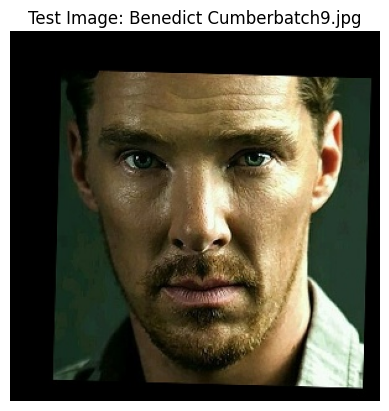

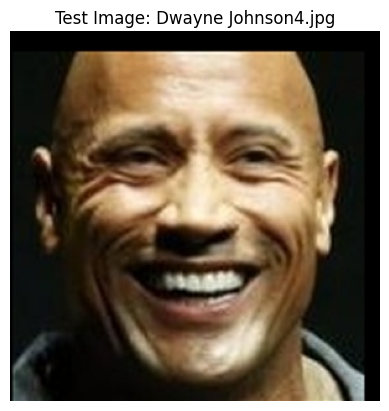

In [39]:
# 8. Import and display the test images
import matplotlib.pyplot as plt
test_images = ['/Users/apple/Downloads/Benedict Cumberbatch9.jpg', '/Users/apple/Downloads/Dwayne Johnson4.jpg']
for test_image in test_images:
    if os.path.exists(test_image):
        img = Image.open(test_image)
        plt.imshow(img)
        plt.title(f"Test Image: {os.path.basename(test_image)}")
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        print(f"Test image {test_image} not found")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


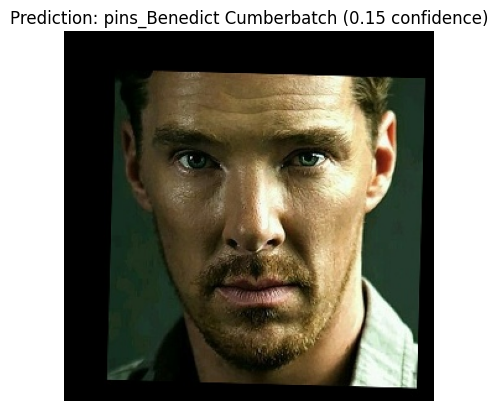

The person in /Users/apple/Downloads/Benedict Cumberbatch9.jpg is predicted to be pins_Benedict Cumberbatch with 0.15 confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


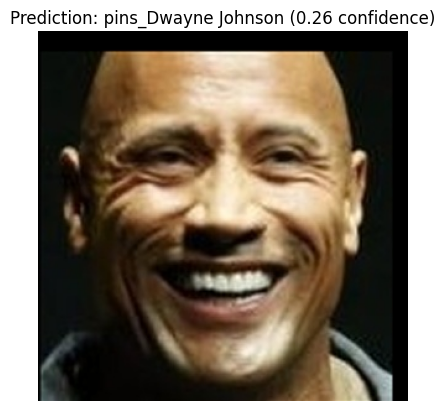

The person in /Users/apple/Downloads/Dwayne Johnson4.jpg is predicted to be pins_Dwayne Johnson with 0.26 confidence.


In [41]:
# 9. Predict faces on test images using SVM
for test_image in test_images:
    if os.path.exists(test_image):
        # Generate embedding for test image using VGG16
        test_embedding = generate_embedding_vgg(test_image, vgg_face_model)
        
        # Apply PCA transformation
        test_embedding_pca = pca.transform(test_embedding.reshape(1, -1))
        
        # Predict using SVM
        prediction = svm_classifier.predict(test_embedding_pca)
        predicted_person = le.inverse_transform(prediction)[0]
        
        confidence = svm_classifier.predict_proba(test_embedding_pca).max()
        
        # Display the image
        img = Image.open(test_image)
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_person} ({confidence:.2f} confidence)")
        plt.axis('off')
        plt.show()
        
        print(f"The person in {test_image} is predicted to be {predicted_person} with {confidence:.2f} confidence.")
    else:
        print(f"Test image {test_image} not found")